In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests10 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True
data_tuned_c = .01


In [4]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs8/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs8/'+name,dpi=300)
    plt.show()


In [5]:
def keep_alphanumeric(string):
    return re.sub(r'[^a-zA-Z0-9_]', '', string)


def mc_run_size(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = keep_alphanumeric('size_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

def mc_run_power(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = keep_alphanumeric('power_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

# Size stuff

Quantiles: 1th: 0.37, 5th: 3.05, 10th: 9.06, 30th: 70.40, 50th: 209.04, 70th: 480.44, 90th: 1245.21, 95th: 1825.26, 99th: 3101.50
bonus term 1.342800467795621 // variance stats 1.0841170930298347 //part1 2.51188643150958 //part2 0.5345784948520271
0.39963537363709983 -0.30795311787315205 2.234933886980702
-2.285965561954142 -0.30795311787315205 -0.4506670486105401
---
Quantiles: 1th: 0.65, 5th: 5.24, 10th: 24.08, 30th: 193.61, 50th: 590.44, 70th: 1401.07, 90th: 3493.98, 95th: 4805.75, 99th: 8268.05
bonus term 1.8577854510023994 // variance stats 1.2301828146050777 //part1 2.51188643150958 //part2 0.739597709394018
1.3485089405192112 -0.3761646349093777 2.366404392272499
-2.3670619614855877 -0.3761646349093777 -1.3491665097322996
---
Quantiles: 1th: 0.80, 5th: 4.17, 10th: 14.07, 30th: 115.54, 50th: 389.40, 70th: 905.53, 90th: 2187.22, 95th: 3014.17, 99th: 5293.45
bonus term 1.9454914353153183 // variance stats 0.6367693929211028 //part1 2.51188643150958 //part2 0.7745140906494435
1.5143

1.03177050821674 -0.4243860204972433 2.319655024617462
-2.346734845477721 -0.4243860204972433 -1.0588503290769988
---
Quantiles: 1th: 0.58, 5th: 3.29, 10th: 10.46, 30th: 86.68, 50th: 259.55, 70th: 613.65, 90th: 1522.17, 95th: 2148.31, 99th: 3700.19
bonus term 1.3189104526545434 // variance stats 1.3768275668649816 //part1 2.51188643150958 //part2 0.5250677085197325
0.35263992155469104 -0.2612727997119027 2.2582025447367
-2.2851809837543957 -0.2612727997119027 -0.3796183605723868
---
Quantiles: 1th: 0.42, 5th: 2.81, 10th: 8.36, 30th: 78.41, 50th: 236.24, 70th: 549.05, 90th: 1400.52, 95th: 1950.45, 99th: 3480.58
bonus term 1.049541687657317 // variance stats 1.951367378863018 //part1 2.51188643150958 //part2 0.4178300716511968
-0.1253954323775871 -0.09949727040339303 2.2132360675566294
-2.224478807692221 -0.09949727040339303 0.11415269224199572
---
Quantiles: 1th: 0.73, 5th: 4.95, 10th: 15.32, 30th: 114.28, 50th: 342.84, 70th: 780.55, 90th: 1877.48, 95th: 2724.11, 99th: 4651.52
bonus ter

Quantiles: 1th: 0.80, 5th: 4.60, 10th: 13.14, 30th: 106.97, 50th: 336.51, 70th: 800.86, 90th: 2038.87, 95th: 2875.23, 99th: 4934.35
bonus term 2.0290439341635333 // variance stats 0.48518015941074255 //part1 2.51188643150958 //part2 0.8077769395585809
1.6341236357537574 -0.5269228227157678 2.4023943900020504
-2.4239642325733093 -0.5269228227157678 -1.6556934783250163
---
Quantiles: 1th: 0.82, 5th: 5.26, 10th: 17.43, 30th: 142.70, 50th: 425.99, 70th: 1034.08, 90th: 2650.71, 95th: 3767.69, 99th: 6509.30
bonus term 1.0111448440232764 // variance stats 3.934179811280402 //part1 2.51188643150958 //part2 0.4025440128738639
-0.1426513609826664 0.15894903521933376 2.136057241564424
-2.164941049029219 0.15894903521933376 0.11376755351787093
---
Quantiles: 1th: 0.43, 5th: 2.87, 10th: 9.33, 30th: 91.81, 50th: 280.11, 70th: 624.95, 90th: 1563.01, 95th: 2208.06, 99th: 3761.47
bonus term 1.2109514109001305 // variance stats 1.67915262008504 //part1 2.51188643150958 //part2 0.48208843987121636
0.2525

-0.2818443638774583 0.1223785118857392 2.118932161702774
-2.1680585742413916 0.1223785118857392 0.23271795133884016
---
Quantiles: 1th: 0.38, 5th: 2.78, 10th: 9.17, 30th: 78.91, 50th: 263.35, 70th: 599.45, 90th: 1514.71, 95th: 2152.91, 99th: 3463.58
bonus term 2.061888983299231 // variance stats 0.3305776239727688 //part1 2.51188643150958 //part2 0.820852789136684
1.7066145996877229 -0.7491233366314338 2.4348903512529185
-2.417163366910739 -0.7491233366314338 -1.6888876153455434
---
Quantiles: 1th: 0.87, 5th: 5.54, 10th: 16.12, 30th: 155.90, 50th: 467.12, 70th: 1056.09, 90th: 2536.09, 95th: 3610.09, 99th: 5949.93
bonus term 1.161379060476076 // variance stats 2.9490900602583 //part1 2.51188643150958 //part2 0.4623533317062097
0.09881653026306955 -0.08715590294392987 2.263537257692155
-2.2239415906890825 -0.08715590294392987 -0.059220863259997356
---
Quantiles: 1th: 0.80, 5th: 4.14, 10th: 11.08, 30th: 102.33, 50th: 338.67, 70th: 787.53, 90th: 1963.98, 95th: 2803.14, 99th: 4750.26
bonus 

1.693325842377758 -0.634154506110816 2.3998095039346015
-2.4333354451038214 -0.634154506110816 -1.7268517835469777
---
Quantiles: 1th: 0.62, 5th: 4.04, 10th: 12.43, 30th: 117.90, 50th: 366.73, 70th: 874.19, 90th: 2107.96, 95th: 2960.46, 99th: 5039.92
bonus term 2.056477031161088 // variance stats 0.4668113799583991 //part1 2.51188643150958 //part2 0.818698252183797
1.7154346092781096 -0.6138824469754685 2.41233204730665
-2.397519453044066 -0.6138824469754685 -1.7006220150155262
---
Quantiles: 1th: 0.52, 5th: 4.40, 10th: 14.68, 30th: 142.46, 50th: 421.19, 70th: 985.28, 90th: 2444.23, 95th: 3321.04, 99th: 6148.78
bonus term 0.9864790516801573 // variance stats 3.779543923534235 //part1 2.51188643150958 //part2 0.3927243840746846
-0.284314544914973 0.0693975373435844 2.1829318557901494
-2.2572726482752876 0.0693975373435844 0.20997375242983504
---
Quantiles: 1th: 0.59, 5th: 3.57, 10th: 12.33, 30th: 117.43, 50th: 358.73, 70th: 867.30, 90th: 2186.61, 95th: 3032.91, 99th: 4993.77
bonus term 

0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.37, 5th: 2.55, 10th: 7.37, 30th: 54.80, 50th: 170.31, 70th: 414.02, 90th: 1049.05, 95th: 1565.65, 99th: 2572.41
bonus term 0.6724194644964142 // variance stats 2.8697815844900685 //part1 2.51188643150958 //part2 0.26769501043576527
-0.8462302582490848 0.07632943742134257 2.152618782933839
-2.1910691872419132 0.07632943742134257 0.8077798539410105
---
Quantiles: 1th: 0.48, 5th: 3.73, 10th: 12.09, 30th: 105.36, 50th: 308.66, 70th: 717.00, 90th: 1827.97, 95th: 2641.77, 99th: 4371.74
bonus term 0.9344162836522796 // variance stats 3.085952409132909 //part1 2.51188643150958 //part2 0.3719978228039232
-0.31213075079260755 -0.032035596299401094 2.2113661250986953
-2.1809633180971666 -0.032035596299401094 0.342533557794136
---
Quantiles: 1th: 0.45, 5th: 3.39, 10th: 10.30, 30th: 87.04, 50th: 259.43, 70th: 623.15, 90th: 1558.00, 95th: 2175.41, 99th: 3734.02
bonus term 1.0236902046706127 // variance stats 2.2649514452630077 //part1 2.51188643150958

Quantiles: 1th: 0.59, 5th: 3.69, 10th: 11.26, 30th: 93.14, 50th: 294.29, 70th: 725.01, 90th: 1772.54, 95th: 2387.94, 99th: 3913.38
bonus term 1.3969820070629357 // variance stats 1.41462694047682 //part1 2.51188643150958 //part2 0.5561485541459711
0.48975935219943045 -0.4828065751820266 2.240583525014115
-2.304204661926441 -0.4828065751820266 -0.5533804891117562
---
Quantiles: 1th: 0.59, 5th: 4.40, 10th: 14.99, 30th: 131.54, 50th: 392.48, 70th: 929.97, 90th: 2312.09, 95th: 3264.59, 99th: 5617.73
bonus term 0.6206584277143483 // variance stats 7.045231320931757 //part1 2.51188643150958 //part2 0.2470885705375415
-0.9121945374531187 0.681905583852044 2.172866011071377
-2.153511392881815 0.681905583852044 0.9315491556426803
---
Quantiles: 1th: 0.42, 5th: 3.43, 10th: 11.38, 30th: 97.51, 50th: 298.03, 70th: 713.30, 90th: 1773.55, 95th: 2566.95, 99th: 4116.55
bonus term 1.5746836721042852 // variance stats 1.0555641567238483 //part1 2.51188643150958 //part2 0.626892861218228
0.79358953424668

0.46062897070683345 -0.8207447792170035 2.2916272816539824
-2.2768023560590516 -0.8207447792170035 -0.44580404511190264
---
Quantiles: 1th: 0.69, 5th: 4.52, 10th: 13.56, 30th: 117.79, 50th: 332.69, 70th: 762.71, 90th: 1934.11, 95th: 2785.87, 99th: 4682.36
bonus term 1.4821315762288143 // variance stats 1.343781522085386 //part1 2.51188643150958 //part2 0.5900472082004483
0.6517972284858711 -0.4686340257552368 2.253047815377599
-2.3124659239717573 -0.4686340257552368 -0.7112153370800297
---
Quantiles: 1th: 0.47, 5th: 3.03, 10th: 9.48, 30th: 80.93, 50th: 229.78, 70th: 539.61, 90th: 1366.35, 95th: 1880.94, 99th: 3338.59
bonus term 0.9145003703563468 // variance stats 2.3866530909066466 //part1 2.51188643150958 //part2 0.3640691549126906
-0.4069348704737442 -0.0783082868199364 2.1620325479622755
-2.235935611186438 -0.0783082868199364 0.33303180724958187
---
Quantiles: 1th: 0.47, 5th: 3.03, 10th: 8.43, 30th: 69.00, 50th: 211.92, 70th: 498.36, 90th: 1251.66, 95th: 1751.41, 99th: 2964.76
bonu

Quantiles: 1th: 0.57, 5th: 3.24, 10th: 10.12, 30th: 91.45, 50th: 265.19, 70th: 629.52, 90th: 1615.43, 95th: 2238.11, 99th: 4009.20
bonus term 0.4191816693580759 // variance stats 8.06478451519922 //part1 2.51188643150958 //part2 0.16687922833603522
-1.0815525920415239 1.1516829833967228 2.364149657497967
-1.9199159307576756 1.1516829833967228 1.5257863187818153
---
Quantiles: 1th: 0.68, 5th: 3.80, 10th: 11.05, 30th: 90.40, 50th: 268.02, 70th: 633.07, 90th: 1526.75, 95th: 2170.00, 99th: 3716.06
bonus term 1.1297654637904646 // variance stats 1.8677792643382802 //part1 2.51188643150958 //part2 0.4497677321786814
0.009286760700256282 -0.4000002728103442 2.298178095825137
-2.2502441668806727 -0.4000002728103442 0.03864716824420797
---
Quantiles: 1th: 0.35, 5th: 2.39, 10th: 6.09, 30th: 46.22, 50th: 146.11, 70th: 333.75, 90th: 852.45, 95th: 1228.35, 99th: 2054.08
bonus term 0.3207979498419157 // variance stats 5.82236933889275 //part1 2.51188643150958 //part2 0.12771196413092778
-1.373801644

Quantiles: 1th: 0.40, 5th: 2.61, 10th: 8.44, 30th: 73.68, 50th: 226.49, 70th: 548.55, 90th: 1387.85, 95th: 1946.43, 99th: 3346.72
bonus term 0.8315611873590207 // variance stats 2.804421080771756 //part1 2.51188643150958 //part2 0.3310504714416063
-0.5188200833819526 0.02032797423155873 2.1178741933799206
-2.1819424580999938 0.02032797423155873 0.45475181866187897
---
Quantiles: 1th: 0.53, 5th: 2.92, 10th: 10.12, 30th: 99.44, 50th: 325.46, 70th: 759.39, 90th: 1880.13, 95th: 2675.05, 99th: 4644.41
bonus term 0.5509555297828109 // variance stats 6.69163979022963 //part1 2.51188643150958 //part2 0.21933934706263794
-0.9539199223539031 0.7084544146871469 2.230493007147333
-2.055830981919525 0.7084544146871469 1.1285819475817112
---
Quantiles: 1th: 0.43, 5th: 3.81, 10th: 11.23, 30th: 102.56, 50th: 311.53, 70th: 763.03, 90th: 1930.07, 95th: 2714.36, 99th: 4791.68
bonus term 0.801808893049382 // variance stats 4.116407781133811 //part1 2.51188643150958 //part2 0.31920586973652115
-0.532812834

-0.28826614770188697 -0.03858495946219107 2.162164796133244
-2.17340140241091 -0.03858495946219107 0.27702954142422126
---
0.5384615384615385 [1. 0. 0.]
Quantiles: 1th: 0.56, 5th: 3.67, 10th: 10.67, 30th: 94.90, 50th: 275.62, 70th: 622.33, 90th: 1494.91, 95th: 2077.21, 99th: 3566.55
bonus term 1.6830655449438776 // variance stats 0.7361646964095137 //part1 2.51188643150958 //part2 0.670040461953687
1.0456004278556297 -1.2216342561868336 2.324042464972646
-2.3205306620321258 -1.2216342561868336 -1.0420886249151091
---
Quantiles: 1th: 0.55, 5th: 2.86, 10th: 8.67, 30th: 78.05, 50th: 244.03, 70th: 567.85, 90th: 1405.89, 95th: 1991.51, 99th: 3298.46
bonus term 1.0268260554484143 // variance stats 2.0332875807430506 //part1 2.51188643150958 //part2 0.4087868155851767
-0.16893620323684766 -1.0585910553249955 2.1196585841020847
-2.2225883141336764 -1.0585910553249955 0.06600647320525597
---
Quantiles: 1th: 0.40, 5th: 2.58, 10th: 6.83, 30th: 55.38, 50th: 175.65, 70th: 430.92, 90th: 1072.20, 95t

0.2147439677788138 -0.6785733885474755 2.20995156320981
-2.21053455840089 -0.6785733885474755 -0.2153269629698937
---
Quantiles: 1th: 0.46, 5th: 2.84, 10th: 9.43, 30th: 76.56, 50th: 236.34, 70th: 552.19, 90th: 1383.39, 95th: 2042.93, 99th: 3269.26
bonus term 1.4117055612968497 // variance stats 1.0781125048555327 //part1 2.51188643150958 //part2 0.5620101066625255
0.576794246594403 -1.3338240645628572 2.2985914846465665
-2.246616875999296 -1.3338240645628572 -0.5248196379471328
---
Quantiles: 1th: 0.48, 5th: 3.34, 10th: 11.51, 30th: 101.09, 50th: 322.49, 70th: 771.18, 90th: 1938.14, 95th: 2835.33, 99th: 4767.22
bonus term 0.6735776926165336 // variance stats 5.289517587872193 //part1 2.51188643150958 //part2 0.2681561093555215
-0.871178148210415 0.21820503184870466 2.074053556143556
-2.2183335334434817 0.21820503184870466 0.7268981709104885
---
Quantiles: 1th: 0.91, 5th: 5.67, 10th: 17.06, 30th: 136.17, 50th: 438.48, 70th: 999.72, 90th: 2383.04, 95th: 3518.45, 99th: 5609.89
bonus term 

-1.187966651865012 0.8663969914597432 2.0530735651934937
-2.112405091926968 0.8663969914597432 1.1286351251315374
---
Quantiles: 1th: 0.51, 5th: 3.99, 10th: 13.13, 30th: 114.69, 50th: 372.67, 70th: 873.08, 90th: 2171.48, 95th: 3218.54, 99th: 5641.90
bonus term 1.282351047127393 // variance stats 2.082040112680241 //part1 2.51188643150958 //part2 0.5105131470282008
0.3575026158436174 -0.7246197167273716 2.1899348927941644
-2.207199478411168 -0.7246197167273716 -0.3747672014606213
---
Quantiles: 1th: 0.59, 5th: 4.07, 10th: 11.90, 30th: 100.18, 50th: 304.02, 70th: 725.66, 90th: 1795.49, 95th: 2539.46, 99th: 4599.48
bonus term 0.7610662454696513 // variance stats 4.130488551991144 //part1 2.51188643150958 //part2 0.3029859295876962
-0.7172625605156172 -0.05499596953261542 2.1207528269549965
-2.23939505145492 -0.05499596953261542 0.5986203360156939
---
Quantiles: 1th: 0.77, 5th: 4.13, 10th: 11.25, 30th: 92.65, 50th: 269.23, 70th: 610.07, 90th: 1535.82, 95th: 2159.91, 99th: 3811.81
bonus ter

-1.2139194075655162 0.3861914897696431 2.190581284336289
-2.0868486672461684 0.3861914897696431 1.317652024655637
---
Quantiles: 1th: 0.85, 5th: 6.23, 10th: 19.36, 30th: 173.93, 50th: 546.72, 70th: 1190.25, 90th: 2954.93, 95th: 4362.23, 99th: 7557.98
bonus term 0.5892549094880203 // variance stats 9.641395816686384 //part1 2.51188643150958 //part2 0.23458660475103288
-0.8695200519936308 0.8443370383455939 2.072777698763528
-2.0480298709696716 0.8443370383455939 0.8942678797874871
---
Quantiles: 1th: 0.50, 5th: 2.76, 10th: 9.10, 30th: 78.17, 50th: 256.90, 70th: 598.50, 90th: 1520.65, 95th: 2110.69, 99th: 3539.09
bonus term 0.8543976960399227 // variance stats 2.9499770131251615 //part1 2.51188643150958 //part2 0.3401418492978806
-0.4292681205533474 -0.46270410698824627 2.052897948602142
-2.1380635126331926 -0.46270410698824627 0.3441025565222967
---
Quantiles: 1th: 0.38, 5th: 2.58, 10th: 8.38, 30th: 63.84, 50th: 190.11, 70th: 445.39, 90th: 1114.42, 95th: 1554.79, 99th: 2663.20
bonus ter

-0.8676933334772122 0.5135845771649372 2.082743622359901
-2.016395883211953 0.5135845771649372 0.9340410726251611
---
Quantiles: 1th: 0.55, 5th: 3.96, 10th: 10.81, 30th: 93.46, 50th: 292.17, 70th: 692.23, 90th: 1711.23, 95th: 2390.31, 99th: 4008.14
bonus term 0.6296978352805461 // variance stats 5.1149119927213045 //part1 2.51188643150958 //part2 0.2506872235072004
-0.9092357063587353 -0.12405037098763791 2.111272337641043
-2.1686313769198273 -0.12405037098763791 0.8518766670799509
---
Quantiles: 1th: 0.68, 5th: 4.34, 10th: 13.43, 30th: 117.99, 50th: 365.32, 70th: 867.10, 90th: 2184.02, 95th: 3203.27, 99th: 5597.09
bonus term 1.1072481294774024 // variance stats 2.7706172239183133 //part1 2.51188643150958 //part2 0.44080341992690103
0.009038493595594013 -0.9617171374100294 2.1975716506634697
-2.2054577653592107 -0.9617171374100294 -0.01692460829133514
---
Quantiles: 1th: 0.67, 5th: 5.09, 10th: 15.25, 30th: 121.01, 50th: 369.27, 70th: 898.61, 90th: 2143.64, 95th: 3088.90, 99th: 5083.42


Quantiles: 1th: 0.44, 5th: 2.58, 10th: 7.49, 30th: 57.43, 50th: 183.29, 70th: 418.86, 90th: 1080.76, 95th: 1575.57, 99th: 2629.75
bonus term 0.6666652561683719 // variance stats 2.9913774565721916 //part1 2.51188643150958 //part2 0.265404218839513
-0.8921401001313367 -0.5513240621625066 2.1763867012068117
-2.2254706124680803 -0.5513240621625066 0.8430561888700678
---
Quantiles: 1th: 0.34, 5th: 2.54, 10th: 8.05, 30th: 72.01, 50th: 212.44, 70th: 486.94, 90th: 1260.17, 95th: 1778.58, 99th: 2927.63
bonus term 0.899092425924711 // variance stats 2.260504494322054 //part1 2.51188643150958 //part2 0.35793514175096647
-0.32615936324146283 -0.6424733079545484 2.184305371016102
-2.1243442150908844 -0.6424733079545484 0.3861205191666799
---
0.8461538461538463 [0.99 0.   0.01]
Quantiles: 1th: 0.27, 5th: 1.81, 10th: 6.49, 30th: 55.18, 50th: 164.54, 70th: 407.69, 90th: 1016.81, 95th: 1397.84, 99th: 2500.31
bonus term 0.9866088627965075 // variance stats 1.5719738828364933 //part1 2.51188643150958 //

-0.7157894068751948 -0.47799377106085444 2.043160247273514
-2.0721317087447835 -0.47799377106085444 0.6868179454039255
---
Quantiles: 1th: 0.46, 5th: 3.29, 10th: 10.03, 30th: 88.69, 50th: 286.27, 70th: 667.46, 90th: 1640.38, 95th: 2468.36, 99th: 4082.74
bonus term 0.5412005548059736 // variance stats 5.973150412804144 //part1 2.51188643150958 //part2 0.21545582157578907
-1.0175114079860883 0.28274685437578856 2.187589995801563
-2.0999125175980358 0.28274685437578856 1.105188886189616
---
Quantiles: 1th: 0.29, 5th: 2.31, 10th: 8.09, 30th: 83.92, 50th: 253.87, 70th: 597.72, 90th: 1527.14, 95th: 2159.99, 99th: 3694.26
bonus term 1.2073108527011123 // variance stats 1.6501711026153445 //part1 2.51188643150958 //part2 0.48063910754736994
0.17570838097369415 -1.8862237515007594 2.2800561997907955
-2.2389133244285304 -1.8862237515007594 -0.13456550561142874
---
Quantiles: 1th: 0.51, 5th: 3.71, 10th: 12.35, 30th: 93.81, 50th: 285.96, 70th: 680.49, 90th: 1635.84, 95th: 2421.44, 99th: 4011.43
bo

-0.9774950456480583 0.06471138330738391 2.0971379632640272
-2.021867740415646 0.06471138330738391 1.0527652684964397
---
Quantiles: 1th: 0.52, 5th: 3.45, 10th: 10.25, 30th: 87.64, 50th: 265.06, 70th: 630.33, 90th: 1641.46, 95th: 2333.47, 99th: 3969.58
bonus term 0.708934707976071 // variance stats 4.174539424144336 //part1 2.51188643150958 //part2 0.2822319906995235
-0.7658285756675695 -0.5423032793117986 2.1841350701047824
-2.1836979916197117 -0.5423032793117986 0.7662656541526406
---
Quantiles: 1th: 0.44, 5th: 3.14, 10th: 9.46, 30th: 78.21, 50th: 253.06, 70th: 587.89, 90th: 1525.31, 95th: 2175.71, 99th: 3740.70
bonus term 0.7200856138322801 // variance stats 3.7954556304341036 //part1 2.51188643150958 //part2 0.2866712462790473
-0.6267424706554872 -0.719088700646206 2.0931977490582514
-2.0669136983200476 -0.719088700646206 0.6530265213936912
---
Quantiles: 1th: 0.53, 5th: 3.53, 10th: 10.21, 30th: 90.06, 50th: 270.44, 70th: 629.69, 90th: 1602.04, 95th: 2315.08, 99th: 4005.17
bonus ter

Quantiles: 1th: 0.57, 5th: 3.70, 10th: 10.88, 30th: 85.35, 50th: 255.86, 70th: 608.51, 90th: 1537.35, 95th: 2203.31, 99th: 3638.53
bonus term 0.36665004311879107 // variance stats 8.994873337453065 //part1 2.51188643150958 //part2 0.14596601124933967
-1.2361394714543785 1.0535178451843517 1.9414258279399184
-1.9694395576919608 1.0535178451843517 1.208125741702336
---
Quantiles: 1th: 0.55, 5th: 4.38, 10th: 14.10, 30th: 123.91, 50th: 380.48, 70th: 893.86, 90th: 2244.62, 95th: 3263.67, 99th: 5036.29
bonus term 0.9178211087932979 // variance stats 3.8984390546200847 //part1 2.51188643150958 //part2 0.36539116469597344
-0.3317527252247424 -0.753824302325589 2.131026215985724
-2.167394942811338 -0.753824302325589 0.2953839983991279
---
Quantiles: 1th: 0.37, 5th: 3.25, 10th: 11.28, 30th: 93.15, 50th: 280.79, 70th: 648.43, 90th: 1602.75, 95th: 2228.73, 99th: 3752.37
bonus term 0.5323414696678369 // variance stats 5.9599322909610555 //part1 2.51188643150958 //part2 0.21192895625775293
-1.010429

-1.1151374552084503 0.26569760408491516 2.117136529905921
-2.0620245038882556 0.26569760408491516 1.1702494812261153
---
Quantiles: 1th: 0.59, 5th: 3.15, 10th: 9.80, 30th: 94.30, 50th: 305.93, 70th: 724.51, 90th: 1829.64, 95th: 2640.80, 99th: 4729.57
bonus term 0.4913957796095991 // variance stats 7.523011902758961 //part1 2.51188643150958 //part2 0.19562818344230742
-1.0693662774775858 0.3881028045608403 2.235883136545569
-2.0521578366967845 0.3881028045608403 1.2530915773263704
---
Quantiles: 1th: 0.48, 5th: 3.99, 10th: 13.84, 30th: 109.35, 50th: 329.74, 70th: 766.71, 90th: 2009.48, 95th: 2866.19, 99th: 4882.14
bonus term 0.6898167369421393 // variance stats 5.307802898943419 //part1 2.51188643150958 //part2 0.2746209893444812
-0.7443951025026521 -0.5646138477709198 2.0765249727509985
-2.1240285763869307 -0.5646138477709198 0.6968914988667195
---
Quantiles: 1th: 0.67, 5th: 4.75, 10th: 14.96, 30th: 121.98, 50th: 383.23, 70th: 898.06, 90th: 2175.75, 95th: 3102.06, 99th: 5282.74
bonus t

Quantiles: 1th: 0.48, 5th: 3.53, 10th: 10.84, 30th: 108.82, 50th: 323.72, 70th: 730.03, 90th: 1788.38, 95th: 2460.95, 99th: 4627.40
bonus term 0.43476068278881425 // variance stats 8.544239454767945 //part1 2.51188643150958 //part2 0.17308134529296137
-1.2926428823203768 0.7263423323297366 2.0401413608434913
-2.1621642478980054 0.7263423323297366 1.1706199952658631
---
Quantiles: 1th: 1.00, 5th: 5.56, 10th: 14.55, 30th: 122.69, 50th: 357.16, 70th: 849.16, 90th: 2148.78, 95th: 3023.54, 99th: 5244.26
bonus term 1.481946140168027 // variance stats 1.4933859898557607 //part1 2.51188643150958 //part2 0.5899733847749697
0.5937437935948653 -2.2234873331094915 2.22662990086217
-2.370148486741188 -2.2234873331094915 -0.737262379473884
---
1.153846153846154 [0.96857143 0.00142857 0.03      ]
Quantiles: 1th: 0.63, 5th: 3.50, 10th: 10.00, 30th: 86.00, 50th: 263.17, 70th: 621.40, 90th: 1517.74, 95th: 2117.22, 99th: 3756.30
bonus term 0.46626671923983326 // variance stats 6.658666103703912 //part1 2

Quantiles: 1th: 0.51, 5th: 3.28, 10th: 10.43, 30th: 86.03, 50th: 267.09, 70th: 620.59, 90th: 1613.97, 95th: 2246.60, 99th: 3837.43
bonus term 0.6474899702915486 // variance stats 4.647310744927303 //part1 2.51188643150958 //part2 0.25777040003453644
-0.7610048808521329 -1.367360095388715 2.035826629102871
-2.0559848214352305 -1.367360095388715 0.7408466885197733
---
Quantiles: 1th: 0.51, 5th: 3.10, 10th: 9.60, 30th: 82.67, 50th: 253.78, 70th: 620.03, 90th: 1621.57, 95th: 2341.49, 99th: 4038.85
bonus term 0.48051164459309814 // variance stats 6.855217404572984 //part1 2.51188643150958 //part2 0.19129513124696595
-1.1001598792051945 0.08440963218839917 1.9512751963406618
-2.061183168391391 0.08440963218839917 0.9902519071544655
---
Quantiles: 1th: 0.64, 5th: 3.18, 10th: 8.17, 30th: 59.89, 50th: 182.65, 70th: 409.05, 90th: 1025.11, 95th: 1465.39, 99th: 2571.94
bonus term 0.5351309799995742 // variance stats 3.7867132773997376 //part1 2.51188643150958 //part2 0.2130394803231506
-1.00426998

-0.9901130935209145 -0.33520203733811943 2.120356807137151
-2.0385993880348265 -0.33520203733811943 1.0718705126232395
---
Quantiles: 1th: 0.50, 5th: 3.47, 10th: 12.96, 30th: 123.46, 50th: 371.07, 70th: 867.98, 90th: 2148.85, 95th: 3054.58, 99th: 5249.64
bonus term 0.514859748163217 // variance stats 8.334915739565776 //part1 2.51188643150958 //part2 0.20496935757314447
-1.0650194968305322 0.06723733554448026 2.0330739029576494
-2.0947389931569664 0.06723733554448026 1.003354406631215
---
Quantiles: 1th: 0.48, 5th: 2.55, 10th: 7.52, 30th: 62.19, 50th: 191.04, 70th: 433.26, 90th: 1069.51, 95th: 1490.60, 99th: 2504.70
bonus term 0.28095236147823677 // variance stats 8.492602532584595 //part1 2.51188643150958 //part2 0.11184914968842422
-1.5734995729205483 0.7126534028916447 2.199162954323565
-2.135404295877022 0.7126534028916447 1.6372582313670911
---
Quantiles: 1th: 0.85, 5th: 4.83, 10th: 11.31, 30th: 105.44, 50th: 328.74, 70th: 741.24, 90th: 1988.43, 95th: 2794.16, 99th: 4826.23
bonus 

0.21408370307228364 -3.6447127041452485 2.203319890390936
-2.2280652799554472 -3.6447127041452485 -0.23882909263679483
---
Quantiles: 1th: 0.51, 5th: 3.62, 10th: 13.69, 30th: 115.70, 50th: 373.74, 70th: 863.54, 90th: 2131.74, 95th: 3026.06, 99th: 5305.47
bonus term 0.5756270278127897 // variance stats 7.170609329634632 //part1 2.51188643150958 //part2 0.22916124733666898
-0.9057908985775597 -0.3711310407939451 2.067833140466024
-2.057044954203139 -0.3711310407939451 0.9165790848404447
---
Quantiles: 1th: 0.91, 5th: 7.17, 10th: 22.88, 30th: 197.49, 50th: 577.04, 70th: 1355.25, 90th: 3423.97, 95th: 4862.67, 99th: 7757.99
bonus term 0.7678089894714851 // variance stats 7.777547233376172 //part1 2.51188643150958 //part2 0.3056702643240329
-0.5053716434674321 -0.42297140579266546 2.0361962136450207
-2.0409896224104025 -0.42297140579266546 0.5005782347020505
---
Quantiles: 1th: 0.45, 5th: 3.03, 10th: 8.34, 30th: 68.67, 50th: 197.09, 70th: 474.63, 90th: 1173.60, 95th: 1710.43, 99th: 3143.83
b

-1.382727181351493 0.06364565563125195 1.9729914508457718
-2.0927702902620426 0.06364565563125195 1.2629483419352217
---
Quantiles: 1th: 0.89, 5th: 6.45, 10th: 19.07, 30th: 159.52, 50th: 448.83, 70th: 1058.83, 90th: 2699.49, 95th: 3790.64, 99th: 6386.08
bonus term 0.42301193895231093 // variance stats 13.330369628513893 //part1 2.51188643150958 //part2 0.1684040861266532
-1.1395004159382631 0.9639269899274499 2.22306988036517
-1.9855242938428852 0.9639269899274499 1.3770460024605478
---
Quantiles: 1th: 0.44, 5th: 3.43, 10th: 11.03, 30th: 95.85, 50th: 304.60, 70th: 710.90, 90th: 1827.73, 95th: 2536.33, 99th: 4422.40
bonus term 0.2856914203581574 // variance stats 14.242258198944045 //part1 2.51188643150958 //part2 0.11373580301019585
-1.4322238413922563 1.6987259951326714 2.338906983850849
-2.0036066821085714 1.6987259951326714 1.7675241431345339
---
Quantiles: 1th: 0.44, 5th: 2.48, 10th: 7.29, 30th: 60.39, 50th: 202.76, 70th: 474.14, 90th: 1220.92, 95th: 1770.44, 99th: 3062.07
bonus te

Quantiles: 1th: 0.41, 5th: 4.36, 10th: 14.26, 30th: 132.77, 50th: 436.03, 70th: 1020.36, 90th: 2488.45, 95th: 3579.79, 99th: 6112.93
bonus term 0.7734126564479898 // variance stats 5.59351812592904 //part1 2.51188643150958 //part2 0.3079011243287733
-0.6229232130368104 -0.7274830548396353 2.1714426668978533
-2.16974852593279 -0.7274830548396353 0.6246173540018737
---
Quantiles: 1th: 0.47, 5th: 4.49, 10th: 16.14, 30th: 132.77, 50th: 417.46, 70th: 987.43, 90th: 2474.92, 95th: 3514.24, 99th: 6136.99
bonus term 0.5284291139637538 // variance stats 9.289606088486396 //part1 2.51188643150958 //part2 0.2103714193982016
-1.0257873434821787 -0.07443577903119439 2.064070969455126
-2.082645571409686 -0.07443577903119439 1.0072127415276186
---
Quantiles: 1th: 0.52, 5th: 3.53, 10th: 10.42, 30th: 84.50, 50th: 261.05, 70th: 593.93, 90th: 1469.93, 95th: 2150.66, 99th: 3612.10
bonus term 0.3754980604851898 // variance stats 8.363116425537235 //part1 2.51188643150958 //part2 0.14948847040808488
-1.24727

Quantiles: 1th: 0.36, 5th: 2.35, 10th: 6.93, 30th: 59.44, 50th: 174.61, 70th: 416.35, 90th: 1042.82, 95th: 1497.64, 99th: 2454.23
bonus term 0.21637158106911566 // variance stats 11.06344918387188 //part1 2.51188643150958 //part2 0.08613907792761229
-1.4697801125424872 1.5044192320225616 2.2540405745123606
-1.9025232746807184 1.5044192320225616 1.8212974123741295
---
Quantiles: 1th: 0.82, 5th: 5.82, 10th: 20.74, 30th: 181.88, 50th: 557.39, 70th: 1278.93, 90th: 3219.28, 95th: 4374.25, 99th: 7727.75
bonus term 0.4525622407815306 // variance stats 14.64888363254193 //part1 2.51188643150958 //part2 0.1801682731768857
-1.141180948147783 1.1144466361474865 2.0598572124210084
-2.046305429710844 1.1144466361474865 1.1547327308579474
---
Quantiles: 1th: 0.83, 5th: 4.94, 10th: 16.44, 30th: 144.21, 50th: 450.74, 70th: 1066.20, 90th: 2594.03, 95th: 3737.26, 99th: 6495.99
bonus term 0.6612266931786336 // variance stats 7.260250506576444 //part1 2.51188643150958 //part2 0.2632390879157913
-0.7799265

Quantiles: 1th: 0.52, 5th: 3.21, 10th: 10.81, 30th: 89.23, 50th: 260.33, 70th: 604.70, 90th: 1508.50, 95th: 2148.26, 99th: 3708.99
bonus term 0.5175934548249777 // variance stats 5.8122575575535596 //part1 2.51188643150958 //part2 0.20605766579738125
-1.0068321380270722 -1.2245243257172385 2.146684726333821
-2.0420190476770275 -1.2245243257172385 1.111497816683866
---
Quantiles: 1th: 0.39, 5th: 2.14, 10th: 5.32, 30th: 42.08, 50th: 126.89, 70th: 301.14, 90th: 763.66, 95th: 1068.12, 99th: 1850.11
bonus term 0.23142702756118216 // variance stats 7.525016983593769 //part1 2.51188643150958 //part2 0.09213275913198846
-1.506883056469746 0.24785524333613773 1.9620527904956182
-1.9697371115921105 0.24785524333613773 1.4991987353732537
---
Quantiles: 1th: 0.31, 5th: 2.77, 10th: 8.84, 30th: 75.90, 50th: 228.68, 70th: 533.75, 90th: 1409.55, 95th: 2011.10, 99th: 3638.69
bonus term 0.3780656258791535 // variance stats 7.955560146619854 //part1 2.51188643150958 //part2 0.15051063660228683
-1.2391647

-1.1050428233533343 -0.6100175018951784 2.067693738309763
-2.2119270988451993 -0.6100175018951784 0.9608094628178977
---
Quantiles: 1th: 0.50, 5th: 3.43, 10th: 12.12, 30th: 111.18, 50th: 335.43, 70th: 768.03, 90th: 1921.56, 95th: 2748.93, 99th: 4835.16
bonus term 0.8986814102265293 // variance stats 3.449358799835055 //part1 2.51188643150958 //part2 0.3577715134543103
-0.2598732207319879 -2.9109458326347757 2.0827040715565843
-2.0572360411850465 -2.9109458326347757 0.2853412511035259
---
Quantiles: 1th: 0.49, 5th: 3.95, 10th: 13.15, 30th: 115.37, 50th: 354.59, 70th: 827.49, 90th: 2128.88, 95th: 2997.77, 99th: 5121.40
bonus term 0.6973947918443502 // variance stats 5.538944039326323 //part1 2.51188643150958 //part2 0.2776378673398994
-0.8327520709784768 -1.4754111896442226 2.102852838744965
-2.227541654667177 -1.4754111896442226 0.708063255056265
---
Quantiles: 1th: 0.49, 5th: 3.60, 10th: 11.72, 30th: 103.48, 50th: 297.31, 70th: 706.12, 90th: 1840.55, 95th: 2493.90, 99th: 4445.21
bonus 

-1.0479408160791646 -0.8994160185059902 2.0455006999145504
-2.1982616655753655 -0.8994160185059902 0.8951798504183488
---
Quantiles: 1th: 0.73, 5th: 5.06, 10th: 15.89, 30th: 127.16, 50th: 387.26, 70th: 925.26, 90th: 2288.66, 95th: 3127.56, 99th: 5596.89
bonus term 0.7428384047064387 // variance stats 5.450366388145597 //part1 2.51188643150958 //part2 0.295729295476154
-0.5636676420058244 -1.8409959084635206 2.0514839383369634
-2.049344451418702 -1.8409959084635206 0.5658071289240858
---
Quantiles: 1th: 0.51, 5th: 4.10, 10th: 12.98, 30th: 120.47, 50th: 369.38, 70th: 894.24, 90th: 2270.04, 95th: 3185.79, 99th: 5561.38
bonus term 0.4754841935887722 // variance stats 9.72213057821413 //part1 2.51188643150958 //part2 0.18929366695253744
-1.1072927164088402 -0.052424395846365296 2.0148540072090766
-2.0582611035863847 -0.052424395846365296 1.0638856200315323
---
Quantiles: 1th: 0.56, 5th: 3.35, 10th: 9.17, 30th: 77.82, 50th: 235.04, 70th: 551.36, 90th: 1416.84, 95th: 1991.93, 99th: 3373.53
bo

Quantiles: 1th: 0.39, 5th: 2.41, 10th: 7.01, 30th: 54.51, 50th: 167.72, 70th: 399.26, 90th: 971.72, 95th: 1364.67, 99th: 2243.45
bonus term 0.2626082685040803 // variance stats 8.322929671763623 //part1 2.51188643150958 //part2 0.10454623473811249
-1.5622925937143954 0.3709583053938731 2.092226926727972
-2.087509130722556 0.3709583053938731 1.5670103897198109
---
Quantiles: 1th: 0.50, 5th: 3.24, 10th: 9.07, 30th: 71.69, 50th: 226.88, 70th: 523.83, 90th: 1276.27, 95th: 1792.15, 99th: 3291.05
bonus term 0.29180217911284484 // variance stats 9.710073663505781 //part1 2.51188643150958 //part2 0.11616853988795947
-1.363794198427692 0.4955890957862447 1.914808446595015
-1.9473985566533818 0.4955890957862447 1.3312040883693252
---
Quantiles: 1th: 0.66, 5th: 4.25, 10th: 13.56, 30th: 122.64, 50th: 368.66, 70th: 849.35, 90th: 2118.28, 95th: 3046.81, 99th: 5131.07
bonus term 0.5539064628016446 // variance stats 7.487819347067315 //part1 2.51188643150958 //part2 0.22051413465725866
-1.013324241311

Quantiles: 1th: 0.63, 5th: 4.63, 10th: 14.23, 30th: 121.36, 50th: 358.02, 70th: 833.73, 90th: 2016.05, 95th: 2832.91, 99th: 4502.58
bonus term 0.33272411276657815 // variance stats 13.204045881273554 //part1 2.51188643150958 //part2 0.13245985510842517
-1.4419885230792102 1.070842523095466 2.1320863647936386
-2.107436748612366 1.070842523095466 1.4666381392604824
---
Quantiles: 1th: 0.49, 5th: 3.38, 10th: 10.84, 30th: 94.36, 50th: 280.87, 70th: 689.78, 90th: 1724.50, 95th: 2450.22, 99th: 4103.85
bonus term 0.2926855196979361 // variance stats 13.075480360041807 //part1 2.51188643150958 //part2 0.11652020410892523
-1.365606712625471 1.125566855310338 2.02331688273829
-1.9509777520213432 1.125566855310338 1.437945843342418
---
Quantiles: 1th: 0.52, 5th: 3.34, 10th: 11.09, 30th: 98.17, 50th: 325.97, 70th: 769.88, 90th: 1867.51, 95th: 2742.14, 99th: 4386.77
bonus term 0.47450169996991387 // variance stats 8.018596130464843 //part1 2.51188643150958 //part2 0.1889025291978469
-1.193006749585

Quantiles: 1th: 0.33, 5th: 2.39, 10th: 7.84, 30th: 69.62, 50th: 220.97, 70th: 510.99, 90th: 1300.69, 95th: 1849.03, 99th: 3175.47
bonus term 0.25438655533012067 // variance stats 11.542683615026897 //part1 2.51188643150958 //part2 0.101273111769325
-1.583185573764378 0.7663804130578886 2.21379841242222
-2.0919586844246196 0.7663804130578886 1.7050253017619785
---
Quantiles: 1th: 0.58, 5th: 3.12, 10th: 9.75, 30th: 80.63, 50th: 248.11, 70th: 603.25, 90th: 1537.39, 95th: 2151.52, 99th: 3743.27
bonus term 0.2761397146268591 // variance stats 12.44741319846827 //part1 2.51188643150958 //part2 0.10993320046754906
-1.5806264531252139 0.8351607166949035 2.223481145682442
-2.132905882378932 0.8351607166949035 1.671201716428724
---
Quantiles: 1th: 0.58, 5th: 4.33, 10th: 12.73, 30th: 113.68, 50th: 339.05, 70th: 746.71, 90th: 1910.81, 95th: 2843.23, 99th: 4770.12
bonus term 0.3765873339465173 // variance stats 10.834529929369774 //part1 2.51188643150958 //part2 0.14992211798373298
-1.1905602136190

Quantiles: 1th: 0.31, 5th: 3.04, 10th: 9.27, 30th: 76.91, 50th: 247.41, 70th: 566.32, 90th: 1404.04, 95th: 1940.40, 99th: 3471.01
bonus term 0.22320326320275874 // variance stats 14.396758949323788 //part1 2.51188643150958 //part2 0.0888588195719578
-1.6198592547209478 1.363530872905111 1.9438682503429474
-2.0662657811264653 1.363530872905111 1.49746172393743
---
Quantiles: 1th: 0.61, 5th: 4.18, 10th: 11.34, 30th: 96.57, 50th: 308.94, 70th: 736.67, 90th: 1814.32, 95th: 2679.16, 99th: 4550.44
bonus term 0.34147655664250215 // variance stats 11.53172100390367 //part1 2.51188643150958 //part2 0.13594426577529756
-1.4181191144989196 0.19914820120881474 1.9583235690975422
-2.101072227783924 0.19914820120881474 1.2753704558125378
---
Quantiles: 1th: 0.42, 5th: 3.16, 10th: 9.22, 30th: 86.80, 50th: 265.80, 70th: 602.31, 90th: 1487.95, 95th: 2081.70, 99th: 3524.18
bonus term 0.21079475248234025 // variance stats 16.24291030773397 //part1 2.51188643150958 //part2 0.08391890247826927
-1.660861163

-1.4631771372433606 -0.23781879199068218 2.0140475027311657
-2.1277258734282065 -0.23781879199068218 1.34949876654632
---
Quantiles: 1th: 0.54, 5th: 3.60, 10th: 11.83, 30th: 101.95, 50th: 311.07, 70th: 759.02, 90th: 1933.02, 95th: 2702.83, 99th: 4509.53
bonus term 0.39287538058767363 // variance stats 10.425952551799984 //part1 2.51188643150958 //part2 0.15640650614588714
-1.2692484767890997 -0.1649751441051166 2.1042259606395444
-2.054999237964447 -0.1649751441051166 1.3184751994641972
---
Quantiles: 1th: 0.58, 5th: 3.63, 10th: 11.88, 30th: 101.96, 50th: 315.83, 70th: 750.92, 90th: 1917.11, 95th: 2721.35, 99th: 4367.71
bonus term 0.3374184868816409 // variance stats 12.354698728163811 //part1 2.51188643150958 //part2 0.13432871910489239
-1.3281138764358171 0.26552185958148233 2.1635387612679353
-2.002950850199099 0.26552185958148233 1.4887017875046533
---
Quantiles: 1th: 0.45, 5th: 2.65, 10th: 7.46, 30th: 59.23, 50th: 170.11, 70th: 377.35, 90th: 977.50, 95th: 1383.26, 99th: 2401.65
bo

Quantiles: 1th: 0.59, 5th: 3.66, 10th: 10.62, 30th: 88.04, 50th: 265.73, 70th: 633.22, 90th: 1587.87, 95th: 2208.79, 99th: 3939.58
bonus term 0.27929834185662455 // variance stats 12.692724582789003 //part1 2.51188643150958 //part2 0.11119067261682422
-1.4670294154172778 0.5934999381692995 1.9740217533864093
-2.0256260991305273 0.5934999381692995 1.41542506967316
---
Quantiles: 1th: 0.70, 5th: 4.35, 10th: 11.55, 30th: 91.35, 50th: 274.72, 70th: 638.97, 90th: 1566.51, 95th: 2144.80, 99th: 3884.39
bonus term 0.37166666614157673 // variance stats 9.02062994732169 //part1 2.51188643150958 //part2 0.1479631648466744
-1.1874252207509186 -0.6471253943251686 2.1085503095122466
-1.9307585530340723 -0.6471253943251686 1.3652169772290932
---
Quantiles: 1th: 0.56, 5th: 4.35, 10th: 12.16, 30th: 124.99, 50th: 385.27, 70th: 938.98, 90th: 2318.53, 95th: 3389.20, 99th: 5532.88
bonus term 0.3438208801041211 // variance stats 14.620154960404264 //part1 2.51188643150958 //part2 0.13687755775546487
-1.2272

Quantiles: 1th: 0.40, 5th: 3.63, 10th: 11.40, 30th: 94.94, 50th: 277.52, 70th: 644.49, 90th: 1597.05, 95th: 2347.84, 99th: 3955.75
bonus term 0.2791204506008717 // variance stats 12.775287080988498 //part1 2.51188643150958 //part2 0.11111985283233024
-1.5125405619127903 0.4044835477050746 1.9340449707556402
-2.070781463114534 0.4044835477050746 1.3758040695538967
---
Quantiles: 1th: 0.53, 5th: 4.10, 10th: 13.42, 30th: 119.14, 50th: 361.21, 70th: 854.99, 90th: 2240.34, 95th: 3185.09, 99th: 5424.21
bonus term 0.39392506901558183 // variance stats 12.045319498615273 //part1 2.51188643150958 //part2 0.15682439463588443
-1.2823191950126451 0.15550599715501376 2.071505196905395
-2.070169333043809 0.15550599715501376 1.283655058874231
---
Quantiles: 1th: 0.58, 5th: 4.35, 10th: 12.17, 30th: 104.76, 50th: 304.15, 70th: 730.28, 90th: 1785.37, 95th: 2558.67, 99th: 4257.68
bonus term 0.34934569205094557 // variance stats 11.051911664247134 //part1 2.51188643150958 //part2 0.1390770250074553
-1.253

-1.4862727711145738 1.1189984036687666 2.0153162211134865
-2.0215404143761972 1.1189984036687666 1.4800485778518635
---
Quantiles: 1th: 0.65, 5th: 4.71, 10th: 12.91, 30th: 111.24, 50th: 334.12, 70th: 758.99, 90th: 1918.13, 95th: 2654.70, 99th: 4563.57
bonus term 0.38386901625601544 // variance stats 10.633355790484707 //part1 2.51188643150958 //part2 0.15282100792483674
-1.315947175782397 -0.34439490990616034 1.9421137486746596
-2.0836852082944275 -0.34439490990616034 1.1743757161626287
---
Quantiles: 1th: 0.44, 5th: 4.10, 10th: 15.20, 30th: 131.32, 50th: 383.74, 70th: 892.20, 90th: 2158.29, 95th: 3021.94, 99th: 5320.48
bonus term 0.3180464902373963 // variance stats 14.887589779431435 //part1 2.51188643150958 //part2 0.1266165883328803
-1.3916615365522464 0.8291979229731998 2.22653220866678
-2.027754517027039 0.8291979229731998 1.5904392281919872
---
Quantiles: 1th: 0.42, 5th: 3.11, 10th: 9.51, 30th: 87.06, 50th: 264.34, 70th: 637.51, 90th: 1575.28, 95th: 2209.76, 99th: 3966.84
bonus 

-1.5028101139557344 0.11533922857614871 1.9974076818631934
-2.163724569192022 0.11533922857614871 1.3364932266269056
---
Quantiles: 1th: 0.72, 5th: 3.54, 10th: 10.68, 30th: 84.81, 50th: 245.11, 70th: 562.24, 90th: 1393.50, 95th: 2055.13, 99th: 3298.97
bonus term 0.3022091875872837 // variance stats 10.18893969318492 //part1 2.51188643150958 //part2 0.1203116445856446
-1.6166337362182281 -0.8307768559948071 2.0772836751004395
-2.2210521113927957 -0.8307768559948071 1.4728652999258722
---
Quantiles: 1th: 0.36, 5th: 1.98, 10th: 5.50, 30th: 47.50, 50th: 137.29, 70th: 339.11, 90th: 824.83, 95th: 1184.52, 99th: 1958.08
bonus term 0.23712786513264472 // variance stats 7.91256301958523 //part1 2.51188643150958 //part2 0.09440230344734847
-1.528565680000834 -1.5021774421014882 1.9794691504048985
-2.0028214102661237 -1.5021774421014882 1.505213420139609
---
Quantiles: 1th: 0.28, 5th: 1.59, 10th: 4.20, 30th: 36.61, 50th: 111.21, 70th: 264.09, 90th: 665.98, 95th: 963.92, 99th: 1740.11
bonus term 0

2.307692307692308 [0.96142857 0.00428571 0.03428571]
Quantiles: 1th: 0.36, 5th: 3.36, 10th: 10.28, 30th: 98.64, 50th: 300.43, 70th: 719.49, 90th: 1809.61, 95th: 2518.84, 99th: 4428.09
bonus term 0.27312380129856434 // variance stats 14.833112859409946 //part1 2.51188643150958 //part2 0.10873254374578706
-1.5328903331877188 0.5629013661486838 2.0568913986517243
-2.0791379357848476 0.5629013661486838 1.5106437960545953
---
Quantiles: 1th: 0.50, 5th: 3.46, 10th: 10.60, 30th: 87.43, 50th: 273.56, 70th: 611.64, 90th: 1522.67, 95th: 2147.81, 99th: 3927.76
bonus term 0.24713775662116397 // variance stats 13.953642049282433 //part1 2.51188643150958 //part2 0.09838731302539042
-1.3977278636971204 0.5903784600570532 2.0292997406276716
-1.8920033769394482 0.5903784600570532 1.5350242273853438
---
Quantiles: 1th: 0.56, 5th: 3.37, 10th: 9.39, 30th: 74.18, 50th: 239.78, 70th: 555.89, 90th: 1362.29, 95th: 1882.17, 99th: 3361.27
bonus term 0.20501961315164222 // variance stats 15.328365766628183 //par

Quantiles: 1th: 0.66, 5th: 3.95, 10th: 11.27, 30th: 84.21, 50th: 251.24, 70th: 600.46, 90th: 1492.37, 95th: 2117.73, 99th: 3582.72
bonus term 0.2572111163112318 // variance stats 13.081934010461548 //part1 2.51188643150958 //part2 0.10239758974957097
-1.4836835088595264 0.4173194351036612 2.005842338250385
-1.99810574148199 0.4173194351036612 1.4914201056279217
---
Quantiles: 1th: 0.51, 5th: 3.57, 10th: 10.51, 30th: 93.80, 50th: 277.23, 70th: 662.31, 90th: 1637.31, 95th: 2334.80, 99th: 4127.97
bonus term 0.26145605897223867 // variance stats 14.092810251911969 //part1 2.51188643150958 //part2 0.10408753186150625
-1.4403420160751539 0.34014846430334916 2.0347841549786643
-1.9632541340196314 0.34014846430334916 1.5118720370341874
---
Quantiles: 1th: 0.42, 5th: 2.85, 10th: 8.52, 30th: 67.93, 50th: 194.46, 70th: 458.71, 90th: 1171.53, 95th: 1665.79, 99th: 2746.15
bonus term 0.22626954700898563 // variance stats 11.833987765548171 //part1 2.51188643150958 //part2 0.0900795291421688
-1.47499

Quantiles: 1th: 0.42, 5th: 2.78, 10th: 8.01, 30th: 66.82, 50th: 200.80, 70th: 466.42, 90th: 1186.49, 95th: 1703.89, 99th: 2993.96
bonus term 0.21524639275182478 // variance stats 12.65962702199478 //part1 2.51188643150958 //part2 0.08569113239027576
-1.706545691312927 0.2601700181899541 1.9247317273870341
-2.137038476816577 0.2601700181899541 1.4942389418833844
---
Quantiles: 1th: 0.64, 5th: 3.43, 10th: 9.24, 30th: 83.10, 50th: 245.69, 70th: 594.07, 90th: 1470.08, 95th: 2103.85, 99th: 3823.39
bonus term 0.31114084925876195 // variance stats 10.398092695137747 //part1 2.51188643150958 //part2 0.12386740314201793
-1.4407724074789416 -0.8844022002845803 1.8889745084886405
-2.0630541059964655 -0.8844022002845803 1.2666928099711166
---
Quantiles: 1th: 0.57, 5th: 4.01, 10th: 13.23, 30th: 119.75, 50th: 358.88, 70th: 789.50, 90th: 2116.29, 95th: 2991.08, 99th: 5357.30
bonus term 0.31203651537848526 // variance stats 14.91979581627771 //part1 2.51188643150958 //part2 0.12422397424670158
-1.3470

Quantiles: 1th: 0.93, 5th: 5.84, 10th: 15.63, 30th: 143.18, 50th: 414.78, 70th: 966.66, 90th: 2433.34, 95th: 3383.05, 99th: 5734.79
bonus term 0.41921987598414207 // variance stats 12.146780831268623 //part1 2.51188643150958 //part2 0.16689443866783482
-1.2403958664158856 -0.805904906898381 2.0001942888887516
-2.07883561838417 -0.805904906898381 1.1617545369204674
---
Quantiles: 1th: 0.75, 5th: 4.26, 10th: 15.75, 30th: 134.07, 50th: 421.94, 70th: 980.37, 90th: 2476.74, 95th: 3473.62, 99th: 6244.03
bonus term 0.31361796654304885 // variance stats 17.360406204600807 //part1 2.51188643150958 //part2 0.12485356129519454
-1.3695937919985381 0.6249244192939043 2.0905191630527296
-1.9968297250846356 0.6249244192939043 1.463283229966632
---
Quantiles: 1th: 0.55, 5th: 3.59, 10th: 12.03, 30th: 98.73, 50th: 313.74, 70th: 748.28, 90th: 1822.38, 95th: 2652.03, 99th: 4470.83
bonus term 0.36683820559780383 // variance stats 10.656161672044723 //part1 2.51188643150958 //part2 0.14604092008146377
-1.45

Quantiles: 1th: 0.40, 5th: 2.93, 10th: 8.49, 30th: 68.73, 50th: 214.29, 70th: 520.09, 90th: 1260.62, 95th: 1821.07, 99th: 3018.63
bonus term 0.1957294196471479 // variance stats 14.917556831078896 //part1 2.51188643150958 //part2 0.07792128544980415
-1.495038621918722 1.0255076195774238 2.1126464452793168
-1.8864974612130179 1.0255076195774238 1.7211876059850213
---
Quantiles: 1th: 0.49, 5th: 3.32, 10th: 12.36, 30th: 103.42, 50th: 308.75, 70th: 722.20, 90th: 1764.41, 95th: 2573.15, 99th: 4431.00
bonus term 0.2524335195941512 // variance stats 15.792662266536045 //part1 2.51188643150958 //part2 0.10049559423848835
-1.5265179856585658 0.7169141437735513 2.102548340296509
-2.0313850248468683 0.7169141437735513 1.5976813011082067
---
Quantiles: 1th: 0.62, 5th: 2.98, 10th: 7.15, 30th: 51.85, 50th: 148.24, 70th: 366.46, 90th: 911.17, 95th: 1310.07, 99th: 2234.64
bonus term 0.1746833038959477 // variance stats 12.191178295902274 //part1 2.51188643150958 //part2 0.06954267585695245
-1.73507200

-1.244250090718677 0.3033790319568879 2.0030682173176655
-2.0229010774733873 0.3033790319568879 1.2244172305629553
---
Quantiles: 1th: 0.72, 5th: 3.62, 10th: 10.98, 30th: 88.06, 50th: 249.82, 70th: 589.52, 90th: 1531.67, 95th: 2156.09, 99th: 3384.76
bonus term 0.2227691070354935 // variance stats 15.739046641219323 //part1 2.51188643150958 //part2 0.08868597888862949
-1.672698672948345 0.9623923840265997 2.335587388091643
-2.1182368870193318 0.9623923840265997 1.8900491740206564
---
2.6153846153846154 [0.97428571 0.00142857 0.02428571]
Quantiles: 1th: 0.63, 5th: 4.12, 10th: 12.56, 30th: 107.82, 50th: 321.00, 70th: 762.21, 90th: 1970.99, 95th: 2687.80, 99th: 4795.79
bonus term 0.26793112350173237 // variance stats 16.507291599906505 //part1 2.51188643150958 //part2 0.1066653014804943
-1.5639019580780116 0.8490792032973338 2.0345778636406453
-2.099764205081476 0.8490792032973338 1.4987156166371807
---
Quantiles: 1th: 0.61, 5th: 4.10, 10th: 12.20, 30th: 96.04, 50th: 304.15, 70th: 715.85, 

-1.4863964140594732 0.05208213668821414 2.069113815499193
-2.082116961964054 0.05208213668821414 1.4733932675946124
---
Quantiles: 1th: 0.72, 5th: 6.13, 10th: 20.47, 30th: 163.08, 50th: 484.29, 70th: 1150.59, 90th: 2963.37, 95th: 4130.01, 99th: 6933.87
bonus term 0.4232846440688317 // variance stats 14.622089501825437 //part1 2.51188643150958 //part2 0.16851265198898677
-1.2493222722358386 -0.34795100291996756 2.029664669422429
-2.095891560373502 -0.34795100291996756 1.1830953812847655
---
Quantiles: 1th: 0.46, 5th: 4.59, 10th: 16.79, 30th: 154.47, 50th: 482.31, 70th: 1104.10, 90th: 2747.94, 95th: 3834.84, 99th: 6920.30
bonus term 0.3327420351574624 // variance stats 17.996400777501755 //part1 2.51188643150958 //part2 0.13246699014074967
-1.230634897767151 0.5961772891968696 2.0196455351390794
-1.8961189680820758 0.5961772891968696 1.354161464824155
---
Quantiles: 1th: 0.39, 5th: 2.66, 10th: 7.74, 30th: 60.11, 50th: 189.54, 70th: 447.79, 90th: 1101.53, 95th: 1539.94, 99th: 2597.91
bonu

-1.5592158096268347 0.7722112009723181 1.9677360517057378
-2.1027670636426485 0.7722112009723181 1.4241847976899242
---
Quantiles: 1th: 0.45, 5th: 3.47, 10th: 12.53, 30th: 120.16, 50th: 377.60, 70th: 923.48, 90th: 2328.15, 95th: 3295.92, 99th: 5984.43
bonus term 0.4219069729128277 // variance stats 11.532855639032285 //part1 2.51188643150958 //part2 0.16796419122311684
-1.3056260585217228 -1.049258825377484 1.9623163528313061
-2.1494400043473783 -1.049258825377484 1.1185024070056506
---
Quantiles: 1th: 0.38, 5th: 3.26, 10th: 11.89, 30th: 110.12, 50th: 345.75, 70th: 790.20, 90th: 1988.24, 95th: 2835.43, 99th: 4784.37
bonus term 0.28442608792190627 // variance stats 15.5707703222354 //part1 2.51188643150958 //part2 0.11323206509419036
-1.473971785670817 0.11786480008456879 2.1129558512647733
-2.0428239615146295 0.11786480008456879 1.544103675420961
---
Quantiles: 1th: 0.44, 5th: 3.24, 10th: 10.60, 30th: 104.45, 50th: 338.51, 70th: 813.09, 90th: 2019.63, 95th: 2875.54, 99th: 4607.51
bonus

-1.3987349911723892 0.1991482539157469 2.033850549938405
-2.02042797027176 0.1991482539157469 1.4121575708390337
---
Quantiles: 1th: 0.46, 5th: 3.12, 10th: 9.25, 30th: 82.35, 50th: 255.06, 70th: 611.64, 90th: 1530.85, 95th: 2216.70, 99th: 3683.01
bonus term 0.22906100356438933 // variance stats 15.256492930822462 //part1 2.51188643150958 //part2 0.09119082801316358
-1.5267228714947576 -0.05268697208282175 1.9263926907729632
-1.9848448786235364 -0.05268697208282175 1.4682706836441843
---
Quantiles: 1th: 0.32, 5th: 2.39, 10th: 8.80, 30th: 79.30, 50th: 236.91, 70th: 533.08, 90th: 1346.57, 95th: 1948.98, 99th: 3181.43
bonus term 0.19889220379219816 // variance stats 15.659781715217807 //part1 2.51188643150958 //part2 0.07918041249686157
-1.70197713356562 0.5801226231664837 2.217889683768626
-2.099761541150016 0.5801226231664837 1.82010527618423
---
Quantiles: 1th: 0.45, 5th: 2.65, 10th: 7.24, 30th: 58.87, 50th: 167.71, 70th: 389.84, 90th: 1019.77, 95th: 1422.55, 99th: 2243.01
bonus term 0.

-1.5135301050818672 0.34573395882499847 2.1101128756593797
-2.0249777696711218 0.34573395882499847 1.5986652110701252
---
Quantiles: 1th: 0.76, 5th: 5.36, 10th: 19.89, 30th: 166.37, 50th: 496.41, 70th: 1134.90, 90th: 2829.53, 95th: 4018.59, 99th: 6865.22
bonus term 0.33534989320749364 // variance stats 18.364594205844494 //part1 2.51188643150958 //part2 0.13350519713025277
-1.560271853978239 0.2921213031208156 2.152396253811232
-2.2309716403932263 0.2921213031208156 1.4816964673962452
---
Quantiles: 1th: 0.36, 5th: 3.81, 10th: 10.55, 30th: 98.56, 50th: 307.78, 70th: 724.96, 90th: 1724.21, 95th: 2425.09, 99th: 4292.06
bonus term 0.25975818580079707 // variance stats 14.94904491697252 //part1 2.51188643150958 //part2 0.10341159637726495
-1.5550181730129369 -0.24894266331577522 2.082725714954232
-2.074534544614531 -0.24894266331577522 1.5632093433526382
---
Quantiles: 1th: 0.44, 5th: 3.88, 10th: 12.61, 30th: 133.42, 50th: 427.28, 70th: 1068.20, 90th: 2682.16, 95th: 3766.46, 99th: 6662.98


Quantiles: 1th: 0.86, 5th: 5.71, 10th: 18.87, 30th: 168.25, 50th: 490.79, 70th: 1144.76, 90th: 2932.26, 95th: 4152.49, 99th: 7115.64
bonus term 0.3667626773763904 // variance stats 17.150217766209586 //part1 2.51188643150958 //part2 0.14601085175493994
-1.3073331344850994 -0.15845079233576936 2.0884636525232274
-2.04085848923788 -0.15845079233576936 1.3549382977704467
---
Quantiles: 1th: 0.45, 5th: 2.79, 10th: 7.55, 30th: 60.16, 50th: 175.78, 70th: 420.06, 90th: 1058.64, 95th: 1543.79, 99th: 2578.76
bonus term 0.169054265733087 // variance stats 14.671139766349684 //part1 2.51188643150958 //part2 0.0673017154009983
-1.6431716423543652 0.24597758963156394 2.0695463819350484
-1.981280173820539 0.24597758963156394 1.7314378504688746
---
Quantiles: 1th: 0.60, 5th: 3.69, 10th: 10.89, 30th: 91.63, 50th: 262.63, 70th: 637.58, 90th: 1520.50, 95th: 2164.58, 99th: 3797.68
bonus term 0.22422204895332215 // variance stats 15.513122001447707 //part1 2.51188643150958 //part2 0.08926440548451484
-1.5

Quantiles: 1th: 0.35, 5th: 2.37, 10th: 6.01, 30th: 47.82, 50th: 142.48, 70th: 323.13, 90th: 802.74, 95th: 1151.08, 99th: 2086.47
bonus term 0.14059081537004373 // variance stats 13.539448661222716 //part1 2.51188643150958 //part2 0.05597021171277723
-1.7768990303663517 0.06903610603409308 2.0792536702352646
-2.0580806611064393 0.06903610603409308 1.798072039495177
---
Quantiles: 1th: 0.45, 5th: 3.03, 10th: 8.66, 30th: 77.96, 50th: 234.47, 70th: 555.38, 90th: 1423.94, 95th: 2020.06, 99th: 3421.22
bonus term 0.21424170570075354 // variance stats 15.271111921937175 //part1 2.51188643150958 //part2 0.08529115927108205
-1.4942794571110947 0.19713448652740112 2.0216122647121137
-1.9227628685126017 0.19713448652740112 1.5931288533106067
---
Quantiles: 1th: 0.32, 5th: 2.63, 10th: 8.82, 30th: 76.84, 50th: 219.56, 70th: 524.23, 90th: 1302.02, 95th: 1900.58, 99th: 3108.24
bonus term 0.2027838289109777 // variance stats 14.826091896457656 //part1 2.51188643150958 //part2 0.08072969636175381
-1.701

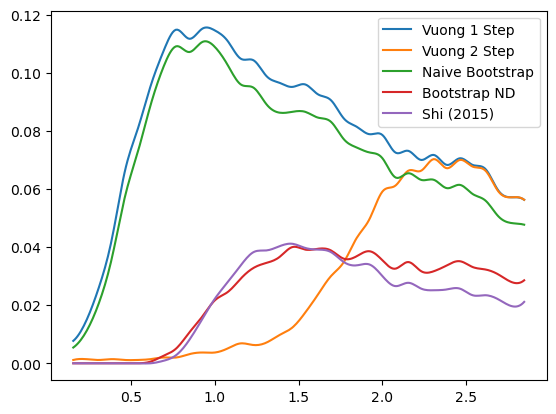

0.001 2.51188643150958


In [7]:
data_tuned_c = .9
calc_c =lambda nobs: (nobs**(-1/2)/100,nobs**(1/5) )
nobs=100
c1,c2 = calc_c(nobs)


mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# Power stuff

Quantiles: 1th: 0.64, 5th: 4.17, 10th: 13.35, 30th: 105.59, 50th: 297.85, 70th: 705.25, 90th: 1743.37, 95th: 2445.41, 99th: 4295.40
bonus term 1.2720454803644323 // variance stats 1.6992325110559428 //part1 2.51188643150958 //part2 0.5064104270032483
0.3348912583596958 -0.19785571719640097 2.234718737983122
-2.209199702369169 -0.19785571719640097 -0.3093722227457423
---
Quantiles: 1th: 0.67, 5th: 3.50, 10th: 10.25, 30th: 90.10, 50th: 274.65, 70th: 653.21, 90th: 1641.78, 95th: 2326.60, 99th: 4075.99
bonus term 0.9368290140216369 // variance stats 2.760267678101913 //part1 2.51188643150958 //part2 0.37295834806457645
-0.19243139926375794 0.047553054367910845 2.3030231019846505
-2.0660894273070314 0.047553054367910845 0.42936507394137663
---
Quantiles: 1th: 0.81, 5th: 5.46, 10th: 16.27, 30th: 140.11, 50th: 447.67, 70th: 1047.04, 90th: 2559.67, 95th: 3590.32, 99th: 6100.33
bonus term 0.9156893069855289 // variance stats 4.461927679998868 //part1 2.51188643150958 //part2 0.3645424791101017


-0.8262625042200786 0.3338352374550114 2.0932569663134837
-2.1063855988202733 0.3338352374550114 0.8131338717132892
---
Quantiles: 1th: 0.33, 5th: 2.73, 10th: 9.07, 30th: 81.43, 50th: 273.79, 70th: 644.23, 90th: 1698.92, 95th: 2367.84, 99th: 4031.72
bonus term 0.7829477585951282 // variance stats 3.7516263989014065 //part1 2.51188643150958 //part2 0.3116971168655091
-0.6532942969648283 0.31305612145317235 2.099899391411408
-2.2191898141550848 0.31305612145317235 0.5340038742211513
---
Quantiles: 1th: 0.63, 5th: 3.81, 10th: 11.40, 30th: 89.57, 50th: 261.20, 70th: 578.55, 90th: 1429.04, 95th: 2091.78, 99th: 3183.03
bonus term 1.0249715049858499 // variance stats 2.0730863586461594 //part1 2.51188643150958 //part2 0.40804850574787643
-0.08726591976327785 -0.05400535900768162 2.141235786046586
-2.1372089297349772 -0.05400535900768162 0.09129277607488623
---
Quantiles: 1th: 0.54, 5th: 3.61, 10th: 12.42, 30th: 105.31, 50th: 304.12, 70th: 729.27, 90th: 1870.49, 95th: 2679.70, 99th: 4501.05
bo

Quantiles: 1th: 0.43, 5th: 2.87, 10th: 8.64, 30th: 72.22, 50th: 220.05, 70th: 508.62, 90th: 1253.96, 95th: 1746.71, 99th: 3160.66
bonus term 0.6216313029631337 // variance stats 3.8130319603705543 //part1 2.51188643150958 //part2 0.247475879150137
-0.9296292827832993 0.4478720921663896 2.1017750704635145
-2.1728918887095667 0.4478720921663896 0.858512464537247
---
Quantiles: 1th: 0.61, 5th: 5.06, 10th: 15.51, 30th: 149.30, 50th: 457.42, 70th: 1102.71, 90th: 2809.84, 95th: 4092.01, 99th: 6924.92
bonus term 1.7978343627453273 // variance stats 1.1159949226059942 //part1 2.51188643150958 //part2 0.715730751276392
1.2578876391452407 -0.3917894220757685 2.3251304318219086
-2.3377810863454136 -0.3917894220757685 -1.270538293668746
---
Quantiles: 1th: 0.60, 5th: 3.65, 10th: 10.96, 30th: 101.08, 50th: 300.49, 70th: 696.78, 90th: 1724.59, 95th: 2457.96, 99th: 4398.35
bonus term 0.9033316910293109 // variance stats 3.0709662870965095 //part1 2.51188643150958 //part2 0.35962282358698494
-0.388878

1.6798029621169266 -0.5208689662741043 2.39225906459823
-2.429837570608058 -0.5208689662741043 -1.7173814681267547
---
Quantiles: 1th: 0.37, 5th: 2.64, 10th: 7.07, 30th: 61.42, 50th: 182.11, 70th: 420.67, 90th: 1076.70, 95th: 1535.22, 99th: 2515.32
bonus term 0.875165900908584 // variance stats 2.0136223945555343 //part1 2.51188643150958 //part2 0.34840982057561876
-0.26508104434180957 -0.06113631673818034 2.2113012546586686
-2.0154128461589775 -0.06113631673818034 0.4609694528415004
---
Quantiles: 1th: 0.42, 5th: 3.05, 10th: 9.68, 30th: 87.59, 50th: 267.72, 70th: 632.30, 90th: 1556.38, 95th: 2202.70, 99th: 3715.17
bonus term 1.8886822867368702 // variance stats 0.5135541340713624 //part1 2.51188643150958 //part2 0.7518979612473243
1.436766008859403 -0.6281748508594808 2.386785005206953
-2.3405985646143375 -0.6281748508594808 -1.3905795682667876
---
Quantiles: 1th: 0.44, 5th: 2.76, 10th: 8.41, 30th: 72.18, 50th: 225.82, 70th: 532.42, 90th: 1309.30, 95th: 1935.07, 99th: 3423.84
bonus te

Quantiles: 1th: 0.45, 5th: 3.01, 10th: 7.36, 30th: 60.69, 50th: 191.45, 70th: 460.24, 90th: 1220.99, 95th: 1707.30, 99th: 2779.40
bonus term 1.275139974347566 // variance stats 1.1842291625122838 //part1 2.51188643150958 //part2 0.5076423672471686
0.3562987338409539 -0.4691729107188627 2.2471154830259232
-2.193981214854178 -0.4691729107188627 -0.30316446566920846
---
Quantiles: 1th: 0.49, 5th: 2.98, 10th: 10.35, 30th: 83.28, 50th: 267.07, 70th: 631.26, 90th: 1571.19, 95th: 2211.23, 99th: 4031.23
bonus term 2.083354162638543 // variance stats 0.3231825262276319 //part1 2.51188643150958 //part2 0.8293982309488808
1.7249555817990774 -0.8459056734461229 2.442943099971889
-2.4417527434780086 -0.8459056734461229 -1.7237652253051967
---
Quantiles: 1th: 0.74, 5th: 5.32, 10th: 15.53, 30th: 133.43, 50th: 425.19, 70th: 961.04, 90th: 2327.59, 95th: 3312.44, 99th: 5599.88
bonus term 1.4704981539362008 // variance stats 1.648368315268478 //part1 2.51188643150958 //part2 0.585415859367682
0.627521465

1.985978748378134 -0.8710790132497497 2.4543336823172304
-2.4312291878848926 -0.8710790132497497 -1.9628742539457962
---
Quantiles: 1th: 0.56, 5th: 4.22, 10th: 14.46, 30th: 118.05, 50th: 365.00, 70th: 886.70, 90th: 2271.09, 95th: 3108.98, 99th: 5143.49
bonus term 1.622288698381736 // variance stats 1.2453748540353369 //part1 2.51188643150958 //part2 0.6458447635336688
0.902413405997198 -0.43810063863546844 2.318032083989426
-2.342163990766274 -0.43810063863546844 -0.9265453127740462
---
Quantiles: 1th: 0.57, 5th: 4.08, 10th: 10.97, 30th: 100.42, 50th: 301.90, 70th: 710.03, 90th: 1792.80, 95th: 2548.84, 99th: 4370.78
bonus term 1.0173999567786705 // variance stats 2.633499104624332 //part1 2.51188643150958 //part2 0.4050342181144069
-0.10187495215752795 -0.09562685605242498 2.1910058604784233
-2.136674865714869 -0.09562685605242498 0.15620594692108267
---
Quantiles: 1th: 0.58, 5th: 4.39, 10th: 13.29, 30th: 127.46, 50th: 388.51, 70th: 970.78, 90th: 2538.16, 95th: 3456.70, 99th: 6084.57
b

Quantiles: 1th: 0.72, 5th: 3.95, 10th: 12.45, 30th: 104.67, 50th: 324.92, 70th: 770.32, 90th: 1954.45, 95th: 2750.53, 99th: 4861.20
bonus term 0.862402682435131 // variance stats 3.7382005808138596 //part1 2.51188643150958 //part2 0.3433286917819962
-0.3829558823888847 0.17224435657841006 2.216271791909496
-2.1077612472591465 0.17224435657841006 0.4914664270392344
---
Quantiles: 1th: 0.58, 5th: 2.84, 10th: 7.65, 30th: 64.52, 50th: 187.37, 70th: 441.12, 90th: 1092.33, 95th: 1564.35, 99th: 2650.04
bonus term 0.49209993942755315 // variance stats 4.4833906503195955 //part1 2.51188643150958 //part2 0.19590851451505056
-1.2076572891218815 0.6605066853115275 2.1531738459780967
-2.191857167976988 0.6605066853115275 1.1689739671229904
---
Quantiles: 1th: 0.69, 5th: 4.64, 10th: 13.05, 30th: 108.11, 50th: 332.03, 70th: 803.75, 90th: 2114.34, 95th: 2981.16, 99th: 5246.38
bonus term 1.2002512345602507 // variance stats 2.310550561233301 //part1 2.51188643150958 //part2 0.47782862294412337
0.178048

-0.018425763816308904 -0.1610966635180398 2.221117154299884
-2.1525614335225347 -0.1610966635180398 0.08698148459365775
---
Quantiles: 1th: 0.73, 5th: 4.98, 10th: 15.44, 30th: 143.54, 50th: 432.29, 70th: 1069.19, 90th: 2599.95, 95th: 3665.92, 99th: 6378.25
bonus term 1.9806941991740528 // variance stats 0.6972681231615419 //part1 2.51188643150958 //part2 0.7885285633649073
1.5643003805297742 -0.8406064180022385 2.3807403781423018
-2.3970880178183314 -0.8406064180022385 -1.5806480202058037
---
Quantiles: 1th: 0.65, 5th: 3.84, 10th: 10.51, 30th: 100.32, 50th: 297.66, 70th: 705.63, 90th: 1804.69, 95th: 2491.89, 99th: 4228.99
bonus term 1.2808047516866172 // variance stats 1.734631127883634 //part1 2.51188643150958 //part2 0.5098975557254338
0.27368321119467964 -0.5182125642473578 2.157679252576737
-2.2879262921785544 -0.5182125642473578 -0.40393025079649736
---
Quantiles: 1th: 0.48, 5th: 3.50, 10th: 9.44, 30th: 77.72, 50th: 237.56, 70th: 561.32, 90th: 1428.05, 95th: 2038.97, 99th: 3387.08

Quantiles: 1th: 0.56, 5th: 4.27, 10th: 11.49, 30th: 93.31, 50th: 286.88, 70th: 678.51, 90th: 1685.81, 95th: 2355.45, 99th: 3901.63
bonus term 1.5809174080605561 // variance stats 0.992739758527114 //part1 2.51188643150958 //part2 0.6293745562017566
0.833544186845199 -0.687321107746119 2.2938629275084446
-2.3282906292759136 -0.687321107746119 -0.8679718886126675
---
Quantiles: 1th: 0.60, 5th: 4.33, 10th: 13.91, 30th: 117.10, 50th: 354.55, 70th: 843.03, 90th: 2119.89, 95th: 3099.01, 99th: 5161.36
bonus term 1.5853887506176936 // variance stats 1.238859394965948 //part1 2.51188643150958 //part2 0.631154629735754
0.8967025790775939 -0.771079052685909 2.3499012856557755
-2.2740749221577934 -0.771079052685909 -0.8208762155796117
---
Quantiles: 1th: 0.35, 5th: 2.52, 10th: 6.95, 30th: 61.88, 50th: 183.44, 70th: 436.82, 90th: 1145.46, 95th: 1583.22, 99th: 2830.11
bonus term 0.6837243538376933 // variance stats 3.0627716374421974 //part1 2.51188643150958 //part2 0.27219556794484223
-0.6770209781

0.21465856258553712 -0.35924009611122465 2.2043897697276447
-2.2688942761752986 -0.35924009611122465 -0.27916306903319144
---
Quantiles: 1th: 0.47, 5th: 4.22, 10th: 12.44, 30th: 98.90, 50th: 289.18, 70th: 678.27, 90th: 1673.02, 95th: 2395.90, 99th: 4195.98
bonus term 1.5442738515689332 // variance stats 1.0482809238087472 //part1 2.51188643150958 //part2 0.6147864936078593
0.7494157623582287 -1.518636590572008 2.335567356680583
-2.339131940779638 -1.518636590572008 -0.752980346457283
---
Quantiles: 1th: 0.59, 5th: 3.89, 10th: 11.72, 30th: 98.07, 50th: 283.62, 70th: 648.85, 90th: 1672.25, 95th: 2436.86, 99th: 3974.07
bonus term 2.030473494266438 // variance stats 0.39648062217495583 //part1 2.51188643150958 //part2 0.8083460576862844
1.6382283670353899 -0.8833005811609856 2.3917320898162373
-2.4227186214974865 -0.8833005811609856 -1.6692148987166386
---
Quantiles: 1th: 0.64, 5th: 4.98, 10th: 14.72, 30th: 132.49, 50th: 410.79, 70th: 977.39, 90th: 2484.81, 95th: 3571.49, 99th: 5926.34
bon

Quantiles: 1th: 0.71, 5th: 3.73, 10th: 10.95, 30th: 102.18, 50th: 298.17, 70th: 699.14, 90th: 1763.17, 95th: 2420.24, 99th: 4377.83
bonus term 0.963763588954064 // variance stats 2.8322372971958534 //part1 2.51188643150958 //part2 0.38368119548098617
-0.24931594018383466 -0.34988082394060604 2.1784302809056144
-2.1768431180919627 -0.34988082394060604 0.2509031029974864
---
Quantiles: 1th: 0.37, 5th: 3.04, 10th: 11.74, 30th: 101.13, 50th: 321.58, 70th: 756.48, 90th: 1841.97, 95th: 2587.28, 99th: 4479.95
bonus term 1.7834164570682167 // variance stats 0.7523855259722558 //part1 2.51188643150958 //part2 0.7099908796419704
1.2338082052973973 -1.5357961291070894 2.3469329077015932
-2.3330247088390363 -1.5357961291070894 -1.2199000064348402
---
Quantiles: 1th: 0.54, 5th: 3.13, 10th: 7.47, 30th: 58.66, 50th: 172.06, 70th: 388.24, 90th: 980.73, 95th: 1372.16, 99th: 2240.07
bonus term 0.6331830049384172 // variance stats 2.9099125976063727 //part1 2.51188643150958 //part2 0.2520746945385943
-0.

1.1302358247996078 -1.0544719131697649 2.2881003504081847
-2.3045234415643305 -1.0544719131697649 -1.1466589159557534
---
Quantiles: 1th: 0.72, 5th: 4.83, 10th: 15.63, 30th: 126.53, 50th: 393.26, 70th: 913.80, 90th: 2366.52, 95th: 3247.20, 99th: 5705.71
bonus term 1.7821347425852843 // variance stats 0.9690485433799473 //part1 2.51188643150958 //part2 0.7094806199157127
1.2286223188166914 -1.0785795940539191 2.3644945827156105
-2.3356471663538767 -1.0785795940539191 -1.1997749024549584
---
Quantiles: 1th: 0.51, 5th: 3.15, 10th: 8.10, 30th: 67.65, 50th: 219.82, 70th: 521.19, 90th: 1366.11, 95th: 1960.57, 99th: 3377.85
bonus term 1.6027445239650417 // variance stats 0.7749140142258657 //part1 2.51188643150958 //part2 0.6380640875558347
0.922495052580093 -1.452026752278931 2.291414874037067
-2.2829939953499907 -1.452026752278931 -0.9140741738930167
---
Quantiles: 1th: 0.67, 5th: 4.15, 10th: 13.28, 30th: 112.41, 50th: 341.16, 70th: 848.18, 90th: 2050.19, 95th: 2849.42, 99th: 4859.22
bonus 

Quantiles: 1th: 0.44, 5th: 2.87, 10th: 9.02, 30th: 79.08, 50th: 233.39, 70th: 535.20, 90th: 1350.34, 95th: 1997.83, 99th: 3407.13
bonus term 0.6876530671808799 // variance stats 3.582224083821667 //part1 2.51188643150958 //part2 0.2737596168978141
-0.738743403693993 -0.060223576641944936 2.049276172049607
-2.114049538055753 -0.060223576641944936 0.6739700376878471
---
Quantiles: 1th: 0.55, 5th: 3.31, 10th: 9.37, 30th: 74.73, 50th: 221.88, 70th: 532.76, 90th: 1282.36, 95th: 1891.38, 99th: 3161.00
bonus term 0.7203347012376264 // variance stats 3.1893666412229686 //part1 2.51188643150958 //part2 0.2867704097612102
-0.6759302114960748 -0.3580767571829501 2.21268859655805
-2.116599613971328 -0.3580767571829501 0.7720191940827974
---
Quantiles: 1th: 0.38, 5th: 3.37, 10th: 11.79, 30th: 108.71, 50th: 318.96, 70th: 773.50, 90th: 2023.96, 95th: 2756.96, 99th: 4855.31
bonus term 0.9824322788289711 // variance stats 3.150900890934661 //part1 2.51188643150958 //part2 0.39111333478502613
-0.1719281

1.1766335506646788 -1.1361423719205899 2.3946595045144656
-2.2927169292011866 -1.1361423719205899 -1.0746909753513998
---
Quantiles: 1th: 0.33, 5th: 2.08, 10th: 6.57, 30th: 55.94, 50th: 180.12, 70th: 426.69, 90th: 1062.61, 95th: 1524.03, 99th: 2493.56
bonus term 0.5147556803126453 // variance stats 4.122669912006616 //part1 2.51188643150958 //part2 0.20492792741560778
-1.119377039578878 -0.050759122806697546 2.038357917002596
-2.148888400204169 -0.050759122806697546 1.008846556377306
---
Quantiles: 1th: 0.64, 5th: 4.29, 10th: 12.83, 30th: 88.77, 50th: 262.31, 70th: 614.52, 90th: 1571.86, 95th: 2181.26, 99th: 3904.32
bonus term 1.7597285518714318 // variance stats 0.6718593310734945 //part1 2.51188643150958 //part2 0.7005605547277388
1.1776565367562513 -1.4638275049456102 2.3531144331113536
-2.3418005669866124 -1.4638275049456102 -1.16634267063151
---
Quantiles: 1th: 0.47, 5th: 2.62, 10th: 7.20, 30th: 69.62, 50th: 228.85, 70th: 541.77, 90th: 1367.63, 95th: 1902.61, 99th: 3157.66
bonus t

Quantiles: 1th: 0.50, 5th: 3.23, 10th: 9.15, 30th: 81.26, 50th: 228.00, 70th: 553.84, 90th: 1365.80, 95th: 1866.37, 99th: 3070.53
bonus term 1.0021583168490276 // variance stats 2.057552711054391 //part1 2.51188643150958 //part2 0.39896641196742155
-0.23069294226489845 -1.123580956596571 2.2728164193024023
-2.2350095759629536 -1.123580956596571 0.2684997856043471
---
Quantiles: 1th: 0.43, 5th: 2.84, 10th: 8.60, 30th: 81.55, 50th: 242.35, 70th: 562.06, 90th: 1428.76, 95th: 2069.03, 99th: 3585.72
bonus term 0.7562866166377792 // variance stats 3.3166312113919285 //part1 2.51188643150958 //part2 0.30108312507714374
-0.6413901855589724 -0.5111407540460923 2.169614704796747
-2.1539634188345307 -0.5111407540460923 0.6570414715211883
---
Quantiles: 1th: 0.59, 5th: 3.37, 10th: 10.40, 30th: 101.22, 50th: 325.79, 70th: 785.21, 90th: 1979.31, 95th: 2823.29, 99th: 5131.73
bonus term 0.8748128759809171 // variance stats 3.7039575434581153 //part1 2.51188643150958 //part2 0.34826927882053044
-0.4952

0.34956700276265135 -1.7233999308294343 2.2125937082692557
-2.311861282526859 -1.7233999308294343 -0.4488345770202548
---
Quantiles: 1th: 0.46, 5th: 3.01, 10th: 8.56, 30th: 69.56, 50th: 228.77, 70th: 532.12, 90th: 1278.90, 95th: 1828.50, 99th: 3018.43
bonus term 1.0115152568892327 // variance stats 1.8969737155092632 //part1 2.51188643150958 //part2 0.40269147689186635
-0.1636194323787693 -1.2870113006889246 2.1802314825155036
-2.186649946157235 -1.2870113006889246 0.15720096873703798
---
Quantiles: 1th: 0.50, 5th: 3.61, 10th: 12.81, 30th: 125.09, 50th: 364.14, 70th: 866.38, 90th: 2107.42, 95th: 3048.94, 99th: 5142.63
bonus term 1.0295364641798153 // variance stats 3.0343125081846325 //part1 2.51188643150958 //part2 0.40986584873627824
-0.1774775843493561 -0.7374343757441341 2.181989391645943
-2.2365505127089866 -0.7374343757441341 0.12291646328631238
---
Quantiles: 1th: 0.54, 5th: 3.91, 10th: 9.20, 30th: 78.27, 50th: 234.25, 70th: 571.12, 90th: 1428.75, 95th: 2063.81, 99th: 3513.68
bo

Quantiles: 1th: 0.49, 5th: 3.51, 10th: 10.46, 30th: 99.95, 50th: 279.14, 70th: 653.26, 90th: 1705.50, 95th: 2433.91, 99th: 4284.39
bonus term 1.130938067237565 // variance stats 2.082530305899929 //part1 2.51188643150958 //part2 0.4502345540191878
0.027005490608031913 -1.2267563585448915 2.1928133485954335
-2.234870643867098 -1.2267563585448915 -0.0690627858796964
---
Quantiles: 1th: 0.38, 5th: 3.07, 10th: 8.93, 30th: 79.86, 50th: 231.23, 70th: 526.93, 90th: 1335.70, 95th: 1871.88, 99th: 3300.21
bonus term 0.6354036838558222 // variance stats 3.9446095294398718 //part1 2.51188643150958 //part2 0.2529587627391103
-0.8093995740688583 -0.3474767602955952 2.1425863733630823
-2.0802069417805025 -0.3474767602955952 0.8717790056514377
---
Quantiles: 1th: 0.52, 5th: 3.46, 10th: 9.97, 30th: 90.13, 50th: 266.52, 70th: 634.79, 90th: 1618.34, 95th: 2310.23, 99th: 3989.79
bonus term 0.7281974378875027 // variance stats 3.9640531467101514 //part1 2.51188643150958 //part2 0.28990062160169977
-0.64786

0.1724783553564989 -1.2139679477735237 2.191645649263186
-2.287198222273586 -1.2139679477735237 -0.26803092836689835
---
Quantiles: 1th: 0.37, 5th: 2.56, 10th: 7.36, 30th: 59.16, 50th: 185.54, 70th: 432.54, 90th: 1114.79, 95th: 1571.24, 99th: 2758.89
bonus term 0.7076344444030062 // variance stats 2.842381818147322 //part1 2.51188643150958 //part2 0.28171434644747684
-0.714814412432307 -1.385183077906584 2.0525589959424124
-2.130083301238319 -1.385183077906584 0.6372901071364
---
Quantiles: 1th: 0.53, 5th: 3.95, 10th: 11.67, 30th: 94.19, 50th: 287.92, 70th: 697.74, 90th: 1830.44, 95th: 2620.95, 99th: 4348.29
bonus term 0.9535522110407062 // variance stats 2.9913732692212163 //part1 2.51188643150958 //part2 0.3796159727124468
-0.3210477086117679 -1.288259515309025 2.2360724872029154
-2.2281521306931804 -1.288259515309025 0.328968065121503
---
Quantiles: 1th: 0.61, 5th: 5.02, 10th: 16.65, 30th: 156.71, 50th: 480.09, 70th: 1137.42, 90th: 2866.02, 95th: 4043.41, 99th: 7128.31
bonus term 1.

Quantiles: 1th: 0.52, 5th: 4.43, 10th: 16.04, 30th: 135.83, 50th: 403.72, 70th: 964.25, 90th: 2391.42, 95th: 3324.61, 99th: 5914.92
bonus term 1.333699867905769 // variance stats 2.1125766733751146 //part1 2.51188643150958 //part2 0.5309554807795387
0.42487809202839893 -1.3905557364790155 2.2664414194725504
-2.2425216437831392 -1.3905557364790155 -0.40095831633898765
---
Quantiles: 1th: 0.62, 5th: 3.49, 10th: 9.43, 30th: 75.44, 50th: 235.50, 70th: 553.68, 90th: 1444.12, 95th: 2056.35, 99th: 3520.37
bonus term 1.1615765117586454 // variance stats 1.678757722445715 //part1 2.51188643150958 //part2 0.4624319384776354
0.1394299453257113 -2.007079036081976 2.252555247352031
-2.1837230781915795 -2.007079036081976 -0.07059777616525997
---
Quantiles: 1th: 0.46, 5th: 3.02, 10th: 7.72, 30th: 57.35, 50th: 168.60, 70th: 419.46, 90th: 1091.50, 95th: 1542.21, 99th: 2607.64
bonus term 0.6219254612068292 // variance stats 3.3169521288860886 //part1 2.51188643150958 //part2 0.24759298565622959
-0.83843

-0.058947594023472535 -2.2863936874159574 2.0838511717417494
-2.233441361231898 -2.2863936874159574 -0.09064259546667582
---
Quantiles: 1th: 0.53, 5th: 3.36, 10th: 9.68, 30th: 79.01, 50th: 245.68, 70th: 578.34, 90th: 1388.76, 95th: 2050.66, 99th: 3569.50
bonus term 0.6995130539036747 // variance stats 3.5981481065934027 //part1 2.51188643150958 //part2 0.2784811626548279
-0.737227869848093 -0.9281310375140994 2.1008143938240127
-2.136253977655443 -0.9281310375140994 0.7017882860166633
---
Quantiles: 1th: 0.61, 5th: 4.16, 10th: 11.64, 30th: 87.08, 50th: 265.38, 70th: 628.58, 90th: 1567.58, 95th: 2187.98, 99th: 3820.75
bonus term 1.1021114969396153 // variance stats 2.0051844854200045 //part1 2.51188643150958 //part2 0.4387584896811096
-0.010612267430277388 -2.3885106601729538 2.237608176234489
-2.214835261309508 -2.3885106601729538 0.03338518235525832
---
Quantiles: 1th: 0.63, 5th: 3.41, 10th: 9.24, 30th: 67.22, 50th: 192.45, 70th: 444.46, 90th: 1099.95, 95th: 1525.47, 99th: 2600.17
bon

Quantiles: 1th: 0.71, 5th: 4.39, 10th: 12.95, 30th: 140.63, 50th: 435.34, 70th: 988.25, 90th: 2427.03, 95th: 3362.17, 99th: 5868.44
bonus term 1.5249146038309647 // variance stats 1.5708481469214781 //part1 2.51188643150958 //part2 0.6070794382668526
0.7762187478897411 -2.707466404004172 2.2618141684728514
-2.2736104597721885 -2.707466404004172 -0.7880150391890779
---
Quantiles: 1th: 0.48, 5th: 3.37, 10th: 13.55, 30th: 124.83, 50th: 356.98, 70th: 887.48, 90th: 2257.18, 95th: 3246.14, 99th: 5439.30
bonus term 0.6946405301736239 // variance stats 5.905005772233051 //part1 2.51188643150958 //part2 0.27654137601920264
-0.7036100427891596 -0.12863059422991566 2.0929588067018132
-2.0928911031364072 -0.12863059422991566 0.7036777463545654
---
Quantiles: 1th: 0.43, 5th: 2.65, 10th: 9.03, 30th: 75.25, 50th: 213.87, 70th: 498.41, 90th: 1213.14, 95th: 1698.40, 99th: 2751.01
bonus term 1.2881208954654728 // variance stats 1.1525327497720643 //part1 2.51188643150958 //part2 0.5128101650245965
0.355

0.9368977293976724 -3.1749128793014374 2.368395403490538
-2.397876443711463 -3.1749128793014374 -0.9663787696185971
---
Quantiles: 1th: 0.81, 5th: 4.91, 10th: 15.44, 30th: 127.49, 50th: 381.34, 70th: 873.94, 90th: 2146.83, 95th: 3091.10, 99th: 5386.78
bonus term 1.2633902745882215 // variance stats 2.1215224119395333 //part1 2.51188643150958 //part2 0.5029647275211229
0.1814614670016807 -1.5325853682799677 2.343316757266073
-2.3453190821747625 -1.5325853682799677 -0.18346379191036968
---
Quantiles: 1th: 0.64, 5th: 3.64, 10th: 11.66, 30th: 92.07, 50th: 278.81, 70th: 657.67, 90th: 1634.15, 95th: 2305.15, 99th: 3886.91
bonus term 1.2885475212017035 // variance stats 1.5514555188526522 //part1 2.51188643150958 //part2 0.5129800077893327
0.18829680899091158 -2.8031007818704436 2.2969657454905974
-2.3887982334124955 -2.8031007818704436 -0.28012929691280974
---
Quantiles: 1th: 0.43, 5th: 2.95, 10th: 8.35, 30th: 73.44, 50th: 229.75, 70th: 534.43, 90th: 1331.22, 95th: 1893.41, 99th: 3088.91
bon

Quantiles: 1th: 0.56, 5th: 3.80, 10th: 11.64, 30th: 104.42, 50th: 305.11, 70th: 683.98, 90th: 1705.12, 95th: 2485.71, 99th: 4480.83
bonus term 1.4245765341684227 // variance stats 1.3014318755469567 //part1 2.51188643150958 //part2 0.5671341332546982
0.5072847302309277 -3.2496440240510585 2.2754288979984576
-2.3418683381059178 -3.2496440240510585 -0.5737241703383877
---
Quantiles: 1th: 0.60, 5th: 3.72, 10th: 12.29, 30th: 102.00, 50th: 315.44, 70th: 760.53, 90th: 1910.41, 95th: 2673.12, 99th: 4638.24
bonus term 1.3730369632897943 // variance stats 1.5845677825544207 //part1 2.51188643150958 //part2 0.5466158605206661
0.500819641994324 -2.261405290751123 2.3186851920729556
-2.2452542845852643 -2.261405290751123 -0.4273887345066329
---
Quantiles: 1th: 0.59, 5th: 4.14, 10th: 15.34, 30th: 120.61, 50th: 364.27, 70th: 869.06, 90th: 2117.35, 95th: 3121.11, 99th: 5449.48
bonus term 0.765486404895129 // variance stats 4.83057460088215 //part1 2.51188643150958 //part2 0.3047456267499685
-0.584625

-0.01573989342786087 -2.7209144931867835 2.1940107653341006
-2.273959419419547 -2.7209144931867835 -0.06420876065758585
---
Quantiles: 1th: 0.76, 5th: 5.64, 10th: 16.67, 30th: 136.65, 50th: 391.35, 70th: 932.55, 90th: 2297.58, 95th: 3282.97, 99th: 5300.46
bonus term 0.9759878004334346 // variance stats 3.6156767924647575 //part1 2.51188643150958 //part2 0.38854774172528594
-0.23411273496474758 -1.7261419494742274 2.151365312820794
-2.1860883358316165 -1.7261419494742274 0.19938971195392474
---
Quantiles: 1th: 0.44, 5th: 2.90, 10th: 7.88, 30th: 68.99, 50th: 208.29, 70th: 470.64, 90th: 1181.68, 95th: 1694.37, 99th: 2777.07
bonus term 0.6365092706334587 // variance stats 3.4816343186802765 //part1 2.51188643150958 //part2 0.25339890476295646
-0.7287539892209237 -1.7105745350951689 2.078668895885819
-2.001772530487841 -1.7105745350951689 0.8056503546189011
---
Quantiles: 1th: 0.69, 5th: 4.46, 10th: 13.09, 30th: 105.60, 50th: 336.41, 70th: 821.60, 90th: 2016.20, 95th: 2868.23, 99th: 4941.83

Quantiles: 1th: 0.52, 5th: 3.01, 10th: 9.36, 30th: 83.00, 50th: 256.08, 70th: 597.05, 90th: 1499.96, 95th: 2130.35, 99th: 3904.00
bonus term 1.0802923730002731 // variance stats 1.9877379694470785 //part1 2.51188643150958 //part2 0.430072139985662
-0.03498616279410843 -3.5576831626551693 2.1776473416284787
-2.195570908794655 -3.5576831626551693 0.017062595627932112
---
Quantiles: 1th: 0.47, 5th: 4.44, 10th: 14.20, 30th: 137.73, 50th: 416.91, 70th: 1000.23, 90th: 2482.39, 95th: 3522.90, 99th: 5885.16
bonus term 1.615230078765917 // variance stats 1.378041492046654 //part1 2.51188643150958 //part2 0.6430346764504018
0.8348520448931096 -3.16117350659287 2.300713045357245
-2.3956081126387248 -3.16117350659287 -0.9297471121745895
---
Quantiles: 1th: 0.45, 5th: 3.32, 10th: 10.16, 30th: 90.93, 50th: 267.34, 70th: 628.91, 90th: 1608.33, 95th: 2272.07, 99th: 4016.17
bonus term 1.0104687519882307 // variance stats 2.3897502108517896 //part1 2.51188643150958 //part2 0.40227485578675803
-0.2232764

-1.131918229848228 -1.702460310147672 2.0168631598273117
-2.105326102398067 -1.702460310147672 1.0434552872774723
---
Quantiles: 1th: 0.47, 5th: 3.15, 10th: 11.01, 30th: 102.13, 50th: 303.65, 70th: 725.27, 90th: 1743.97, 95th: 2477.52, 99th: 4421.31
bonus term 0.843594597490403 // variance stats 3.448880606169059 //part1 2.51188643150958 //part2 0.33584105830112077
-0.4910213790398816 -1.8147007605276364 2.016085722819523
-2.178210574020688 -1.8147007605276364 0.3288965278387171
---
Quantiles: 1th: 0.66, 5th: 4.50, 10th: 11.56, 30th: 80.46, 50th: 236.76, 70th: 567.57, 90th: 1372.20, 95th: 1946.76, 99th: 3549.59
bonus term 0.8973190530832869 // variance stats 2.469038824491554 //part1 2.51188643150958 //part2 0.3572291493067308
-0.3948459278185103 -3.6257618983209 2.1604070141047558
-2.189484033985084 -3.6257618983209 0.36576890793818173
---
Quantiles: 1th: 0.55, 5th: 3.18, 10th: 10.18, 30th: 103.67, 50th: 327.33, 70th: 745.91, 90th: 1812.39, 95th: 2610.11, 99th: 4511.14
bonus term 1.09

Quantiles: 1th: 0.47, 5th: 3.21, 10th: 10.63, 30th: 87.26, 50th: 276.29, 70th: 656.75, 90th: 1721.53, 95th: 2404.83, 99th: 3907.65
bonus term 1.0386199775755514 // variance stats 2.4419686016553976 //part1 2.51188643150958 //part2 0.4134820605529395
-0.2090509071924543 -2.9291833413688235 2.300955638825411
-2.286290862343557 -2.9291833413688235 0.2237156836743081
---
Quantiles: 1th: 0.23, 5th: 1.82, 10th: 4.88, 30th: 43.70, 50th: 139.30, 70th: 325.50, 90th: 793.84, 95th: 1088.74, 99th: 1817.07
bonus term 0.8925101848567554 // variance stats 1.4403467817520996 //part1 2.51188643150958 //part2 0.35531470438350166
-0.634273813652009 -5.274076352138221 2.3103625440308018
-2.41929418336552 -5.274076352138221 0.525342174317291
---
Quantiles: 1th: 0.43, 5th: 3.02, 10th: 9.63, 30th: 83.91, 50th: 271.44, 70th: 628.43, 90th: 1522.64, 95th: 2188.70, 99th: 3745.84
bonus term 0.9841221795934225 // variance stats 2.3637614830220044 //part1 2.51188643150958 //part2 0.3917860963968781
-0.2640806146917

-0.44250184026718065 -5.024306045041414 2.196078103593838
-2.399708382146511 -5.024306045041414 0.23887156171450788
---
Quantiles: 1th: 0.27, 5th: 1.88, 10th: 4.95, 30th: 40.04, 50th: 119.77, 70th: 287.26, 90th: 759.84, 95th: 1088.17, 99th: 1749.62
bonus term 0.7786109752562062 // variance stats 1.6914986930696172 //part1 2.51188643150958 //part2 0.3099706123211473
-0.6623284792869616 -4.384059799610139 2.173640105500302
-2.219550429799374 -4.384059799610139 0.6164181549878899
---
Quantiles: 1th: 0.30, 5th: 2.35, 10th: 7.45, 30th: 63.22, 50th: 183.40, 70th: 427.29, 90th: 1082.24, 95th: 1565.04, 99th: 2681.46
bonus term 0.6573815714444259 // variance stats 3.0530600367114245 //part1 2.51188643150958 //part2 0.2617083173817521
-0.7538454832507651 -3.3166272096101816 2.043142729319041
-2.068608626139617 -3.3166272096101816 0.7283795864301892
---
Quantiles: 1th: 0.50, 5th: 4.16, 10th: 12.53, 30th: 100.99, 50th: 293.91, 70th: 722.35, 90th: 1779.19, 95th: 2663.26, 99th: 4579.05
bonus term 1.

Quantiles: 1th: 0.69, 5th: 3.14, 10th: 9.68, 30th: 96.73, 50th: 294.44, 70th: 729.82, 90th: 1763.36, 95th: 2565.95, 99th: 4338.72
bonus term 1.3582798777098206 // variance stats 1.497644477950727 //part1 2.51188643150958 //part2 0.540740958934807
0.3446106688710342 -4.2952321231909565 2.2998680930779893
-2.3719490865486073 -4.2952321231909565 -0.41669166234165195
---
Quantiles: 1th: 0.43, 5th: 3.29, 10th: 8.77, 30th: 76.18, 50th: 231.75, 70th: 544.93, 90th: 1388.57, 95th: 1987.33, 99th: 3314.24
bonus term 0.8589809463159749 // variance stats 2.671976200421999 //part1 2.51188643150958 //part2 0.34196647409721825
-0.5336993161708953 -3.393495106067333 2.1450940029639582
-2.251661208802845 -3.393495106067333 0.42713211033200865
---
Quantiles: 1th: 0.65, 5th: 4.64, 10th: 12.50, 30th: 110.36, 50th: 316.09, 70th: 741.94, 90th: 1912.77, 95th: 2789.02, 99th: 4574.21
bonus term 1.1137142697022198 // variance stats 2.4013134866341193 //part1 2.51188643150958 //part2 0.4433776367162052
-0.1072538

0.581169105473107 -4.008386358977925 2.278171921743207
-2.420358766331187 -4.008386358977925 -0.7233559500610875
---
Quantiles: 1th: 0.66, 5th: 4.88, 10th: 18.50, 30th: 171.03, 50th: 493.44, 70th: 1210.99, 90th: 3060.62, 95th: 4363.05, 99th: 7592.88
bonus term 1.4874627143739867 // variance stats 2.1078668468023696 //part1 2.51188643150958 //part2 0.5921695725232528
0.6896923196498238 -3.3026629324066317 2.2766955105078495
-2.2852331090981495 -3.3026629324066317 -0.6982299182401243
---
Quantiles: 1th: 0.48, 5th: 3.01, 10th: 8.47, 30th: 81.53, 50th: 245.93, 70th: 566.77, 90th: 1464.18, 95th: 2081.75, 99th: 3761.63
bonus term 1.07869173548365 // variance stats 1.945370186553384 //part1 2.51188643150958 //part2 0.42943491471283746
-0.024710924655219867 -4.963901285179379 2.245303424071357
-2.18209439562252 -4.963901285179379 0.08791995310405697
---
Quantiles: 1th: 0.68, 5th: 3.49, 10th: 10.18, 30th: 89.97, 50th: 265.61, 70th: 623.99, 90th: 1608.43, 95th: 2318.47, 99th: 3999.28
bonus term 

Quantiles: 1th: 0.50, 5th: 2.70, 10th: 8.71, 30th: 71.05, 50th: 216.20, 70th: 512.05, 90th: 1265.37, 95th: 1789.80, 99th: 3083.46
bonus term 1.0770184486660017 // variance stats 1.685800540867626 //part1 2.51188643150958 //part2 0.428768767232339
-0.09059156107844937 -5.803029063972292 2.1407169717356482
-2.244628458410453 -5.803029063972292 -0.013319925596355253
---
Quantiles: 1th: 0.43, 5th: 3.19, 10th: 10.34, 30th: 85.06, 50th: 257.54, 70th: 603.94, 90th: 1524.54, 95th: 2164.62, 99th: 3669.22
bonus term 1.1090940626037087 // variance stats 1.9282529528099626 //part1 2.51188643150958 //part2 0.44153829914084575
-0.14389138175464608 -5.812364342429872 2.20151372437311
-2.3620795069620635 -5.812364342429872 -0.016674400834307213
---
Quantiles: 1th: 0.35, 5th: 2.75, 10th: 10.65, 30th: 98.95, 50th: 286.86, 70th: 658.41, 90th: 1655.87, 95th: 2367.50, 99th: 4130.30
bonus term 1.0932032169134887 // variance stats 2.1488683931718837 //part1 2.51188643150958 //part2 0.43521203952541004
-0.305

-0.8977966471685043 -2.938298235762911 2.139862192229991
-2.146914522915098 -2.938298235762911 0.8907443164833974
---
Quantiles: 1th: 0.41, 5th: 2.84, 10th: 8.92, 30th: 75.01, 50th: 238.29, 70th: 588.93, 90th: 1480.28, 95th: 2099.37, 99th: 3371.08
bonus term 0.7759074119666199 // variance stats 3.3119038415689546 //part1 2.51188643150958 //part2 0.3088943043895178
-0.5964514876330628 -3.6094251740491097 2.1474469375021292
-2.1482663115663025 -3.6094251740491097 0.5956321135688892
---
Quantiles: 1th: 0.52, 5th: 3.09, 10th: 9.38, 30th: 80.31, 50th: 251.56, 70th: 577.76, 90th: 1474.90, 95th: 2122.81, 99th: 3740.08
bonus term 0.7535137689140196 // variance stats 3.4417764165474853 //part1 2.51188643150958 //part2 0.2999792345154621
-0.6771666213772362 -4.054550657135933 2.1567440172271857
-2.1841941592052754 -4.054550657135933 0.6497164793991466
---
Quantiles: 1th: 0.43, 5th: 2.39, 10th: 7.58, 30th: 62.52, 50th: 184.06, 70th: 427.32, 90th: 1112.50, 95th: 1576.85, 99th: 2755.76
bonus term 0

Quantiles: 1th: 0.24, 5th: 1.76, 10th: 4.97, 30th: 40.42, 50th: 122.81, 70th: 291.85, 90th: 745.94, 95th: 1022.51, 99th: 1834.75
bonus term 0.7494348747334234 // variance stats 1.7542343531674818 //part1 2.51188643150958 //part2 0.2983553974942378
-0.9447587514117308 -8.353433411948194 2.1576835701634782
-2.4436285008785776 -8.353433411948194 0.6588138206966313
---
Quantiles: 1th: 0.45, 5th: 3.14, 10th: 9.83, 30th: 88.49, 50th: 266.53, 70th: 612.94, 90th: 1579.76, 95th: 2295.61, 99th: 3875.17
bonus term 0.7473003272608689 // variance stats 3.7302463900566734 //part1 2.51188643150958 //part2 0.29750561883952703
-0.6864040143207804 -4.096957170539183 2.1648726390366533
-2.1810046688425184 -4.096957170539183 0.6702719845149154
---
Quantiles: 1th: 0.35, 5th: 3.02, 10th: 9.53, 30th: 70.88, 50th: 218.81, 70th: 509.36, 90th: 1355.95, 95th: 1877.98, 99th: 3200.83
bonus term 1.0307079959341092 // variance stats 1.9485742209022863 //part1 2.51188643150958 //part2 0.4103322439281938
-0.3419964823

-0.1813547369525045 -5.620860536184894 2.06794451288617
-2.165143268600367 -5.620860536184894 0.08415598123830771
---
Quantiles: 1th: 0.58, 5th: 3.94, 10th: 10.87, 30th: 87.06, 50th: 262.27, 70th: 616.74, 90th: 1627.22, 95th: 2285.13, 99th: 4153.18
bonus term 0.5638776499906013 // variance stats 5.6215152862623485 //part1 2.51188643150958 //part2 0.22448373577611355
-1.1065201601838506 -2.499820017954657 2.143045183208315
-2.2342754601650534 -2.499820017954657 1.0152898832271122
---
Quantiles: 1th: 0.31, 5th: 2.39, 10th: 7.74, 30th: 64.46, 50th: 198.57, 70th: 463.17, 90th: 1185.75, 95th: 1697.52, 99th: 2963.10
bonus term 0.5238928036621797 // variance stats 4.499500363113442 //part1 2.51188643150958 //part2 0.2085654817392892
-1.2675210371366337 -3.046507987015425 2.0394922499374184
-2.315306644460993 -3.046507987015425 0.9917066426130587
---
Quantiles: 1th: 0.52, 5th: 4.00, 10th: 12.37, 30th: 107.83, 50th: 333.69, 70th: 800.19, 90th: 2038.55, 95th: 2871.88, 99th: 4773.52
bonus term 0.

Quantiles: 1th: 0.55, 5th: 3.71, 10th: 11.63, 30th: 110.31, 50th: 332.89, 70th: 788.85, 90th: 2030.30, 95th: 2804.46, 99th: 4935.58
bonus term 1.2553243091152535 // variance stats 2.0323032369706944 //part1 2.51188643150958 //part2 0.4997536088288973
0.10498525003591369 -5.114232863799715 2.2331113784442023
-2.405663368194593 -5.114232863799715 -0.27753723978630457
---
Quantiles: 1th: 0.40, 5th: 2.44, 10th: 7.51, 30th: 62.21, 50th: 176.54, 70th: 412.41, 90th: 1039.60, 95th: 1475.04, 99th: 2535.24
bonus term 0.48087054725610806 // variance stats 4.390894780493846 //part1 2.51188643150958 //part2 0.19143801297064095
-1.1726196788025174 -2.784108064245147 2.0947302568222828
-2.134360773314733 -2.784108064245147 1.1329891623100665
---
Quantiles: 1th: 0.45, 5th: 3.41, 10th: 11.66, 30th: 103.41, 50th: 317.41, 70th: 738.37, 90th: 1886.71, 95th: 2748.32, 99th: 4710.64
bonus term 0.8577621034628172 // variance stats 3.6383625347470154 //part1 2.51188643150958 //part2 0.34148124401759833
-0.5763

0.042864566323793735 -6.7034075774295605 2.0392787282679223
-2.2039918300244254 -6.7034075774295605 -0.2075776680802969
---
Quantiles: 1th: 0.42, 5th: 2.94, 10th: 9.61, 30th: 86.75, 50th: 277.19, 70th: 643.62, 90th: 1671.28, 95th: 2365.10, 99th: 4146.03
bonus term 1.1965414275910964 // variance stats 1.8372188172099353 //part1 2.51188643150958 //part2 0.4763517221883337
0.023726466307691353 -6.357323278319785 2.22270771470592
-2.3693563888745017 -6.357323278319785 -0.17037514047627317
---
Quantiles: 1th: 0.50, 5th: 4.39, 10th: 12.67, 30th: 121.80, 50th: 373.57, 70th: 873.53, 90th: 2249.34, 95th: 3113.23, 99th: 5460.47
bonus term 0.8268994048367885 // variance stats 4.583514264121264 //part1 2.51188643150958 //part2 0.3291945823919447
-0.6144179792061882 -3.4135510062055254 2.221165629123161
-2.2682167888797653 -3.4135510062055254 0.5673668194495841
---
Quantiles: 1th: 0.55, 5th: 3.06, 10th: 9.66, 30th: 101.74, 50th: 331.78, 70th: 759.54, 90th: 1863.48, 95th: 2673.67, 99th: 4764.28
bonu

Quantiles: 1th: 0.51, 5th: 4.11, 10th: 12.63, 30th: 97.64, 50th: 293.62, 70th: 681.25, 90th: 1671.53, 95th: 2252.93, 99th: 4003.56
bonus term 1.1219082653252541 // variance stats 2.0709305079760485 //part1 2.51188643150958 //part2 0.44663972512921923
-0.1305036291379831 -6.54130047191518 2.2859178285773045
-2.3743201597884913 -6.54130047191518 0.042101297926796316
---
Quantiles: 1th: 0.39, 5th: 2.97, 10th: 8.90, 30th: 80.51, 50th: 254.26, 70th: 619.56, 90th: 1601.31, 95th: 2242.90, 99th: 3905.62
bonus term 0.8446883524114676 // variance stats 3.1605847693765305 //part1 2.51188643150958 //part2 0.33627648997802473
-0.7265600050140356 -4.190585631069025 2.1874489879393195
-2.415936709836971 -4.190585631069025 0.4980722831163844
---
Quantiles: 1th: 0.63, 5th: 3.76, 10th: 11.00, 30th: 87.49, 50th: 276.91, 70th: 697.05, 90th: 1755.80, 95th: 2589.03, 99th: 4412.62
bonus term 0.9120686334250997 // variance stats 3.079771086225177 //part1 2.51188643150958 //part2 0.3631010630034613
-0.56425063

-0.09196180734240746 -5.291791699724151 2.3911437630967947
-2.506318100846133 -5.291791699724151 -0.023212530406930842
---
Quantiles: 1th: 0.57, 5th: 4.61, 10th: 16.48, 30th: 153.07, 50th: 488.69, 70th: 1120.89, 90th: 2757.59, 95th: 4061.46, 99th: 6969.92
bonus term 1.4211147856872903 // variance stats 2.1165781840026163 //part1 2.51188643150958 //part2 0.5657559863617068
0.5000703193954037 -5.234664192968953 2.309544131169193
-2.342159251979177 -5.234664192968953 -0.5326854402053879
---
Quantiles: 1th: 0.60, 5th: 5.02, 10th: 14.09, 30th: 102.23, 50th: 321.83, 70th: 773.08, 90th: 1970.34, 95th: 2786.03, 99th: 4776.53
bonus term 0.7492526290310517 // variance stats 4.635260612940957 //part1 2.51188643150958 //part2 0.29828284417332107
-0.5984018757015284 -3.7938947739109383 1.9896090799606725
-2.096907133763632 -3.7938947739109383 0.4911038218985691
---
Quantiles: 1th: 0.58, 5th: 4.18, 10th: 11.54, 30th: 87.78, 50th: 252.42, 70th: 584.78, 90th: 1444.99, 95th: 2049.84, 99th: 3731.36
bonu

Quantiles: 1th: 0.53, 5th: 4.20, 10th: 13.84, 30th: 115.64, 50th: 358.07, 70th: 824.12, 90th: 2073.00, 95th: 2842.79, 99th: 4548.43
bonus term 1.1961205760906555 // variance stats 2.2803562225372453 //part1 2.51188643150958 //part2 0.47618417818826997
-0.06838567900395924 -5.452427143482154 2.2211608092843864
-2.4606268311852704 -5.452427143482154 -0.1710803428969249
---
Quantiles: 1th: 0.85, 5th: 5.38, 10th: 17.01, 30th: 137.22, 50th: 425.79, 70th: 993.54, 90th: 2635.86, 95th: 3669.05, 99th: 6171.59
bonus term 0.7631993198466516 // variance stats 6.03943090401723 //part1 2.51188643150958 //part2 0.30383512179250405
-0.640457756053849 -3.0541857649449264 2.0320078467249543
-2.166856395747152 -3.0541857649449264 0.5056092070316507
---
Quantiles: 1th: 0.55, 5th: 3.75, 10th: 13.13, 30th: 111.72, 50th: 341.37, 70th: 794.07, 90th: 2093.94, 95th: 2997.97, 99th: 5028.87
bonus term 0.8538727521105943 // variance stats 4.0659223246475005 //part1 2.51188643150958 //part2 0.33993286535547645
-0.6

-1.4105419783150255 -4.617819022948992 2.0871816217209407
-2.1941314617294565 -4.617819022948992 1.3035921383065097
---
Quantiles: 1th: 0.45, 5th: 2.94, 10th: 10.63, 30th: 79.10, 50th: 233.49, 70th: 540.43, 90th: 1409.93, 95th: 2003.26, 99th: 3499.57
bonus term 0.8740531748543465 // variance stats 2.6419870002790367 //part1 2.51188643150958 //part2 0.3479668363545651
-0.8464885977860468 -7.744270366290319 2.372495452973992
-2.59459494749474 -7.744270366290319 0.6243891032652988
---
Quantiles: 1th: 0.50, 5th: 3.95, 10th: 11.40, 30th: 94.50, 50th: 280.90, 70th: 672.35, 90th: 1712.05, 95th: 2386.66, 99th: 3965.81
bonus term 0.7018908842769768 // variance stats 4.414923839031016 //part1 2.51188643150958 //part2 0.2794277939767994
-1.0547152047274708 -4.644778737020913 2.2235721124497654
-2.458496973281424 -4.644778737020913 0.8197903438958117
---
Quantiles: 1th: 0.67, 5th: 4.33, 10th: 13.98, 30th: 106.56, 50th: 315.43, 70th: 743.57, 90th: 1878.96, 95th: 2770.29, 99th: 4723.12
bonus term 1.

Quantiles: 1th: 0.56, 5th: 4.12, 10th: 12.74, 30th: 103.33, 50th: 311.28, 70th: 733.74, 90th: 1854.73, 95th: 2652.87, 99th: 4626.01
bonus term 0.8082007033310575 // variance stats 3.909768574899589 //part1 2.51188643150958 //part2 0.3217504952424738
-0.8150633018973882 -4.929050303312857 2.3612949505603162
-2.4314647085595036 -4.929050303312857 0.7448935438982011
---
Quantiles: 1th: 0.68, 5th: 3.97, 10th: 12.10, 30th: 104.79, 50th: 324.22, 70th: 777.97, 90th: 1989.61, 95th: 2756.68, 99th: 4587.96
bonus term 1.1502553645670293 // variance stats 2.3552261712973115 //part1 2.51188643150958 //part2 0.45792490860176144
-0.18676099043326722 -7.095266841606383 2.274359064479644
-2.487271719567326 -7.095266841606383 -0.026151664654415013
---
Quantiles: 1th: 0.75, 5th: 4.09, 10th: 11.31, 30th: 99.69, 50th: 308.87, 70th: 755.19, 90th: 1845.54, 95th: 2592.54, 99th: 4255.03
bonus term 1.0050382121280914 // variance stats 2.767015007328315 //part1 2.51188643150958 //part2 0.40011291892846
-0.267132

-1.0650541469616792 -7.751321700499795 2.3413536641483694
-2.5462106869291716 -7.751321700499795 0.860197124180877
---
Quantiles: 1th: 0.51, 5th: 3.03, 10th: 8.40, 30th: 61.97, 50th: 178.98, 70th: 405.03, 90th: 1015.94, 95th: 1448.19, 99th: 2501.93
bonus term 0.584051450485629 // variance stats 3.3534272129474076 //part1 2.51188643150958 //part2 0.23251507041049976
-1.0488915566295862 -6.866385205157946 1.9919509298769442
-2.216994457600844 -6.866385205157946 0.8238480289056864
---
Quantiles: 1th: 0.46, 5th: 2.96, 10th: 9.86, 30th: 85.52, 50th: 254.15, 70th: 610.31, 90th: 1502.49, 95th: 2149.14, 99th: 3658.96
bonus term 0.8460417416632469 // variance stats 2.9583887851445785 //part1 2.51188643150958 //part2 0.3368152839437081
-0.8044505184049051 -6.661384316272433 2.2878375613210165
-2.496534001731399 -6.661384316272433 0.5957540779945227
---
Quantiles: 1th: 0.73, 5th: 4.44, 10th: 12.94, 30th: 104.54, 50th: 300.84, 70th: 711.11, 90th: 1784.49, 95th: 2522.91, 99th: 4487.19
bonus term 0.

Quantiles: 1th: 0.46, 5th: 3.28, 10th: 7.90, 30th: 65.37, 50th: 209.74, 70th: 484.63, 90th: 1247.03, 95th: 1773.10, 99th: 3115.57
bonus term 0.559054808242278 // variance stats 4.3560072923848265 //part1 2.51188643150958 //part2 0.22256372789366127
-1.1389134936189826 -4.672158433596548 2.305947769485978
-2.257023110103539 -4.672158433596548 1.1878381530014217
---
Quantiles: 1th: 0.82, 5th: 4.67, 10th: 12.57, 30th: 95.95, 50th: 288.12, 70th: 684.82, 90th: 1720.66, 95th: 2484.67, 99th: 3945.26
bonus term 0.9057280528251566 // variance stats 3.0512996579043863 //part1 2.51188643150958 //part2 0.3605768324011516
-0.6709552811476154 -6.999721748498713 2.2828269411133517
-2.4824113867979287 -6.999721748498713 0.47137083546303865
---
Quantiles: 1th: 0.56, 5th: 3.61, 10th: 10.66, 30th: 99.65, 50th: 330.52, 70th: 776.65, 90th: 1949.67, 95th: 2792.77, 99th: 4967.85
bonus term 1.05903099108784 // variance stats 2.6747047873688703 //part1 2.51188643150958 //part2 0.42160783139044594
-0.2790683244

-1.2571656500441677 -5.8860829450770655 2.2627933587012685
-2.316647851333159 -5.8860829450770655 1.203311157412277
---
Quantiles: 1th: 0.68, 5th: 4.28, 10th: 13.09, 30th: 116.07, 50th: 374.59, 70th: 869.43, 90th: 2106.93, 95th: 3013.44, 99th: 5434.38
bonus term 0.9895001648826988 // variance stats 3.241598092250573 //part1 2.51188643150958 //part2 0.3939271109036702
-0.4371100178796989 -6.435045633703355 2.166154525841261
-2.4161103476450965 -6.435045633703355 0.18715419607586334
---
Quantiles: 1th: 0.52, 5th: 3.83, 10th: 12.33, 30th: 110.98, 50th: 336.93, 70th: 809.98, 90th: 1992.74, 95th: 2865.06, 99th: 4862.47
bonus term 1.1111023015490338 // variance stats 2.5122843103983827 //part1 2.51188643150958 //part2 0.44233779346516444
-0.16418629528168588 -7.927524851171564 2.3046697437490815
-2.3863908983797533 -7.927524851171564 0.0824651406510144
---
Quantiles: 1th: 0.38, 5th: 2.17, 10th: 5.91, 30th: 53.09, 50th: 157.87, 70th: 373.45, 90th: 932.98, 95th: 1348.28, 99th: 2278.98
bonus te

Quantiles: 1th: 0.43, 5th: 2.56, 10th: 6.45, 30th: 55.82, 50th: 166.89, 70th: 395.89, 90th: 1024.61, 95th: 1482.52, 99th: 2592.91
bonus term 0.7115060735552293 // variance stats 2.5926613479038525 //part1 2.51188643150958 //part2 0.28325566977470085
-0.900984063263116 -8.743358086890057 2.2083118810699256
-2.3239962103735747 -8.743358086890057 0.7852997339594667
---
Quantiles: 1th: 0.53, 5th: 4.07, 10th: 11.85, 30th: 100.33, 50th: 308.27, 70th: 712.27, 90th: 1741.29, 95th: 2535.82, 99th: 4293.41
bonus term 0.45368747620270294 // variance stats 7.899525511295084 //part1 2.51188643150958 //part2 0.1806162374666152
-1.2614107963946146 -3.105456830518325 1.997912727597221
-2.168785748800021 -3.105456830518325 1.090537775191815
---
Quantiles: 1th: 0.32, 5th: 2.36, 10th: 6.37, 30th: 53.04, 50th: 159.26, 70th: 380.88, 90th: 929.25, 95th: 1351.71, 99th: 2346.67
bonus term 0.6504262454103031 // variance stats 2.6594321262465597 //part1 2.51188643150958 //part2 0.2589393522140304
-1.507176169243

-1.0117778704925673 -8.013562301085702 2.07489939862216
-2.2924882880450026 -8.013562301085702 0.7941889810697247
---
Quantiles: 1th: 0.54, 5th: 2.82, 10th: 7.96, 30th: 64.02, 50th: 193.26, 70th: 447.49, 90th: 1153.17, 95th: 1609.45, 99th: 2874.96
bonus term 0.6306158038183923 // variance stats 3.4401803333763197 //part1 2.51188643150958 //part2 0.25105267336445947
-0.9915261914623085 -7.975679712982847 2.0097760190579916
-2.252757799099093 -7.975679712982847 0.7485444114212068
---
Quantiles: 1th: 0.51, 5th: 4.86, 10th: 15.91, 30th: 129.39, 50th: 383.53, 70th: 888.58, 90th: 2283.98, 95th: 3225.83, 99th: 6026.07
bonus term 1.1384554740225847 // variance stats 2.7553919680954695 //part1 2.51188643150958 //part2 0.4532272875642717
0.07104717417644314 -7.248939185999652 2.194862342545793
-2.2058637738687263 -7.248939185999652 -0.08204860549937638
---
Quantiles: 1th: 0.85, 5th: 5.72, 10th: 17.83, 30th: 137.95, 50th: 412.48, 70th: 950.47, 90th: 2463.14, 95th: 3445.66, 99th: 6038.53
bonus ter

Quantiles: 1th: 0.87, 5th: 5.80, 10th: 18.13, 30th: 167.87, 50th: 534.26, 70th: 1255.85, 90th: 3237.65, 95th: 4582.31, 99th: 7997.03
bonus term 0.8637136740144616 // variance stats 6.178211443904377 //part1 2.51188643150958 //part2 0.343850606930263
-0.566649621844369 -4.1806398628204375 2.23788135941167
-2.2940769698732923 -4.1806398628204375 0.5104540113827468
---
Quantiles: 1th: 0.45, 5th: 3.69, 10th: 10.75, 30th: 90.10, 50th: 268.95, 70th: 631.82, 90th: 1581.79, 95th: 2163.46, 99th: 3716.73
bonus term 0.9361345750950762 // variance stats 2.6625576282642816 //part1 2.51188643150958 //part2 0.3726818869484012
-0.665225657684883 -9.11167658999568 2.351129226243441
-2.5374948078750355 -9.11167658999568 0.47886007605328845
---
Quantiles: 1th: 0.56, 5th: 4.12, 10th: 15.66, 30th: 130.92, 50th: 396.57, 70th: 972.98, 90th: 2457.63, 95th: 3454.73, 99th: 5858.02
bonus term 0.7885709770002869 // variance stats 5.370824901557232 //part1 2.51188643150958 //part2 0.31393576043419114
-0.5566549625

-1.108065193817272 -5.700159385712254 2.0500862158243938
-2.351793815849384 -5.700159385712254 0.806357593792282
---
Quantiles: 1th: 0.43, 5th: 4.21, 10th: 15.57, 30th: 127.53, 50th: 422.91, 70th: 1016.84, 90th: 2574.03, 95th: 3754.26, 99th: 6797.76
bonus term 1.0210775003907497 // variance stats 3.7581790531604873 //part1 2.51188643150958 //part2 0.40649827459639887
-0.477887304515835 -6.682523047890195 2.3073322754986485
-2.5200423052973346 -6.682523047890195 0.26517727471714886
---
Quantiles: 1th: 0.97, 5th: 6.54, 10th: 19.24, 30th: 158.21, 50th: 477.31, 70th: 1107.28, 90th: 2800.35, 95th: 3935.18, 99th: 6485.54
bonus term 0.9883929611625916 // variance stats 4.316416241584221 //part1 2.51188643150958 //part2 0.393486325163432
-0.27600353669679956 -5.4985330670113415 2.072493920833301
-2.2527894590219826 -5.4985330670113415 0.09570799850811801
---
Quantiles: 1th: 0.81, 5th: 5.15, 10th: 16.02, 30th: 131.42, 50th: 401.95, 70th: 967.34, 90th: 2390.77, 95th: 3436.00, 99th: 6007.24
bonus

Quantiles: 1th: 0.79, 5th: 4.51, 10th: 11.67, 30th: 96.67, 50th: 282.10, 70th: 639.68, 90th: 1654.86, 95th: 2296.05, 99th: 3792.16
bonus term 0.7712698819596648 // variance stats 3.7347134275077267 //part1 2.51188643150958 //part2 0.30704807044009197
-0.8697536996997909 -7.33424636963477 2.279811760467402
-2.4122934636191204 -7.33424636963477 0.7372719965480725
---
Quantiles: 1th: 0.72, 5th: 4.73, 10th: 15.45, 30th: 128.76, 50th: 387.78, 70th: 932.52, 90th: 2307.02, 95th: 3205.08, 99th: 5735.28
bonus term 1.013810736464558 // variance stats 3.4090155348964664 //part1 2.51188643150958 //part2 0.40360532377066244
-0.37138376109862137 -7.669773762862463 2.367077050115673
-2.3990052340277375 -7.669773762862463 0.3394555771865568
---
Quantiles: 1th: 0.49, 5th: 3.20, 10th: 9.57, 30th: 77.09, 50th: 232.08, 70th: 563.81, 90th: 1481.41, 95th: 2145.09, 99th: 3673.91
bonus term 0.6888356666665734 // variance stats 3.92065099464645 //part1 2.51188643150958 //part2 0.2742304182329615
-0.91445042155

-0.8220469592295689 -7.036120567152678 2.0589193657985203
-2.3543734270177294 -7.036120567152678 0.5265928980103597
---
Quantiles: 1th: 0.53, 5th: 3.09, 10th: 8.96, 30th: 79.42, 50th: 251.00, 70th: 572.84, 90th: 1380.38, 95th: 1973.43, 99th: 3547.31
bonus term 0.6417184955811648 // variance stats 4.02285783938662 //part1 2.51188643150958 //part2 0.25547273456766445
-1.0654241150216794 -7.951568481834739 2.137150168749751
-2.3488611061840086 -7.951568481834739 0.8537131775874219
---
Quantiles: 1th: 0.42, 5th: 3.43, 10th: 10.91, 30th: 84.71, 50th: 261.12, 70th: 591.53, 90th: 1476.42, 95th: 2154.33, 99th: 3900.20
bonus term 0.4928937388399986 // variance stats 6.047706410505989 //part1 2.51188643150958 //part2 0.19622453175312626
-1.1712034237522209 -4.410650312021973 2.0975379022742375
-2.1569909014322177 -4.410650312021973 1.1117504245942407
---
Quantiles: 1th: 0.56, 5th: 4.14, 10th: 14.73, 30th: 123.77, 50th: 360.77, 70th: 885.41, 90th: 2254.74, 95th: 3225.34, 99th: 5549.35
bonus term 

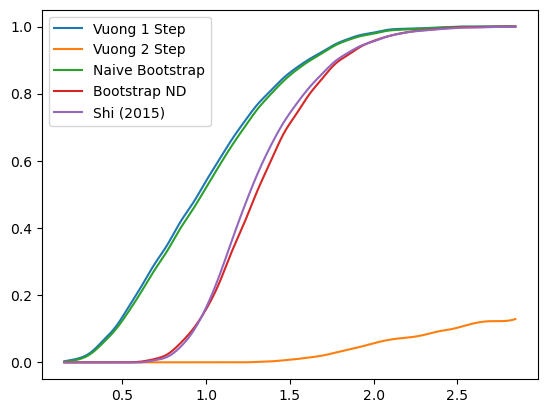

0.001 2.51188643150958


In [8]:
nobs = 100
c1,c2 = calc_c(nobs)
    
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# extra size sims

Quantiles: 1th: 0.47, 5th: 3.04, 10th: 9.42, 30th: 75.54, 50th: 239.62, 70th: 561.39, 90th: 1397.71, 95th: 2017.28, 99th: 3802.14
bonus term 1.1641189791646613 // variance stats 1.4070808292475299 //part1 3.017088168272582 //part2 0.3858418827154036
0.008983573508404995 -0.03827251750035546 2.4024331146843996
-2.3192543848209177 -0.03827251750035546 0.07419515635507727
---
Quantiles: 1th: 0.48, 5th: 3.34, 10th: 12.90, 30th: 120.55, 50th: 373.58, 70th: 908.80, 90th: 2270.99, 95th: 3218.46, 99th: 5695.49
bonus term 1.6189113816055751 // variance stats 1.2404624227446919 //part1 3.017088168272582 //part2 0.5365807332480026
0.7461718775276243 -0.16575964211991753 2.539585640039673
-2.491650885683526 -0.16575964211991753 -0.698237123171477
---
Quantiles: 1th: 0.62, 5th: 4.12, 10th: 12.48, 30th: 106.24, 50th: 341.32, 70th: 773.89, 90th: 1925.51, 95th: 2663.27, 99th: 4471.44
bonus term 1.457585682950607 // variance stats 1.3029517392882666 //part1 3.017088168272582 //part2 0.48311007224728875

Quantiles: 1th: 0.75, 5th: 3.73, 10th: 10.08, 30th: 82.07, 50th: 254.10, 70th: 590.73, 90th: 1464.59, 95th: 2131.80, 99th: 3729.48
bonus term 2.5479228956598994 // variance stats 0.1705635790475625 //part1 3.017088168272582 //part2 0.8444973277392485
2.2637975240627575 -0.6463559485865067 2.868534953479142
-2.8320482672570413 -0.6463559485865067 -2.227310837840657
---
Quantiles: 1th: 0.54, 5th: 3.99, 10th: 12.50, 30th: 109.13, 50th: 346.94, 70th: 807.71, 90th: 2008.53, 95th: 2802.74, 99th: 5073.67
bonus term 1.9669111057190776 // variance stats 0.6782447039176177 //part1 3.017088168272582 //part2 0.6519236416101232
1.2890637728889978 -0.3790076872966026 2.6244765095012808
-2.6447584385491574 -0.3790076872966026 -1.3093457019368744
---
Quantiles: 1th: 0.57, 5th: 4.08, 10th: 14.58, 30th: 128.13, 50th: 405.60, 70th: 960.60, 90th: 2365.33, 95th: 3350.91, 99th: 5745.65
bonus term 2.410336297135582 // variance stats 0.3765781120435054 //part1 3.017088168272582 //part2 0.7988948823181417
2.00

1.2005777372450366 -0.39812401578076895 2.620180229004405
-2.652935885131482 -0.39812401578076895 -1.2333333933721133
---
Quantiles: 1th: 0.53, 5th: 3.77, 10th: 12.76, 30th: 121.37, 50th: 371.81, 70th: 870.75, 90th: 2236.72, 95th: 3219.54, 99th: 5655.76
bonus term 2.8452929758441172 // variance stats 0.08541327040797779 //part1 3.017088168272582 //part2 0.943059273429578
2.731036433386612 -0.593562867993512 2.9536665068956487
-2.9595495183016225 -0.593562867993512 -2.7369194447925858
---
Quantiles: 1th: 0.61, 5th: 4.66, 10th: 16.90, 30th: 143.66, 50th: 449.86, 70th: 1038.37, 90th: 2658.37, 95th: 3695.69, 99th: 5898.54
bonus term 0.9314903976773791 // variance stats 3.764419317276782 //part1 3.017088168272582 //part2 0.308738209069541
-0.46335569534464444 0.43628973656864134 2.270847504720918
-2.326336490699403 0.43628973656864134 0.40786670936615943
---
Quantiles: 1th: 0.69, 5th: 3.58, 10th: 10.78, 30th: 82.23, 50th: 244.55, 70th: 574.86, 90th: 1471.67, 95th: 2106.38, 99th: 3457.57
bon

0.7453000918271799 -0.48837088140288887 2.5700927879368742
-2.496744547680059 -0.48837088140288887 -0.6719518515703652
---
Quantiles: 1th: 0.54, 5th: 3.56, 10th: 11.62, 30th: 95.34, 50th: 308.00, 70th: 697.03, 90th: 1753.92, 95th: 2427.00, 99th: 4119.64
bonus term 1.056332441416013 // variance stats 2.059035537793317 //part1 3.017088168272582 //part2 0.350116530409786
-0.1957720105524406 0.0700506044798375 2.3446994273209243
-2.308436893384467 0.0700506044798375 0.23203454448889865
---
Quantiles: 1th: 0.44, 5th: 3.67, 10th: 11.08, 30th: 107.30, 50th: 329.46, 70th: 762.44, 90th: 1948.67, 95th: 2818.17, 99th: 4756.64
bonus term 1.709544667734609 // variance stats 0.9426349329453163 //part1 3.017088168272582 //part2 0.5666207191795127
0.8895301406895758 -0.3663325689180286 2.50349474584034
-2.529559194779642 -0.3663325689180286 -0.9155945896288777
---
Quantiles: 1th: 0.59, 5th: 4.46, 10th: 14.05, 30th: 122.48, 50th: 368.91, 70th: 898.67, 90th: 2308.11, 95th: 3219.94, 99th: 5459.34
bonus t

0.971604312907255 -0.7952680721055652 2.67497851116457
-2.6457619455563828 -0.7952680721055652 -0.9423877472990678
---
Quantiles: 1th: 0.42, 5th: 3.40, 10th: 11.59, 30th: 99.83, 50th: 308.82, 70th: 719.62, 90th: 1789.26, 95th: 2568.77, 99th: 4519.90
bonus term 1.9061033586776124 // variance stats 0.6595753028005361 //part1 3.017088168272582 //part2 0.6317691934634253
1.2199678717282711 -0.5132767281174314 2.5939103747886088
-2.5922388456269534 -0.5132767281174314 -1.2182963425666165
---
Quantiles: 1th: 0.54, 5th: 4.02, 10th: 11.52, 30th: 101.20, 50th: 309.66, 70th: 695.56, 90th: 1782.22, 95th: 2535.75, 99th: 4630.23
bonus term 2.2282036664274805 // variance stats 0.39907008345421996 //part1 3.017088168272582 //part2 0.7385278593642249
1.7129768897664122 -1.010702624728136 2.747744375318536
-2.743430443088549 -1.010702624728136 -1.7086629575364247
---
Quantiles: 1th: 0.71, 5th: 4.90, 10th: 13.27, 30th: 129.17, 50th: 400.20, 70th: 975.36, 90th: 2404.53, 95th: 3405.61, 99th: 5873.76
bonus

Quantiles: 1th: 0.39, 5th: 3.02, 10th: 10.91, 30th: 118.30, 50th: 349.46, 70th: 852.60, 90th: 2114.16, 95th: 3047.77, 99th: 5054.85
bonus term 1.1966494734726572 // variance stats 2.034122229808926 //part1 3.017088168272582 //part2 0.3966239654699228
0.061068774401502345 -0.09912724966186084 2.33661700830617
-2.332230172543812 -0.09912724966186084 -0.056681938639144495
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.55, 5th: 4.05, 10th: 12.11, 30th: 100.29, 50th: 301.16, 70th: 703.11, 90th: 1717.59, 95th: 2364.55, 99th: 4196.95
bonus term 0.7094699896923072 // variance stats 3.5332991518369905 //part1 3.017088168272582 //part2 0.23515056575178264
-0.9611392395885971 0.37197251332820247 2.206130287431127
-2.3800792189732114 0.37197251332820247 0.7871903080465126
---
Quantiles: 1th: 0.39, 5th: 2.45, 10th: 8.26, 30th: 80.96, 50th: 251.46, 70th: 619.14, 90th: 1567.57, 95th: 2188.60, 99th: 3657.03
bonus term 1.1400494782799369 // variance stats 1.6323238337212802 //part1 3.017088168272

Quantiles: 1th: 0.67, 5th: 4.01, 10th: 11.66, 30th: 92.49, 50th: 279.01, 70th: 669.17, 90th: 1659.12, 95th: 2455.14, 99th: 4389.12
bonus term 1.1416585549100309 // variance stats 1.7237418080205826 //part1 3.017088168272582 //part2 0.37839747837521154
-0.03207475735654988 -0.2765625544798609 2.347054457652125
-2.315391867176612 -0.2765625544798609 0.06373734783206325
---
Quantiles: 1th: 0.84, 5th: 4.99, 10th: 15.28, 30th: 121.07, 50th: 356.90, 70th: 857.38, 90th: 2142.35, 95th: 2995.19, 99th: 4821.57
bonus term 0.8458942280168873 // variance stats 3.4777894813102126 //part1 3.017088168272582 //part2 0.28036775222952787
-0.6268944610009934 0.25180890125751626 2.2429545249893876
-2.318682917034768 0.25180890125751626 0.5511660689556132
---
Quantiles: 1th: 0.66, 5th: 3.53, 10th: 10.80, 30th: 100.42, 50th: 294.55, 70th: 676.41, 90th: 1769.81, 95th: 2569.33, 99th: 4344.16
bonus term 1.8857473268119334 // variance stats 0.6715300173833516 //part1 3.017088168272582 //part2 0.6250222803039953


Quantiles: 1th: 0.48, 5th: 3.61, 10th: 12.05, 30th: 100.23, 50th: 286.33, 70th: 657.00, 90th: 1651.01, 95th: 2341.90, 99th: 4083.86
bonus term 0.7836084936693158 // variance stats 2.9762045241331823 //part1 3.017088168272582 //part2 0.25972343198639997
-0.6467443112033164 0.2810543303897566 2.2276529470560793
-2.213961298541948 0.2810543303897566 0.6604359597174477
---
Quantiles: 1th: 0.42, 5th: 2.87, 10th: 9.79, 30th: 87.65, 50th: 267.01, 70th: 637.64, 90th: 1593.19, 95th: 2325.93, 99th: 3729.37
bonus term 1.3095209619043295 // variance stats 1.3138985690036051 //part1 3.017088168272582 //part2 0.43403470129747285
0.1856045394978861 -0.6881960217961882 2.415885233986604
-2.4334373843107726 -0.6881960217961882 -0.20315668982205484
---
Quantiles: 1th: 0.46, 5th: 3.86, 10th: 11.97, 30th: 104.51, 50th: 326.09, 70th: 805.72, 90th: 1991.77, 95th: 2844.90, 99th: 5067.37
bonus term 0.7409993722317256 // variance stats 3.869367810571689 //part1 3.017088168272582 //part2 0.2456008346139851
-0.7

Quantiles: 1th: 0.72, 5th: 4.82, 10th: 14.40, 30th: 121.35, 50th: 354.91, 70th: 813.35, 90th: 2097.38, 95th: 2986.36, 99th: 5497.43
bonus term 1.3866864764292333 // variance stats 1.5596341997392096 //part1 3.017088168272582 //part2 0.45961085625919024
0.35517184505598476 -0.6218492657884065 2.499003446296257
-2.418201107802482 -0.6218492657884065 -0.2743695065622094
---
Quantiles: 1th: 0.50, 5th: 3.99, 10th: 11.91, 30th: 103.77, 50th: 301.20, 70th: 705.49, 90th: 1685.64, 95th: 2367.06, 99th: 4063.93
bonus term 1.1373758561822933 // variance stats 1.7619075625979297 //part1 3.017088168272582 //part2 0.37697799757489087
-0.08565233932740945 -0.5848313784154394 2.434764321980107
-2.360404051691996 -0.5848313784154394 0.16001260961552038
---
Quantiles: 1th: 0.45, 5th: 3.53, 10th: 11.54, 30th: 100.65, 50th: 284.63, 70th: 651.09, 90th: 1616.08, 95th: 2326.95, 99th: 3921.31
bonus term 0.8838952070214532 // variance stats 2.46674050704542 //part1 3.017088168272582 //part2 0.29296300198198144


Quantiles: 1th: 0.36, 5th: 3.06, 10th: 8.97, 30th: 88.56, 50th: 273.52, 70th: 612.65, 90th: 1535.45, 95th: 2275.09, 99th: 3793.07
bonus term 1.7992396475151298 // variance stats 0.6573092182386386 //part1 3.017088168272582 //part2 0.5963497077863904
0.9346013692247681 -2.3685449224264303 2.5616759597724292
-2.663877925805491 -2.3685449224264303 -1.03680333525783
---
Quantiles: 1th: 0.54, 5th: 4.02, 10th: 13.60, 30th: 123.01, 50th: 378.61, 70th: 893.52, 90th: 2270.23, 95th: 3349.45, 99th: 5585.56
bonus term 1.1945101083311058 // variance stats 2.190764494850219 //part1 3.017088168272582 //part2 0.39591488273112563
0.012393157570173494 -0.5711250756905378 2.240420816327746
-2.376627059092038 -0.5711250756905378 -0.1485994003344657
---
Quantiles: 1th: 0.37, 5th: 2.60, 10th: 7.65, 30th: 58.21, 50th: 182.53, 70th: 427.07, 90th: 1074.79, 95th: 1568.86, 99th: 2644.12
bonus term 0.6414739960589433 // variance stats 2.5173939764786875 //part1 3.017088168272582 //part2 0.21261360632566995
-0.956

-1.0228754614266915 0.9089799625406614 2.1152672876124226
-2.0495065602673095 0.9089799625406614 1.088636188771805
---
Quantiles: 1th: 0.52, 5th: 3.47, 10th: 11.69, 30th: 96.60, 50th: 280.81, 70th: 681.08, 90th: 1672.67, 95th: 2361.25, 99th: 4148.65
bonus term 0.9422388999315628 // variance stats 2.3295098678794175 //part1 3.017088168272582 //part2 0.3123007507172178
-0.39884246631095766 -0.22048030548753994 2.3910270049318187
-2.2833202661740835 -0.22048030548753994 0.506549205068693
---
Quantiles: 1th: 0.42, 5th: 3.63, 10th: 10.65, 30th: 77.00, 50th: 239.85, 70th: 585.96, 90th: 1430.63, 95th: 2016.92, 99th: 3478.48
bonus term 0.9316695098412946 // variance stats 2.02530143209544 //part1 3.017088168272582 //part2 0.30879757497266547
-0.3988395656890068 -1.0223216767627488 2.2992905824766514
-2.262178585371596 -1.0223216767627488 0.4359515627940625
---
0.5384615384615385 [0.99857143 0.         0.00142857]
Quantiles: 1th: 0.49, 5th: 3.48, 10th: 9.77, 30th: 77.64, 50th: 241.89, 70th: 572

-0.4431351211254687 -0.5111925890830973 2.207989790586805
-2.2422551823863275 -0.5111925890830973 0.4088697293259464
---
Quantiles: 1th: 0.47, 5th: 3.66, 10th: 11.87, 30th: 106.00, 50th: 310.65, 70th: 736.48, 90th: 1850.47, 95th: 2650.79, 99th: 4766.56
bonus term 0.9325987419763356 // variance stats 2.615869340067638 //part1 3.017088168272582 //part2 0.30910556469096834
-0.3547064288608714 -0.4552504816489448 2.268611572114392
-2.219903912813543 -0.4552504816489448 0.40341408816172075
---
Quantiles: 1th: 0.43, 5th: 2.62, 10th: 7.52, 30th: 67.37, 50th: 208.35, 70th: 484.74, 90th: 1253.23, 95th: 1910.04, 99th: 3021.10
bonus term 0.4855597597056382 // variance stats 4.132381840332478 //part1 3.017088168272582 //part2 0.16093654962149911
-1.1949785752875994 0.6475633008502886 2.0919148597389867
-2.1660980946988757 0.6475633008502886 1.1207953403277102
---
Quantiles: 1th: 0.51, 5th: 3.26, 10th: 9.92, 30th: 103.11, 50th: 328.12, 70th: 771.23, 90th: 1884.82, 95th: 2730.06, 99th: 5005.74
bonus

-1.4515417938189714 1.9330645135434221 2.0431977382559188
-2.1581587113372827 1.9330645135434221 1.3365808207376078
---
Quantiles: 1th: 0.63, 5th: 4.31, 10th: 12.26, 30th: 111.33, 50th: 359.81, 70th: 820.40, 90th: 2051.92, 95th: 2909.82, 99th: 5004.07
bonus term 0.574548531610297 // variance stats 5.517026921662755 //part1 3.017088168272582 //part2 0.1904314688752539
-1.145910070630114 0.6652130368061742 2.2315992753463543
-2.295007133850708 0.6652130368061742 1.0825022121257604
---
Quantiles: 1th: 0.56, 5th: 2.77, 10th: 8.32, 30th: 61.78, 50th: 195.32, 70th: 461.43, 90th: 1149.12, 95th: 1622.64, 99th: 2499.37
bonus term 0.47646986210105163 // variance stats 3.875259883334903 //part1 3.017088168272582 //part2 0.15792374485822602
-1.1616859126373889 -0.1577048313897114 2.1366726740512187
-2.114625636839492 -0.1577048313897114 1.1837329498491154
---
Quantiles: 1th: 0.39, 5th: 2.83, 10th: 8.91, 30th: 81.41, 50th: 244.15, 70th: 562.35, 90th: 1468.59, 95th: 2063.51, 99th: 3430.96
bonus term

-0.8414100353315873 -0.018317052521575183 2.246201644318097
-2.1561885403696075 -0.018317052521575183 0.9314231392800775
---
Quantiles: 1th: 0.59, 5th: 3.83, 10th: 11.52, 30th: 92.38, 50th: 279.49, 70th: 652.25, 90th: 1638.90, 95th: 2298.52, 99th: 4035.95
bonus term 1.2942708664144789 // variance stats 1.3797369484420807 //part1 3.017088168272582 //part2 0.4289801272713575
0.15503461506920863 -1.600447925372598 2.4173882997318192
-2.433507117759749 -1.600447925372598 -0.1711534330971384
---
Quantiles: 1th: 0.44, 5th: 3.46, 10th: 9.12, 30th: 82.46, 50th: 239.40, 70th: 552.55, 90th: 1442.48, 95th: 2041.45, 99th: 3425.47
bonus term 0.6359845868426819 // variance stats 3.4156390616917385 //part1 3.017088168272582 //part2 0.21079416688270386
-0.8458139051961507 -0.2282168838621248 2.2084226351731
-2.117783078881515 -0.2282168838621248 0.9364534614877361
---
Quantiles: 1th: 0.59, 5th: 3.20, 10th: 9.23, 30th: 75.22, 50th: 228.54, 70th: 532.46, 90th: 1351.98, 95th: 1929.33, 99th: 3320.37
bonus

-1.1556080519586907 0.4152500162607527 2.2780110404202376
-2.076351495362968 0.4152500162607527 1.3572675970159604
---
Quantiles: 1th: 0.59, 5th: 3.80, 10th: 12.29, 30th: 107.13, 50th: 317.21, 70th: 724.88, 90th: 1810.68, 95th: 2559.60, 99th: 4355.10
bonus term 0.9296795062565826 // variance stats 2.571266063564595 //part1 3.017088168272582 //part2 0.3081379974350785
-0.4157525449233493 -1.2859771403831257 2.1088279370642127
-2.275111557436514 -1.2859771403831257 0.24946892455104763
---
Quantiles: 1th: 0.54, 5th: 3.31, 10th: 10.30, 30th: 96.66, 50th: 299.55, 70th: 697.61, 90th: 1666.78, 95th: 2414.72, 99th: 4418.48
bonus term 0.5508282096648637 // variance stats 4.719876844892829 //part1 3.017088168272582 //part2 0.18256947723878997
-0.9401255898780797 -0.19106169767570716 2.1023663006806914
-2.0417820092078074 -0.19106169767570716 1.0007098813509638
---
Quantiles: 1th: 0.60, 5th: 3.35, 10th: 9.12, 30th: 79.43, 50th: 232.80, 70th: 529.45, 90th: 1354.72, 95th: 1879.26, 99th: 3372.65
bon

Quantiles: 1th: 0.60, 5th: 3.43, 10th: 10.96, 30th: 92.94, 50th: 283.65, 70th: 691.76, 90th: 1670.52, 95th: 2365.76, 99th: 4069.66
bonus term 0.5937605952298651 // variance stats 4.312042031605686 //part1 3.017088168272582 //part2 0.1967992190197808
-0.9801663888676719 -0.2275036968104999 2.0903798728104053
-2.167687579327402 -0.2275036968104999 0.9028586823506748
---
Quantiles: 1th: 0.50, 5th: 3.23, 10th: 9.13, 30th: 82.24, 50th: 251.76, 70th: 599.57, 90th: 1456.05, 95th: 2104.91, 99th: 3628.47
bonus term 0.870878770582353 // variance stats 2.269447288439845 //part1 3.017088168272582 //part2 0.2886487639772788
-0.49547004089999264 -1.284058755344603 2.3012382184242335
-2.2372275820646985 -1.284058755344603 0.5594806772595278
---
Quantiles: 1th: 0.37, 5th: 2.65, 10th: 7.29, 30th: 62.70, 50th: 184.61, 70th: 426.69, 90th: 1093.28, 95th: 1546.50, 99th: 2683.69
bonus term 0.4323573849070885 // variance stats 4.133658002418102 //part1 3.017088168272582 //part2 0.14330286713319104
-1.2971220

Quantiles: 1th: 0.51, 5th: 3.38, 10th: 11.81, 30th: 108.57, 50th: 327.82, 70th: 771.52, 90th: 1910.09, 95th: 2687.72, 99th: 4808.11
bonus term 0.35606110690227866 // variance stats 9.028368581982095 //part1 3.017088168272582 //part2 0.11801481661907799
-1.4120030842435722 1.6606542116211682 2.19080060758238
-2.124125298048129 1.6606542116211682 1.4786783937778225
---
Quantiles: 1th: 0.43, 5th: 2.92, 10th: 8.48, 30th: 76.78, 50th: 247.61, 70th: 589.50, 90th: 1508.21, 95th: 2148.57, 99th: 3675.84
bonus term 1.1496524872948903 // variance stats 1.5494229886273212 //part1 3.017088168272582 //part2 0.38104703050594574
-0.043962077306705594 -3.393609831343606 2.360343257028511
-2.343267051896486 -3.393609831343606 0.061038282438730676
---
Quantiles: 1th: 0.74, 5th: 5.57, 10th: 16.93, 30th: 135.63, 50th: 408.39, 70th: 931.80, 90th: 2246.96, 95th: 3216.93, 99th: 5772.88
bonus term 0.8447999123984183 // variance stats 3.654173372698034 //part1 3.017088168272582 //part2 0.2800050463497406
-0.556

Quantiles: 1th: 0.51, 5th: 3.32, 10th: 10.21, 30th: 87.90, 50th: 260.05, 70th: 619.60, 90th: 1504.67, 95th: 2152.30, 99th: 3735.41
bonus term 0.5757903718845657 // variance stats 4.034848355401339 //part1 3.017088168272582 //part2 0.19084307112384838
-1.0879762660966756 -0.7021706558845834 2.099008230113283
-2.2395570098658073 -0.7021706558845834 0.9474274863441516
---
Quantiles: 1th: 0.51, 5th: 3.17, 10th: 10.83, 30th: 97.24, 50th: 296.60, 70th: 692.39, 90th: 1736.69, 95th: 2457.10, 99th: 4422.86
bonus term 0.4815660896346077 // variance stats 5.783137934071423 //part1 3.017088168272582 //part2 0.15961286604041333
-1.0817407310813463 0.12616576341047844 2.1983149911916327
-2.0448729103505614 0.12616576341047844 1.2351828119224173
---
Quantiles: 1th: 0.44, 5th: 2.63, 10th: 8.42, 30th: 67.74, 50th: 197.59, 70th: 473.17, 90th: 1206.34, 95th: 1691.29, 99th: 3002.68
bonus term 0.8551254977276508 // variance stats 1.9289328183859404 //part1 3.017088168272582 //part2 0.28342741412732675
-0.5

Quantiles: 1th: 0.58, 5th: 4.11, 10th: 11.16, 30th: 92.25, 50th: 275.82, 70th: 657.01, 90th: 1632.18, 95th: 2353.26, 99th: 4162.87
bonus term 0.519445969151873 // variance stats 4.963505410601212 //part1 3.017088168272582 //part2 0.17216797792464883
-1.0465617377830692 -0.5269205075297271 2.0559623153281885
-2.0854536760868156 -0.5269205075297271 1.0170703770244425
---
Quantiles: 1th: 0.44, 5th: 3.23, 10th: 8.18, 30th: 70.60, 50th: 208.34, 70th: 487.62, 90th: 1226.60, 95th: 1792.11, 99th: 3121.37
bonus term 0.29839301036587496 // variance stats 7.0681494481092795 //part1 3.017088168272582 //part2 0.09890099119533466
-1.5359249322630728 0.8785900073660355 2.0487157528787905
-2.132710952994823 0.8785900073660355 1.4519297321470408
---
Quantiles: 1th: 0.70, 5th: 4.52, 10th: 13.83, 30th: 100.50, 50th: 284.01, 70th: 684.90, 90th: 1709.53, 95th: 2563.34, 99th: 4467.18
bonus term 0.5821988633888474 // variance stats 4.521841770714944 //part1 3.017088168272582 //part2 0.19296713616499395
-0.94

Quantiles: 1th: 0.65, 5th: 4.00, 10th: 12.23, 30th: 106.46, 50th: 315.33, 70th: 726.57, 90th: 1847.74, 95th: 2548.67, 99th: 4510.89
bonus term 0.562960719180433 // variance stats 5.09437288834179 //part1 3.017088168272582 //part2 0.1865907417292194
-0.9578428879545214 -0.5967932952166064 2.2672486664347278
-2.0837643263153875 -0.5967932952166064 1.141327228073862
---
Quantiles: 1th: 0.50, 5th: 3.71, 10th: 11.71, 30th: 99.33, 50th: 304.05, 70th: 736.01, 90th: 1870.99, 95th: 2662.40, 99th: 4831.04
bonus term 0.44973295723478535 // variance stats 6.755115605018875 //part1 3.017088168272582 //part2 0.14906192068370266
-1.2699936717127063 0.411744445158846 2.1788534112294333
-2.1694595861822767 0.411744445158846 1.2793874967598629
---
Quantiles: 1th: 0.48, 5th: 3.40, 10th: 11.63, 30th: 98.10, 50th: 309.84, 70th: 763.41, 90th: 1915.48, 95th: 2687.35, 99th: 4505.88
bonus term 0.39361442237849403 // variance stats 8.074449971907427 //part1 3.017088168272582 //part2 0.13046169035353578
-1.42666

-0.8126435535087597 -0.5960384135592816 2.1562655093000713
-2.1462532533321306 -0.5960384135592816 0.8226558094767004
---
Quantiles: 1th: 0.48, 5th: 2.89, 10th: 9.45, 30th: 81.88, 50th: 255.04, 70th: 595.12, 90th: 1444.91, 95th: 2089.59, 99th: 3504.22
bonus term 0.37457675357869075 // variance stats 6.4468356355612855 //part1 3.017088168272582 //part2 0.12415174257010618
-1.4079726805857566 0.213403931454385 2.0875640294919524
-2.1571261877431382 0.213403931454385 1.3384105223345708
---
Quantiles: 1th: 0.36, 5th: 2.13, 10th: 7.64, 30th: 71.88, 50th: 232.98, 70th: 576.36, 90th: 1440.04, 95th: 2041.17, 99th: 3440.34
bonus term 0.385759743634989 // variance stats 6.212435794785338 //part1 3.017088168272582 //part2 0.12785829320190326
-1.3454221971604072 0.3195364572095953 2.11001701680928
-2.1169416844303854 0.3195364572095953 1.3384975295393025
---
Quantiles: 1th: 0.63, 5th: 3.66, 10th: 11.25, 30th: 104.58, 50th: 331.45, 70th: 756.32, 90th: 1879.75, 95th: 2667.85, 99th: 4380.74
bonus ter

-1.34901561312787 0.9235669108736256 2.1544914853459316
-2.0997275594165377 0.9235669108736256 1.4037795390572647
---
Quantiles: 1th: 0.61, 5th: 3.94, 10th: 12.51, 30th: 111.53, 50th: 347.12, 70th: 798.25, 90th: 1961.09, 95th: 2706.62, 99th: 4737.13
bonus term 0.48586935128819375 // variance stats 6.461549325970004 //part1 3.017088168272582 //part2 0.16103916232795268
-1.2552465264662787 -0.10709698287617217 2.1262013675692355
-2.2269852290426657 -0.10709698287617217 1.1544626649928478
---
Quantiles: 1th: 0.78, 5th: 4.16, 10th: 11.29, 30th: 106.13, 50th: 322.01, 70th: 784.19, 90th: 2029.08, 95th: 2788.52, 99th: 4767.98
bonus term 0.559055580804156 // variance stats 5.642383085015499 //part1 3.017088168272582 //part2 0.1852964015712674
-1.0488881563387025 -0.6257963862947519 2.1163421512504956
-2.166999317947014 -0.6257963862947519 0.9982309896421836
---
Quantiles: 1th: 0.47, 5th: 4.15, 10th: 13.30, 30th: 111.28, 50th: 325.32, 70th: 779.42, 90th: 1900.92, 95th: 2692.25, 99th: 4875.46
bo

-1.2423644916918828 -2.9206604215936065 2.1272392088046224
-2.415569910332671 -2.9206604215936065 0.9540337901638338
---
Quantiles: 1th: 0.44, 5th: 3.71, 10th: 10.81, 30th: 90.42, 50th: 278.18, 70th: 663.16, 90th: 1686.07, 95th: 2445.91, 99th: 4181.60
bonus term 0.39707951434918715 // variance stats 7.036078927888008 //part1 3.017088168272582 //part2 0.13161017915380743
-1.332170781971547 0.2025720986682238 2.126510728699835
-2.126329810669921 0.2025720986682238 1.3323517000014606
---
Quantiles: 1th: 0.50, 5th: 2.80, 10th: 9.08, 30th: 72.31, 50th: 224.32, 70th: 526.54, 90th: 1330.24, 95th: 1887.83, 99th: 3243.96
bonus term 0.420814564468846 // variance stats 5.190620429783532 //part1 3.017088168272582 //part2 0.13947705237589433
-1.3029725624456236 -0.9206580736890931 2.046112296894683
-2.1446016913833152 -0.9206580736890931 1.2044831679569912
---
Quantiles: 1th: 0.53, 5th: 4.15, 10th: 10.87, 30th: 94.03, 50th: 276.48, 70th: 674.23, 90th: 1667.27, 95th: 2350.20, 99th: 4055.61
bonus ter

-1.297778862256399 -0.3374860372078677 2.1009161681209476
-2.1198174119426487 -0.3374860372078677 1.278877618434698
---
Quantiles: 1th: 0.68, 5th: 3.77, 10th: 11.34, 30th: 93.25, 50th: 291.28, 70th: 682.29, 90th: 1760.38, 95th: 2418.79, 99th: 4223.89
bonus term 0.3513290622099804 // variance stats 8.447812023849993 //part1 3.017088168272582 //part2 0.11644640216501595
-1.399321617584346 0.599653147806393 2.1622189458712633
-2.101979742004307 0.599653147806393 1.4595608214513023
---
Quantiles: 1th: 0.65, 5th: 3.15, 10th: 9.62, 30th: 80.24, 50th: 231.26, 70th: 566.68, 90th: 1436.12, 95th: 2042.65, 99th: 3658.14
bonus term 0.48859125821678373 // variance stats 4.700429891759871 //part1 3.017088168272582 //part2 0.16194132586338175
-1.1683639230137433 -1.597784205165022 2.0660108015538676
-2.1455464394473105 -1.597784205165022 1.0888282851203002
---
Quantiles: 1th: 0.67, 5th: 3.72, 10th: 10.80, 30th: 84.08, 50th: 264.25, 70th: 630.47, 90th: 1570.19, 95th: 2257.32, 99th: 4100.82
bonus term 

-1.1729584097822021 -0.1095258114971491 2.177863312779192
-2.0833356798645015 -0.1095258114971491 1.2674860426968928
---
Quantiles: 1th: 0.51, 5th: 3.35, 10th: 11.06, 30th: 91.56, 50th: 259.39, 70th: 615.28, 90th: 1644.26, 95th: 2281.35, 99th: 3975.84
bonus term 0.32426123051658284 // variance stats 8.636029675788942 //part1 3.017088168272582 //part2 0.10747489381532954
-1.3855576454147798 0.860176898227538 2.0503076455620035
-2.0340801064479455 0.860176898227538 1.401785184528838
---
1.3846153846153846 [0.97714286 0.00285714 0.02      ]
Quantiles: 1th: 0.43, 5th: 3.46, 10th: 12.40, 30th: 107.28, 50th: 331.91, 70th: 822.33, 90th: 2000.87, 95th: 2931.83, 99th: 4990.39
bonus term 0.49150199999521094 // variance stats 6.502594484476652 //part1 3.017088168272582 //part2 0.16290607784147648
-1.1760203825135134 -0.8893582826037544 2.0278728359862606
-2.1590243825039352 -0.8893582826037544 1.0448688359958387
---
Quantiles: 1th: 0.46, 5th: 2.98, 10th: 8.62, 30th: 77.41, 50th: 242.41, 70th: 609

-1.3741871078487737 0.5737343819344357 2.1350959617234526
-1.9571765034556006 0.5737343819344357 1.552106566116626
---
Quantiles: 1th: 0.64, 5th: 3.55, 10th: 10.59, 30th: 93.28, 50th: 279.40, 70th: 672.51, 90th: 1739.64, 95th: 2496.51, 99th: 4203.43
bonus term 0.5495795233379422 // variance stats 4.9398841238895095 //part1 3.017088168272582 //part2 0.18215560589752375
-1.1969072710688546 -1.9534723159528968 2.2205161991356386
-2.2960663177447396 -1.9534723159528968 1.1213571524597539
---
Quantiles: 1th: 0.43, 5th: 3.45, 10th: 12.30, 30th: 99.01, 50th: 299.84, 70th: 729.61, 90th: 1837.14, 95th: 2494.16, 99th: 4401.45
bonus term 0.44302576708093316 // variance stats 6.750903304744559 //part1 3.017088168272582 //part2 0.1468388533486528
-1.261997767472587 -0.54769886628762 2.1406951023903593
-2.1480493016344533 -0.54769886628762 1.2546435682284929
---
Quantiles: 1th: 0.47, 5th: 3.80, 10th: 12.03, 30th: 106.81, 50th: 313.83, 70th: 764.60, 90th: 1969.56, 95th: 2853.75, 99th: 5103.39
bonus t

-1.3510331188871973 -2.0504441740452375 2.243501748937011
-2.319939774206688 -2.0504441740452375 1.2745950936175203
---
Quantiles: 1th: 0.71, 5th: 3.95, 10th: 12.26, 30th: 101.93, 50th: 312.96, 70th: 739.00, 90th: 1851.53, 95th: 2589.23, 99th: 4381.55
bonus term 0.34642001562655383 // variance stats 9.027715212955032 //part1 3.017088168272582 //part2 0.11481932124804123
-1.3683196032381173 0.44774019108008345 1.9397449359860408
-2.0611596344912253 0.44774019108008345 1.2469049047329333
---
Quantiles: 1th: 0.41, 5th: 2.92, 10th: 9.99, 30th: 86.91, 50th: 254.58, 70th: 607.47, 90th: 1476.93, 95th: 2037.38, 99th: 3610.61
bonus term 0.28963961550560274 // variance stats 8.796064021476958 //part1 3.017088168272582 //part2 0.09599971871933541
-1.4970415757648299 0.6537458101166739 2.21482871423954
-2.0763208067760353 0.6537458101166739 1.6355494832283348
---
Quantiles: 1th: 0.48, 5th: 3.52, 10th: 10.43, 30th: 92.41, 50th: 274.28, 70th: 631.46, 90th: 1596.03, 95th: 2315.87, 99th: 4170.61
bonus

-1.3397286158078603 -0.5863666548060593 2.1225337942921025
-2.108446084678538 -0.5863666548060593 1.3538163254214255
---
Quantiles: 1th: 0.50, 5th: 3.26, 10th: 10.18, 30th: 94.89, 50th: 273.23, 70th: 655.89, 90th: 1661.53, 95th: 2401.44, 99th: 4294.87
bonus term 0.22633571808516886 // variance stats 12.957034897797126 //part1 3.017088168272582 //part2 0.07501793300749186
-1.6522686475113713 2.400406846334363 2.172647005985367
-2.104940083681709 2.400406846334363 1.7199755698150292
---
Quantiles: 1th: 0.56, 5th: 3.39, 10th: 9.76, 30th: 72.27, 50th: 204.78, 70th: 522.55, 90th: 1295.05, 95th: 1846.71, 99th: 3261.28
bonus term 0.2611378311821455 // variance stats 8.644091522309605 //part1 3.017088168272582 //part2 0.08655293336411134
-1.5854433646618709 0.64129177692213 2.0494323229613354
-2.107719027026162 0.64129177692213 1.5271566605970444
---
Quantiles: 1th: 0.38, 5th: 2.79, 10th: 9.33, 30th: 90.54, 50th: 270.54, 70th: 641.13, 90th: 1545.55, 95th: 2331.28, 99th: 4193.00
bonus term 0.35

-1.4566684494281765 0.39595820493880424 2.101293469836536
-2.128474899071455 0.39595820493880424 1.429487020193257
---
Quantiles: 1th: 0.40, 5th: 2.66, 10th: 8.16, 30th: 74.45, 50th: 246.49, 70th: 596.44, 90th: 1494.30, 95th: 2148.41, 99th: 3804.33
bonus term 0.2535189264533797 // variance stats 10.302160827390729 //part1 3.017088168272582 //part2 0.08402768242551249
-1.6318951393189136 1.1113694119826654 2.0367839662418064
-2.1389329922256732 1.1113694119826654 1.5297461133350472
---
Quantiles: 1th: 0.51, 5th: 3.38, 10th: 11.11, 30th: 83.33, 50th: 244.64, 70th: 578.10, 90th: 1413.44, 95th: 1980.87, 99th: 3504.31
bonus term 0.27917430552024386 // variance stats 8.76702400599456 //part1 3.017088168272582 //part2 0.0925310398469673
-1.4013400278226222 0.28109599557103865 1.9686954191587656
-1.9596886388631098 0.28109599557103865 1.410346808118278
---
Quantiles: 1th: 0.44, 5th: 3.95, 10th: 12.90, 30th: 116.76, 50th: 327.39, 70th: 796.37, 90th: 2052.11, 95th: 2906.60, 99th: 5154.70
bonus t

Quantiles: 1th: 0.41, 5th: 2.76, 10th: 7.96, 30th: 73.60, 50th: 236.34, 70th: 549.09, 90th: 1340.68, 95th: 1859.55, 99th: 3273.35
bonus term 0.2771971181509342 // variance stats 8.381061465031735 //part1 3.017088168272582 //part2 0.09187571018504308
-1.496276826374199 0.09919378318656094 2.158189292023289
-2.050671062676068 0.09919378318656094 1.6037950557214204
---
Quantiles: 1th: 0.65, 5th: 3.68, 10th: 10.15, 30th: 86.38, 50th: 263.69, 70th: 632.80, 90th: 1574.06, 95th: 2232.92, 99th: 3882.44
bonus term 0.2534440049902715 // variance stats 10.855520279594252 //part1 3.017088168272582 //part2 0.0840028500510741
-1.6536697982949065 1.0717097526826558 2.0738330269045417
-2.160557808275449 1.0717097526826558 1.566945016923999
---
Quantiles: 1th: 0.36, 5th: 2.88, 10th: 9.46, 30th: 82.39, 50th: 263.96, 70th: 638.14, 90th: 1588.31, 95th: 2251.37, 99th: 4124.55
bonus term 0.2735598147778857 // variance stats 10.074472645073872 //part1 3.017088168272582 //part2 0.09067014270733459
-1.48824854

Quantiles: 1th: 0.71, 5th: 5.11, 10th: 15.60, 30th: 130.37, 50th: 393.11, 70th: 920.19, 90th: 2322.62, 95th: 3202.62, 99th: 5549.60
bonus term 0.4353385458553155 // variance stats 8.711527756594872 //part1 3.017088168272582 //part2 0.14429095922130986
-1.247267657565294 -0.4946304984930785 2.121263163994556
-2.1179447492759254 -0.4946304984930785 1.2505860722839253
---
Quantiles: 1th: 0.51, 5th: 4.31, 10th: 12.29, 30th: 102.11, 50th: 312.01, 70th: 751.75, 90th: 1958.32, 95th: 2736.84, 99th: 4472.62
bonus term 0.36605489770103145 // variance stats 8.969779921426591 //part1 3.017088168272582 //part2 0.12132721262521615
-1.2709100770560482 -0.278354419111295 2.158764665020483
-2.003019872458111 -0.278354419111295 1.42665486961842
---
Quantiles: 1th: 0.38, 5th: 2.44, 10th: 8.57, 30th: 76.45, 50th: 242.85, 70th: 563.24, 90th: 1390.25, 95th: 2010.00, 99th: 3408.66
bonus term 0.31161472699162984 // variance stats 7.633954808223109 //part1 3.017088168272582 //part2 0.10328326837397106
-1.51398

Quantiles: 1th: 0.49, 5th: 4.14, 10th: 12.56, 30th: 104.67, 50th: 310.02, 70th: 699.71, 90th: 1802.09, 95th: 2578.55, 99th: 4641.03
bonus term 0.2910814193130521 // variance stats 10.673794976496911 //part1 3.017088168272582 //part2 0.09647759796151706
-1.5150330787602784 0.17251899496805262 2.0649017480956857
-2.0971959173863826 0.17251899496805262 1.482738909469581
---
Quantiles: 1th: 0.51, 5th: 2.95, 10th: 9.85, 30th: 74.69, 50th: 222.37, 70th: 520.51, 90th: 1289.98, 95th: 1825.76, 99th: 3092.97
bonus term 0.23025981698178175 // variance stats 9.874265914181553 //part1 3.017088168272582 //part2 0.07631855754272365
-1.6990356182621256 0.8532299713850194 2.1723178276452546
-2.159555252225689 0.8532299713850194 1.7117981936816913
---
Quantiles: 1th: 0.48, 5th: 3.37, 10th: 10.28, 30th: 80.00, 50th: 243.16, 70th: 555.15, 90th: 1414.91, 95th: 1983.52, 99th: 3537.72
bonus term 0.2606567340160243 // variance stats 9.463167851466968 //part1 3.017088168272582 //part2 0.08639347592061321
-1.66

Quantiles: 1th: 0.47, 5th: 3.39, 10th: 9.38, 30th: 71.17, 50th: 215.81, 70th: 492.07, 90th: 1260.48, 95th: 1767.14, 99th: 3052.32
bonus term 0.20286181638497158 // variance stats 11.05918567170849 //part1 3.017088168272582 //part2 0.06723761622820557
-1.711293863065269 0.9975691700455332 1.945665068526468
-2.117017495835212 0.9975691700455332 1.5399414357565249
---
Quantiles: 1th: 0.59, 5th: 3.70, 10th: 10.13, 30th: 87.92, 50th: 256.42, 70th: 586.07, 90th: 1499.67, 95th: 2110.83, 99th: 3628.55
bonus term 0.2621885299660755 // variance stats 9.965960250317185 //part1 3.017088168272582 //part2 0.08690118264465244
-1.4979333337854637 0.46953458348274174 1.9133296653623142
-2.0223103937176146 0.46953458348274174 1.388952605430163
---
Quantiles: 1th: 0.62, 5th: 3.44, 10th: 9.66, 30th: 93.13, 50th: 276.11, 70th: 671.25, 90th: 1806.37, 95th: 2579.94, 99th: 4272.60
bonus term 0.2824668331237092 // variance stats 11.060259384923867 //part1 3.017088168272582 //part2 0.09362233298121815
-1.454957

Quantiles: 1th: 0.60, 5th: 3.67, 10th: 11.58, 30th: 102.44, 50th: 304.70, 70th: 697.86, 90th: 1781.00, 95th: 2505.22, 99th: 4390.89
bonus term 0.2780962790240835 // variance stats 11.094030640431102 //part1 3.017088168272582 //part2 0.09217373292186753
-1.5393503553654388 0.4838147857540864 2.0818026287915337
-2.0955429134136057 0.4838147857540864 1.5256100707433664
---
Quantiles: 1th: 0.53, 5th: 3.98, 10th: 12.61, 30th: 113.53, 50th: 329.36, 70th: 784.39, 90th: 1939.37, 95th: 2797.48, 99th: 4929.80
bonus term 0.29315268377213227 // variance stats 11.39708070763961 //part1 3.017088168272582 //part2 0.09716410904225425
-1.4718489706566964 0.28592396839033624 1.9519394706879756
-2.058154338200961 0.28592396839033624 1.365634103143711
---
Quantiles: 1th: 0.43, 5th: 2.78, 10th: 8.50, 30th: 72.67, 50th: 217.34, 70th: 508.27, 90th: 1316.73, 95th: 1900.95, 99th: 3648.77
bonus term 0.21597528057647103 // variance stats 10.800768127665547 //part1 3.017088168272582 //part2 0.07158401363528152
-1

-1.4537273015724717 -0.3957528799980062 2.1455291713178593
-2.102723349138876 -0.3957528799980062 1.4965331237514548
---
Quantiles: 1th: 0.76, 5th: 4.47, 10th: 13.65, 30th: 118.97, 50th: 339.34, 70th: 825.95, 90th: 2058.53, 95th: 2876.32, 99th: 4842.98
bonus term 0.3278921135868217 // variance stats 10.677698097988989 //part1 3.017088168272582 //part2 0.10867833331319404
-1.3507769701836942 -0.020621710726517542 2.1950254951503005
-2.0065611973573376 -0.020621710726517542 1.5392412679766576
---
Quantiles: 1th: 0.49, 5th: 3.70, 10th: 10.41, 30th: 81.41, 50th: 268.14, 70th: 668.15, 90th: 1711.88, 95th: 2409.81, 99th: 4504.12
bonus term 0.2978302401651408 // variance stats 9.885186513570238 //part1 3.017088168272582 //part2 0.0987144636000684
-1.433583263849525 -0.27304733105999296 2.0432145204150913
-2.0292437441798064 -0.27304733105999296 1.4475540400848095
---
Quantiles: 1th: 0.51, 5th: 3.07, 10th: 8.66, 30th: 69.35, 50th: 205.47, 70th: 467.09, 90th: 1190.29, 95th: 1722.66, 99th: 2866.

-1.336529340813558 -3.424116011761603 1.9989358999990714
-2.1658841142563947 -3.424116011761603 1.1695811265562346
---
Quantiles: 1th: 0.50, 5th: 3.32, 10th: 10.68, 30th: 86.89, 50th: 270.50, 70th: 633.89, 90th: 1695.70, 95th: 2447.43, 99th: 4195.92
bonus term 0.28378028748353984 // variance stats 10.329620926828836 //part1 3.017088168272582 //part2 0.0940576713891715
-1.42940194228057 -0.22978553854041736 1.9897910206475047
-1.9969625172476495 -0.22978553854041736 1.4222304456804251
---
Quantiles: 1th: 0.40, 5th: 3.21, 10th: 10.25, 30th: 91.47, 50th: 264.24, 70th: 614.98, 90th: 1588.02, 95th: 2243.52, 99th: 3750.39
bonus term 0.21979113591632538 // variance stats 12.782419475701733 //part1 3.017088168272582 //part2 0.07284876134135837
-1.5623835830708035 1.3700419314902628 1.9957761125425368
-2.001965854903454 1.3700419314902628 1.556193840709886
---
Quantiles: 1th: 0.60, 5th: 3.51, 10th: 11.43, 30th: 94.41, 50th: 294.21, 70th: 675.18, 90th: 1772.18, 95th: 2546.86, 99th: 4269.85
bonus

-1.4433191480140999 -0.983946838551836 2.128604752280477
-2.108710639627889 -0.983946838551836 1.463213260666688
---
Quantiles: 1th: 0.68, 5th: 3.63, 10th: 11.67, 30th: 97.49, 50th: 287.89, 70th: 712.69, 90th: 1812.41, 95th: 2588.92, 99th: 4645.38
bonus term 0.26071157506933373 // variance stats 12.118939999722244 //part1 3.017088168272582 //part2 0.08641165273555886
-1.4971416262325203 0.4137644531868866 1.9816391525193195
-2.0185647763711874 0.4137644531868866 1.4602160023806523
---
Quantiles: 1th: 0.41, 5th: 2.58, 10th: 7.89, 30th: 69.26, 50th: 205.30, 70th: 490.12, 90th: 1211.82, 95th: 1665.78, 99th: 3004.61
bonus term 0.19191806203901757 // variance stats 11.282243137190669 //part1 3.017088168272582 //part2 0.06361035917253265
-1.7525408635602509 0.5170994054608371 2.0286315414131058
-2.136376987638286 0.5170994054608371 1.6447954173350705
---
Quantiles: 1th: 0.54, 5th: 4.73, 10th: 15.30, 30th: 122.81, 50th: 361.61, 70th: 861.30, 90th: 2233.56, 95th: 3109.20, 99th: 5260.11
bonus t

-1.4568042370138576 -0.253814440672754 2.0193950731154486
-2.0473978761168095 -0.253814440672754 1.4288014340124968
---
Quantiles: 1th: 0.58, 5th: 4.06, 10th: 13.03, 30th: 106.04, 50th: 320.50, 70th: 773.13, 90th: 1964.14, 95th: 2759.49, 99th: 4541.17
bonus term 0.28957471809411117 // variance stats 11.70064203682 //part1 3.017088168272582 //part2 0.09597820877071209
-1.3959059089324548 -0.012726867039545632 1.9972807640276489
-1.975055345120677 -0.012726867039545632 1.4181313278394267
---
Quantiles: 1th: 0.49, 5th: 3.32, 10th: 8.73, 30th: 79.14, 50th: 245.95, 70th: 596.83, 90th: 1527.44, 95th: 2252.72, 99th: 3854.80
bonus term 0.2665078618733883 // variance stats 9.97027435137959 //part1 3.017088168272582 //part2 0.0883328053438942
-1.5319198335404733 -0.5721294597264278 2.0183844965454347
-2.06493555728725 -0.5721294597264278 1.4853687727986578
---
Quantiles: 1th: 0.77, 5th: 4.30, 10th: 12.31, 30th: 110.74, 50th: 334.05, 70th: 794.45, 90th: 2075.31, 95th: 2986.38, 99th: 5105.99
bonus

2.230769230769231 [0.97714286 0.00285714 0.02      ]
Quantiles: 1th: 0.49, 5th: 2.88, 10th: 9.25, 30th: 78.54, 50th: 247.14, 70th: 591.10, 90th: 1498.32, 95th: 2101.35, 99th: 3694.98
bonus term 0.24000584717616158 // variance stats 10.964843217165033 //part1 3.017088168272582 //part2 0.07954883443581155
-1.5677318583180713 -0.44932509287163774 2.111630509221583
-2.047743552670394 -0.44932509287163774 1.6316188148692596
---
Quantiles: 1th: 0.48, 5th: 3.53, 10th: 11.86, 30th: 112.92, 50th: 352.92, 70th: 834.75, 90th: 2090.43, 95th: 2972.42, 99th: 5212.62
bonus term 0.25191128241080557 // variance stats 14.512427071684257 //part1 3.017088168272582 //part2 0.08349483619997623
-1.487042578209508 0.9222483166574522 2.0595341617206238
-1.9908651430311193 0.9222483166574522 1.5557115968990127
---
Quantiles: 1th: 0.40, 5th: 2.97, 10th: 9.18, 30th: 80.98, 50th: 245.28, 70th: 569.82, 90th: 1445.79, 95th: 2095.75, 99th: 3493.65
bonus term 0.2502392419801683 // variance stats 10.110351191403364 //p

Quantiles: 1th: 0.62, 5th: 4.27, 10th: 14.40, 30th: 113.62, 50th: 336.53, 70th: 773.60, 90th: 1906.03, 95th: 2617.77, 99th: 4701.96
bonus term 0.2637819590248996 // variance stats 12.582564543920194 //part1 3.017088168272582 //part2 0.087429317379189
-1.4422603976679638 0.41365614058664957 1.978719087280487
-1.9698243157177628 0.41365614058664957 1.4511551692306879
---
Quantiles: 1th: 0.62, 5th: 3.49, 10th: 11.11, 30th: 88.40, 50th: 257.68, 70th: 626.04, 90th: 1571.53, 95th: 2263.69, 99th: 3862.45
bonus term 0.2516618449822711 // variance stats 10.921867255758702 //part1 3.017088168272582 //part2 0.08341216131126816
-1.4879670936864444 -0.5342970296511591 1.993321252925607
-1.9912907836509868 -0.5342970296511591 1.4899975629610647
---
Quantiles: 1th: 0.58, 5th: 4.38, 10th: 12.99, 30th: 105.60, 50th: 323.07, 70th: 777.08, 90th: 1869.12, 95th: 2681.70, 99th: 4327.64
bonus term 0.3068864847237224 // variance stats 10.439780420695444 //part1 3.017088168272582 //part2 0.10171611421598879
-1

Quantiles: 1th: 0.46, 5th: 3.02, 10th: 10.04, 30th: 86.92, 50th: 270.62, 70th: 636.19, 90th: 1610.84, 95th: 2341.14, 99th: 3942.55
bonus term 0.24125182032626885 // variance stats 11.722108110107103 //part1 3.017088168272582 //part2 0.07996180650709864
-1.538968585326559 -0.5506177078136829 1.991546501537657
-2.021472225979097 -0.5506177078136829 1.5090428608851194
---
Quantiles: 1th: 0.65, 5th: 3.91, 10th: 13.59, 30th: 122.36, 50th: 377.81, 70th: 862.80, 90th: 2180.26, 95th: 3093.17, 99th: 5351.13
bonus term 0.2699457963652739 // variance stats 14.0327836326398 //part1 3.017088168272582 //part2 0.0894722929226924
-1.4826408193876757 0.6479064403929248 2.125032644282776
-2.0225324121182235 0.6479064403929248 1.585141051552228
---
Quantiles: 1th: 0.47, 5th: 3.01, 10th: 8.51, 30th: 71.00, 50th: 223.00, 70th: 540.68, 90th: 1391.12, 95th: 1936.06, 99th: 3412.32
bonus term 0.24602313017456479 // variance stats 9.90977738119018 //part1 3.017088168272582 //part2 0.08154323521656447
-1.5229856

Quantiles: 1th: 0.59, 5th: 4.79, 10th: 13.63, 30th: 120.27, 50th: 345.60, 70th: 812.91, 90th: 2115.34, 95th: 2974.78, 99th: 5017.84
bonus term 0.3798639170397652 // variance stats 9.288137371401813 //part1 3.017088168272582 //part2 0.12590414858749532
-1.3173286285823638 -2.568693183170606 2.109064565084723
-2.0770564626618944 -2.568693183170606 1.3493367310051922
---
Quantiles: 1th: 0.51, 5th: 4.00, 10th: 12.03, 30th: 97.44, 50th: 300.94, 70th: 701.35, 90th: 1795.14, 95th: 2526.10, 99th: 4390.51
bonus term 0.2534746200615657 // variance stats 12.378604726429733 //part1 3.017088168272582 //part2 0.0840129972756783
-1.4539323019035486 -0.22389364500730977 2.03526291790148
-1.9608815420266799 -0.22389364500730977 1.5283136777783486
---
Quantiles: 1th: 0.48, 5th: 2.82, 10th: 9.11, 30th: 80.63, 50th: 241.19, 70th: 587.13, 90th: 1454.37, 95th: 2040.15, 99th: 3530.31
bonus term 0.24380200817333153 // variance stats 10.463116007060751 //part1 3.017088168272582 //part2 0.08080705454256548
-1.5

Quantiles: 1th: 0.59, 5th: 3.44, 10th: 10.85, 30th: 85.96, 50th: 255.60, 70th: 661.32, 90th: 1653.56, 95th: 2316.14, 99th: 3926.55
bonus term 0.24218684200918866 // variance stats 11.982455516541913 //part1 3.017088168272582 //part2 0.080271715144424
-1.5559878776572733 -0.5603911664103634 1.9925315514108388
-2.0403615616756507 -0.5603911664103634 1.5081578673924616
---
Quantiles: 1th: 0.51, 5th: 4.70, 10th: 14.67, 30th: 123.71, 50th: 373.64, 70th: 885.35, 90th: 2255.08, 95th: 3195.60, 99th: 5515.62
bonus term 0.23994243124350775 // variance stats 16.507551275499022 //part1 3.017088168272582 //part2 0.07952781551653679
-1.420419083004394 0.9993258255984172 2.07562936706217
-1.9003039454914092 0.9993258255984172 1.5957445045751546
---
Quantiles: 1th: 0.47, 5th: 3.25, 10th: 9.29, 30th: 76.06, 50th: 230.48, 70th: 576.86, 90th: 1391.97, 95th: 1967.25, 99th: 3399.79
bonus term 0.20980022603840937 // variance stats 11.77990897292969 //part1 3.017088168272582 //part2 0.06953732020318432
-1.85

-1.5299008146574207 -0.6339382441811905 2.103673197660139
-1.97663579916764 -0.6339382441811905 1.6569382131499197
---
Quantiles: 1th: 0.75, 5th: 3.96, 10th: 11.93, 30th: 105.22, 50th: 316.92, 70th: 750.52, 90th: 1883.99, 95th: 2715.25, 99th: 4535.90
bonus term 0.24386138202811666 // variance stats 13.550346751985877 //part1 3.017088168272582 //part2 0.08082673373371725
-1.576513947218553 0.3203424279492062 1.9611917989407546
-2.064236711274786 0.3203424279492062 1.4734690348845214
---
2.5384615384615388 [0.96571429 0.00714286 0.02714286]
Quantiles: 1th: 0.50, 5th: 3.19, 10th: 10.50, 30th: 90.20, 50th: 274.63, 70th: 665.25, 90th: 1631.76, 95th: 2274.10, 99th: 4247.40
bonus term 0.19476994418209012 // variance stats 14.95447599030591 //part1 3.017088168272582 //part2 0.06455560239514135
-1.6375954240274138 0.6038561221930102 2.0524140207425075
-2.027135312391594 0.6038561221930102 1.662874132378327
---
Quantiles: 1th: 0.60, 5th: 4.05, 10th: 12.10, 30th: 112.09, 50th: 311.50, 70th: 757.8

-1.5594045507521457 0.9532819545621332 2.230206603248157
-1.9966202472751136 0.9532819545621332 1.7929909067251892
---
Quantiles: 1th: 0.55, 5th: 4.53, 10th: 12.95, 30th: 118.76, 50th: 363.47, 70th: 841.79, 90th: 2096.56, 95th: 2889.51, 99th: 4932.58
bonus term 0.29141861105365346 // variance stats 12.402032023878382 //part1 3.017088168272582 //part2 0.09658935861344208
-1.6413287831215393 -1.0990986573679957 1.9780135365916898
-2.224166005228846 -1.0990986573679957 1.395176314484383
---
Quantiles: 1th: 0.58, 5th: 3.22, 10th: 8.69, 30th: 66.52, 50th: 205.00, 70th: 473.74, 90th: 1209.52, 95th: 1641.61, 99th: 2893.16
bonus term 0.16205639896927593 // variance stats 13.476800556003834 //part1 3.017088168272582 //part2 0.05371284825993682
-1.5027499245525073 0.560886721108179 2.0589099358072755
-1.8268627224910594 0.560886721108179 1.7347971378687235
---
Quantiles: 1th: 0.49, 5th: 3.04, 10th: 8.52, 30th: 72.14, 50th: 222.91, 70th: 515.14, 90th: 1295.67, 95th: 1803.42, 99th: 3193.68
bonus t

-1.6044508119908534 0.5578906360274051 1.945783110916989
-1.9963555269027158 0.5578906360274051 1.5538783960051266
---
Quantiles: 1th: 0.37, 5th: 2.91, 10th: 10.43, 30th: 95.46, 50th: 295.79, 70th: 730.85, 90th: 1900.78, 95th: 2560.83, 99th: 4244.34
bonus term 0.2256747450349796 // variance stats 14.869736943971303 //part1 3.017088168272582 //part2 0.07479885652933654
-1.4838694445549048 0.5640376932641543 2.049108474415904
-1.935218934624864 0.5640376932641543 1.5977589843459445
---
Quantiles: 1th: 0.45, 5th: 2.58, 10th: 8.17, 30th: 69.48, 50th: 217.74, 70th: 529.85, 90th: 1327.66, 95th: 1848.58, 99th: 3135.99
bonus term 0.16328194992385464 // variance stats 14.675827410568282 //part1 3.017088168272582 //part2 0.05411905148842265
-1.63434591660659 1.2465804356050352 2.0194693424620027
-1.9609098164542993 1.2465804356050352 1.6929054426142935
---
Quantiles: 1th: 0.60, 5th: 3.78, 10th: 11.48, 30th: 100.41, 50th: 301.48, 70th: 689.89, 90th: 1726.57, 95th: 2466.48, 99th: 4284.97
bonus ter

-1.5556322092374706 -2.4477402042967453 2.02036294123478
-2.076021863157145 -2.4477402042967453 1.4999732873151053
---
Quantiles: 1th: 0.36, 5th: 3.04, 10th: 9.70, 30th: 88.00, 50th: 261.90, 70th: 630.04, 90th: 1499.18, 95th: 2128.09, 99th: 3848.37
bonus term 0.22806922999552545 // variance stats 11.594967585273885 //part1 3.017088168272582 //part2 0.07559249755903068
-1.6922118501623686 -1.4725740467215331 1.9536638469942607
-2.148350310153419 -1.4725740467215331 1.49752538700321
---
Quantiles: 1th: 0.50, 5th: 3.26, 10th: 9.78, 30th: 64.41, 50th: 201.20, 70th: 466.22, 90th: 1240.53, 95th: 1719.89, 99th: 3072.95
bonus term 0.15284667604588642 // variance stats 14.702444551924472 //part1 3.017088168272582 //part2 0.050660327945735176
-1.6269672054408992 1.3074940000549529 1.9431582524420306
-1.932660557532672 1.3074940000549529 1.6374649003502577
---
Quantiles: 1th: 0.59, 5th: 4.11, 10th: 13.46, 30th: 116.04, 50th: 337.11, 70th: 772.32, 90th: 1864.58, 95th: 2728.79, 99th: 4451.80
bonus 

-1.5079653269105469 0.8882047497165548 2.1229064783658163
-1.924539658374118 0.8882047497165548 1.706332146902245
---
Quantiles: 1th: 0.69, 5th: 3.39, 10th: 10.45, 30th: 95.32, 50th: 296.79, 70th: 708.71, 90th: 1751.44, 95th: 2481.46, 99th: 4266.60
bonus term 0.22888364286708815 // variance stats 13.49382311692368 //part1 3.017088168272582 //part2 0.0758624309604231
-1.5748140422721613 -0.565370265534651 2.0728520328955637
-2.0325813280063376 -0.565370265534651 1.6150847471613872
---
Quantiles: 1th: 0.56, 5th: 3.44, 10th: 9.92, 30th: 82.82, 50th: 235.00, 70th: 558.24, 90th: 1381.89, 95th: 2012.10, 99th: 3584.86
bonus term 0.17516215339539026 // variance stats 14.179958756710699 //part1 3.017088168272582 //part2 0.05805669030072741
-1.6713528392745278 -0.2520896546181499 2.1217146089421215
-2.0216771460653082 -0.2520896546181499 1.7713903021513409
---
Quantiles: 1th: 0.61, 5th: 3.67, 10th: 11.00, 30th: 98.69, 50th: 290.83, 70th: 647.82, 90th: 1620.94, 95th: 2288.34, 99th: 4060.42
bonus 

-1.5552008853394204 0.7523035147295362 2.0798311964936804
-1.9106951145642241 0.7523035147295362 1.7243369672688764
---
Quantiles: 1th: 0.53, 5th: 3.64, 10th: 10.22, 30th: 88.82, 50th: 277.06, 70th: 637.71, 90th: 1599.97, 95th: 2245.00, 99th: 3796.03
bonus term 0.2254666586624528 // variance stats 12.528982630393108 //part1 3.017088168272582 //part2 0.07472988725799902
-1.4857306879705958 -1.2489821554316018 2.1299355060298377
-1.9366640052955013 -1.2489821554316018 1.6790021887049322
---
Quantiles: 1th: 0.50, 5th: 3.81, 10th: 11.98, 30th: 98.54, 50th: 309.04, 70th: 730.40, 90th: 1872.21, 95th: 2590.60, 99th: 4489.65
bonus term 0.29085678673608567 // variance stats 11.0985818966289 //part1 3.017088168272582 //part2 0.09640314452680189
-1.5174428350710782 -2.324107319003043 1.9235670166035121
-2.0991564085432497 -2.324107319003043 1.341853443131341
---
Quantiles: 1th: 0.55, 5th: 3.40, 10th: 9.84, 30th: 89.21, 50th: 258.80, 70th: 627.00, 90th: 1585.96, 95th: 2260.61, 99th: 3821.49
bonus 

-1.704475956830866 0.3396273513199131 2.0714558365531133
-2.019774850228246 0.3396273513199131 1.7561569431557333
---
Quantiles: 1th: 0.52, 5th: 2.89, 10th: 7.81, 30th: 64.05, 50th: 202.32, 70th: 482.58, 90th: 1237.98, 95th: 1794.89, 99th: 3063.04
bonus term 0.1888410441892135 // variance stats 11.726356279837724 //part1 3.017088168272582 //part2 0.06259049575516165
-1.4926975561878386 -1.1975305311784599 2.0170482677210337
-1.8703796445662655 -1.1975305311784599 1.6393661793426066
---
Quantiles: 1th: 0.46, 5th: 3.24, 10th: 11.30, 30th: 105.93, 50th: 315.14, 70th: 725.29, 90th: 1821.78, 95th: 2618.34, 99th: 4342.87
bonus term 0.22104613668746761 // variance stats 14.57425383155868 //part1 3.017088168272582 //part2 0.07326472557612607
-1.553987287636532 -0.5282431908642893 2.12930136240112
-1.9960795610114672 -0.5282431908642893 1.6872090890261853
---
Quantiles: 1th: 0.57, 5th: 4.02, 10th: 12.52, 30th: 98.16, 50th: 308.11, 70th: 688.13, 90th: 1681.57, 95th: 2321.98, 99th: 4091.45
bonus 

-1.6919025775366272 -1.2997772707159927 2.02464369476939
-2.207254110183739 -1.2997772707159927 1.5092921621222783
---
Quantiles: 1th: 0.71, 5th: 4.31, 10th: 14.42, 30th: 115.17, 50th: 337.89, 70th: 784.42, 90th: 2007.70, 95th: 2819.76, 99th: 5117.64
bonus term 0.2658950748175487 // variance stats 13.13833807531789 //part1 3.017088168272582 //part2 0.08812969989199405
-1.3792989956886543 -1.5139280910695412 2.0258175649930323
-1.9110891453237515 -1.5139280910695412 1.4940274153579354
---
Quantiles: 1th: 0.35, 5th: 2.49, 10th: 8.10, 30th: 68.02, 50th: 213.95, 70th: 479.07, 90th: 1182.97, 95th: 1666.32, 99th: 2904.19
bonus term 0.1399883696776183 // variance stats 15.376791148712242 //part1 3.017088168272582 //part2 0.0463985014258857
-1.7517429013545696 1.0234135299205211 1.9638299367711565
-2.031719640709806 1.0234135299205211 1.6838531974159199
---
Quantiles: 1th: 0.59, 5th: 4.21, 10th: 13.23, 30th: 100.88, 50th: 320.78, 70th: 771.21, 90th: 1972.65, 95th: 2875.72, 99th: 4837.95
bonus 

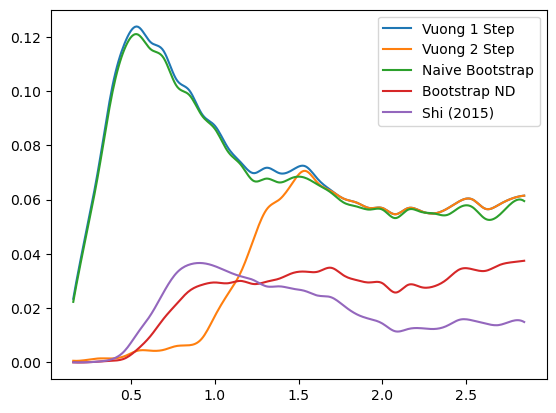

0.0006324555320336759 3.017088168272582


In [9]:
nobs =250
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.54, 5th: 4.05, 10th: 11.07, 30th: 91.64, 50th: 282.55, 70th: 672.86, 90th: 1599.93, 95th: 2307.76, 99th: 3928.19
bonus term 1.4209288763767536 // variance stats 1.0296613004056394 //part1 3.465724215775732 //part2 0.409994791249917
0.31137700161953324 -0.03070886176916786 2.5473954650871486
-2.530480751133974 -0.03070886176916786 -0.2944622876663587
---
Quantiles: 1th: 0.50, 5th: 3.23, 10th: 9.09, 30th: 84.07, 50th: 248.53, 70th: 575.29, 90th: 1481.24, 95th: 2137.80, 99th: 3517.29
bonus term 2.4148419171205577 // variance stats 0.2882751881547902 //part1 3.465724215775732 //part2 0.6967784413221247
1.8393310872734916 -0.48656619194771505 3.0013171366385496
-2.990352746967624 -0.48656619194771505 -1.828366697602566
---
Quantiles: 1th: 0.65, 5th: 3.61, 10th: 10.87, 30th: 95.04, 50th: 291.12, 70th: 677.23, 90th: 1741.47, 95th: 2474.31, 99th: 4257.16
bonus term 3.008445288297242 // variance stats 0.11837766052165641 //part1 3.465724215775732 //part2 0.8680567468706862
2.7

1.4648242031465029 -0.3713489092633047 2.964421465208941
-2.8939913609076906 -0.3713489092633047 -1.3943940988452528
---
Quantiles: 1th: 0.59, 5th: 3.55, 10th: 10.70, 30th: 103.43, 50th: 323.09, 70th: 756.63, 90th: 1899.39, 95th: 2625.23, 99th: 4413.85
bonus term 2.7710463040881814 // variance stats 0.21294556310675622 //part1 3.465724215775732 //part2 0.7995576484345103
2.340914960767058 -0.5155921387052377 3.1403168466002582
-3.2011776474093048 -0.5155921387052377 -2.4017757615761046
---
Quantiles: 1th: 0.44, 5th: 3.06, 10th: 10.22, 30th: 97.73, 50th: 313.36, 70th: 727.73, 90th: 1804.59, 95th: 2589.64, 99th: 4365.67
bonus term 1.3384461457928583 // variance stats 1.2826738936896374 //part1 3.465724215775732 //part2 0.38619522571944587
0.14845838984719278 0.07214657709966121 2.51152658883771
-2.5284339017385236 0.07214657709966121 -0.16536570274800605
---
Quantiles: 1th: 0.47, 5th: 3.57, 10th: 11.76, 30th: 98.25, 50th: 295.28, 70th: 729.50, 90th: 1929.09, 95th: 2724.03, 99th: 4626.73


0.11648153475991063 -0.11508781975035925 2.5539624177336697
-2.5868660708195432 -0.11508781975035925 -0.14938518784578456
---
Quantiles: 1th: 0.48, 5th: 3.78, 10th: 11.22, 30th: 97.46, 50th: 284.11, 70th: 651.70, 90th: 1664.68, 95th: 2270.74, 99th: 3907.06
bonus term 1.7032579043552722 // variance stats 0.7703479442658536 //part1 3.465724215775732 //part2 0.4914580036698138
0.7710917757087286 -0.22648009850744885 2.6870822799571377
-2.6354240330018164 -0.22648009850744885 -0.719433528753407
---
Quantiles: 1th: 0.77, 5th: 4.38, 10th: 12.67, 30th: 106.26, 50th: 332.47, 70th: 796.75, 90th: 1977.77, 95th: 2885.36, 99th: 5098.62
bonus term 1.4888931787298956 // variance stats 1.174345898079309 //part1 3.465724215775732 //part2 0.4296052097719025
0.32936337406472915 -0.0286732777152227 2.5579638728754235
-2.648422983395062 -0.0286732777152227 -0.4198224845843675
---
Quantiles: 1th: 0.66, 5th: 3.88, 10th: 11.77, 30th: 110.15, 50th: 338.28, 70th: 770.24, 90th: 1964.72, 95th: 2742.79, 99th: 487

1.7443773335361197 -0.5763618033600113 2.9826426131021284
-2.9674279682917506 -0.5763618033600113 -1.7291626887257419
---
Quantiles: 1th: 0.61, 5th: 3.90, 10th: 12.23, 30th: 101.27, 50th: 302.15, 70th: 684.32, 90th: 1654.23, 95th: 2317.08, 99th: 3913.53
bonus term 1.060927723222724 // variance stats 1.6768858481639606 //part1 3.465724215775732 //part2 0.3061200652935557
-0.2642613696704922 0.08952985052298773 2.3201551212866556
-2.3861168161159405 0.08952985052298773 0.19829967484120717
---
Quantiles: 1th: 0.45, 5th: 3.73, 10th: 11.07, 30th: 94.21, 50th: 288.09, 70th: 660.80, 90th: 1625.68, 95th: 2269.15, 99th: 4026.91
bonus term 1.3960385694178996 // variance stats 1.0778492697176865 //part1 3.465724215775732 //part2 0.40281294254840894
0.21292116516349605 -0.26481567362991737 2.5916755930805793
-2.5791559736723033 -0.26481567362991737 -0.20040154575522037
---
Quantiles: 1th: 0.38, 5th: 2.66, 10th: 6.89, 30th: 67.28, 50th: 197.95, 70th: 475.95, 90th: 1232.74, 95th: 1765.98, 99th: 3132

0.22751285905243193 -0.21754756026430178 2.475177106763495
-2.540792157103127 -0.21754756026430178 -0.29312790939206457
---
Quantiles: 1th: 0.59, 5th: 3.52, 10th: 11.50, 30th: 96.02, 50th: 293.11, 70th: 689.65, 90th: 1732.92, 95th: 2456.41, 99th: 4381.12
bonus term 0.8589569695919707 // variance stats 2.3519354518559252 //part1 3.465724215775732 //part2 0.24784342784173624
-0.5923941611782229 0.43967762010714134 2.293451452210297
-2.310308100362164 0.43967762010714134 0.5755375130263556
---
Quantiles: 1th: 0.46, 5th: 3.46, 10th: 10.49, 30th: 92.88, 50th: 275.86, 70th: 665.43, 90th: 1657.38, 95th: 2402.26, 99th: 4297.26
bonus term 1.161381426590968 // variance stats 1.470651432862751 //part1 3.465724215775732 //part2 0.33510497497303504
-0.10146961555668929 -0.17144781332684678 2.3630626828859023
-2.424232468738625 -0.17144781332684678 0.040299829703966464
---
Quantiles: 1th: 0.51, 5th: 3.33, 10th: 10.77, 30th: 101.06, 50th: 318.81, 70th: 732.00, 90th: 1780.55, 95th: 2588.04, 99th: 4528

0.6459545385677619 -0.6191983504047558 2.6923609958037713
-2.7147359063600023 -0.6191983504047558 -0.668329449123993
---
Quantiles: 1th: 0.53, 5th: 3.42, 10th: 10.54, 30th: 94.15, 50th: 291.53, 70th: 679.73, 90th: 1673.72, 95th: 2405.54, 99th: 4020.20
bonus term 1.0194351479068013 // variance stats 1.7961603477340071 //part1 3.465724215775732 //part2 0.2941477983927297
-0.3666572010863777 0.11207819139925423 2.373527452987264
-2.4055274968999805 0.11207819139925423 0.33465715717366123
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.58, 5th: 3.78, 10th: 10.64, 30th: 103.21, 50th: 315.00, 70th: 727.74, 90th: 1833.47, 95th: 2601.43, 99th: 4433.81
bonus term 1.4382453142582887 // variance stats 1.1558775504594827 //part1 3.465724215775732 //part2 0.41499127591038476
0.28162219502625846 -0.6223486222915944 2.5365805712932916
-2.594868433490319 -0.6223486222915944 -0.3399100572232857
---
Quantiles: 1th: 0.54, 5th: 3.45, 10th: 9.47, 30th: 84.14, 50th: 245.83, 70th: 592.23, 90th: 1513.93,

0.6499469079073861 -0.8169283287114589 2.6731646348491163
-2.66348270543007 -0.8169283287114589 -0.6402649784883401
---
Quantiles: 1th: 0.40, 5th: 3.47, 10th: 9.82, 30th: 84.62, 50th: 275.75, 70th: 670.91, 90th: 1683.89, 95th: 2451.15, 99th: 4211.14
bonus term 0.8737211867849094 // variance stats 2.234039495990059 //part1 3.465724215775732 //part2 0.2521034947927455
-0.49438753060583424 0.25421230354234214 2.314533912342211
-2.241829904175653 0.25421230354234214 0.5670915387723922
---
Quantiles: 1th: 0.65, 5th: 4.02, 10th: 11.22, 30th: 98.12, 50th: 306.78, 70th: 708.55, 90th: 1729.30, 95th: 2432.68, 99th: 4132.65
bonus term 2.3012844607433576 // variance stats 0.3913208457386416 //part1 3.465724215775732 //part2 0.6640125749960349
1.6820371925951492 -1.5074080591919656 3.005214710222947
-2.9205317288915658 -1.5074080591919656 -1.5973542112637682
---
Quantiles: 1th: 0.50, 5th: 3.66, 10th: 10.00, 30th: 89.59, 50th: 284.08, 70th: 660.15, 90th: 1640.90, 95th: 2331.51, 99th: 3988.37
bonus t

-0.766607370098085 0.7258884044705284 2.343090987564984
-2.2219761842387697 0.7258884044705284 0.8877221734242995
---
Quantiles: 1th: 0.56, 5th: 3.37, 10th: 10.26, 30th: 92.28, 50th: 277.92, 70th: 677.11, 90th: 1760.82, 95th: 2467.16, 99th: 4387.90
bonus term 1.1302910469805587 // variance stats 1.6270731978899877 //part1 3.465724215775732 //part2 0.32613415742532353
-0.261528181398264 -0.7350055332164274 2.4061786770677895
-2.522110275359381 -0.7350055332164274 0.145596583106672
---
Quantiles: 1th: 0.43, 5th: 3.76, 10th: 10.86, 30th: 102.06, 50th: 312.23, 70th: 709.52, 90th: 1854.64, 95th: 2578.09, 99th: 4357.07
bonus term 0.9605278645307842 // variance stats 2.163252467700399 //part1 3.465724215775732 //part2 0.2771506919559638
-0.5719995120756491 -0.20527904493908206 2.3343920794757445
-2.4930552411372173 -0.20527904493908206 0.4133363504141759
---
Quantiles: 1th: 0.52, 5th: 3.66, 10th: 10.71, 30th: 97.06, 50th: 293.42, 70th: 680.80, 90th: 1665.24, 95th: 2401.31, 99th: 4301.81
bonus

-0.7240546701545465 0.020898934327337762 2.2358191369538023
-2.237490678065348 0.020898934327337762 0.722383129043001
---
Quantiles: 1th: 0.52, 5th: 3.27, 10th: 12.02, 30th: 98.17, 50th: 297.84, 70th: 720.15, 90th: 1714.21, 95th: 2416.98, 99th: 4255.68
bonus term 1.0923087977165273 // variance stats 1.6657450395073612 //part1 3.465724215775732 //part2 0.3151747599374511
-0.2285741991283937 -0.9427036378803948 2.382686662565857
-2.4131917945614485 -0.9427036378803948 0.19806906713280237
---
Quantiles: 1th: 0.57, 5th: 4.19, 10th: 13.96, 30th: 116.42, 50th: 351.70, 70th: 849.94, 90th: 2129.75, 95th: 3051.71, 99th: 5393.45
bonus term 1.5210933395819308 // variance stats 1.2176580125064096 //part1 3.465724215775732 //part2 0.4388962435781881
0.3936390417604719 -1.2197064126339678 2.580950895007822
-2.6485476374033894 -1.2197064126339678 -0.46123578415603905
---
Quantiles: 1th: 0.49, 5th: 3.79, 10th: 11.14, 30th: 104.50, 50th: 316.88, 70th: 725.71, 90th: 1867.40, 95th: 2566.70, 99th: 4562.50

-0.9567980505325675 -0.013407296707825414 2.0813763418543636
-2.299772811650073 -0.013407296707825414 0.7384015807368584
---
Quantiles: 1th: 0.51, 5th: 3.57, 10th: 10.53, 30th: 88.47, 50th: 270.76, 70th: 672.46, 90th: 1788.34, 95th: 2492.49, 99th: 4341.91
bonus term 0.5345149440427529 // variance stats 4.385821974181563 //part1 3.465724215775732 //part2 0.15422893189529582
-1.157098868106771 0.5721047234405047 2.1686695655006663
-2.226128756192277 0.5721047234405047 1.0996396774151604
---
Quantiles: 1th: 0.57, 5th: 3.76, 10th: 11.21, 30th: 97.73, 50th: 298.94, 70th: 690.40, 90th: 1764.09, 95th: 2539.83, 99th: 4271.10
bonus term 0.6393661424699207 // variance stats 3.4874980150613966 //part1 3.465724215775732 //part2 0.18448269471632253
-0.9630904374810981 0.4353277216777818 2.226983354588325
-2.2418227224209395 0.4353277216777818 0.9482510696484837
---
Quantiles: 1th: 0.64, 5th: 3.52, 10th: 11.17, 30th: 93.96, 50th: 291.28, 70th: 678.36, 90th: 1807.41, 95th: 2525.90, 99th: 4277.52
bonu

Quantiles: 1th: 0.51, 5th: 3.82, 10th: 10.94, 30th: 96.09, 50th: 309.29, 70th: 724.22, 90th: 1908.81, 95th: 2665.07, 99th: 4318.44
bonus term 1.012551332301244 // variance stats 2.0681844929530704 //part1 3.465724215775732 //part2 0.2921615423674457
-0.304592374182859 -0.663738539676426 2.3417857347324165
-2.329695038785347 -0.663738539676426 0.3166830701299285
---
Quantiles: 1th: 0.55, 5th: 4.37, 10th: 11.90, 30th: 98.75, 50th: 298.20, 70th: 716.05, 90th: 1792.10, 95th: 2599.92, 99th: 4318.31
bonus term 0.7699890436639157 // variance stats 2.8058822110672588 //part1 3.465724215775732 //part2 0.22217262416870331
-0.768630286680899 -0.26719514053900245 2.2852996559080947
-2.3086083740087306 -0.26719514053900245 0.7453215685802631
---
Quantiles: 1th: 0.77, 5th: 3.83, 10th: 12.44, 30th: 101.23, 50th: 302.50, 70th: 716.81, 90th: 1771.31, 95th: 2558.58, 99th: 4280.93
bonus term 0.7217828351045049 // variance stats 3.0114724129823656 //part1 3.465724215775732 //part2 0.2082632056581422
-0.78

Quantiles: 1th: 0.78, 5th: 4.52, 10th: 14.28, 30th: 123.76, 50th: 378.06, 70th: 888.53, 90th: 2205.69, 95th: 3156.15, 99th: 5462.56
bonus term 0.6069233277287258 // variance stats 4.646318607416324 //part1 3.465724215775732 //part2 0.17512164556142512
-0.9607104697567334 0.43369871302602603 2.140353774535202
-2.1745571252141853 0.43369871302602603 0.9265071190777503
---
Quantiles: 1th: 0.47, 5th: 3.27, 10th: 10.96, 30th: 98.05, 50th: 286.52, 70th: 636.21, 90th: 1551.46, 95th: 2317.80, 99th: 3998.95
bonus term 0.7384361171473908 // variance stats 2.5625605948436934 //part1 3.465724215775732 //part2 0.21306834334540575
-0.9459774689324744 -0.5538194991780047 2.268906993098035
-2.422849703227256 -0.5538194991780047 0.7920347588032535
---
Quantiles: 1th: 0.56, 5th: 3.55, 10th: 11.19, 30th: 88.42, 50th: 265.87, 70th: 641.83, 90th: 1586.55, 95th: 2204.58, 99th: 3670.69
bonus term 0.9870034572039496 // variance stats 1.781877617497897 //part1 3.465724215775732 //part2 0.2847899589676465
-0.47

Quantiles: 1th: 0.65, 5th: 4.07, 10th: 11.64, 30th: 100.15, 50th: 310.61, 70th: 749.66, 90th: 1858.77, 95th: 2644.25, 99th: 4382.61
bonus term 0.45271293246651606 // variance stats 5.532459728995846 //part1 3.465724215775732 //part2 0.13062578101448427
-1.2196450577105291 1.003350259080716 2.1171067408834823
-2.125070922643561 1.003350259080716 1.21168087595045
---
Quantiles: 1th: 0.54, 5th: 4.37, 10th: 12.69, 30th: 102.99, 50th: 320.04, 70th: 746.52, 90th: 1916.67, 95th: 2734.54, 99th: 4657.46
bonus term 0.5535455418629797 // variance stats 4.5094835949608365 //part1 3.465724215775732 //part2 0.15972002023221563
-1.0452602099931574 0.2987851865443735 2.17781640424377
-2.152351293719117 0.2987851865443735 1.0707253205178104
---
Quantiles: 1th: 0.60, 5th: 3.99, 10th: 11.53, 30th: 87.54, 50th: 274.40, 70th: 661.87, 90th: 1624.75, 95th: 2269.48, 99th: 3755.03
bonus term 0.6028186489736751 // variance stats 3.4508181393992308 //part1 3.465724215775732 //part2 0.17393728163068695
-0.9963083

Quantiles: 1th: 0.63, 5th: 4.04, 10th: 10.24, 30th: 89.04, 50th: 273.50, 70th: 673.34, 90th: 1658.12, 95th: 2336.52, 99th: 4078.98
bonus term 0.5739302361794597 // variance stats 3.736283792668574 //part1 3.465724215775732 //part2 0.16560181954668224
-0.9919449583116964 -0.1406669654437329 2.2524812611940113
-2.1398054306706156 -0.1406669654437329 1.1046207888350923
---
Quantiles: 1th: 0.55, 5th: 3.90, 10th: 11.61, 30th: 101.55, 50th: 313.77, 70th: 776.90, 90th: 1970.64, 95th: 2704.90, 99th: 4586.19
bonus term 0.4691885210364646 // variance stats 5.628532666550497 //part1 3.465724215775732 //part2 0.13537964703041042
-1.259373128962297 1.0791403852146595 2.2641026828570925
-2.197750171035226 1.0791403852146595 1.3257256407841633
---
Quantiles: 1th: 0.41, 5th: 3.10, 10th: 11.22, 30th: 96.98, 50th: 281.22, 70th: 670.22, 90th: 1666.42, 95th: 2352.64, 99th: 4418.31
bonus term 1.386138503059058 // variance stats 1.1180745032784023 //part1 3.465724215775732 //part2 0.3999563775875337
0.26147

Quantiles: 1th: 0.44, 5th: 3.12, 10th: 9.47, 30th: 74.18, 50th: 229.78, 70th: 528.33, 90th: 1330.34, 95th: 1862.36, 99th: 3324.16
bonus term 0.2856272499944239 // variance stats 6.623954609507614 //part1 3.465724215775732 //part2 0.0824148813382983
-1.4759326466703797 1.7192548737388045 2.0752462476649898
-2.047187146659227 1.7192548737388045 1.503991747676142
---
Quantiles: 1th: 0.49, 5th: 2.99, 10th: 9.27, 30th: 81.53, 50th: 249.77, 70th: 596.25, 90th: 1476.49, 95th: 2173.70, 99th: 3538.00
bonus term 0.8207412651917049 // variance stats 2.127952941485071 //part1 3.465724215775732 //part2 0.23681666921324798
-0.7067329068044257 -2.19963331334523 2.4237092460513727
-2.3482154371878354 -2.19963331334523 0.782226715667963
---
Quantiles: 1th: 0.63, 5th: 4.18, 10th: 12.48, 30th: 117.40, 50th: 327.78, 70th: 794.38, 90th: 1976.88, 95th: 2813.76, 99th: 4790.60
bonus term 0.7452512503130607 // variance stats 3.227277975324472 //part1 3.465724215775732 //part2 0.21503478174077714
-0.77382883037

-1.3082057098143398 1.013310252319101 2.091792005719043
-2.0775505516103987 1.013310252319101 1.3224471639229844
---
Quantiles: 1th: 0.51, 5th: 3.65, 10th: 11.87, 30th: 98.57, 50th: 302.83, 70th: 690.89, 90th: 1671.23, 95th: 2385.00, 99th: 3988.20
bonus term 0.5668258565809806 // variance stats 3.8223783772546307 //part1 3.465724215775732 //part2 0.16355192199103127
-1.0983699696486202 -0.8522107993949555 2.2004835799358333
-2.232021682810581 -0.8522107993949555 1.0668318667738719
---
Quantiles: 1th: 0.49, 5th: 4.13, 10th: 12.97, 30th: 120.99, 50th: 360.83, 70th: 842.79, 90th: 2228.16, 95th: 3183.67, 99th: 5151.52
bonus term 0.5006137387748018 // variance stats 5.901997359031632 //part1 3.465724215775732 //part2 0.14444707876525295
-1.2345059937738752 0.7849876588958737 2.1699117544125546
-2.2357334713234787 0.7849876588958737 1.1686842768629508
---
Quantiles: 1th: 0.63, 5th: 3.99, 10th: 11.70, 30th: 91.61, 50th: 268.85, 70th: 663.37, 90th: 1631.05, 95th: 2344.37, 99th: 4274.47
bonus t

-1.624491582742671 0.9305872072648628 2.117170896157801
-2.4082166154824796 0.9305872072648628 1.3334458634179924
---
Quantiles: 1th: 0.61, 5th: 4.28, 10th: 12.02, 30th: 121.50, 50th: 356.41, 70th: 815.07, 90th: 2040.66, 95th: 2966.12, 99th: 5081.70
bonus term 0.5903040468139693 // variance stats 4.445405752516254 //part1 3.465724215775732 //part2 0.17032631855903219
-1.003707662739025 -0.23111954447953623 2.2258608299126394
-2.1843157563669635 -0.23111954447953623 1.045252736284701
---
Quantiles: 1th: 0.51, 5th: 3.37, 10th: 9.52, 30th: 86.03, 50th: 265.42, 70th: 638.73, 90th: 1578.84, 95th: 2218.07, 99th: 3827.83
bonus term 0.3812763066340509 // variance stats 5.71202938707036 //part1 3.465724215775732 //part2 0.11001345834111902
-1.201482339346763 0.540469220544979 1.935883711963273
-1.9640349526148646 0.540469220544979 1.1733310986951715
---
Quantiles: 1th: 0.45, 5th: 3.07, 10th: 9.59, 30th: 90.28, 50th: 275.03, 70th: 643.30, 90th: 1601.51, 95th: 2230.89, 99th: 3750.29
bonus term 0.

-1.3288139110116475 0.2948527033219535 2.152602796606553
-2.1282139916921685 0.2948527033219535 1.353202715926032
---
Quantiles: 1th: 0.49, 5th: 3.68, 10th: 11.85, 30th: 92.76, 50th: 278.08, 70th: 670.51, 90th: 1777.06, 95th: 2511.58, 99th: 4129.09
bonus term 0.5837000076784128 // variance stats 3.9239604542824553 //part1 3.465724215775732 //part2 0.1684207892311372
-1.1140355283807435 -0.9668095898792569 2.0646213429388873
-2.2814355437375693 -0.9668095898792569 0.8972213275820616
---
Quantiles: 1th: 0.45, 5th: 3.54, 10th: 12.47, 30th: 109.28, 50th: 310.31, 70th: 724.92, 90th: 1761.28, 95th: 2504.81, 99th: 4340.70
bonus term 0.5843210323122426 // variance stats 3.8841434550730463 //part1 3.465724215775732 //part2 0.16859997966729567
-1.0976218911977356 -1.0963783377688774 2.1944530866313943
-2.266263955822221 -1.0963783377688774 1.025811022006909
---
Quantiles: 1th: 0.61, 5th: 3.46, 10th: 10.85, 30th: 83.67, 50th: 253.11, 70th: 575.99, 90th: 1534.19, 95th: 2105.21, 99th: 3573.81
bonus

-1.10855870082061 -1.1379175609356924 2.2231129449477054
-2.1751930573486873 -1.1379175609356924 1.1564785884196285
---
Quantiles: 1th: 0.54, 5th: 3.02, 10th: 9.76, 30th: 92.10, 50th: 261.08, 70th: 631.13, 90th: 1587.08, 95th: 2249.83, 99th: 4023.90
bonus term 0.3327581696784109 // variance stats 6.682507344555841 //part1 3.465724215775732 //part2 0.09601403601697998
-1.3814526884371678 0.9724999931472318 2.1179270522273437
-2.0469690277939896 0.9724999931472318 1.4524107128705221
---
Quantiles: 1th: 0.65, 5th: 4.09, 10th: 13.55, 30th: 114.15, 50th: 350.55, 70th: 801.68, 90th: 2026.28, 95th: 2854.76, 99th: 4881.45
bonus term 0.506887948129603 // variance stats 5.289611167870549 //part1 3.465724215775732 //part2 0.14625743901441574
-1.1956049065379644 -0.21252658033572625 2.1850490236790616
-2.2093808027971704 -0.21252658033572625 1.1712731274198553
---
Quantiles: 1th: 0.48, 5th: 3.89, 10th: 11.33, 30th: 101.19, 50th: 306.28, 70th: 754.08, 90th: 1907.96, 95th: 2724.27, 99th: 4619.44
bon

1.076923076923077 [0.97142857 0.00142857 0.02714286]
Quantiles: 1th: 0.55, 5th: 3.82, 10th: 11.99, 30th: 105.75, 50th: 321.87, 70th: 741.97, 90th: 1857.17, 95th: 2646.69, 99th: 4522.49
bonus term 0.36844825378983936 // variance stats 6.981843003915809 //part1 3.465724215775732 //part2 0.10631205221485568
-1.3965974952100964 0.4008716507158803 2.048421384853166
-2.133494002789775 0.4008716507158803 1.3115248772734875
---
Quantiles: 1th: 0.46, 5th: 3.19, 10th: 9.80, 30th: 87.09, 50th: 267.46, 70th: 669.43, 90th: 1658.49, 95th: 2290.31, 99th: 3905.60
bonus term 0.3965367059980359 // variance stats 5.740737046155915 //part1 3.465724215775732 //part2 0.11441669368642456
-1.2429395528745917 -0.014699381187947039 2.2107163346177323
-2.0360129648706637 -0.014699381187947039 1.4176429226216605
---
Quantiles: 1th: 0.51, 5th: 3.46, 10th: 8.90, 30th: 74.49, 50th: 215.57, 70th: 509.69, 90th: 1291.64, 95th: 1802.54, 99th: 3040.21
bonus term 0.36715179282882326 // variance stats 4.874979109862088 //p

Quantiles: 1th: 0.48, 5th: 3.73, 10th: 11.68, 30th: 94.93, 50th: 286.05, 70th: 697.38, 90th: 1737.64, 95th: 2437.01, 99th: 4102.31
bonus term 0.3645936967356453 // variance stats 6.609764414367116 //part1 3.465724215775732 //part2 0.10519985839497571
-1.4093413765776386 0.33377361948182327 2.225625099634397
-2.1385287700489295 0.33377361948182327 1.4964377061631067
---
Quantiles: 1th: 0.44, 5th: 3.35, 10th: 10.77, 30th: 97.41, 50th: 302.09, 70th: 699.73, 90th: 1897.11, 95th: 2741.72, 99th: 4737.36
bonus term 0.5969260337123764 // variance stats 4.077426630864141 //part1 3.465724215775732 //part2 0.17223702653408232
-0.9912125298385067 -1.6610956620851831 2.1211243151377692
-2.1850645972632594 -1.6610956620851831 0.9272722477130165
---
Quantiles: 1th: 0.54, 5th: 3.75, 10th: 13.27, 30th: 114.16, 50th: 356.98, 70th: 813.44, 90th: 2091.93, 95th: 2971.72, 99th: 5355.02
bonus term 0.5125979537748835 // variance stats 5.389726133171526 //part1 3.465724215775732 //part2 0.1479050039358509
-1.1

Quantiles: 1th: 0.61, 5th: 4.14, 10th: 10.65, 30th: 86.46, 50th: 261.15, 70th: 593.97, 90th: 1538.58, 95th: 2197.68, 99th: 3825.18
bonus term 0.351806069678005 // variance stats 6.090298157970389 //part1 3.465724215775732 //part2 0.10151011672440888
-1.444132827647384 -0.6079430033967016 2.2685624952984598
-2.1477449670033937 -0.6079430033967016 1.5649503559424496
---
Quantiles: 1th: 0.53, 5th: 3.14, 10th: 9.67, 30th: 86.59, 50th: 253.09, 70th: 586.42, 90th: 1468.51, 95th: 2171.67, 99th: 3678.35
bonus term 0.28030604268467985 // variance stats 7.463224619004784 //part1 3.465724215775732 //part2 0.08087950028128219
-1.2980081392040803 1.0390661777504122 1.9506610953855883
-1.8586202245734398 1.0390661777504122 1.3900490100162288
---
Quantiles: 1th: 0.51, 5th: 3.70, 10th: 10.78, 30th: 97.07, 50th: 301.98, 70th: 711.95, 90th: 1803.50, 95th: 2457.60, 99th: 4138.06
bonus term 0.31684497148589547 // variance stats 8.01569016036379 //part1 3.465724215775732 //part2 0.09142244210997502
-1.4708

Quantiles: 1th: 0.42, 5th: 3.35, 10th: 10.25, 30th: 90.89, 50th: 271.87, 70th: 638.27, 90th: 1571.81, 95th: 2261.80, 99th: 3891.78
bonus term 0.42606503526981465 // variance stats 5.014924786903614 //part1 3.465724215775732 //part2 0.12293679725882305
-1.258154201741689 -1.8251645090626025 2.163501653199006
-2.1102842722813184 -1.8251645090626025 1.3113715826593764
---
Quantiles: 1th: 0.53, 5th: 3.73, 10th: 11.78, 30th: 101.52, 50th: 300.52, 70th: 680.05, 90th: 1684.19, 95th: 2460.07, 99th: 4504.38
bonus term 0.36196676158050284 // variance stats 6.458411427446678 //part1 3.465724215775732 //part2 0.10444188257474604
-1.4276507710207949 -0.2701255433791978 2.0629670561866074
-2.151584294181801 -0.2701255433791978 1.3390335330256018
---
Quantiles: 1th: 0.66, 5th: 3.59, 10th: 11.99, 30th: 102.84, 50th: 297.50, 70th: 698.89, 90th: 1700.57, 95th: 2487.10, 99th: 4141.52
bonus term 0.41010656424232905 // variance stats 5.666470096543424 //part1 3.465724215775732 //part2 0.11833214032886773
-

Quantiles: 1th: 0.49, 5th: 3.58, 10th: 10.40, 30th: 89.81, 50th: 289.04, 70th: 687.05, 90th: 1740.94, 95th: 2488.41, 99th: 4353.79
bonus term 0.33578241555849203 // variance stats 7.2573226808924876 //part1 3.465724215775732 //part2 0.09688665186630667
-1.3977644280154962 0.21804681971479187 1.9924148957257737
-2.06932925913248 0.21804681971479187 1.3208500646087895
---
Quantiles: 1th: 0.42, 5th: 3.20, 10th: 10.79, 30th: 82.63, 50th: 255.21, 70th: 622.42, 90th: 1539.83, 95th: 2179.14, 99th: 3616.01
bonus term 0.2839894874120529 // variance stats 7.7152311130301 //part1 3.465724215775732 //part2 0.0819423213536013
-1.4357877193493107 0.44163414506860715 2.1207669296551694
-2.0037666941734167 0.44163414506860715 1.5527879548310637
---
Quantiles: 1th: 0.50, 5th: 3.37, 10th: 10.36, 30th: 88.95, 50th: 269.97, 70th: 622.14, 90th: 1518.26, 95th: 2137.66, 99th: 3578.97
bonus term 0.36279589321210987 // variance stats 5.807231088934226 //part1 3.465724215775732 //part2 0.10468112020012688
-1.40

-1.1940235836158728 -0.9175480701295069 2.160956849260532
-2.093573784255126 -0.9175480701295069 1.2614066486212792
---
Quantiles: 1th: 0.57, 5th: 3.96, 10th: 11.47, 30th: 111.87, 50th: 363.60, 70th: 868.01, 90th: 2205.22, 95th: 3143.22, 99th: 5328.67
bonus term 0.47529386149119496 // variance stats 6.204954060250792 //part1 3.465724215775732 //part2 0.13714128185032462
-1.157371646457614 -1.244389577055205 2.059770089761415
-2.107959369440004 -1.244389577055205 1.109182366779025
---
1.3846153846153846 [0.97285714 0.00285714 0.02428571]
Quantiles: 1th: 0.51, 5th: 3.39, 10th: 9.31, 30th: 81.04, 50th: 245.56, 70th: 579.80, 90th: 1497.43, 95th: 2093.43, 99th: 3636.05
bonus term 0.30189942929854385 // variance stats 7.017952182723049 //part1 3.465724215775732 //part2 0.08711005564849013
-1.4203564284989652 -0.016679625099762774 2.1461436420978455
-2.024155287096053 -0.016679625099762774 1.542344783500758
---
Quantiles: 1th: 0.39, 5th: 3.58, 10th: 10.54, 30th: 92.00, 50th: 294.93, 70th: 694

-1.508887759040531 -0.49352594672659855 2.0575729074760747
-2.178927410196881 -0.49352594672659855 1.3875332563197245
---
Quantiles: 1th: 0.37, 5th: 2.86, 10th: 10.01, 30th: 78.20, 50th: 241.30, 70th: 547.81, 90th: 1347.72, 95th: 1975.09, 99th: 3213.68
bonus term 0.2404338716541923 // variance stats 8.08514260534238 //part1 3.465724215775732 //part2 0.06937478480248206
-1.6919480316137205 0.7867482284742244 2.0745347166848775
-2.172815774922105 0.7867482284742244 1.5936669733764928
---
Quantiles: 1th: 0.42, 5th: 2.79, 10th: 7.95, 30th: 66.26, 50th: 197.55, 70th: 492.80, 90th: 1247.58, 95th: 1750.50, 99th: 3221.62
bonus term 0.27897314123367833 // variance stats 6.373373645355397 //part1 3.465724215775732 //part2 0.0804949049216935
-1.5219737224028826 -0.5258565955145973 2.1010117751741433
-2.079920004870239 -0.5258565955145973 1.5430654927067866
---
Quantiles: 1th: 0.62, 5th: 4.28, 10th: 12.24, 30th: 113.47, 50th: 326.96, 70th: 762.59, 90th: 1882.29, 95th: 2693.54, 99th: 4892.66
bonus 

-1.4700427691577542 0.6022087396709803 1.9824758232532949
-2.0179226966584696 0.6022087396709803 1.4345958957525795
---
Quantiles: 1th: 0.61, 5th: 3.80, 10th: 9.63, 30th: 83.28, 50th: 250.84, 70th: 568.05, 90th: 1447.20, 95th: 2097.72, 99th: 3773.59
bonus term 0.24848908256851002 // variance stats 8.379521723815108 //part1 3.465724215775732 //part2 0.07169903520811184
-1.4886782938493812 0.3451137607619941 2.0519359213705215
-1.9856564589864012 0.3451137607619941 1.5549577562335015
---
Quantiles: 1th: 0.53, 5th: 3.56, 10th: 10.35, 30th: 92.17, 50th: 266.22, 70th: 648.50, 90th: 1655.44, 95th: 2427.20, 99th: 4172.69
bonus term 0.30983201433008656 // variance stats 7.540920396526941 //part1 3.465724215775732 //part2 0.08939892358421166
-1.4431438728760582 -0.42484477845221175 2.1012199200966757
-2.0628079015362313 -0.42484477845221175 1.4815558914365028
---
Quantiles: 1th: 0.55, 5th: 3.11, 10th: 9.66, 30th: 92.87, 50th: 305.13, 70th: 715.54, 90th: 1741.16, 95th: 2470.04, 99th: 4307.68
bon

-1.5418431615330512 -1.1968329283715582 2.0427875070254387
-2.1137763345276466 -1.1968329283715582 1.4708543340308426
---
Quantiles: 1th: 0.52, 5th: 3.06, 10th: 9.56, 30th: 91.96, 50th: 276.55, 70th: 652.38, 90th: 1571.86, 95th: 2141.77, 99th: 3716.88
bonus term 0.2989900958159183 // variance stats 7.445312774535216 //part1 3.465724215775732 //part2 0.08627059662016281
-1.4835538664966148 -0.7366818918942281 2.050395583604266
-2.0815340581284514 -0.7366818918942281 1.4524153919724299
---
Quantiles: 1th: 0.58, 5th: 4.39, 10th: 13.45, 30th: 112.94, 50th: 341.28, 70th: 794.13, 90th: 2030.81, 95th: 2839.48, 99th: 4811.89
bonus term 0.2801805973354902 // variance stats 10.325969134094091 //part1 3.465724215775732 //part2 0.08084330428258772
-1.5384408607153808 1.0947586921429637 2.0468428572507795
-2.0988020553863613 1.0947586921429637 1.486481662579799
---
Quantiles: 1th: 0.45, 5th: 3.57, 10th: 11.86, 30th: 104.63, 50th: 321.30, 70th: 751.03, 90th: 1948.73, 95th: 2726.15, 99th: 4708.39
bon

-1.4818793911469168 1.0411793339492872 2.2084185867070434
-2.04077942677603 1.0411793339492872 1.6495185510779296
---
Quantiles: 1th: 0.50, 5th: 3.81, 10th: 10.81, 30th: 110.43, 50th: 339.16, 70th: 800.10, 90th: 1983.76, 95th: 2741.84, 99th: 4861.58
bonus term 0.31714113742644134 // variance stats 8.807765938300545 //part1 3.465724215775732 //part2 0.0915078978248867
-1.3800302406605374 -0.24153247240819112 2.110110735571908
-2.01431251551342 -0.24153247240819112 1.4758284607190255
---
Quantiles: 1th: 0.46, 5th: 4.04, 10th: 12.72, 30th: 107.61, 50th: 320.15, 70th: 750.03, 90th: 1971.41, 95th: 2856.40, 99th: 4719.73
bonus term 0.2964379694026415 // variance stats 9.42581152551336 //part1 3.465724215775732 //part2 0.08553420611290326
-1.4270457516877009 0.400484645298171 1.9936921970400432
-2.0199216904929838 0.400484645298171 1.40081625823476
---
Quantiles: 1th: 0.59, 5th: 3.68, 10th: 10.60, 30th: 90.94, 50th: 286.12, 70th: 676.12, 90th: 1715.52, 95th: 2366.07, 99th: 4252.31
bonus term 

Quantiles: 1th: 0.44, 5th: 2.53, 10th: 7.81, 30th: 69.04, 50th: 216.96, 70th: 530.15, 90th: 1319.07, 95th: 1835.30, 99th: 3151.49
bonus term 0.24045563864438033 // variance stats 7.912510023928108 //part1 3.465724215775732 //part2 0.06938106544942128
-1.6218250082048373 -0.39872742653093585 2.0021857437785293
-2.1027362854935983 -0.39872742653093585 1.5212744664897684
---
Quantiles: 1th: 0.49, 5th: 3.46, 10th: 11.71, 30th: 96.09, 50th: 298.56, 70th: 699.40, 90th: 1780.40, 95th: 2535.47, 99th: 4500.47
bonus term 0.3121528118311126 // variance stats 8.043929409991664 //part1 3.465724215775732 //part2 0.09006856645148364
-1.4996108978160068 -0.5309124722404931 2.047446663856906
-2.123916521478232 -0.5309124722404931 1.4231410401946811
---
Quantiles: 1th: 0.56, 5th: 3.90, 10th: 12.72, 30th: 105.37, 50th: 316.31, 70th: 755.28, 90th: 1930.38, 95th: 2702.02, 99th: 4808.50
bonus term 0.3439076183876525 // variance stats 7.83652064797606 //part1 3.465724215775732 //part2 0.09923109773772804
-1.

Quantiles: 1th: 0.58, 5th: 3.77, 10th: 11.26, 30th: 95.50, 50th: 271.62, 70th: 680.75, 90th: 1677.50, 95th: 2341.45, 99th: 4020.27
bonus term 0.21362179438061657 // variance stats 11.42080295007511 //part1 3.465724215775732 //part2 0.06163842853052912
-1.5660078588167583 1.8363897431842628 2.168459626505879
-1.9932514475779912 1.8363897431842628 1.7412160377446464
---
Quantiles: 1th: 0.70, 5th: 3.65, 10th: 10.72, 30th: 83.38, 50th: 258.66, 70th: 599.66, 90th: 1529.65, 95th: 2133.33, 99th: 3635.36
bonus term 0.243337609829664 // variance stats 9.058900036243822 //part1 3.465724215775732 //part2 0.07021262936098849
-1.6358546795044628 0.13890494958237476 2.0509618644051755
-2.1225298991637906 0.13890494958237476 1.5642866447458474
---
Quantiles: 1th: 0.57, 5th: 3.68, 10th: 10.32, 30th: 87.63, 50th: 265.69, 70th: 610.29, 90th: 1495.03, 95th: 2214.91, 99th: 3582.36
bonus term 0.25022663709017173 // variance stats 8.59168617329974 //part1 3.465724215775732 //part2 0.07220038915709386
-1.563

Quantiles: 1th: 0.51, 5th: 3.65, 10th: 12.11, 30th: 102.35, 50th: 330.11, 70th: 782.77, 90th: 1913.17, 95th: 2755.49, 99th: 4720.38
bonus term 0.27906368795695125 // variance stats 9.770158641426239 //part1 3.465724215775732 //part2 0.08052103127152271
-1.438447583376564 0.14693098488721393 2.0543941348345034
-1.9965749592904665 0.14693098488721393 1.4962667589206007
---
Quantiles: 1th: 0.65, 5th: 3.73, 10th: 11.48, 30th: 91.41, 50th: 282.54, 70th: 670.50, 90th: 1714.90, 95th: 2444.51, 99th: 4388.68
bonus term 0.2591446079398478 // variance stats 9.489736904087405 //part1 3.465724215775732 //part2 0.07477358029823603
-1.5368478661629903 0.4007281679557304 1.9844780983431927
-2.055137082042686 0.4007281679557304 1.466188882463497
---
Quantiles: 1th: 0.68, 5th: 4.92, 10th: 14.64, 30th: 122.85, 50th: 373.59, 70th: 870.10, 90th: 2113.67, 95th: 3057.25, 99th: 5006.04
bonus term 0.31050334481713343 // variance stats 9.605400420773138 //part1 3.465724215775732 //part2 0.08959262927031068
-1.4

Quantiles: 1th: 0.60, 5th: 3.71, 10th: 10.94, 30th: 88.21, 50th: 268.93, 70th: 636.00, 90th: 1562.26, 95th: 2179.45, 99th: 3871.74
bonus term 0.20489600519151815 // variance stats 11.118956440061117 //part1 3.465724215775732 //part2 0.05912068948211343
-1.5483363716890743 1.2097334856218085 2.0842883743504794
-1.9581283820721105 1.2097334856218085 1.674496363967443
---
Quantiles: 1th: 0.44, 5th: 2.76, 10th: 8.74, 30th: 65.38, 50th: 198.72, 70th: 485.58, 90th: 1206.10, 95th: 1753.06, 99th: 3130.25
bonus term 0.17797339664851208 // variance stats 9.964192748229971 //part1 3.465724215775732 //part2 0.05135244051975911
-1.678379816979268 0.6363133353397921 2.0446725097779677
-2.0343266102762922 0.6363133353397921 1.6887257164809433
---
Quantiles: 1th: 0.72, 5th: 4.10, 10th: 11.62, 30th: 105.06, 50th: 292.01, 70th: 699.94, 90th: 1673.04, 95th: 2454.49, 99th: 4274.97
bonus term 0.2672502118887433 // variance stats 8.954584603884722 //part1 3.465724215775732 //part2 0.07711237110911456
-1.514

Quantiles: 1th: 0.51, 5th: 3.18, 10th: 10.24, 30th: 80.87, 50th: 265.29, 70th: 608.06, 90th: 1551.10, 95th: 2260.44, 99th: 4016.41
bonus term 0.1807605453566563 // variance stats 12.606089714444254 //part1 3.465724215775732 //part2 0.052156644355556926
-1.7329923957527087 1.7555596314028135 1.9377069234096476
-2.0945134864660213 1.7555596314028135 1.576185832696335
---
Quantiles: 1th: 0.44, 5th: 3.37, 10th: 10.13, 30th: 88.47, 50th: 264.64, 70th: 607.89, 90th: 1506.99, 95th: 2163.10, 99th: 3896.49
bonus term 0.21250443790699072 // variance stats 10.31740384072269 //part1 3.465724215775732 //part2 0.061316026514656154
-1.6875811588515075 0.29168867798962544 1.9969315507432583
-2.1125900346654887 0.29168867798962544 1.571922674929277
---
Quantiles: 1th: 0.53, 5th: 3.36, 10th: 9.71, 30th: 89.43, 50th: 268.38, 70th: 596.30, 90th: 1532.13, 95th: 2115.76, 99th: 3729.78
bonus term 0.22926637517339502 // variance stats 9.67251252338682 //part1 3.465724215775732 //part2 0.06615251557806899
-1.6

Quantiles: 1th: 0.58, 5th: 3.82, 10th: 12.08, 30th: 101.45, 50th: 304.06, 70th: 723.73, 90th: 1768.85, 95th: 2507.99, 99th: 4070.33
bonus term 0.233327583278593 // variance stats 10.958842478630611 //part1 3.465724215775732 //part2 0.06732433648831672
-1.508818943743949 0.602305028180369 2.0860384012429556
-1.975474110301135 0.602305028180369 1.6193832346857693
---
Quantiles: 1th: 0.38, 5th: 3.06, 10th: 10.61, 30th: 93.90, 50th: 274.73, 70th: 642.20, 90th: 1613.86, 95th: 2329.95, 99th: 4056.96
bonus term 0.2427257211187458 // variance stats 9.583499852439669 //part1 3.465724215775732 //part2 0.07003607500385503
-1.6718005216421559 -0.17746520341868677 2.1421822367059167
-2.1572519638796477 -0.17746520341868677 1.6567307944684255
---
Quantiles: 1th: 0.42, 5th: 3.66, 10th: 11.76, 30th: 95.51, 50th: 293.40, 70th: 704.00, 90th: 1800.75, 95th: 2490.38, 99th: 4359.69
bonus term 0.21474844112944239 // variance stats 12.191341113203093 //part1 3.465724215775732 //part2 0.06196351116223346
-1.6

Quantiles: 1th: 0.58, 5th: 3.98, 10th: 10.94, 30th: 87.77, 50th: 260.47, 70th: 611.29, 90th: 1570.64, 95th: 2281.20, 99th: 4165.54
bonus term 0.1798484963142351 // variance stats 12.833256137813008 //part1 3.465724215775732 //part2 0.05189348174202016
-1.721848719651905 1.8766128963933577 2.0963917734327135
-2.0815457122803753 1.8766128963933577 1.7366947808042434
---
Quantiles: 1th: 0.39, 5th: 3.09, 10th: 9.32, 30th: 81.43, 50th: 249.28, 70th: 588.16, 90th: 1467.46, 95th: 2098.82, 99th: 3614.76
bonus term 0.20785009801882834 // variance stats 10.286476850008224 //part1 3.465724215775732 //part2 0.05997306337091375
-1.619991155650589 -0.10953004983470402 2.0869196771484684
-2.0356913516882456 -0.10953004983470402 1.6712194811108119
---
Quantiles: 1th: 0.46, 5th: 3.04, 10th: 9.09, 30th: 80.80, 50th: 240.87, 70th: 555.45, 90th: 1455.52, 95th: 2005.74, 99th: 3366.89
bonus term 0.19791874474196058 // variance stats 10.747344384097108 //part1 3.465724215775732 //part2 0.05710747088330007
-1

Quantiles: 1th: 0.65, 5th: 3.70, 10th: 11.68, 30th: 97.07, 50th: 301.96, 70th: 724.86, 90th: 1788.41, 95th: 2622.99, 99th: 4453.41
bonus term 0.2516646916296268 // variance stats 10.214392072509884 //part1 3.465724215775732 //part2 0.07261532538684609
-1.634844893235628 -1.464462229789249 2.129518775483605
-2.138174276494882 -1.464462229789249 1.626189392224351
---
Quantiles: 1th: 0.81, 5th: 3.97, 10th: 11.65, 30th: 97.11, 50th: 282.08, 70th: 656.67, 90th: 1681.93, 95th: 2426.75, 99th: 4467.71
bonus term 0.19497243085092011 // variance stats 12.618211238139425 //part1 3.465724215775732 //part2 0.056257341528624626
-1.7390428375853995 1.3765241281693712 2.1001646911194163
-2.12898769928724 1.3765241281693712 1.7102198294175759
---
Quantiles: 1th: 0.50, 5th: 3.69, 10th: 12.00, 30th: 102.58, 50th: 315.09, 70th: 754.55, 90th: 1958.05, 95th: 2682.10, 99th: 4657.36
bonus term 0.25272437835708317 // variance stats 11.132728381551287 //part1 3.465724215775732 //part2 0.07292108737524458
-1.640

Quantiles: 1th: 0.53, 5th: 3.98, 10th: 11.51, 30th: 100.69, 50th: 308.68, 70th: 729.16, 90th: 1813.41, 95th: 2548.10, 99th: 4573.83
bonus term 0.21241636215456894 // variance stats 12.420781315163522 //part1 3.465724215775732 //part2 0.061290613138709836
-1.664117390753534 0.5246124997024175 2.0188991915366303
-2.088950115062672 0.5246124997024175 1.5940664672274922
---
Quantiles: 1th: 0.52, 5th: 3.83, 10th: 11.32, 30th: 99.92, 50th: 314.96, 70th: 718.14, 90th: 1763.58, 95th: 2513.09, 99th: 4093.61
bonus term 0.25785920090445996 // variance stats 9.811660930179665 //part1 3.465724215775732 //part2 0.07440268897643472
-1.5552702350100251 -1.550079176685995 2.0157606704622713
-2.0709886368189454 -1.550079176685995 1.5000422686533514
---
Quantiles: 1th: 0.48, 5th: 3.59, 10th: 10.14, 30th: 96.79, 50th: 273.27, 70th: 651.02, 90th: 1642.16, 95th: 2255.09, 99th: 3710.78
bonus term 0.20454396020418056 // variance stats 11.70898928710465 //part1 3.465724215775732 //part2 0.05901911042809201
-1.

Quantiles: 1th: 0.50, 5th: 3.40, 10th: 10.04, 30th: 86.18, 50th: 251.56, 70th: 605.53, 90th: 1530.59, 95th: 2161.67, 99th: 3667.03
bonus term 0.1687905988923247 // variance stats 13.370118685676257 //part1 3.465724215775732 //part2 0.04870283622799581
-1.7493532928516233 1.6205655744276912 2.1128098780682363
-2.086934490636273 1.6205655744276912 1.775228680283587
---
2.230769230769231 [0.95857143 0.01142857 0.03      ]
Quantiles: 1th: 0.67, 5th: 4.03, 10th: 10.80, 30th: 87.06, 50th: 293.29, 70th: 698.14, 90th: 1714.13, 95th: 2406.90, 99th: 4260.61
bonus term 0.20025548777561322 // variance stats 12.500280588644431 //part1 3.465724215775732 //part2 0.057781714674256066
-1.516014766552992 0.8205061153076811 2.022902480001237
-1.9165257421042186 0.8205061153076811 1.6223915044500106
---
Quantiles: 1th: 0.58, 5th: 3.74, 10th: 12.27, 30th: 102.48, 50th: 318.45, 70th: 743.69, 90th: 1879.07, 95th: 2681.75, 99th: 4779.34
bonus term 0.230402523837411 // variance stats 11.800183760348053 //part1

Quantiles: 1th: 0.44, 5th: 2.91, 10th: 10.40, 30th: 86.72, 50th: 264.41, 70th: 627.48, 90th: 1533.58, 95th: 2189.80, 99th: 3862.98
bonus term 0.20108749745284765 // variance stats 11.134528086053484 //part1 3.465724215775732 //part2 0.05802178273086807
-1.6371881318364867 0.18735135215148807 1.994077477644458
-2.039363126742182 0.18735135215148807 1.591902482738763
---
Quantiles: 1th: 0.66, 5th: 4.20, 10th: 12.38, 30th: 102.85, 50th: 320.79, 70th: 784.11, 90th: 1984.04, 95th: 2820.69, 99th: 5159.34
bonus term 0.22959540725822025 // variance stats 12.50627014157471 //part1 3.465724215775732 //part2 0.06624745448963254
-1.5226485149739954 0.4215608347370964 2.031846207510975
-1.981839329490436 0.4215608347370964 1.5726553929945344
---
Quantiles: 1th: 0.41, 5th: 3.52, 10th: 12.71, 30th: 99.83, 50th: 286.86, 70th: 673.73, 90th: 1740.81, 95th: 2449.43, 99th: 4236.86
bonus term 0.22658997259472918 // variance stats 11.128964530612542 //part1 3.465724215775732 //part2 0.06538026642838678
-1.5

Quantiles: 1th: 0.43, 5th: 2.93, 10th: 9.28, 30th: 80.09, 50th: 248.89, 70th: 615.12, 90th: 1518.07, 95th: 2149.49, 99th: 3763.20
bonus term 0.20959084849851486 // variance stats 10.547204946812439 //part1 3.465724215775732 //part2 0.06047533948156408
-1.6506144486093248 -0.9093020137962694 2.224480547819295
-2.0697961456063547 -0.9093020137962694 1.805298850822265
---
Quantiles: 1th: 0.61, 5th: 3.49, 10th: 11.27, 30th: 101.67, 50th: 319.57, 70th: 758.25, 90th: 1933.06, 95th: 2755.79, 99th: 4600.56
bonus term 0.21524027056229897 // variance stats 13.055268531177544 //part1 3.465724215775732 //part2 0.06210542361753438
-1.7001909486392324 0.31818233996331585 2.0267508168446016
-2.1306714897638304 0.31818233996331585 1.5962702757200036
---
Quantiles: 1th: 0.49, 5th: 3.71, 10th: 11.73, 30th: 112.76, 50th: 328.54, 70th: 785.69, 90th: 1957.89, 95th: 2777.05, 99th: 4678.59
bonus term 0.26755666834090136 // variance stats 10.46617613005824 //part1 3.465724215775732 //part2 0.07720079604805319

Quantiles: 1th: 0.72, 5th: 4.08, 10th: 11.07, 30th: 82.53, 50th: 245.11, 70th: 593.23, 90th: 1475.98, 95th: 2046.30, 99th: 3642.48
bonus term 0.1754463242247241 // variance stats 12.378954943996039 //part1 3.465724215775732 //part2 0.05062327909015518
-1.7272864879685133 0.5740894265301959 1.896249156783983
-2.078179136417962 0.5740894265301959 1.5453565083345346
---
Quantiles: 1th: 0.45, 5th: 3.03, 10th: 9.46, 30th: 78.14, 50th: 235.09, 70th: 534.95, 90th: 1337.70, 95th: 1890.92, 99th: 3158.05
bonus term 0.16319614262638726 // variance stats 12.106253890320005 //part1 3.465724215775732 //part2 0.047088611922301814
-1.6874153704743902 -0.20204342367763214 2.2584978454739284
-2.013807655727165 -0.20204342367763214 1.9321055602211539
---
Quantiles: 1th: 0.50, 5th: 3.52, 10th: 12.20, 30th: 100.15, 50th: 296.20, 70th: 698.67, 90th: 1742.44, 95th: 2448.97, 99th: 4275.99
bonus term 0.18284083258883851 // variance stats 13.991234603474778 //part1 3.465724215775732 //part2 0.052756890394382784

Quantiles: 1th: 0.58, 5th: 4.16, 10th: 12.83, 30th: 103.59, 50th: 294.69, 70th: 666.49, 90th: 1751.77, 95th: 2541.04, 99th: 4520.64
bonus term 0.18221900631034835 // variance stats 14.116793354455808 //part1 3.465724215775732 //part2 0.052577468651689094
-1.6286357990601332 0.5497057375043133 2.0704022684204806
-1.99307381168083 0.5497057375043133 1.7059642557997836
---
Quantiles: 1th: 0.62, 5th: 3.88, 10th: 10.81, 30th: 85.91, 50th: 263.42, 70th: 621.82, 90th: 1559.65, 95th: 2288.34, 99th: 4023.09
bonus term 0.19442976360894212 // variance stats 11.735421885844266 //part1 3.465724215775732 //part2 0.056100760332836515
-1.6830288010543202 -0.8535479982798426 2.0505946262866583
-2.0718883282722045 -0.8535479982798426 1.6617350990687743
---
Quantiles: 1th: 0.51, 5th: 3.65, 10th: 11.28, 30th: 95.61, 50th: 285.58, 70th: 683.38, 90th: 1708.63, 95th: 2422.55, 99th: 4123.39
bonus term 0.18821796177110925 // variance stats 13.305948612565231 //part1 3.465724215775732 //part2 0.0543084071474453

Quantiles: 1th: 0.54, 5th: 3.55, 10th: 10.93, 30th: 91.88, 50th: 277.35, 70th: 656.99, 90th: 1668.28, 95th: 2384.79, 99th: 4076.50
bonus term 0.18150836339472634 // variance stats 13.499579733118175 //part1 3.465724215775732 //part2 0.0523724197581888
-1.6023032985213568 0.7730695680926051 1.9801784708431271
-1.9653200253108094 0.7730695680926051 1.6171617440536745
---
Quantiles: 1th: 0.40, 5th: 3.39, 10th: 10.60, 30th: 85.17, 50th: 271.29, 70th: 642.35, 90th: 1559.80, 95th: 2258.94, 99th: 3819.18
bonus term 0.19257276153390604 // variance stats 11.85649550241289 //part1 3.465724215775732 //part2 0.0555649409890517
-1.5176746965256975 -0.5252023824985952 1.9889489581262898
-1.9028202195935098 -0.5252023824985952 1.6038034350584776
---
Quantiles: 1th: 0.62, 5th: 3.55, 10th: 11.59, 30th: 96.35, 50th: 275.03, 70th: 621.16, 90th: 1597.13, 95th: 2308.63, 99th: 3745.56
bonus term 0.20804675950923057 // variance stats 11.184147875400848 //part1 3.465724215775732 //part2 0.060029808073653525
-

Quantiles: 1th: 0.54, 5th: 3.94, 10th: 11.13, 30th: 96.58, 50th: 278.61, 70th: 668.57, 90th: 1657.39, 95th: 2421.65, 99th: 4010.05
bonus term 0.17819010337621277 // variance stats 13.674983977597936 //part1 3.465724215775732 //part2 0.051414969074891764
-1.6757992197996858 0.5651722932549559 1.9440040799014104
-2.0321794265521116 0.5651722932549559 1.587623873148985
---
Quantiles: 1th: 0.49, 5th: 3.80, 10th: 12.42, 30th: 108.78, 50th: 343.34, 70th: 836.95, 90th: 2150.83, 95th: 3021.28, 99th: 5196.89
bonus term 0.2167148946880376 // variance stats 14.420627184229884 //part1 3.465724215775732 //part2 0.06253091163502471
-1.5761038440519515 0.29997037827993855 2.02490178132281
-2.0095336334280263 0.29997037827993855 1.5914719919467348
---
Quantiles: 1th: 0.56, 5th: 4.30, 10th: 12.20, 30th: 110.19, 50th: 341.36, 70th: 832.71, 90th: 2072.33, 95th: 2904.87, 99th: 5027.56
bonus term 0.19929984920125327 // variance stats 15.189362848407093 //part1 3.465724215775732 //part2 0.05750597473799397


Quantiles: 1th: 0.55, 5th: 4.06, 10th: 12.32, 30th: 101.28, 50th: 300.43, 70th: 700.14, 90th: 1776.98, 95th: 2481.61, 99th: 4272.55
bonus term 0.17684275731630802 // variance stats 14.779476297198151 //part1 3.465724215775732 //part2 0.051026205868121954
-1.6384023649686303 0.8621974285096433 2.033808201060993
-1.9920878796012464 0.8621974285096433 1.6801226864283765
---
Quantiles: 1th: 0.94, 5th: 5.37, 10th: 13.50, 30th: 111.57, 50th: 333.01, 70th: 816.74, 90th: 1988.67, 95th: 2764.43, 99th: 4586.37
bonus term 0.19559657523908813 // variance stats 14.868984673074154 //part1 3.465724215775732 //part2 0.05643743213864112
-1.780056921631835 0.48273807303603816 2.0069258789082496
-2.171250072110011 0.48273807303603816 1.615732728430073
---
Quantiles: 1th: 0.75, 5th: 3.81, 10th: 12.95, 30th: 105.82, 50th: 322.25, 70th: 780.55, 90th: 1908.14, 95th: 2749.27, 99th: 4858.27
bonus term 0.20903156602710335 // variance stats 13.295029417444525 //part1 3.465724215775732 //part2 0.06031396412778789

Quantiles: 1th: 0.47, 5th: 3.59, 10th: 11.73, 30th: 113.02, 50th: 363.13, 70th: 862.77, 90th: 2251.27, 95th: 3126.65, 99th: 5209.60
bonus term 0.21744068975114456 // variance stats 15.040245610884767 //part1 3.465724215775732 //part2 0.06274033252887516
-1.530342148710383 -0.24206785253708119 2.051559677203801
-1.965223528212672 -0.24206785253708119 1.6166782977015122
---
Quantiles: 1th: 0.46, 5th: 3.07, 10th: 9.33, 30th: 80.40, 50th: 241.48, 70th: 604.64, 90th: 1468.25, 95th: 2115.63, 99th: 3722.20
bonus term 0.14347563330090946 // variance stats 15.204356471393563 //part1 3.465724215775732 //part2 0.04139845653263999
-1.7189644594265392 1.0881181579659853 1.888415738303082
-2.0059157260283578 1.0881181579659853 1.601464471701263
---
Quantiles: 1th: 0.56, 5th: 3.99, 10th: 11.50, 30th: 86.34, 50th: 282.23, 70th: 652.19, 90th: 1568.16, 95th: 2254.82, 99th: 4105.47
bonus term 0.1759704828922617 // variance stats 13.110782888444163 //part1 3.465724215775732 //part2 0.05077451982222257
-1.

Quantiles: 1th: 0.55, 5th: 3.49, 10th: 10.92, 30th: 86.90, 50th: 254.64, 70th: 599.19, 90th: 1508.00, 95th: 2105.99, 99th: 3504.05
bonus term 0.1784322339236219 // variance stats 12.424543106678133 //part1 3.465724215775732 //part2 0.05148483341848464
-1.6595392958850819 -1.890911110978111 2.119545281527839
-2.0164037637323258 -1.890911110978111 1.7626808136805951
---
Quantiles: 1th: 0.45, 5th: 3.71, 10th: 11.55, 30th: 95.56, 50th: 286.03, 70th: 663.86, 90th: 1612.10, 95th: 2357.99, 99th: 3893.29
bonus term 0.1695247324105133 // variance stats 14.01806203366187 //part1 3.465724215775732 //part2 0.04891466309951861
-1.7468416223346943 -0.3842197571102386 2.1555440220458877
-2.085891087155721 -0.3842197571102386 1.8164945572248608
---
Quantiles: 1th: 0.43, 5th: 3.48, 10th: 9.17, 30th: 78.76, 50th: 246.79, 70th: 561.95, 90th: 1418.94, 95th: 2034.24, 99th: 3520.45
bonus term 0.15113734146505028 // variance stats 13.916700411314201 //part1 3.465724215775732 //part2 0.04360916566213889
-1.56

-1.6448202116399455 0.6802973582319723 2.0291861306135184
-1.9591042672269776 0.6802973582319723 1.7149020750264865
---
Quantiles: 1th: 0.51, 5th: 3.84, 10th: 12.25, 30th: 111.34, 50th: 340.63, 70th: 804.07, 90th: 2109.60, 95th: 3103.54, 99th: 5246.83
bonus term 0.18679863293076487 // variance stats 16.560476974455113 //part1 3.465724215775732 //part2 0.05389887403056212
-1.6171921353521426 0.7110162291896742 2.020731467250936
-1.9907894012136724 0.7110162291896742 1.6471342013894064
---
Quantiles: 1th: 0.50, 5th: 3.61, 10th: 9.92, 30th: 88.35, 50th: 278.63, 70th: 669.55, 90th: 1740.52, 95th: 2498.62, 99th: 3873.70
bonus term 0.1681684513892075 // variance stats 15.2630347308869 //part1 3.465724215775732 //part2 0.04852332179915429
-1.680316339122347 0.2246264418748788 2.0343088224128705
-2.016653241900762 0.2246264418748788 1.6979719196344554
---
Quantiles: 1th: 0.40, 5th: 3.62, 10th: 9.79, 30th: 88.69, 50th: 276.06, 70th: 642.93, 90th: 1592.86, 95th: 2299.38, 99th: 3940.57
bonus term

-1.6068887247304138 0.4205565068039148 2.0241263988522853
-1.9498225928219128 0.4205565068039148 1.681192530760786
---
Quantiles: 1th: 0.44, 5th: 3.54, 10th: 10.90, 30th: 99.17, 50th: 311.73, 70th: 763.04, 90th: 1867.27, 95th: 2718.82, 99th: 4936.21
bonus term 0.18961459429104702 // variance stats 14.428076803993923 //part1 3.465724215775732 //part2 0.054711391468465605
-1.6992656531927872 -1.0495956025742197 2.0299030718346223
-2.078494841774881 -1.0495956025742197 1.650673883252528
---
Quantiles: 1th: 0.45, 5th: 3.89, 10th: 12.85, 30th: 103.28, 50th: 311.59, 70th: 703.22, 90th: 1842.48, 95th: 2640.49, 99th: 4479.37
bonus term 0.1774003888807828 // variance stats 15.273491428850734 //part1 3.465724215775732 //part2 0.05118710486924169
-1.7623248656428592 0.18834088150588735 2.0057214704587047
-2.1171256434044246 0.18834088150588735 1.650920692697139
---
Quantiles: 1th: 0.62, 5th: 3.69, 10th: 10.59, 30th: 103.48, 50th: 322.57, 70th: 783.31, 90th: 2090.44, 95th: 3049.47, 99th: 5021.81
b

-1.6086206946595905 0.8832525962971838 2.000523962398835
-1.9735277775436217 0.8832525962971838 1.635616879514804
---
Quantiles: 1th: 0.39, 5th: 3.22, 10th: 10.74, 30th: 95.51, 50th: 274.93, 70th: 636.68, 90th: 1592.00, 95th: 2221.60, 99th: 3888.08
bonus term 0.16180274990667187 // variance stats 14.537869832791833 //part1 3.465724215775732 //part2 0.04668656241317678
-1.6796227747982198 -0.8498443672535142 2.199033920484586
-2.0032282746115637 -0.8498443672535142 1.8754284206712417
---
Quantiles: 1th: 0.53, 5th: 3.79, 10th: 12.07, 30th: 107.87, 50th: 336.10, 70th: 797.07, 90th: 2021.35, 95th: 2865.93, 99th: 5142.12
bonus term 0.20319479863665488 // variance stats 14.514394344379511 //part1 3.465724215775732 //part2 0.05862982337478744
-1.8089176447274045 -0.9935921486252296 2.1099708031671924
-2.2153072420007143 -0.9935921486252296 1.7035812058938826
---
Quantiles: 1th: 0.59, 5th: 3.22, 10th: 11.23, 30th: 105.04, 50th: 331.20, 70th: 776.95, 90th: 2058.59, 95th: 2937.94, 99th: 5049.43


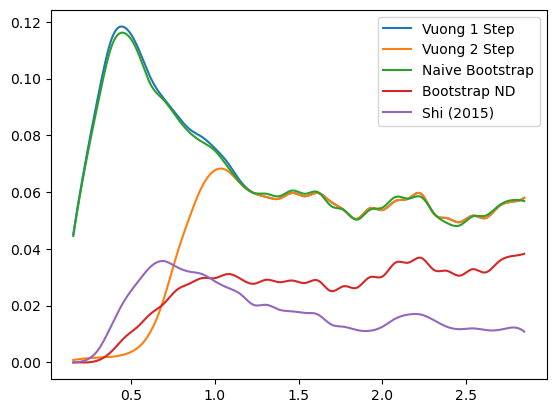

0.00044721359549995795 3.465724215775732


In [10]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# Extra Power Sims

Quantiles: 1th: 0.54, 5th: 2.94, 10th: 8.06, 30th: 70.83, 50th: 211.89, 70th: 503.04, 90th: 1255.48, 95th: 1767.77, 99th: 3004.62
bonus term 1.952798577483584 // variance stats 0.43275585311460707 //part1 3.017088168272582 //part2 0.6472461090196275
1.279441162984653 -0.47932847871146833 2.634133647673601
-2.6261559919825155 -0.47932847871146833 -1.2714635072935674
---
Quantiles: 1th: 0.71, 5th: 3.70, 10th: 10.52, 30th: 91.05, 50th: 289.39, 70th: 651.51, 90th: 1659.98, 95th: 2323.99, 99th: 4316.04
bonus term 2.1331060943761395 // variance stats 0.4350738543686584 //part1 3.017088168272582 //part2 0.7070082063917403
1.5870988705642708 -0.5400661423369638 2.7095599442617235
-2.6791133181880085 -0.5400661423369638 -1.5566522444905555
---
Quantiles: 1th: 0.43, 5th: 3.53, 10th: 9.46, 30th: 74.34, 50th: 215.73, 70th: 514.87, 90th: 1301.12, 95th: 1884.62, 99th: 3162.47
bonus term 1.2672142843190144 // variance stats 1.1363291002344946 //part1 3.017088168272582 //part2 0.4200123475491774
0.087

1.4298856186202784 -0.4141972368823304 2.6462859532478227
-2.706455922987397 -0.4141972368823304 -1.4900555883598523
---
Quantiles: 1th: 0.42, 5th: 3.12, 10th: 9.32, 30th: 76.73, 50th: 225.34, 70th: 524.99, 90th: 1352.38, 95th: 1887.37, 99th: 3130.70
bonus term 2.1506277914716456 // variance stats 0.34459687445021936 //part1 3.017088168272582 //part2 0.7128156923246218
1.5660989376822785 -0.5480108400634389 2.7504084770738366
-2.735156645261013 -0.5480108400634389 -1.5508471058694546
---
Quantiles: 1th: 0.45, 5th: 3.88, 10th: 12.80, 30th: 119.81, 50th: 365.63, 70th: 912.22, 90th: 2222.29, 95th: 3093.66, 99th: 5448.86
bonus term 0.7720255478504638 // variance stats 4.0872185717488 //part1 3.017088168272582 //part2 0.25588431785620736
-0.6503627105761374 0.68144049925167 2.2166471898736293
-2.194413806277065 0.68144049925167 0.6725960941727014
---
Quantiles: 1th: 0.74, 5th: 4.15, 10th: 12.15, 30th: 97.99, 50th: 293.56, 70th: 698.36, 90th: 1780.20, 95th: 2562.02, 99th: 4007.10
bonus term 

Quantiles: 1th: 0.49, 5th: 2.89, 10th: 9.33, 30th: 88.35, 50th: 266.66, 70th: 615.08, 90th: 1611.84, 95th: 2284.59, 99th: 4038.70
bonus term 1.9944535481204928 // variance stats 0.5226964351446245 //part1 3.017088168272582 //part2 0.6610524574965957
1.3413937323902572 -0.545405124741579 2.674037785483949
-2.647513363850728 -0.545405124741579 -1.3148693107570368
---
Quantiles: 1th: 0.59, 5th: 3.67, 10th: 10.91, 30th: 87.17, 50th: 252.92, 70th: 590.06, 90th: 1407.81, 95th: 1972.62, 99th: 3589.16
bonus term 1.6666738536797205 // variance stats 0.721421770329327 //part1 3.017088168272582 //part2 0.5524113849924267
0.8158293378671887 -0.34120647671873633 2.519679438521868
-2.5175183694922523 -0.34120647671873633 -0.8136682688375729
---
Quantiles: 1th: 0.65, 5th: 3.83, 10th: 11.33, 30th: 97.68, 50th: 294.56, 70th: 701.51, 90th: 1791.50, 95th: 2603.68, 99th: 4396.85
bonus term 1.6565408036611784 // variance stats 0.9305909732709549 //part1 3.017088168272582 //part2 0.5490528321582403
0.805840

Quantiles: 1th: 0.70, 5th: 4.25, 10th: 12.48, 30th: 100.80, 50th: 312.74, 70th: 729.04, 90th: 1911.95, 95th: 2725.79, 99th: 4630.92
bonus term 1.4451761429403227 // variance stats 1.3152704980011163 //part1 3.017088168272582 //part2 0.4789969872732459
0.4168408122206334 -0.2650492391697362 2.4536225959164955
-2.473511473660012 -0.2650492391697362 -0.43672968996414996
---
Quantiles: 1th: 0.74, 5th: 4.99, 10th: 14.03, 30th: 109.02, 50th: 328.66, 70th: 781.85, 90th: 1951.23, 95th: 2722.84, 99th: 4994.73
bonus term 2.489746506080293 // variance stats 0.2613816306702926 //part1 3.017088168272582 //part2 0.8252150309236022
2.1598862417318974 -0.7947878090076101 2.8212218183647173
-2.8196067704286887 -0.7947878090076101 -2.1582711937958687
---
Quantiles: 1th: 0.46, 5th: 3.19, 10th: 9.72, 30th: 88.08, 50th: 270.80, 70th: 634.70, 90th: 1555.52, 95th: 2226.26, 99th: 3752.87
bonus term 0.7468417763413664 // variance stats 2.9905371064517525 //part1 3.017088168272582 //part2 0.24753727259119734
-0

-0.6217206537746215 0.059494947257762436 2.1907665746457003
-2.3651437433482827 0.059494947257762436 0.44734348507203875
---
Quantiles: 1th: 0.53, 5th: 3.13, 10th: 10.46, 30th: 105.28, 50th: 332.30, 70th: 772.97, 90th: 1972.30, 95th: 2756.00, 99th: 4623.88
bonus term 1.0056799559519674 // variance stats 2.4948408969676876 //part1 3.017088168272582 //part2 0.33332799701632987
-0.2593195117657669 0.16902027781054946 2.395381754238536
-2.2706794236697014 0.16902027781054946 0.3840218423346012
---
Quantiles: 1th: 0.45, 5th: 3.48, 10th: 12.44, 30th: 100.43, 50th: 300.55, 70th: 732.75, 90th: 1823.47, 95th: 2573.70, 99th: 4422.05
bonus term 1.7134125228695776 // variance stats 0.877477297384756 //part1 3.017088168272582 //part2 0.5679027019785713
0.8614566017489463 -0.5577987831515799 2.582959560855467
-2.565368443990209 -0.5577987831515799 -0.8438654848836877
---
Quantiles: 1th: 0.68, 5th: 3.73, 10th: 10.44, 30th: 90.92, 50th: 289.20, 70th: 693.53, 90th: 1688.54, 95th: 2403.38, 99th: 4012.03

Quantiles: 1th: 0.68, 5th: 3.70, 10th: 11.60, 30th: 106.16, 50th: 310.52, 70th: 753.56, 90th: 1902.75, 95th: 2746.44, 99th: 4896.59
bonus term 1.903554161955818 // variance stats 0.7039619436274035 //part1 3.017088168272582 //part2 0.6309242739318712
1.1620593380290476 -0.6620067096791801 2.662143396667021
-2.6450489858825885 -0.6620067096791801 -1.1449649272446154
---
Quantiles: 1th: 0.51, 5th: 3.54, 10th: 9.91, 30th: 72.19, 50th: 208.17, 70th: 493.99, 90th: 1217.21, 95th: 1768.18, 99th: 3016.21
bonus term 0.8586437563962646 // variance stats 1.9351951242372925 //part1 3.017088168272582 //part2 0.28459352478514954
-0.5334954855318239 -0.07275911933584986 2.297085513093559
-2.250782998324353 -0.07275911933584986 0.5797980003010297
---
Quantiles: 1th: 0.54, 5th: 3.77, 10th: 10.33, 30th: 93.60, 50th: 294.51, 70th: 697.55, 90th: 1758.88, 95th: 2535.36, 99th: 4523.92
bonus term 1.4402354871473524 // variance stats 1.2179334390979477 //part1 3.017088168272582 //part2 0.4773594296291155
0.42

Quantiles: 1th: 0.66, 5th: 4.36, 10th: 11.65, 30th: 104.19, 50th: 324.59, 70th: 753.06, 90th: 1858.15, 95th: 2655.97, 99th: 4499.02
bonus term 1.185736265665808 // variance stats 1.815076886344386 //part1 3.017088168272582 //part2 0.393006832924175
-0.047428844754044595 -0.31138920332927156 2.363161544321642
-2.4189013760856604 -0.31138920332927156 -0.008310987009974274
---
Quantiles: 1th: 0.82, 5th: 4.49, 10th: 12.18, 30th: 87.31, 50th: 274.78, 70th: 636.62, 90th: 1600.06, 95th: 2270.65, 99th: 3935.32
bonus term 0.9846540702309162 // variance stats 2.0888120709388702 //part1 3.017088168272582 //part2 0.32635906387670294
-0.3399647185001956 -0.06261268138114884 2.2804844346706705
-2.309272858962028 -0.06261268138114884 0.31117629420883836
---
Quantiles: 1th: 0.74, 5th: 4.27, 10th: 13.22, 30th: 100.12, 50th: 296.88, 70th: 694.14, 90th: 1751.81, 95th: 2482.96, 99th: 4225.90
bonus term 1.2590161826945099 // variance stats 1.5471118023933121 //part1 3.017088168272582 //part2 0.417295124462

1.6873485659750478 -1.1262908676347057 2.71319487749482
-2.751114901907418 -1.1262908676347057 -1.7252685903876457
---
Quantiles: 1th: 0.76, 5th: 4.48, 10th: 14.62, 30th: 118.01, 50th: 347.81, 70th: 836.43, 90th: 2027.74, 95th: 2889.02, 99th: 4890.97
bonus term 1.2959155603008339 // variance stats 1.7032945558203265 //part1 3.017088168272582 //part2 0.4295252534972498
0.22338717228954502 -0.34361667413551233 2.3751206781079657
-2.368443948312123 -0.34361667413551233 -0.21671044249370214
---
Quantiles: 1th: 0.67, 5th: 4.48, 10th: 14.08, 30th: 120.13, 50th: 368.88, 70th: 842.22, 90th: 2166.50, 95th: 3035.77, 99th: 5182.49
bonus term 1.5159294574907352 // variance stats 1.3568638517647744 //part1 3.017088168272582 //part2 0.5024478480384194
0.5680651838811168 -0.46173736923989767 2.4520469781679557
-2.4637937311003535 -0.46173736923989767 -0.5798119368135146
---
Quantiles: 1th: 0.49, 5th: 2.80, 10th: 8.29, 30th: 73.92, 50th: 214.73, 70th: 511.70, 90th: 1310.08, 95th: 1825.94, 99th: 2997.2

Quantiles: 1th: 0.32, 5th: 2.81, 10th: 9.78, 30th: 85.30, 50th: 259.57, 70th: 592.32, 90th: 1460.96, 95th: 2103.04, 99th: 3483.61
bonus term 1.3619257643063414 // variance stats 1.1229398328928293 //part1 3.017088168272582 //part2 0.45140403208239843
0.29883282859950194 -1.3319548063410684 2.406677221353802
-2.425018700013181 -1.3319548063410684 -0.3171743072588809
---
Quantiles: 1th: 0.65, 5th: 3.53, 10th: 10.35, 30th: 92.69, 50th: 277.30, 70th: 651.31, 90th: 1623.43, 95th: 2249.23, 99th: 3970.64
bonus term 1.1875465946017172 // variance stats 1.5818089500250128 //part1 3.017088168272582 //part2 0.39360685812560814
-0.008410231085606554 -0.9355041369164446 2.350014442661868
-2.383503420289041 -0.9355041369164446 -0.02507874654156632
---
Quantiles: 1th: 0.74, 5th: 4.11, 10th: 12.37, 30th: 100.43, 50th: 302.33, 70th: 714.38, 90th: 1742.76, 95th: 2490.38, 99th: 4371.11
bonus term 1.0192179558275078 // variance stats 2.1605717519458607 //part1 3.017088168272582 //part2 0.3378151048237532


Quantiles: 1th: 0.61, 5th: 3.85, 10th: 10.97, 30th: 93.79, 50th: 279.76, 70th: 658.97, 90th: 1654.68, 95th: 2385.09, 99th: 3956.30
bonus term 0.9969732810318864 // variance stats 2.1204906691795085 //part1 3.017088168272582 //part2 0.3304422096496763
-0.3486389522529537 -0.48261629326352323 2.3628570372639905
-2.3425855143167267 -0.48261629326352323 0.36891047520021775
---
Quantiles: 1th: 0.42, 5th: 2.77, 10th: 7.64, 30th: 65.43, 50th: 201.90, 70th: 470.60, 90th: 1206.69, 95th: 1679.97, 99th: 2926.82
bonus term 1.030740502869239 // variance stats 1.4707221008176963 //part1 3.017088168272582 //part2 0.3416342000569986
-0.21816312434614188 -0.8467431960947392 2.3834262620548254
-2.2796441300846197 -0.8467431960947392 0.32194525631634735
---
Quantiles: 1th: 0.58, 5th: 3.89, 10th: 11.43, 30th: 94.37, 50th: 287.93, 70th: 700.49, 90th: 1729.80, 95th: 2451.05, 99th: 4354.04
bonus term 1.3484510728025514 // variance stats 1.35379581083975 //part1 3.017088168272582 //part2 0.44693790754368307
0

1.3042224086771408 -1.7575207719379906 2.631518620186865
-2.6130765211640554 -1.7575207719379906 -1.2857803096543314
---
Quantiles: 1th: 0.50, 5th: 2.91, 10th: 10.14, 30th: 98.38, 50th: 302.31, 70th: 729.19, 90th: 1846.79, 95th: 2555.61, 99th: 4419.79
bonus term 1.137337141502406 // variance stats 1.9304495707251366 //part1 3.017088168272582 //part2 0.37696516577226263
-0.0021930837465796173 -0.670117619007608 2.379472926060915
-2.2768673667513917 -0.670117619007608 0.10479864305610272
---
Quantiles: 1th: 0.55, 5th: 3.31, 10th: 9.33, 30th: 73.51, 50th: 232.40, 70th: 534.00, 90th: 1364.54, 95th: 1915.67, 99th: 3398.89
bonus term 1.584137992210382 // variance stats 0.7806484146460178 //part1 3.017088168272582 //part2 0.52505525323026
0.5937334022868163 -2.866196794015214 2.51074183117236
-2.574542582133948 -2.866196794015214 -0.6575341532484037
---
Quantiles: 1th: 0.57, 5th: 4.00, 10th: 12.06, 30th: 112.69, 50th: 337.43, 70th: 812.45, 90th: 2014.46, 95th: 2842.84, 99th: 5407.53
bonus ter

Quantiles: 1th: 0.54, 5th: 3.16, 10th: 9.62, 30th: 89.91, 50th: 294.77, 70th: 674.86, 90th: 1642.24, 95th: 2310.38, 99th: 4115.62
bonus term 0.7394108560795246 // variance stats 3.1994353008735064 //part1 3.017088168272582 //part2 0.2450743282397579
-0.7357345712280399 -0.4871839999718795 2.2756048963906297
-2.2145562833870893 -0.4871839999718795 0.7967831842315807
---
Quantiles: 1th: 0.65, 5th: 4.60, 10th: 15.15, 30th: 136.27, 50th: 378.32, 70th: 874.69, 90th: 2151.76, 95th: 2999.75, 99th: 5097.68
bonus term 1.9115460111877305 // variance stats 0.7870735727680706 //part1 3.017088168272582 //part2 0.63357313561114
1.2372077621158253 -1.8787127965415213 2.590180836571605
-2.5858842602596357 -1.8787127965415213 -1.2329111858038562
---
Quantiles: 1th: 0.53, 5th: 3.35, 10th: 10.14, 30th: 86.16, 50th: 273.64, 70th: 642.47, 90th: 1558.53, 95th: 2308.90, 99th: 3989.64
bonus term 1.2657432647271978 // variance stats 1.3638620712807203 //part1 3.017088168272582 //part2 0.4195247848696091
0.1047

-0.12174392652450997 -1.8523542412637524 2.3456178061611124
-2.3722903918333205 -1.8523542412637524 0.09507134085230168
---
Quantiles: 1th: 0.49, 5th: 2.97, 10th: 9.01, 30th: 78.64, 50th: 254.61, 70th: 582.31, 90th: 1497.59, 95th: 2132.18, 99th: 3690.19
bonus term 1.7615140356649162 // variance stats 0.6751185562769493 //part1 3.017088168272582 //part2 0.5838457272110353
0.9125751932029301 -2.704705441272831 2.5804735968933468
-2.610452878126902 -2.704705441272831 -0.9425544744364854
---
Quantiles: 1th: 0.46, 5th: 3.80, 10th: 10.47, 30th: 95.75, 50th: 283.00, 70th: 647.98, 90th: 1623.72, 95th: 2304.44, 99th: 3847.02
bonus term 0.774828845698702 // variance stats 2.9718031523371473 //part1 3.017088168272582 //part2 0.25681345803769673
-0.6580790504284207 -0.7493773735460131 2.2691662716888494
-2.207736741825825 -0.7493773735460131 0.7195085802914453
---
Quantiles: 1th: 0.48, 5th: 3.23, 10th: 9.70, 30th: 78.48, 50th: 230.99, 70th: 578.29, 90th: 1471.65, 95th: 2057.28, 99th: 3446.23
bonus

0.5470197378334959 -3.23700683304955 2.4989950262039238
-2.478417319361303 -3.23700683304955 -0.5264420309908752
---
Quantiles: 1th: 0.35, 5th: 2.45, 10th: 7.85, 30th: 69.48, 50th: 222.43, 70th: 539.36, 90th: 1290.98, 95th: 1864.62, 99th: 3240.50
bonus term 0.8675483481327846 // variance stats 2.0230299643897167 //part1 3.017088168272582 //part2 0.28754491077053773
-0.5009840101885153 -0.879073540304554 2.363139881770242
-2.2360807064540844 -0.879073540304554 0.6280431855046732
---
Quantiles: 1th: 0.60, 5th: 3.69, 10th: 10.84, 30th: 98.94, 50th: 269.31, 70th: 635.17, 90th: 1585.48, 95th: 2237.96, 99th: 3738.54
bonus term 0.944297826318045 // variance stats 2.20108506843038 //part1 3.017088168272582 //part2 0.31298317240052614
-0.3541835076932674 -1.2704801440689317 2.3260803523152243
-2.2427791603293574 -1.2704801440689317 0.43748469967913417
---
Quantiles: 1th: 0.48, 5th: 4.06, 10th: 12.31, 30th: 111.89, 50th: 337.29, 70th: 800.50, 90th: 2084.53, 95th: 2869.19, 99th: 5016.15
bonus ter

Quantiles: 1th: 0.64, 5th: 4.39, 10th: 12.52, 30th: 104.33, 50th: 286.07, 70th: 650.71, 90th: 1755.86, 95th: 2403.78, 99th: 4203.43
bonus term 1.2629803052498658 // variance stats 1.5423400798416849 //part1 3.017088168272582 //part2 0.41860901465567
0.050900937055163124 -2.3249110853908763 2.4455886151512103
-2.475059673444569 -2.3249110853908763 -0.08037199534852114
---
Quantiles: 1th: 0.56, 5th: 4.12, 10th: 13.56, 30th: 112.59, 50th: 338.84, 70th: 798.83, 90th: 1965.63, 95th: 2695.86, 99th: 4808.09
bonus term 1.797529214149593 // variance stats 0.8434469762851242 //part1 3.017088168272582 //part2 0.5957827925124107
0.9617414057897153 -3.02717580035311 2.616846509902135
-2.633317022509471 -3.02717580035311 -0.978211918397051
---
Quantiles: 1th: 0.33, 5th: 2.88, 10th: 8.45, 30th: 77.69, 50th: 238.52, 70th: 588.45, 90th: 1468.26, 95th: 2111.45, 99th: 3607.62
bonus term 0.761506382338133 // variance stats 2.7505357231202354 //part1 3.017088168272582 //part2 0.2523977888170665
-0.66187452

-0.4784392140571182 -1.127296382476175 2.2001276607050286
-2.2565566757105446 -1.127296382476175 0.42201019905160203
---
Quantiles: 1th: 0.61, 5th: 4.25, 10th: 13.01, 30th: 108.43, 50th: 351.52, 70th: 842.25, 90th: 2061.23, 95th: 3027.43, 99th: 5334.20
bonus term 1.6086549160854977 // variance stats 1.1413762383490613 //part1 3.017088168272582 //part2 0.5331812749133297
0.6979420287832078 -2.3222418637339866 2.5723806329363645
-2.5193678033877878 -2.3222418637339866 -0.6449291992346311
---
Quantiles: 1th: 0.43, 5th: 3.05, 10th: 9.51, 30th: 80.76, 50th: 240.52, 70th: 579.22, 90th: 1474.33, 95th: 2100.27, 99th: 3321.72
bonus term 1.388925268270196 // variance stats 1.093059237519429 //part1 3.017088168272582 //part2 0.460352893520317
0.290088995268513 -3.625392058795989 2.5106954791138785
-2.4877615412718788 -3.625392058795989 -0.26715505742651335
---
Quantiles: 1th: 0.68, 5th: 4.20, 10th: 12.02, 30th: 95.13, 50th: 275.78, 70th: 651.17, 90th: 1609.07, 95th: 2262.85, 99th: 4025.70
bonus t

Quantiles: 1th: 0.40, 5th: 3.19, 10th: 9.78, 30th: 90.32, 50th: 286.76, 70th: 672.04, 90th: 1661.41, 95th: 2373.98, 99th: 4208.99
bonus term 1.0236974967292447 // variance stats 2.0461053938404974 //part1 3.017088168272582 //part2 0.3392998280575133
-0.31536791194581326 -1.5880756490990917 2.2912910625478333
-2.3627629054043027 -1.5880756490990917 0.24389606908934347
---
Quantiles: 1th: 0.43, 5th: 2.91, 10th: 9.08, 30th: 93.97, 50th: 291.60, 70th: 651.39, 90th: 1624.45, 95th: 2336.09, 99th: 4304.97
bonus term 1.4307829043992673 // variance stats 1.1390662682232418 //part1 3.017088168272582 //part2 0.4742264145427525
0.3960325735416351 -3.9044462280433447 2.4361197649705146
-2.4655332352568995 -3.9044462280433447 -0.42544604382801976
---
Quantiles: 1th: 0.75, 5th: 3.75, 10th: 11.76, 30th: 100.02, 50th: 292.85, 70th: 679.76, 90th: 1721.07, 95th: 2443.19, 99th: 4184.70
bonus term 1.5357222809628388 // variance stats 1.0499717859178253 //part1 3.017088168272582 //part2 0.5090080883655809
0

0.6219482125905125 -3.752151399992993 2.520500187722348
-2.58185507864812 -3.752151399992993 -0.6833031035162846
---
Quantiles: 1th: 0.52, 5th: 3.88, 10th: 12.99, 30th: 94.78, 50th: 284.94, 70th: 654.03, 90th: 1568.89, 95th: 2308.43, 99th: 4272.56
bonus term 1.4550802508417056 // variance stats 1.065171350233453 //part1 3.017088168272582 //part2 0.4822796582954366
0.41580301651098905 -3.6296408963163262 2.5398952749162778
-2.4943574851724217 -3.6296408963163262 -0.37026522676713325
---
Quantiles: 1th: 0.61, 5th: 4.06, 10th: 11.91, 30th: 108.92, 50th: 324.00, 70th: 762.86, 90th: 1840.23, 95th: 2623.16, 99th: 4745.23
bonus term 0.897478757914236 // variance stats 2.74874272281085 //part1 3.017088168272582 //part2 0.2974652074646141
-0.5545376690263754 -1.547648795839021 2.2162217852274555
-2.3494951848548475 -1.547648795839021 0.4212642693989833
---
Quantiles: 1th: 0.50, 5th: 3.13, 10th: 9.44, 30th: 69.81, 50th: 216.29, 70th: 523.48, 90th: 1353.21, 95th: 1887.40, 99th: 3216.87
bonus term

Quantiles: 1th: 0.60, 5th: 3.65, 10th: 10.89, 30th: 90.39, 50th: 269.98, 70th: 633.05, 90th: 1608.42, 95th: 2276.22, 99th: 3672.20
bonus term 1.303800807354889 // variance stats 1.336740896156742 //part1 3.017088168272582 //part2 0.4321387823748529
0.1013999220942459 -3.9709576720340545 2.3888678111071937
-2.506201692615532 -3.9709576720340545 -0.2187338036025845
---
Quantiles: 1th: 0.71, 5th: 5.05, 10th: 15.85, 30th: 122.47, 50th: 367.74, 70th: 889.16, 90th: 2212.11, 95th: 3299.03, 99th: 5414.86
bonus term 1.6410090647088937 // variance stats 1.1731936079611713 //part1 3.017088168272582 //part2 0.5439049087015727
0.7544251063029693 -3.4558551262414205 2.509916892044139
-2.527593023114818 -3.4558551262414205 -0.7721012373736486
---
Quantiles: 1th: 0.56, 5th: 3.55, 10th: 10.58, 30th: 108.95, 50th: 330.97, 70th: 771.74, 90th: 1930.46, 95th: 2702.64, 99th: 4618.72
bonus term 1.2044000234373404 // variance stats 1.8375670734056264 //part1 3.017088168272582 //part2 0.39919284961662665
-0.03

-0.4936735830883557 -3.6853420874407257 2.2890907731013757
-2.265428708874407 -3.6853420874407257 0.5173356473153249
---
Quantiles: 1th: 0.63, 5th: 3.74, 10th: 10.44, 30th: 87.95, 50th: 272.14, 70th: 637.71, 90th: 1574.67, 95th: 2193.42, 99th: 3599.69
bonus term 1.0217593821952637 // variance stats 1.9448430484189354 //part1 3.017088168272582 //part2 0.3386574489071914
-0.3330707655738094 -3.8304626433702 2.300564364453
-2.376589529964337 -3.8304626433702 0.2570456000624722
---
Quantiles: 1th: 0.67, 5th: 3.71, 10th: 11.00, 30th: 95.87, 50th: 284.50, 70th: 657.14, 90th: 1666.59, 95th: 2276.75, 99th: 4003.30
bonus term 1.4313050176580633 // variance stats 1.1678058459195422 //part1 3.017088168272582 //part2 0.47439946658156484
0.3685876057284773 -5.089665766814893 2.4739816951853455
-2.4940224295876496 -5.089665766814893 -0.3886283401307813
---
Quantiles: 1th: 0.65, 5th: 5.20, 10th: 17.56, 30th: 140.45, 50th: 414.57, 70th: 993.26, 90th: 2479.95, 95th: 3606.92, 99th: 6362.11
bonus term 0.

Quantiles: 1th: 0.65, 5th: 4.03, 10th: 10.64, 30th: 78.48, 50th: 246.76, 70th: 585.98, 90th: 1462.56, 95th: 2114.06, 99th: 3763.66
bonus term 0.97665732732224 // variance stats 1.9325108807132652 //part1 3.017088168272582 //part2 0.32370858021077326
-0.35622256977009875 -3.9503961713145155 2.3152993574782745
-2.3095372244145786 -3.9503961713145155 0.36198470283379464
---
Quantiles: 1th: 0.47, 5th: 3.16, 10th: 10.59, 30th: 87.79, 50th: 272.25, 70th: 660.10, 90th: 1649.90, 95th: 2331.68, 99th: 4112.41
bonus term 1.1847289800807255 // variance stats 1.6139075962240217 //part1 3.017088168272582 //part2 0.3926729727487665
-0.06598568392731949 -4.690696295574958 2.3066629407447206
-2.4354436440887706 -4.690696295574958 -0.06279501941673023
---
Quantiles: 1th: 0.60, 5th: 3.83, 10th: 12.95, 30th: 97.59, 50th: 285.49, 70th: 636.64, 90th: 1640.55, 95th: 2427.05, 99th: 4287.88
bonus term 1.2890974630206335 // variance stats 1.3908375936111836 //part1 3.017088168272582 //part2 0.42726542650515237


-0.07012784331900938 -4.9549501356033865 2.3461038832604597
-2.393792416111425 -4.9549501356033865 0.022439310468044597
---
Quantiles: 1th: 0.42, 5th: 3.26, 10th: 10.60, 30th: 83.12, 50th: 259.22, 70th: 598.28, 90th: 1535.51, 95th: 2221.14, 99th: 3690.70
bonus term 0.9751760743804889 // variance stats 2.033464798983388 //part1 3.017088168272582 //part2 0.32321762573442486
-0.45944430688315907 -4.328280723356863 2.3691118702569716
-2.4097964556441367 -4.328280723356863 0.4187597214959941
---
Quantiles: 1th: 0.48, 5th: 3.45, 10th: 11.01, 30th: 100.10, 50th: 301.98, 70th: 728.69, 90th: 1882.01, 95th: 2710.22, 99th: 4629.59
bonus term 1.560522629493541 // variance stats 1.1109971044169915 //part1 3.017088168272582 //part2 0.5172280498474826
0.5358642957709429 -5.316349124834493 2.554701687624979
-2.585180963216139 -5.316349124834493 -0.5663435713621034
---
Quantiles: 1th: 0.38, 5th: 2.66, 10th: 10.14, 30th: 94.71, 50th: 294.51, 70th: 672.72, 90th: 1699.76, 95th: 2325.33, 99th: 3892.41
bonu

Quantiles: 1th: 0.61, 5th: 3.83, 10th: 11.54, 30th: 100.60, 50th: 320.76, 70th: 746.66, 90th: 1871.40, 95th: 2596.59, 99th: 4612.92
bonus term 1.4230787298931107 // variance stats 1.3257403089134525 //part1 3.017088168272582 //part2 0.4716729013285307
0.370767669894499 -5.321443315018073 2.3973706757208597
-2.4753897898917225 -5.321443315018073 -0.44878678406536177
---
Quantiles: 1th: 0.83, 5th: 4.50, 10th: 14.43, 30th: 117.83, 50th: 340.07, 70th: 785.44, 90th: 1940.33, 95th: 2826.21, 99th: 5007.86
bonus term 1.4566851632215865 // variance stats 1.314551939138381 //part1 3.017088168272582 //part2 0.4828115991239341
0.3698541796948938 -5.581775066105607 2.447919720266708
-2.543516146748279 -5.581775066105607 -0.4654506061764654
---
Quantiles: 1th: 0.42, 5th: 3.58, 10th: 11.13, 30th: 88.61, 50th: 282.35, 70th: 674.51, 90th: 1664.57, 95th: 2333.07, 99th: 4153.51
bonus term 1.3617276756809173 // variance stats 1.279774139541552 //part1 3.017088168272582 //part2 0.4513383765183659
0.1724647

0.05024701586002696 -5.1679046999157645 2.361689300973122
-2.5192083058715626 -5.1679046999157645 -0.20776602075846728
---
Quantiles: 1th: 0.73, 5th: 4.28, 10th: 13.02, 30th: 94.22, 50th: 294.77, 70th: 687.08, 90th: 1685.12, 95th: 2385.27, 99th: 4135.46
bonus term 0.9502963613427033 // variance stats 2.317922283395815 //part1 3.017088168272582 //part2 0.3149713592515895
-0.5675975298113275 -4.735063436913666 2.207967792276809
-2.468190252496734 -4.735063436913666 0.30737506959140204
---
Quantiles: 1th: 0.27, 5th: 2.87, 10th: 8.18, 30th: 70.15, 50th: 210.67, 70th: 488.10, 90th: 1292.92, 95th: 1830.63, 99th: 3362.97
bonus term 1.1246060056314902 // variance stats 1.3760418503767124 //part1 3.017088168272582 //part2 0.3727454893289968
-0.2463841811909592 -7.071862400761762 2.431033961412345
-2.4955961924539394 -7.071862400761762 0.18182195014936497
---
Quantiles: 1th: 0.52, 5th: 3.66, 10th: 12.16, 30th: 119.28, 50th: 353.41, 70th: 779.43, 90th: 1948.56, 95th: 2801.28, 99th: 4759.45
bonus 

Quantiles: 1th: 0.55, 5th: 4.60, 10th: 14.33, 30th: 124.33, 50th: 374.68, 70th: 914.50, 90th: 2303.17, 95th: 3240.07, 99th: 5570.23
bonus term 1.5068008058699178 // variance stats 1.4600214458835006 //part1 3.017088168272582 //part2 0.49942219843466784
0.5241878131777055 -5.786708345850028 2.4914058011972506
-2.48941379856213 -5.786708345850028 -0.5221958105425847
---
Quantiles: 1th: 0.60, 5th: 4.34, 10th: 12.97, 30th: 123.68, 50th: 361.92, 70th: 817.38, 90th: 2029.39, 95th: 2813.95, 99th: 5077.62
bonus term 0.9416054682370407 // variance stats 2.8290758826635307 //part1 3.017088168272582 //part2 0.31209080269475586
-0.3433816632196744 -3.6926347590649264 2.317449646299705
-2.2265925996937557 -3.6926347590649264 0.4342387098256237
---
Quantiles: 1th: 0.48, 5th: 3.69, 10th: 11.33, 30th: 104.80, 50th: 299.56, 70th: 732.14, 90th: 1887.16, 95th: 2638.78, 99th: 4336.33
bonus term 0.9668266962663981 // variance stats 2.5310412538366176 //part1 3.017088168272582 //part2 0.32045026275117094
-0

-0.44469590232005 -6.503992376140069 2.329768447334676
-2.4580155207193846 -6.503992376140069 0.3164488289353416
---
Quantiles: 1th: 0.69, 5th: 3.39, 10th: 10.50, 30th: 92.68, 50th: 281.55, 70th: 676.55, 90th: 1724.89, 95th: 2544.35, 99th: 4460.18
bonus term 1.2362466810906307 // variance stats 1.571491233906696 //part1 3.017088168272582 //part2 0.4097482778564066
0.02703538514980546 -6.642068540196856 2.369082458085864
-2.445457977031456 -6.642068540196856 -0.1034109040953971
---
Quantiles: 1th: 0.59, 5th: 3.99, 10th: 10.66, 30th: 83.64, 50th: 252.21, 70th: 592.46, 90th: 1507.22, 95th: 2246.19, 99th: 3679.36
bonus term 1.0824922933483536 // variance stats 1.7036169102217 //part1 3.017088168272582 //part2 0.3587870930428026
-0.2738410642676099 -7.6552914717870255 2.355091833962957
-2.438825650964317 -7.6552914717870255 0.19010724726624972
---
Quantiles: 1th: 0.66, 5th: 3.59, 10th: 11.28, 30th: 92.07, 50th: 270.75, 70th: 639.90, 90th: 1585.54, 95th: 2275.96, 99th: 3745.97
bonus term 0.8

Quantiles: 1th: 0.53, 5th: 4.17, 10th: 13.81, 30th: 117.26, 50th: 365.45, 70th: 874.01, 90th: 2061.31, 95th: 2910.36, 99th: 5110.95
bonus term 1.3689120706741935 // variance stats 1.569642268963582 //part1 3.017088168272582 //part2 0.453719611203128
0.1745556365991104 -7.224197558885451 2.5139015614242073
-2.5632685047492765 -7.224197558885451 -0.22392257992417972
---
Quantiles: 1th: 0.52, 5th: 3.25, 10th: 9.89, 30th: 72.73, 50th: 225.49, 70th: 534.83, 90th: 1374.09, 95th: 1913.44, 99th: 3229.52
bonus term 1.0096690126593726 // variance stats 1.7278384400394031 //part1 3.017088168272582 //part2 0.33465015151925553
-0.41926996783061493 -8.649954013399322 2.3142930035918985
-2.4386079931493603 -8.649954013399322 0.29495497827315315
---
Quantiles: 1th: 0.69, 5th: 4.19, 10th: 12.34, 30th: 103.42, 50th: 295.98, 70th: 735.74, 90th: 1867.89, 95th: 2558.91, 99th: 4480.24
bonus term 1.0139946186297695 // variance stats 2.333715537040594 //part1 3.017088168272582 //part2 0.3360838537278567
-0.33

-0.3289872811881202 -7.489892090352344 2.382500965420351
-2.3934503041860813 -7.489892090352344 0.3180379424223898
---
Quantiles: 1th: 0.44, 5th: 3.28, 10th: 8.84, 30th: 77.65, 50th: 241.44, 70th: 558.40, 90th: 1391.80, 95th: 1963.58, 99th: 3488.65
bonus term 0.9905297693918812 // variance stats 1.800933363402994 //part1 3.017088168272582 //part2 0.3283065373455771
-0.49043332861161154 -8.350950421284763 2.2972295700693834
-2.471492867395374 -8.350950421284763 0.3161700312856211
---
Quantiles: 1th: 0.73, 5th: 5.78, 10th: 17.51, 30th: 144.86, 50th: 445.80, 70th: 1070.28, 90th: 2766.53, 95th: 3807.85, 99th: 6401.32
bonus term 0.9013392377596904 // variance stats 4.107150809293636 //part1 3.017088168272582 //part2 0.2987447457578767
-0.596119248806948 -3.147919564582016 2.2522417188374955
-2.3987977243263288 -3.147919564582016 0.4495632433181147
---
Quantiles: 1th: 0.60, 5th: 3.74, 10th: 10.97, 30th: 101.00, 50th: 305.71, 70th: 710.54, 90th: 1800.55, 95th: 2590.89, 99th: 4537.07
bonus ter

Quantiles: 1th: 0.51, 5th: 3.16, 10th: 8.87, 30th: 73.28, 50th: 216.55, 70th: 526.01, 90th: 1352.96, 95th: 1880.96, 99th: 3216.31
bonus term 1.0009156522279927 // variance stats 1.723632152869502 //part1 3.017088168272582 //part2 0.33174889045455436
-0.516573379932177 -8.013646088753728 2.286893064796698
-2.518404684388162 -8.013646088753728 0.2850617603407126
---
Quantiles: 1th: 0.51, 5th: 3.49, 10th: 12.01, 30th: 91.68, 50th: 259.54, 70th: 616.44, 90th: 1513.69, 95th: 2124.54, 99th: 3951.81
bonus term 0.7117236698467236 // variance stats 3.100950647977784 //part1 3.017088168272582 //part2 0.23589753767594313
-1.0100039458148835 -5.987599147363131 2.3576730765901828
-2.4334512855083306 -5.987599147363131 0.9342257368967357
---
Quantiles: 1th: 0.54, 5th: 3.78, 10th: 11.88, 30th: 105.20, 50th: 311.24, 70th: 717.66, 90th: 1760.47, 95th: 2511.02, 99th: 4180.64
bonus term 1.1255201461589899 // variance stats 1.8712330150786598 //part1 3.017088168272582 //part2 0.37304847700337523
-0.207294

-0.3218265217252556 -9.69647325878465 2.5307532039404066
-2.5858184328877036 -9.69647325878465 0.26676129277795874
---
Quantiles: 1th: 0.35, 5th: 2.60, 10th: 8.29, 30th: 74.02, 50th: 234.34, 70th: 525.01, 90th: 1276.02, 95th: 1880.86, 99th: 3337.56
bonus term 0.8057187404701887 // variance stats 2.2149515427607223 //part1 3.017088168272582 //part2 0.2670517716197531
-0.75254754721204 -7.624992898265007 2.3311291602549624
-2.3639850281524177 -7.624992898265007 0.7196916793145851
---
Quantiles: 1th: 0.56, 5th: 4.47, 10th: 14.31, 30th: 132.20, 50th: 415.97, 70th: 977.39, 90th: 2367.09, 95th: 3479.57, 99th: 6309.82
bonus term 1.1630390201900727 // variance stats 2.38655854685577 //part1 3.017088168272582 //part2 0.3854839352792148
-0.07514863322374324 -5.817276340360615 2.3740092462789293
-2.4012266736038885 -5.817276340360615 0.047931205898783774
---
Quantiles: 1th: 0.56, 5th: 3.01, 10th: 8.75, 30th: 81.52, 50th: 248.72, 70th: 594.17, 90th: 1444.12, 95th: 2064.21, 99th: 3608.54
bonus term

Quantiles: 1th: 0.53, 5th: 2.99, 10th: 9.13, 30th: 73.65, 50th: 215.11, 70th: 496.38, 90th: 1219.50, 95th: 1747.82, 99th: 2884.62
bonus term 0.7861555006653345 // variance stats 2.1887245863855505 //part1 3.017088168272582 //part2 0.26056762574341463
-1.0945903801805146 -8.944049549568858 2.3493166520297795
-2.6669013815111837 -8.944049549568858 0.7770056506991105
---
Quantiles: 1th: 0.50, 5th: 3.40, 10th: 11.19, 30th: 111.09, 50th: 320.37, 70th: 786.08, 90th: 2027.34, 95th: 2946.60, 99th: 5385.81
bonus term 1.059633173871096 // variance stats 2.3686048248463436 //part1 3.017088168272582 //part2 0.35121054300437743
-0.3202588181707979 -7.233264930992464 2.2743662376072997
-2.4395251659129897 -7.233264930992464 0.15509988986510784
---
Quantiles: 1th: 0.54, 5th: 3.01, 10th: 9.47, 30th: 90.40, 50th: 272.29, 70th: 614.59, 90th: 1621.52, 95th: 2320.48, 99th: 3970.67
bonus term 1.1184838889923148 // variance stats 1.7408373354782964 //part1 3.017088168272582 //part2 0.3707163419200629
-0.226

-0.6780990302948945 -8.105630475843725 2.371239891867679
-2.3522578892767885 -8.105630475843725 0.6970810328857854
---
Quantiles: 1th: 0.54, 5th: 3.28, 10th: 10.16, 30th: 89.55, 50th: 264.35, 70th: 611.70, 90th: 1566.22, 95th: 2276.72, 99th: 3922.76
bonus term 0.8595643728072696 // variance stats 2.4863301525300168 //part1 3.017088168272582 //part2 0.284898658861338
-0.6804402601754425 -8.23246489073719 2.190846342464778
-2.399569005789982 -8.23246489073719 0.4717175968502385
---
Quantiles: 1th: 0.56, 5th: 3.38, 10th: 10.25, 30th: 98.22, 50th: 292.88, 70th: 699.82, 90th: 1753.72, 95th: 2398.18, 99th: 4256.71
bonus term 1.135090255062828 // variance stats 1.838986830385899 //part1 3.017088168272582 //part2 0.376220445593646
-0.24291568294575336 -7.899854418127095 2.3454814826855683
-2.513096193071409 -7.899854418127095 0.07530097255991258
---
Quantiles: 1th: 0.39, 5th: 3.41, 10th: 11.06, 30th: 87.69, 50th: 274.51, 70th: 646.67, 90th: 1665.04, 95th: 2333.06, 99th: 4082.24
bonus term 1.16

Quantiles: 1th: 0.51, 5th: 4.55, 10th: 12.38, 30th: 104.14, 50th: 307.74, 70th: 717.30, 90th: 1841.50, 95th: 2623.39, 99th: 4340.05
bonus term 1.0591370072517066 // variance stats 2.15303599464242 //part1 3.017088168272582 //part2 0.3510460908598869
-0.27953740418185274 -9.09104575870872 2.3305478336120293
-2.397811418685266 -9.09104575870872 0.2122738191086162
---
Quantiles: 1th: 0.53, 5th: 3.31, 10th: 10.61, 30th: 85.05, 50th: 258.89, 70th: 638.62, 90th: 1582.32, 95th: 2232.83, 99th: 3739.09
bonus term 0.8863530896479894 // variance stats 2.4057345373059658 //part1 3.017088168272582 //part2 0.29377765587654875
-0.6109944367098505 -9.235990578940681 2.2437189464047242
-2.383700616005829 -9.235990578940681 0.47101276710874557
---
Quantiles: 1th: 0.55, 5th: 3.53, 10th: 12.03, 30th: 97.01, 50th: 278.47, 70th: 682.19, 90th: 1694.37, 95th: 2385.49, 99th: 4044.64
bonus term 0.7662576643671926 // variance stats 3.1477883955584693 //part1 3.017088168272582 //part2 0.25397257939793966
-0.82350

-0.9018973025865604 -6.794018847582714 2.2652565644339666
-2.3687566212965 -6.794018847582714 0.7983972457240271
---
Quantiles: 1th: 0.60, 5th: 4.24, 10th: 13.13, 30th: 117.65, 50th: 353.99, 70th: 834.25, 90th: 2061.21, 95th: 2962.73, 99th: 5157.60
bonus term 0.9485208387188943 // variance stats 2.842992523219221 //part1 3.017088168272582 //part2 0.31438287044225327
-0.6131491077611387 -7.249772342816156 2.393747215955004
-2.5101907851989274 -7.249772342816156 0.49670553851721555
---
Quantiles: 1th: 0.43, 5th: 2.91, 10th: 7.83, 30th: 58.29, 50th: 179.56, 70th: 422.13, 90th: 1078.61, 95th: 1535.30, 99th: 2746.11
bonus term 0.6680925217962429 // variance stats 2.3984962536209027 //part1 3.017088168272582 //part2 0.221436194282236
-1.1318163519401054 -10.711527250726952 2.2282388062896623
-2.4680013955325912 -10.711527250726952 0.8920537626971764
---
Quantiles: 1th: 0.51, 5th: 3.28, 10th: 9.48, 30th: 80.15, 50th: 254.42, 70th: 594.81, 90th: 1467.10, 95th: 2035.19, 99th: 3367.74
bonus term

Quantiles: 1th: 0.65, 5th: 4.58, 10th: 15.68, 30th: 125.93, 50th: 374.24, 70th: 858.80, 90th: 2195.78, 95th: 3165.76, 99th: 5561.33
bonus term 0.9962252444564726 // variance stats 2.8170789570996067 //part1 3.017088168272582 //part2 0.33019427636642656
-0.41660287666302576 -7.836877186691373 2.484471153399668
-2.409053365575971 -7.836877186691373 0.4920206644867226
---
Quantiles: 1th: 0.55, 5th: 3.68, 10th: 12.49, 30th: 104.11, 50th: 325.91, 70th: 786.39, 90th: 1934.63, 95th: 2728.67, 99th: 4735.29
bonus term 1.0760087666796092 // variance stats 2.207266938309186 //part1 3.017088168272582 //part2 0.35663815794142745
-0.2669539878277967 -10.306571166726664 2.2933506174089104
-2.4189715211870153 -10.306571166726664 0.14133308404969191
---
Quantiles: 1th: 0.72, 5th: 4.19, 10th: 12.36, 30th: 96.65, 50th: 300.45, 70th: 669.27, 90th: 1636.28, 95th: 2302.77, 99th: 3936.37
bonus term 0.6702908622322066 // variance stats 3.6232672712181277 //part1 3.017088168272582 //part2 0.22216482411118205
-

-0.9556591422847319 -6.487936052707511 2.331497356280915
-2.327283732980829 -6.487936052707511 0.9598727655848182
---
Quantiles: 1th: 0.53, 5th: 3.41, 10th: 10.47, 30th: 90.88, 50th: 285.16, 70th: 679.56, 90th: 1695.54, 95th: 2454.73, 99th: 3976.66
bonus term 0.6589004318440242 // variance stats 3.837932165631016 //part1 3.017088168272582 //part2 0.2183895183352478
-0.9379502293658074 -6.801124385306552 2.2415880096364016
-2.255751093053856 -6.801124385306552 0.9237871459483533
---
Quantiles: 1th: 0.47, 5th: 2.94, 10th: 11.30, 30th: 101.98, 50th: 322.32, 70th: 768.75, 90th: 1850.20, 95th: 2593.88, 99th: 4546.25
bonus term 0.9175780603442639 // variance stats 2.677463783288998 //part1 3.017088168272582 //part2 0.3041270288331078
-0.42464748398897584 -8.472312354663243 2.1847553153230965
-2.259803604677504 -8.472312354663243 0.34959919463456846
---
Quantiles: 1th: 0.53, 5th: 3.74, 10th: 10.02, 30th: 90.47, 50th: 286.53, 70th: 665.26, 90th: 1660.88, 95th: 2320.02, 99th: 3925.75
bonus term

Quantiles: 1th: 0.37, 5th: 3.32, 10th: 10.39, 30th: 91.80, 50th: 269.62, 70th: 645.28, 90th: 1545.06, 95th: 2252.75, 99th: 4099.59
bonus term 0.8917049176850759 // variance stats 2.32911497368094 //part1 3.017088168272582 //part2 0.29555149467031216
-0.5850871624013245 -10.727596818869788 2.394084327052729
-2.368496997771476 -10.727596818869788 0.6106744916825778
---
Quantiles: 1th: 0.51, 5th: 4.20, 10th: 12.21, 30th: 113.68, 50th: 340.86, 70th: 777.39, 90th: 1900.42, 95th: 2716.68, 99th: 4815.61
bonus term 1.0765502634726962 // variance stats 2.166543956409821 //part1 3.017088168272582 //part2 0.35681763456354987
-0.389030328868993 -11.096348693566602 2.5190494682044045
-2.5421308558143854 -11.096348693566602 0.365948941259012
---
Quantiles: 1th: 0.77, 5th: 3.93, 10th: 10.50, 30th: 83.67, 50th: 245.74, 70th: 586.24, 90th: 1544.93, 95th: 2131.80, 99th: 3518.37
bonus term 0.8708601935544041 // variance stats 2.408057715327767 //part1 3.017088168272582 //part2 0.2886426067067873
-0.70854

-0.49327982055011393 -10.613381708936853 2.3949446456649857
-2.457292759597499 -10.613381708936853 0.4309317066176005
---
Quantiles: 1th: 0.68, 5th: 4.01, 10th: 12.13, 30th: 99.06, 50th: 304.22, 70th: 734.16, 90th: 1866.70, 95th: 2687.10, 99th: 4622.96
bonus term 0.9528394498266464 // variance stats 2.557684900675589 //part1 3.017088168272582 //part2 0.31581425423579507
-0.6454588558198239 -10.433320351103665 2.2915026179408553
-2.5511377554731163 -10.433320351103665 0.3858237182875626
---
Quantiles: 1th: 0.49, 5th: 3.32, 10th: 9.16, 30th: 80.80, 50th: 241.75, 70th: 581.89, 90th: 1472.75, 95th: 2101.18, 99th: 3692.54
bonus term 0.7721525509607458 // variance stats 2.7080737181785763 //part1 3.017088168272582 //part2 0.2559264124531162
-0.8990852282156738 -9.970874178833704 2.2437222162089308
-2.443390330137165 -9.970874178833704 0.6994171142874391
---
Quantiles: 1th: 0.53, 5th: 2.95, 10th: 8.41, 30th: 72.14, 50th: 231.61, 70th: 554.82, 90th: 1342.35, 95th: 1918.02, 99th: 3154.91
bonus 

Quantiles: 1th: 0.70, 5th: 3.60, 10th: 10.02, 30th: 81.77, 50th: 258.93, 70th: 602.97, 90th: 1520.10, 95th: 2174.86, 99th: 3824.23
bonus term 0.7755318409918388 // variance stats 2.778759661908505 //part1 3.017088168272582 //part2 0.25704646259504754
-0.9431734335810158 -10.669335796181548 2.3338946352893966
-2.4942371155646934 -10.669335796181548 0.7828309533057192
---
Quantiles: 1th: 0.65, 5th: 3.49, 10th: 10.46, 30th: 90.39, 50th: 278.90, 70th: 632.35, 90th: 1617.97, 95th: 2282.66, 99th: 4015.21
bonus term 0.5864957499437925 // variance stats 4.2407941304368215 //part1 3.017088168272582 //part2 0.1943913194554031
-1.3019921045913572 -8.615088569017896 2.3524321458889372
-2.4749836044789424 -8.615088569017896 1.179440646001352
---
Quantiles: 1th: 0.43, 5th: 3.44, 10th: 11.65, 30th: 92.47, 50th: 269.72, 70th: 643.81, 90th: 1598.98, 95th: 2228.25, 99th: 3931.06
bonus term 0.9351694853366845 // variance stats 2.251372173036474 //part1 3.017088168272582 //part2 0.3099576257567942
-0.9368

-0.8455191142827295 -11.636696323451353 2.3094911386243697
-2.561587689374255 -11.636696323451353 0.5934225635328442
---
Quantiles: 1th: 0.61, 5th: 4.05, 10th: 13.10, 30th: 110.19, 50th: 337.14, 70th: 796.72, 90th: 1938.34, 95th: 2784.90, 99th: 4722.84
bonus term 0.6626459787942203 // variance stats 4.355776540552557 //part1 3.017088168272582 //part2 0.21963096264886908
-0.927835405958789 -7.830973461684854 2.2739986755558186
-2.2531273635472293 -7.830973461684854 0.9487067179673783
---
Quantiles: 1th: 0.56, 5th: 3.76, 10th: 11.95, 30th: 111.16, 50th: 345.14, 70th: 824.52, 90th: 2019.91, 95th: 2953.85, 99th: 5237.64
bonus term 1.07054544346477 // variance stats 2.322852699685937 //part1 3.017088168272582 //part2 0.35482736458368247
-0.4038090872742252 -12.043991186995429 2.3777180509445692
-2.5448999742037652 -12.043991186995429 0.2366271640150292
---
Quantiles: 1th: 0.43, 5th: 3.21, 10th: 11.12, 30th: 96.82, 50th: 312.94, 70th: 754.21, 90th: 1907.90, 95th: 2731.90, 99th: 4727.70
bonus

Quantiles: 1th: 0.55, 5th: 3.40, 10th: 10.25, 30th: 86.73, 50th: 277.12, 70th: 640.38, 90th: 1639.98, 95th: 2374.07, 99th: 4063.50
bonus term 0.8909084792232436 // variance stats 2.4753439121661156 //part1 3.017088168272582 //part2 0.29528751880437376
-0.7935002415057948 -13.999761290548474 2.4621677804001827
-2.5753171999522824 -13.999761290548474 0.6803508219536956
---
Quantiles: 1th: 0.75, 5th: 4.06, 10th: 12.57, 30th: 100.47, 50th: 304.07, 70th: 692.22, 90th: 1796.61, 95th: 2573.25, 99th: 4490.25
bonus term 0.9449228178795879 // variance stats 2.4917908682967926 //part1 3.017088168272582 //part2 0.31319032297972205
-0.6213151848727683 -12.82295941548105 2.291782881269822
-2.511160820631944 -12.82295941548105 0.401937245510646
---
Quantiles: 1th: 0.72, 5th: 3.91, 10th: 10.01, 30th: 96.99, 50th: 280.71, 70th: 654.74, 90th: 1649.70, 95th: 2279.38, 99th: 4105.98
bonus term 0.9114521318620921 // variance stats 2.410381116634009 //part1 3.017088168272582 //part2 0.3020966180063406
-0.653

-0.5299483596908725 -8.787510220341096 2.188428605033163
-2.3173701897692824 -8.787510220341096 0.4010067749547532
---
Quantiles: 1th: 0.48, 5th: 3.33, 10th: 10.58, 30th: 86.61, 50th: 271.11, 70th: 624.44, 90th: 1595.90, 95th: 2278.68, 99th: 3957.76
bonus term 0.822794680835542 // variance stats 2.6917752445107155 //part1 3.017088168272582 //part2 0.2727115135341334
-1.0057660372884507 -12.721672655627106 2.4850724864086446
-2.6513553989595344 -12.721672655627106 0.8394831247375609
---
Quantiles: 1th: 0.47, 5th: 3.76, 10th: 10.56, 30th: 109.53, 50th: 314.98, 70th: 734.00, 90th: 1819.62, 95th: 2601.94, 99th: 4270.91
bonus term 0.7209529561959492 // variance stats 3.6652255618358254 //part1 3.017088168272582 //part2 0.23895654219768034
-0.9518343654950345 -9.964439943193346 2.3411523958638405
-2.3937402778869328 -9.964439943193346 0.8992464834719421
---
Quantiles: 1th: 0.52, 5th: 3.70, 10th: 12.37, 30th: 116.80, 50th: 349.62, 70th: 854.86, 90th: 2110.68, 95th: 2901.83, 99th: 4846.73
bonu

Quantiles: 1th: 0.61, 5th: 3.51, 10th: 10.80, 30th: 81.52, 50th: 251.39, 70th: 611.53, 90th: 1547.98, 95th: 2223.81, 99th: 3802.03
bonus term 0.6732175144538742 // variance stats 3.408590616543702 //part1 3.017088168272582 //part2 0.22313484953252838
-1.1809307594097462 -11.058818558542011 2.3379430955938862
-2.527365788317495 -11.058818558542011 0.9915080666861374
---
Quantiles: 1th: 0.65, 5th: 4.45, 10th: 14.87, 30th: 136.31, 50th: 432.61, 70th: 1021.35, 90th: 2501.18, 95th: 3528.71, 99th: 6098.22
bonus term 1.149264476794317 // variance stats 2.5709341707075466 //part1 3.017088168272582 //part2 0.3809184262097061
-0.25392662713456865 -12.690403577488633 2.3816242524218003
-2.5524555807232026 -12.690403577488633 0.08309529883316642
---
Quantiles: 1th: 0.34, 5th: 2.79, 10th: 9.26, 30th: 94.69, 50th: 286.77, 70th: 661.85, 90th: 1735.77, 95th: 2535.58, 99th: 4544.65
bonus term 0.9385201599814228 // variance stats 2.4313307584643686 //part1 3.017088168272582 //part2 0.31106819146049935
-

-1.0031771265142888 -11.953281574417515 2.3365520214564475
-2.397347647848031 -11.953281574417515 0.9423815001227052
---
Quantiles: 1th: 0.41, 5th: 3.70, 10th: 11.88, 30th: 112.01, 50th: 346.15, 70th: 847.66, 90th: 2169.39, 95th: 3147.03, 99th: 5455.14
bonus term 1.0792572265964633 // variance stats 2.463530093940388 //part1 3.017088168272582 //part2 0.35771484504358597
-0.430203535929272 -13.745513344412915 2.5001597564300417
-2.5887179891221987 -13.745513344412915 0.34164530323711506
---
Quantiles: 1th: 0.37, 5th: 3.05, 10th: 10.74, 30th: 84.99, 50th: 256.81, 70th: 628.77, 90th: 1538.26, 95th: 2177.70, 99th: 3934.98
bonus term 0.8226495272678642 // variance stats 2.5951833994388056 //part1 3.017088168272582 //part2 0.2726634030515813
-0.9597627313816821 -15.140322693123016 2.418075475854939
-2.6050617859174108 -15.140322693123016 0.7727764213192104
---
Quantiles: 1th: 0.63, 5th: 3.83, 10th: 11.25, 30th: 88.78, 50th: 271.20, 70th: 631.86, 90th: 1611.96, 95th: 2320.50, 99th: 3932.57
bo

Quantiles: 1th: 0.48, 5th: 3.13, 10th: 9.67, 30th: 89.41, 50th: 274.43, 70th: 652.75, 90th: 1640.34, 95th: 2374.12, 99th: 4270.95
bonus term 0.7757357299600274 // variance stats 2.9975081876469267 //part1 3.017088168272582 //part2 0.25711404065601795
-0.7976686841280506 -13.856330083581785 2.451013749216063
-2.3491401440481057 -13.856330083581785 0.899542289296008
---
Quantiles: 1th: 0.61, 5th: 3.71, 10th: 10.84, 30th: 101.20, 50th: 309.06, 70th: 723.45, 90th: 1818.43, 95th: 2586.02, 99th: 4589.71
bonus term 0.9273265260667384 // variance stats 2.5917410881843677 //part1 3.017088168272582 //part2 0.30735811297078347
-0.9955744325726367 -15.815140241935923 2.5123306408719945
-2.8502274847061138 -15.815140241935923 0.6576775887385178
---
Quantiles: 1th: 0.55, 5th: 3.62, 10th: 11.16, 30th: 96.77, 50th: 316.23, 70th: 722.85, 90th: 1819.35, 95th: 2535.03, 99th: 4434.90
bonus term 0.6984979489487155 // variance stats 3.8194911374951963 //part1 3.017088168272582 //part2 0.2315139332996811
-1.

-1.0120969699875522 -14.820673269638137 2.2012935775551075
-2.3520143461156646 -14.820673269638137 0.8613762014269952
---
Quantiles: 1th: 0.39, 5th: 3.34, 10th: 10.63, 30th: 100.50, 50th: 307.37, 70th: 715.20, 90th: 1776.95, 95th: 2630.99, 99th: 4846.85
bonus term 0.8618724230386867 // variance stats 2.810304264286044 //part1 3.017088168272582 //part2 0.2856636514975123
-1.0047449148519605 -15.276478735440467 2.477790273917013
-2.728489760929334 -15.276478735440467 0.7540454278396393
---
Quantiles: 1th: 0.77, 5th: 3.89, 10th: 12.46, 30th: 105.53, 50th: 318.68, 70th: 751.14, 90th: 1836.10, 95th: 2693.86, 99th: 4463.99
bonus term 0.8671916052807697 // variance stats 2.8789158564150217 //part1 3.017088168272582 //part2 0.2874266699926359
-0.8560660752257332 -15.056252053474172 2.4880681171960672
-2.5904492857872725 -15.056252053474172 0.7536849066345281
---
Quantiles: 1th: 0.35, 5th: 2.97, 10th: 9.04, 30th: 80.22, 50th: 263.78, 70th: 632.07, 90th: 1562.86, 95th: 2232.86, 99th: 3963.22
bon

Quantiles: 1th: 0.51, 5th: 4.19, 10th: 11.72, 30th: 100.67, 50th: 305.38, 70th: 699.96, 90th: 1723.34, 95th: 2469.01, 99th: 4172.03
bonus term 0.7766576105524841 // variance stats 3.1441552780693733 //part1 3.017088168272582 //part2 0.25741959373933554
-1.1349523688333123 -13.74143896473814 2.5138191897323874
-2.6882675899382806 -13.74143896473814 0.9605039686274193
---
Quantiles: 1th: 0.46, 5th: 3.27, 10th: 12.12, 30th: 95.73, 50th: 304.17, 70th: 712.82, 90th: 1750.49, 95th: 2454.53, 99th: 4373.03
bonus term 0.7252276353182849 // variance stats 3.498681478965697 //part1 3.017088168272582 //part2 0.2403733649366668
-1.057089956002976 -12.432573046048837 2.4876941289062775
-2.5075452266395457 -12.432573046048837 1.0372388582697076
---
Quantiles: 1th: 0.87, 5th: 4.46, 10th: 13.46, 30th: 108.23, 50th: 335.17, 70th: 791.37, 90th: 2000.57, 95th: 2804.68, 99th: 4708.17
bonus term 0.8581052415122582 // variance stats 3.183415400909775 //part1 3.017088168272582 //part2 0.28441503650308037
-1.0

-1.3743499248587612 -15.703164044197258 2.3352282425082134
-2.638895969405959 -15.703164044197258 1.0706821979610162
---
Quantiles: 1th: 0.42, 5th: 3.37, 10th: 11.29, 30th: 91.38, 50th: 278.30, 70th: 636.22, 90th: 1630.55, 95th: 2282.71, 99th: 3867.16
bonus term 0.7526061756065263 // variance stats 3.102883803452543 //part1 3.017088168272582 //part2 0.24944785622139343
-1.2540444439281286 -15.299042999768222 2.552018541534964
-2.759256795141181 -15.299042999768222 1.0468061903219115
---
Quantiles: 1th: 0.63, 5th: 4.36, 10th: 12.86, 30th: 104.82, 50th: 323.87, 70th: 769.26, 90th: 1934.91, 95th: 2745.17, 99th: 4559.37
bonus term 0.8696988077294571 // variance stats 3.0215663453882193 //part1 3.017088168272582 //part2 0.2882576707154696
-0.7301975440409245 -14.65242977882872 2.4791100713949175
-2.4695951594998387 -14.65242977882872 0.7397124559360033
---
Quantiles: 1th: 0.46, 5th: 3.15, 10th: 9.10, 30th: 79.89, 50th: 252.20, 70th: 596.50, 90th: 1494.12, 95th: 2056.08, 99th: 3441.14
bonus 

Quantiles: 1th: 0.36, 5th: 2.94, 10th: 9.15, 30th: 83.45, 50th: 251.13, 70th: 585.73, 90th: 1471.39, 95th: 2083.01, 99th: 3501.68
bonus term 0.7113234137869362 // variance stats 3.016513208731302 //part1 3.017088168272582 //part2 0.23576487464541043
-1.3224608915105889 -16.108381613301866 2.4250152959346813
-2.7451077190844617 -16.108381613301866 1.0023684683608087
---
Quantiles: 1th: 0.67, 5th: 4.04, 10th: 12.30, 30th: 105.30, 50th: 310.80, 70th: 721.21, 90th: 1802.29, 95th: 2570.06, 99th: 4395.57
bonus term 0.7059756959682733 // variance stats 3.7315175331000656 //part1 3.017088168272582 //part2 0.2339923981646436
-1.3859065696171435 -14.355337399413925 2.511445502264833
-2.79785796155369 -14.355337399413925 1.0994941103282865
---
Quantiles: 1th: 0.60, 5th: 3.80, 10th: 9.92, 30th: 77.42, 50th: 241.54, 70th: 574.14, 90th: 1417.83, 95th: 1947.16, 99th: 3343.55
bonus term 0.6799467875060143 // variance stats 3.082222829711641 //part1 3.017088168272582 //part2 0.22536523614267276
-1.1521

-1.2625074154280962 -10.959068312359287 2.26016859892486
-2.506246000643673 -10.959068312359287 1.0164300137092832
---
Quantiles: 1th: 0.39, 5th: 2.84, 10th: 8.74, 30th: 68.10, 50th: 213.49, 70th: 519.17, 90th: 1292.99, 95th: 1816.33, 99th: 3342.31
bonus term 0.6285325721675792 // variance stats 3.107665327057585 //part1 3.017088168272582 //part2 0.20832423088498675
-1.6707448191528085 -19.072800369174868 2.6223001270668007
-2.9278099634879666 -19.072800369174868 1.3652349827316423
---
Quantiles: 1th: 0.53, 5th: 3.40, 10th: 9.15, 30th: 91.45, 50th: 267.60, 70th: 623.44, 90th: 1617.55, 95th: 2338.91, 99th: 4214.01
bonus term 0.6490146212699371 // variance stats 3.7327418276364277 //part1 3.017088168272582 //part2 0.21511291187805331
-1.4778933274493629 -14.48024093836985 2.570686617271041
-2.7759225699892367 -14.48024093836985 1.2726573747311671
---
Quantiles: 1th: 0.45, 5th: 3.30, 10th: 9.22, 30th: 77.46, 50th: 217.78, 70th: 527.29, 90th: 1330.17, 95th: 1959.62, 99th: 3319.77
bonus ter

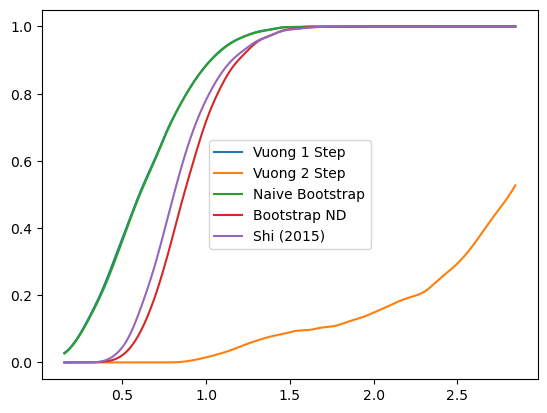

0.0006324555320336759 3.017088168272582


In [11]:
nobs = 250
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.49, 5th: 3.66, 10th: 11.22, 30th: 102.91, 50th: 306.31, 70th: 704.03, 90th: 1794.31, 95th: 2635.85, 99th: 4595.82
bonus term 1.984424727491789 // variance stats 0.5989908008746303 //part1 3.465724215775732 //part2 0.5725858735264704
1.1098894001870367 -0.2849346404686774 2.821472438445399
-2.8589600547965413 -0.2849346404686774 -1.1473770165381791
---
Quantiles: 1th: 0.63, 5th: 4.28, 10th: 13.91, 30th: 111.37, 50th: 337.70, 70th: 758.92, 90th: 1950.64, 95th: 2762.67, 99th: 4497.75
bonus term 2.8630556119976025 // variance stats 0.1836283869767625 //part1 3.465724215775732 //part2 0.826106012407212
2.5217392169063593 -0.6293342530650288 3.2150468933772536
-3.2043720070888457 -0.6293342530650288 -2.5110643306179514
---
Quantiles: 1th: 0.46, 5th: 3.35, 10th: 9.33, 30th: 79.05, 50th: 233.46, 70th: 556.41, 90th: 1367.95, 95th: 1936.08, 99th: 3331.91
bonus term 1.2173084581603266 // variance stats 1.129951719007289 //part1 3.465724215775732 //part2 0.35124215960959165
-0.04

Quantiles: 1th: 0.54, 5th: 3.38, 10th: 10.65, 30th: 98.78, 50th: 312.25, 70th: 716.19, 90th: 1783.79, 95th: 2532.24, 99th: 4363.47
bonus term 1.328069382933373 // variance stats 1.2840291652913258 //part1 3.465724215775732 //part2 0.3832011147592456
0.14981944694375446 0.08524036838381562 2.5457635179326723
-2.5063193189229915 0.08524036838381562 -0.11037524793407373
---
Quantiles: 1th: 0.50, 5th: 3.92, 10th: 11.88, 30th: 89.70, 50th: 278.04, 70th: 657.05, 90th: 1611.48, 95th: 2317.41, 99th: 4104.54
bonus term 1.7711752020112759 // variance stats 0.6894969200834585 //part1 3.465724215775732 //part2 0.5110548594573715
0.9091625826313958 -0.2228900580670579 2.721914301565101
-2.633187821391156 -0.2228900580670579 -0.820436102457451
---
Quantiles: 1th: 0.57, 5th: 3.76, 10th: 11.19, 30th: 92.60, 50th: 290.31, 70th: 675.78, 90th: 1770.60, 95th: 2601.39, 99th: 4392.60
bonus term 3.0889239847143646 // variance stats 0.09659175341881933 //part1 3.465724215775732 //part2 0.8912780684203898
2.87

2.100318747144258 -1.1298580567663017 3.075828476203234
-3.091805586287304 -1.1298580567663017 -2.116295857228328
---
Quantiles: 1th: 0.62, 5th: 4.39, 10th: 12.87, 30th: 106.29, 50th: 322.72, 70th: 751.32, 90th: 1850.55, 95th: 2561.54, 99th: 4626.72
bonus term 1.9087138802633699 // variance stats 0.6750975777779539 //part1 3.465724215775732 //part2 0.5507402670919512
1.0350658029554005 -0.3147308057678214 2.75906358722392
-2.7823619575713394 -0.3147308057678214 -1.0583641733028197
---
Quantiles: 1th: 0.57, 5th: 3.15, 10th: 10.19, 30th: 92.54, 50th: 274.33, 70th: 670.81, 90th: 1718.04, 95th: 2404.93, 99th: 3906.78
bonus term 2.8220382914500095 // variance stats 0.17525053792123527 //part1 3.465724215775732 //part2 0.8142708755082964
2.4496132303539118 -0.7306409494474099 3.18521530459209
-3.1944633525461072 -0.7306409494474099 -2.458861278307929
---
Quantiles: 1th: 0.52, 5th: 3.10, 10th: 10.41, 30th: 104.53, 50th: 318.94, 70th: 742.92, 90th: 1885.24, 95th: 2563.95, 99th: 4538.76
bonus t

Quantiles: 1th: 0.58, 5th: 3.78, 10th: 11.64, 30th: 111.18, 50th: 338.79, 70th: 815.23, 90th: 2050.16, 95th: 2947.89, 99th: 5059.37
bonus term 2.6406768128511775 // variance stats 0.2864622616870383 //part1 3.465724215775732 //part2 0.7619408378863509
2.182953415212189 -0.8076820563216854 3.0956070596205554
-3.098400210490166 -0.8076820563216854 -2.1857465660817996
---
Quantiles: 1th: 0.45, 5th: 2.97, 10th: 9.19, 30th: 78.24, 50th: 236.01, 70th: 576.58, 90th: 1365.83, 95th: 1933.48, 99th: 3281.61
bonus term 2.568855345720659 // variance stats 0.21325651373648644 //part1 3.465724215775732 //part2 0.7412174731120874
2.065555334919694 -0.8527485919351719 3.079089991872286
-3.0721553565216237 -0.8527485919351719 -2.058620699569032
---
Quantiles: 1th: 0.37, 5th: 2.80, 10th: 8.46, 30th: 78.43, 50th: 232.23, 70th: 543.16, 90th: 1468.82, 95th: 2094.40, 99th: 3462.25
bonus term 1.1118646338890568 // variance stats 1.390627755107907 //part1 3.465724215775732 //part2 0.32081740053866015
-0.258427

2.256926581751812 -0.9617179281408977 3.113232819372884
-3.0786029301052915 -0.9617179281408977 -2.2222966924842193
---
Quantiles: 1th: 0.57, 5th: 3.71, 10th: 11.44, 30th: 98.90, 50th: 319.24, 70th: 735.01, 90th: 1775.81, 95th: 2500.84, 99th: 4354.72
bonus term 1.6320754055702449 // variance stats 0.892254179375733 //part1 3.465724215775732 //part2 0.4709190068099339
0.5963805749284761 -0.576861157184051 2.6474767199983047
-2.6677702362120135 -0.576861157184051 -0.6166740911421852
---
Quantiles: 1th: 0.52, 5th: 4.03, 10th: 12.95, 30th: 100.72, 50th: 305.19, 70th: 748.55, 90th: 1885.47, 95th: 2725.28, 99th: 4840.90
bonus term 1.2741314418405543 // variance stats 1.4503717876386906 //part1 3.465724215775732 //part2 0.367637862251358
0.04218193415066913 -0.06108876613820047 2.4776281395363156
-2.5060809495304395 -0.06108876613820047 -0.07063474414479311
---
Quantiles: 1th: 0.62, 5th: 4.05, 10th: 12.62, 30th: 103.71, 50th: 302.60, 70th: 691.06, 90th: 1791.07, 95th: 2498.52, 99th: 4143.00
b

Quantiles: 1th: 0.42, 5th: 3.40, 10th: 9.67, 30th: 80.98, 50th: 247.94, 70th: 577.75, 90th: 1440.50, 95th: 2103.02, 99th: 3920.75
bonus term 1.5619283874387584 // variance stats 0.7852111216179689 //part1 3.465724215775732 //part2 0.45067878751834045
0.35617844264337284 -0.8174301025459955 2.5723743535726746
-2.767678332234144 -0.8174301025459955 -0.5514824213048419
---
Quantiles: 1th: 0.51, 5th: 3.98, 10th: 13.32, 30th: 102.96, 50th: 297.88, 70th: 723.67, 90th: 1749.91, 95th: 2534.05, 99th: 4615.69
bonus term 1.430491394958675 // variance stats 1.1134224639128971 //part1 3.465724215775732 //part2 0.4127539601815918
0.26058145147113565 -0.7392338052081928 2.5473345764628257
-2.6004013384462143 -0.7392338052081928 -0.3136482134545246
---
Quantiles: 1th: 0.52, 5th: 3.92, 10th: 11.77, 30th: 102.63, 50th: 315.05, 70th: 721.51, 90th: 1801.15, 95th: 2508.00, 99th: 4343.40
bonus term 1.2823810987281836 // variance stats 1.3714170591688992 //part1 3.465724215775732 //part2 0.37001821809446794


Quantiles: 1th: 0.51, 5th: 3.30, 10th: 11.16, 30th: 101.24, 50th: 319.81, 70th: 755.46, 90th: 1847.11, 95th: 2772.12, 99th: 4520.48
bonus term 1.0488444906603056 // variance stats 1.9034918898982578 //part1 3.465724215775732 //part2 0.3026335695973844
-0.32011070216968085 0.11848929974299728 2.4503395493748905
-2.417799683490292 0.11848929974299728 0.3526505680542794
---
Quantiles: 1th: 0.62, 5th: 4.04, 10th: 10.85, 30th: 83.93, 50th: 260.17, 70th: 600.20, 90th: 1542.64, 95th: 2215.75, 99th: 3861.10
bonus term 1.0611368180070075 // variance stats 1.5633193242286048 //part1 3.465724215775732 //part2 0.3061803974986779
-0.3049248344711112 -0.20264751583099536 2.5298490671513405
-2.427198470485126 -0.20264751583099536 0.40757543113732536
---
Quantiles: 1th: 0.57, 5th: 3.59, 10th: 10.59, 30th: 88.69, 50th: 280.02, 70th: 691.83, 90th: 1702.56, 95th: 2404.63, 99th: 4076.42
bonus term 1.668108226760839 // variance stats 0.8205203567330697 //part1 3.465724215775732 //part2 0.4813159163581822
0

0.7903994536720352 -1.2813854545031875 2.7628706038908604
-2.761123776498625 -1.2813854545031875 -0.7886526262797995
---
Quantiles: 1th: 0.44, 5th: 3.28, 10th: 10.41, 30th: 97.11, 50th: 301.21, 70th: 678.77, 90th: 1668.54, 95th: 2425.52, 99th: 4177.61
bonus term 1.17975328881346 // variance stats 1.445879544508407 //part1 3.465724215775732 //part2 0.3404059917529809
-0.13724694976476184 -0.8830919706358645 2.428983488969903
-2.496753527391682 -0.8830919706358645 0.0694769113429827
---
Quantiles: 1th: 0.50, 5th: 3.02, 10th: 8.71, 30th: 73.46, 50th: 208.53, 70th: 512.32, 90th: 1248.45, 95th: 1809.23, 99th: 3036.04
bonus term 1.0847459286011634 // variance stats 1.2255032784215827 //part1 3.465724215775732 //part2 0.3129925698252263
-0.2689150683835672 -1.1446246996432672 2.3774272960689973
-2.438406925585894 -1.1446246996432672 0.20793543886667015
---
Quantiles: 1th: 0.62, 5th: 3.79, 10th: 9.88, 30th: 90.37, 50th: 287.39, 70th: 669.92, 90th: 1702.70, 95th: 2469.99, 99th: 4186.95
bonus te

Quantiles: 1th: 0.44, 5th: 2.80, 10th: 8.49, 30th: 70.57, 50th: 225.13, 70th: 534.73, 90th: 1364.77, 95th: 1930.85, 99th: 3453.47
bonus term 1.7600492009699686 // variance stats 0.5914880950846342 //part1 3.465724215775732 //part2 0.507844563326288
0.8281184930104942 -2.378833875445457 2.748964985353221
-2.691979908929443 -2.378833875445457 -0.7711334165867157
---
Quantiles: 1th: 0.65, 5th: 4.11, 10th: 13.26, 30th: 117.73, 50th: 344.28, 70th: 832.48, 90th: 2107.91, 95th: 2917.08, 99th: 4974.86
bonus term 2.253450230387112 // variance stats 0.5071300395468554 //part1 3.465724215775732 //part2 0.650210487069215
1.5709455246560506 -1.6124675131788917 2.9299671950570954
-2.935954936118173 -1.6124675131788917 -1.5769332657171287
---
Quantiles: 1th: 0.78, 5th: 4.31, 10th: 14.01, 30th: 110.93, 50th: 336.37, 70th: 768.04, 90th: 1954.01, 95th: 2685.88, 99th: 4590.86
bonus term 0.9596698108966643 // variance stats 2.281967051414072 //part1 3.465724215775732 //part2 0.27690310917652217
-0.4564412

-0.711840682828465 -0.5950352752590464 2.4079001723652107
-2.4652032306170555 -0.5950352752590464 0.6545376245766203
---
Quantiles: 1th: 0.72, 5th: 4.02, 10th: 12.64, 30th: 105.74, 50th: 322.40, 70th: 742.83, 90th: 1846.23, 95th: 2636.33, 99th: 4468.97
bonus term 0.9757606867283583 // variance stats 2.1069324840674284 //part1 3.465724215775732 //part2 0.2815459701861921
-0.4776173788358612 -1.0324056381561673 2.32743174290098
-2.4291387522925776 -1.0324056381561673 0.37591036944426354
---
Quantiles: 1th: 0.49, 5th: 3.79, 10th: 11.31, 30th: 111.31, 50th: 340.73, 70th: 818.58, 90th: 1992.11, 95th: 2802.72, 99th: 4747.57
bonus term 1.1828080576788003 // variance stats 1.7195101571699531 //part1 3.465724215775732 //part2 0.3412874147038998
-0.1089454149118924 -1.1184780683970499 2.4619559130700406
-2.474561530269493 -1.1184780683970499 0.09633979771243968
---
Quantiles: 1th: 0.46, 5th: 3.17, 10th: 9.46, 30th: 75.01, 50th: 222.42, 70th: 559.43, 90th: 1370.38, 95th: 1934.49, 99th: 3460.53
bo

Quantiles: 1th: 0.58, 5th: 3.25, 10th: 9.56, 30th: 87.04, 50th: 292.29, 70th: 666.72, 90th: 1639.06, 95th: 2293.57, 99th: 3985.16
bonus term 1.9161620175641727 // variance stats 0.5927718182455023 //part1 3.465724215775732 //part2 0.5528893524885616
0.9774382681641621 -2.9390313712444285 2.815732877799693
-2.854885766964183 -2.9390313712444285 -1.0165911573286524
---
Quantiles: 1th: 0.62, 5th: 3.74, 10th: 11.01, 30th: 100.03, 50th: 300.70, 70th: 675.67, 90th: 1681.82, 95th: 2418.38, 99th: 4219.65
bonus term 1.4573018012766616 // variance stats 1.036575714294662 //part1 3.465724215775732 //part2 0.42048983431605047
0.3322062643583664 -2.4211821500258086 2.5457655357534414
-2.5823973381949568 -2.4211821500258086 -0.3688380667998815
---
Quantiles: 1th: 0.48, 5th: 3.26, 10th: 12.49, 30th: 122.98, 50th: 355.43, 70th: 841.64, 90th: 2121.84, 95th: 3060.63, 99th: 5063.40
bonus term 1.2154914073369019 // variance stats 1.7567186856291577 //part1 3.465724215775732 //part2 0.35071786779919495
-0.

1.3635724519806818 -2.8332616141818274 2.874802034420837
-2.924855447470467 -2.8332616141818274 -1.4136258650303117
---
Quantiles: 1th: 0.50, 5th: 3.86, 10th: 11.03, 30th: 94.97, 50th: 280.19, 70th: 648.64, 90th: 1680.70, 95th: 2361.72, 99th: 4099.07
bonus term 1.7013316382087507 // variance stats 0.779490814957534 //part1 3.465724215775732 //part2 0.490902198872146
0.7015225081009141 -4.377583494347105 2.7045740741242077
-2.701140768316587 -4.377583494347105 -0.6980892022932936
---
Quantiles: 1th: 0.56, 5th: 4.02, 10th: 11.22, 30th: 110.39, 50th: 338.42, 70th: 802.96, 90th: 1993.41, 95th: 2770.49, 99th: 4618.69
bonus term 1.93961432459189 // variance stats 0.701425597668729 //part1 3.465724215775732 //part2 0.5596562807170006
1.0071841633861307 -2.6877630315549044 2.803853075723644
-2.872044485797649 -2.6877630315549044 -1.075375573460136
---
Quantiles: 1th: 0.90, 5th: 4.17, 10th: 12.88, 30th: 109.03, 50th: 327.36, 70th: 784.22, 90th: 1959.57, 95th: 2768.24, 99th: 4792.47
bonus term 1

Quantiles: 1th: 0.66, 5th: 4.64, 10th: 14.05, 30th: 124.36, 50th: 383.22, 70th: 878.02, 90th: 2115.99, 95th: 2967.86, 99th: 5300.63
bonus term 1.7597611205195507 // variance stats 0.9173711010923805 //part1 3.465724215775732 //part2 0.5077614405985457
0.7438584548288107 -3.1972763664670993 2.775126771078416
-2.7756637862102904 -3.1972763664670993 -0.7443954699606856
---
Quantiles: 1th: 0.47, 5th: 2.92, 10th: 9.24, 30th: 85.36, 50th: 263.00, 70th: 642.13, 90th: 1554.41, 95th: 2159.55, 99th: 3579.87
bonus term 1.077542435700223 // variance stats 1.5406846956205846 //part1 3.465724215775732 //part2 0.3109140741191483
-0.24839725267876248 -2.0051057214830004 2.4375487547570307
-2.403482124079208 -2.0051057214830004 0.2824638833565847
---
Quantiles: 1th: 0.49, 5th: 3.68, 10th: 11.21, 30th: 90.52, 50th: 256.84, 70th: 604.47, 90th: 1596.75, 95th: 2243.38, 99th: 3944.78
bonus term 1.5657338533623273 // variance stats 0.8665312490905703 //part1 3.465724215775732 //part2 0.4517768165843136
0.347

0.41637140642820786 -4.251777163908621 2.5445576216752275
-2.596531367313434 -4.251777163908621 -0.4683451520664142
---
Quantiles: 1th: 0.72, 5th: 3.68, 10th: 11.05, 30th: 95.26, 50th: 299.65, 70th: 695.87, 90th: 1696.96, 95th: 2500.76, 99th: 4263.03
bonus term 1.4560432122231695 // variance stats 1.0474672302449606 //part1 3.465724215775732 //part2 0.4201266810542407
0.3186106122131781 -4.005113995094114 2.5741627007099455
-2.593475812233161 -4.005113995094114 -0.33792372373639323
---
Quantiles: 1th: 0.55, 5th: 3.16, 10th: 10.51, 30th: 81.07, 50th: 253.35, 70th: 614.03, 90th: 1515.15, 95th: 2162.05, 99th: 3855.57
bonus term 1.1486542309971721 // variance stats 1.3668493165144084 //part1 3.465724215775732 //part2 0.33143267019590855
-0.21460206911298038 -2.7208137384335536 2.4051867213431497
-2.5119105311073247 -2.7208137384335536 0.1078782593488055
---
Quantiles: 1th: 0.54, 5th: 3.97, 10th: 12.68, 30th: 109.57, 50th: 350.53, 70th: 833.89, 90th: 2081.49, 95th: 2829.88, 99th: 4761.11
bo

Quantiles: 1th: 0.61, 5th: 3.99, 10th: 12.55, 30th: 108.10, 50th: 319.76, 70th: 748.09, 90th: 1835.33, 95th: 2586.44, 99th: 4408.07
bonus term 1.264219559711375 // variance stats 1.4293086977455771 //part1 3.465724215775732 //part2 0.36477788796833194
0.004192440980240432 -3.608002997145938 2.4639015968406692
-2.5242466784425095 -3.608002997145938 -0.06453752258208104
---
Quantiles: 1th: 0.54, 5th: 3.96, 10th: 12.36, 30th: 109.51, 50th: 328.02, 70th: 764.37, 90th: 1908.41, 95th: 2845.15, 99th: 4783.56
bonus term 1.6115745604027347 // variance stats 0.9819293283720143 //part1 3.465724215775732 //part2 0.4650036933310968
0.5027950991858495 -3.70777069752025 2.6178021476510676
-2.72035402161962 -3.70777069752025 -0.6053469731544021
---
Quantiles: 1th: 0.53, 5th: 3.57, 10th: 11.55, 30th: 91.28, 50th: 269.77, 70th: 635.07, 90th: 1620.28, 95th: 2258.30, 99th: 4219.91
bonus term 1.6024742812690547 // variance stats 0.8425269922653685 //part1 3.465724215775732 //part2 0.4623778989611189
0.5660

0.23675639786790834 -4.688693397508409 2.6254903091499457
-2.479133131819327 -4.688693397508409 -0.0903992205372895
---
Quantiles: 1th: 0.56, 5th: 2.82, 10th: 9.99, 30th: 80.82, 50th: 259.08, 70th: 616.40, 90th: 1541.17, 95th: 2228.05, 99th: 3747.50
bonus term 1.2821601417369104 // variance stats 1.1737864406273941 //part1 3.465724215775732 //part2 0.369954463168364
0.049781316119114224 -4.74707731989268 2.4465012681064398
-2.5145389673547065 -4.74707731989268 -0.11781901536738112
---
Quantiles: 1th: 0.66, 5th: 3.79, 10th: 10.85, 30th: 90.33, 50th: 263.94, 70th: 618.61, 90th: 1540.10, 95th: 2249.74, 99th: 3699.28
bonus term 0.9747681015654431 // variance stats 1.7600700053513865 //part1 3.465724215775732 //part2 0.2812595696819636
-0.44122516723479455 -3.7627963246736083 2.406559380691157
-2.390761370365681 -3.7627963246736083 0.45702317756027044
---
Quantiles: 1th: 0.50, 5th: 3.67, 10th: 11.54, 30th: 106.06, 50th: 337.39, 70th: 791.26, 90th: 1997.16, 95th: 2869.50, 99th: 4721.07
bonus

Quantiles: 1th: 0.57, 5th: 4.72, 10th: 13.98, 30th: 112.38, 50th: 333.93, 70th: 781.87, 90th: 1974.17, 95th: 2772.39, 99th: 4788.56
bonus term 1.295079360052158 // variance stats 1.4797621806312011 //part1 3.465724215775732 //part2 0.3736821741779245
0.06607011108674592 -3.61571020265589 2.490121783118063
-2.5240886090175696 -3.61571020265589 -0.100036936986253
---
Quantiles: 1th: 0.57, 5th: 4.65, 10th: 14.34, 30th: 117.38, 50th: 352.80, 70th: 835.96, 90th: 2071.50, 95th: 2958.76, 99th: 5014.29
bonus term 1.4117599521597393 // variance stats 1.3478225478993153 //part1 3.465724215775732 //part2 0.4073491900288856
0.32387178887992607 -4.268707347534574 2.5847437656593395
-2.4996481154395527 -4.268707347534574 -0.23877613866013941
---
Quantiles: 1th: 0.63, 5th: 3.66, 10th: 10.33, 30th: 81.69, 50th: 264.33, 70th: 659.45, 90th: 1618.02, 95th: 2242.53, 99th: 3857.54
bonus term 0.728643710502848 // variance stats 2.7181374331175046 //part1 3.465724215775732 //part2 0.21024284251646833
-0.8822

0.16206826892320944 -6.234273658830474 2.5165362359347063
-2.6240016332735365 -6.234273658830474 -0.26953366626204
---
Quantiles: 1th: 0.41, 5th: 3.19, 10th: 10.35, 30th: 83.03, 50th: 260.06, 70th: 615.65, 90th: 1579.48, 95th: 2223.94, 99th: 3895.26
bonus term 0.7755081454364359 // variance stats 2.450360441897158 //part1 3.465724215775732 //part2 0.22376510569028474
-0.779734506750428 -2.9449687756844227 2.4386885489299615
-2.3307507976232995 -2.9449687756844227 0.8876722580570898
---
Quantiles: 1th: 0.54, 5th: 2.72, 10th: 8.15, 30th: 73.48, 50th: 226.90, 70th: 532.70, 90th: 1346.97, 95th: 1888.65, 99th: 3399.91
bonus term 1.2220688390943615 // variance stats 1.1059481252426646 //part1 3.465724215775732 //part2 0.35261571983471457
-0.1035651445915805 -6.753958036407715 2.528400293447008
-2.547702822780303 -6.753958036407715 0.08426261525828528
---
Quantiles: 1th: 0.44, 5th: 3.39, 10th: 9.80, 30th: 75.24, 50th: 232.76, 70th: 550.68, 90th: 1446.85, 95th: 2002.85, 99th: 3652.82
bonus ter

Quantiles: 1th: 0.47, 5th: 3.45, 10th: 9.63, 30th: 76.05, 50th: 263.61, 70th: 605.92, 90th: 1477.20, 95th: 2089.75, 99th: 3654.80
bonus term 0.6754024790254168 // variance stats 2.7292646175934663 //part1 3.465724215775732 //part2 0.19488061858789352
-0.9015675384300661 -3.4530406392096737 2.345846992143929
-2.2523724964808998 -3.4530406392096737 0.9950420340930956
---
Quantiles: 1th: 0.55, 5th: 3.44, 10th: 10.25, 30th: 90.45, 50th: 273.08, 70th: 670.73, 90th: 1730.20, 95th: 2445.60, 99th: 4060.71
bonus term 1.418328919385982 // variance stats 1.116956866939086 //part1 3.465724215775732 //part2 0.4092445997087272
0.25469882189569465 -6.660421789893768 2.5848037478677623
-2.5819590168762696 -6.660421789893768 -0.2518540909042022
---
Quantiles: 1th: 0.55, 5th: 3.84, 10th: 12.36, 30th: 110.32, 50th: 330.36, 70th: 750.07, 90th: 1863.68, 95th: 2617.56, 99th: 4759.13
bonus term 1.3655040056431742 // variance stats 1.2819133696983707 //part1 3.465724215775732 //part2 0.3940025000914661
0.0959

-0.4741400409613961 -4.052575951188344 2.3315358345681814
-2.3048451219335786 -4.052575951188344 0.5008307535959985
---
Quantiles: 1th: 0.71, 5th: 4.08, 10th: 11.65, 30th: 102.97, 50th: 316.24, 70th: 746.48, 90th: 1835.87, 95th: 2567.30, 99th: 4625.45
bonus term 0.9502769654576925 // variance stats 2.173305642070057 //part1 3.465724215775732 //part2 0.2741928977303211
-0.5201763395549783 -4.099552992507456 2.2494502475119726
-2.4207302704703633 -4.099552992507456 0.3488963165965876
---
Quantiles: 1th: 0.45, 5th: 3.34, 10th: 11.38, 30th: 90.92, 50th: 270.78, 70th: 633.07, 90th: 1608.10, 95th: 2276.73, 99th: 3863.18
bonus term 1.0796851243896424 // variance stats 1.5893099535040365 //part1 3.465724215775732 //part2 0.31153232547327103
-0.26382777564250687 -6.563399651625699 2.5257004595025014
-2.4231980244217914 -6.563399651625699 0.3663302107232168
---
Quantiles: 1th: 0.76, 5th: 4.80, 10th: 13.49, 30th: 113.22, 50th: 350.83, 70th: 807.48, 90th: 2000.29, 95th: 2836.15, 99th: 5134.93
bonu

Quantiles: 1th: 0.55, 5th: 3.23, 10th: 9.27, 30th: 70.44, 50th: 204.33, 70th: 498.25, 90th: 1230.77, 95th: 1754.70, 99th: 3130.78
bonus term 1.0548892801046936 // variance stats 1.257916695717864 //part1 3.465724215775732 //part2 0.3043777330299139
-0.3320773997874705 -9.64644862236486 2.5149678116401577
-2.4418559599968575 -9.64644862236486 0.4051892514307707
---
Quantiles: 1th: 0.66, 5th: 4.06, 10th: 11.10, 30th: 87.12, 50th: 267.57, 70th: 619.04, 90th: 1572.51, 95th: 2209.28, 99th: 3952.82
bonus term 1.1737326759222309 // variance stats 1.3732599784336632 //part1 3.465724215775732 //part2 0.33866880422264484
-0.31900431580462085 -8.895276101918483 2.5692164789336474
-2.6664696676490824 -8.895276101918483 0.22175112708918585
---
Quantiles: 1th: 0.55, 5th: 3.31, 10th: 10.90, 30th: 108.28, 50th: 324.20, 70th: 750.13, 90th: 1865.32, 95th: 2579.07, 99th: 4450.80
bonus term 1.4344351195961211 // variance stats 1.1812987196712503 //part1 3.465724215775732 //part2 0.4138918824142653
0.25435

0.09444509652006584 -8.297091254510125 2.437386460353231
-2.5111550202823643 -8.297091254510125 -0.16821365644919903
---
Quantiles: 1th: 0.53, 5th: 3.75, 10th: 11.12, 30th: 108.19, 50th: 320.59, 70th: 778.77, 90th: 1972.41, 95th: 2797.94, 99th: 4754.44
bonus term 1.436071462408389 // variance stats 1.24669131938004 //part1 3.465724215775732 //part2 0.4143640327385234
0.28225551594091836 -7.595829652946525 2.585698163985941
-2.5898874088758594 -7.595829652946525 -0.2864447608308368
---
Quantiles: 1th: 0.52, 5th: 3.93, 10th: 12.20, 30th: 101.26, 50th: 291.35, 70th: 685.10, 90th: 1801.87, 95th: 2500.00, 99th: 4562.92
bonus term 1.3386455708553588 // variance stats 1.280431991266638 //part1 3.465724215775732 //part2 0.3862527678232268
0.08595824551315175 -7.8996069542559 2.5286955987188406
-2.5913328961975663 -7.8996069542559 -0.14859554299187716
---
Quantiles: 1th: 0.58, 5th: 3.92, 10th: 11.24, 30th: 113.10, 50th: 349.43, 70th: 843.48, 90th: 2122.14, 95th: 3037.34, 99th: 5373.25
bonus ter

Quantiles: 1th: 0.69, 5th: 3.71, 10th: 11.94, 30th: 96.11, 50th: 290.19, 70th: 691.75, 90th: 1732.56, 95th: 2405.20, 99th: 4202.76
bonus term 0.8594001626394628 // variance stats 2.3498276757014147 //part1 3.465724215775732 //part2 0.2479713067553194
-0.6145628028068804 -4.992363685487815 2.3428827448931733
-2.333363128085806 -4.992363685487815 0.6240824196142478
---
Quantiles: 1th: 0.41, 5th: 3.02, 10th: 8.43, 30th: 74.17, 50th: 233.72, 70th: 552.46, 90th: 1386.42, 95th: 1927.37, 99th: 3397.96
bonus term 1.0062527524307625 // variance stats 1.51545618141432 //part1 3.465724215775732 //part2 0.29034415025014715
-0.4277699195684684 -9.58783076153582 2.428447471806027
-2.4402754244299936 -9.58783076153582 0.41594196694450214
---
Quantiles: 1th: 0.54, 5th: 3.28, 10th: 10.00, 30th: 95.69, 50th: 274.58, 70th: 642.12, 90th: 1602.13, 95th: 2319.20, 99th: 3698.92
bonus term 0.6258515445379736 // variance stats 3.2511843747496987 //part1 3.465724215775732 //part2 0.18058319288336375
-1.02687491

-0.3541055917331294 -10.112782700507656 2.659852925236622
-2.583284249203319 -10.112782700507656 0.4306742677664326
---
Quantiles: 1th: 0.45, 5th: 3.86, 10th: 12.72, 30th: 103.96, 50th: 337.62, 70th: 774.86, 90th: 1888.21, 95th: 2727.07, 99th: 4516.90
bonus term 0.9788245090193239 // variance stats 2.1454564511036383 //part1 3.465724215775732 //part2 0.2824300054123706
-0.5689460149847229 -6.440591766138853 2.264345191036342
-2.5265950330233706 -6.440591766138853 0.30669617299769414
---
Quantiles: 1th: 0.53, 5th: 3.75, 10th: 10.76, 30th: 82.85, 50th: 248.58, 70th: 601.35, 90th: 1490.51, 95th: 2125.34, 99th: 3552.63
bonus term 1.0604706233788836 // variance stats 1.5118606065240368 //part1 3.465724215775732 //part2 0.3059881737132159
-0.3804948072070677 -9.601322789964613 2.594664530688081
-2.501436053964835 -9.601322789964613 0.4737232839303134
---
Quantiles: 1th: 0.60, 5th: 3.75, 10th: 12.05, 30th: 102.59, 50th: 317.36, 70th: 755.91, 90th: 1867.30, 95th: 2655.36, 99th: 4431.63
bonus t

Quantiles: 1th: 0.47, 5th: 4.10, 10th: 11.08, 30th: 93.14, 50th: 284.01, 70th: 653.55, 90th: 1574.85, 95th: 2284.29, 99th: 3897.24
bonus term 1.0379029345140534 // variance stats 1.6474583541304253 //part1 3.465724215775732 //part2 0.2994764931928491
-0.518044308124351 -10.358183970883175 2.53958632578888
-2.593850177152458 -10.358183970883175 0.4637804567607733
---
Quantiles: 1th: 0.63, 5th: 4.47, 10th: 12.31, 30th: 100.23, 50th: 295.31, 70th: 681.86, 90th: 1684.43, 95th: 2391.89, 99th: 4133.29
bonus term 1.0976483661573624 // variance stats 1.6251765708028827 //part1 3.465724215775732 //part2 0.3167154389148867
-0.36836602711833993 -10.172914847155996 2.471091388936972
-2.5636627594330648 -10.172914847155996 0.2757946566222471
---
Quantiles: 1th: 0.53, 5th: 3.65, 10th: 10.70, 30th: 85.17, 50th: 256.41, 70th: 594.12, 90th: 1531.06, 95th: 2113.97, 99th: 3667.46
bonus term 1.121708445003604 // variance stats 1.430824393301824 //part1 3.465724215775732 //part2 0.32365773361240524
-0.3201

-0.4653855814460963 -11.64853348586307 2.5148174087214836
-2.6349017136475146 -11.64853348586307 0.34530127652006504
---
Quantiles: 1th: 0.58, 5th: 3.54, 10th: 11.58, 30th: 87.35, 50th: 271.27, 70th: 660.26, 90th: 1637.34, 95th: 2281.32, 99th: 4057.37
bonus term 1.1026072079961473 // variance stats 1.5693461621939737 //part1 3.465724215775732 //part2 0.3181462630457314
-0.41212167778349 -11.708571839073905 2.586206552481403
-2.617336093775785 -11.708571839073905 0.3809921364891086
---
Quantiles: 1th: 0.47, 5th: 3.88, 10th: 10.61, 30th: 86.07, 50th: 264.17, 70th: 609.72, 90th: 1549.02, 95th: 2129.17, 99th: 3882.59
bonus term 1.0853663185640916 // variance stats 1.5192825017723943 //part1 3.465724215775732 //part2 0.3131715771334547
-0.32091608414500594 -11.516918987317295 2.4708235032556796
-2.4916487212731893 -11.516918987317295 0.30009086612749625
---
Quantiles: 1th: 0.45, 5th: 3.13, 10th: 10.42, 30th: 92.10, 50th: 299.60, 70th: 676.68, 90th: 1651.48, 95th: 2355.58, 99th: 3965.98
bonu

Quantiles: 1th: 0.44, 5th: 3.79, 10th: 11.27, 30th: 97.10, 50th: 310.11, 70th: 754.25, 90th: 1890.27, 95th: 2714.26, 99th: 4962.64
bonus term 1.067037233239978 // variance stats 1.900350315836539 //part1 3.465724215775732 //part2 0.30788290319896194
-0.3722121349083402 -10.542331652945899 2.423432416350801
-2.5062866013882963 -10.542331652945899 0.28935794987084495
---
Quantiles: 1th: 0.64, 5th: 3.69, 10th: 9.99, 30th: 84.99, 50th: 245.24, 70th: 560.50, 90th: 1413.49, 95th: 2061.72, 99th: 3514.74
bonus term 0.742879870609003 // variance stats 2.3169261349072006 //part1 3.465724215775732 //part2 0.21435054388559432
-0.7577031235723386 -8.035052354430746 2.0776172806145268
-2.2434628647903443 -8.035052354430746 0.591857539396521
---
Quantiles: 1th: 0.69, 5th: 4.52, 10th: 12.64, 30th: 122.96, 50th: 366.61, 70th: 883.23, 90th: 2208.40, 95th: 3189.11, 99th: 5558.60
bonus term 1.3689077201803768 // variance stats 1.512793081350965 //part1 3.465724215775732 //part2 0.3949846078199775
0.062225

-0.5562403117067387 -10.474877999539506 2.5117823555627004
-2.4799513709585757 -10.474877999539506 0.5880712963108632
---
Quantiles: 1th: 0.57, 5th: 3.81, 10th: 12.72, 30th: 97.89, 50th: 296.20, 70th: 707.04, 90th: 1655.94, 95th: 2329.37, 99th: 4011.86
bonus term 1.0757023212619177 // variance stats 1.6453881884325083 //part1 3.465724215775732 //part2 0.31038312753374797
-0.3627596901277506 -13.695444622169312 2.535497583834563
-2.514164332651586 -13.695444622169312 0.3840929413107275
---
Quantiles: 1th: 0.79, 5th: 4.43, 10th: 13.72, 30th: 107.47, 50th: 333.61, 70th: 753.28, 90th: 1891.20, 95th: 2694.28, 99th: 4626.57
bonus term 1.0617518763046587 // variance stats 1.9149592759619347 //part1 3.465724215775732 //part2 0.3063578664083077
-0.2232270830412209 -10.76377412655496 2.3657179174714758
-2.3467308356505385 -10.76377412655496 0.24221416486215827
---
Quantiles: 1th: 0.59, 5th: 4.02, 10th: 11.91, 30th: 94.45, 50th: 303.42, 70th: 712.93, 90th: 1813.71, 95th: 2580.80, 99th: 4421.15
bo

-0.4395951592053785 -11.583120467420239 2.5308262849939793
-2.4590333075030433 -11.583120467420239 0.5113881366963146
---
Quantiles: 1th: 0.57, 5th: 4.08, 10th: 11.71, 30th: 93.47, 50th: 293.81, 70th: 690.68, 90th: 1787.76, 95th: 2469.56, 99th: 4132.56
bonus term 1.0383474226187563 // variance stats 1.869040631502461 //part1 3.465724215775732 //part2 0.29960474578221546
-0.5439902778518523 -12.534488270017684 2.4821574729254965
-2.620685123089365 -12.534488270017684 0.4054626276879837
---
Quantiles: 1th: 0.45, 5th: 2.97, 10th: 9.20, 30th: 73.33, 50th: 230.66, 70th: 555.35, 90th: 1332.60, 95th: 1881.98, 99th: 3180.45
bonus term 0.894586555010071 // variance stats 1.7128415115639946 //part1 3.465724215775732 //part2 0.2581239877477775
-0.5550272918017887 -14.35948779367161 2.4426584570661545
-2.3442004018219307 -14.35948779367161 0.6534853470460124
---
Quantiles: 1th: 0.49, 5th: 3.38, 10th: 11.17, 30th: 89.40, 50th: 275.98, 70th: 690.96, 90th: 1781.12, 95th: 2517.81, 99th: 4077.87
bonus 

Quantiles: 1th: 0.42, 5th: 3.54, 10th: 10.62, 30th: 88.57, 50th: 266.11, 70th: 631.97, 90th: 1566.16, 95th: 2246.09, 99th: 3988.49
bonus term 0.9719577635316397 // variance stats 1.7970424311046513 //part1 3.465724215775732 //part2 0.28044867479857644
-0.7172930090883488 -15.227409058664623 2.3363715734917356
-2.661208536151628 -15.227409058664623 0.3924560464284565
---
Quantiles: 1th: 0.53, 5th: 3.43, 10th: 10.56, 30th: 87.43, 50th: 272.77, 70th: 634.26, 90th: 1568.60, 95th: 2254.86, 99th: 3982.96
bonus term 0.8863675281313097 // variance stats 2.041390630613684 //part1 3.465724215775732 //part2 0.25575246988684996
-0.7348355417095952 -12.306219260110762 2.3605278517974244
-2.5075705979722147 -12.306219260110762 0.587792795534805
---
Quantiles: 1th: 0.44, 5th: 3.14, 10th: 8.86, 30th: 80.75, 50th: 244.63, 70th: 595.00, 90th: 1445.20, 95th: 2072.30, 99th: 3540.61
bonus term 0.7225942719940542 // variance stats 2.45354801052351 //part1 3.465724215775732 //part2 0.2084973376429827
-0.8536

-0.8818674329818246 -13.828590775501683 2.427677593169807
-2.5049182940903294 -13.828590775501683 0.8046267320613025
---
Quantiles: 1th: 0.54, 5th: 3.72, 10th: 10.35, 30th: 91.32, 50th: 291.06, 70th: 683.29, 90th: 1696.65, 95th: 2383.63, 99th: 4226.20
bonus term 0.9885874858206228 // variance stats 1.9012673685710495 //part1 3.465724215775732 //part2 0.28524701455489226
-0.5902668086181913 -14.181224817446576 2.4620866522258558
-2.5674417802594367 -14.181224817446576 0.4849116805846102
---
Quantiles: 1th: 0.56, 5th: 3.08, 10th: 8.56, 30th: 68.30, 50th: 207.26, 70th: 524.68, 90th: 1277.35, 95th: 1796.25, 99th: 3199.91
bonus term 0.5810435810242883 // variance stats 2.8360570331555457 //part1 3.465724215775732 //part2 0.16765430393434622
-1.0661386267393518 -10.620790503865932 2.1893996353777765
-2.2282257887879284 -10.620790503865932 1.0273124733291998
---
Quantiles: 1th: 0.60, 5th: 3.95, 10th: 13.88, 30th: 121.08, 50th: 352.77, 70th: 831.07, 90th: 2089.31, 95th: 2990.59, 99th: 5075.43


Quantiles: 1th: 0.47, 5th: 3.41, 10th: 10.95, 30th: 98.84, 50th: 314.13, 70th: 724.44, 90th: 1960.81, 95th: 2772.93, 99th: 4795.24
bonus term 1.1116260984723902 // variance stats 1.8570216476496808 //part1 3.465724215775732 //part2 0.32074857353402403
-0.4825665826521837 -14.293976336689497 2.6427902432589327
-2.7058187795969646 -14.293976336689497 0.4195380463141521
---
Quantiles: 1th: 0.41, 5th: 2.66, 10th: 8.05, 30th: 79.04, 50th: 239.05, 70th: 543.79, 90th: 1373.72, 95th: 1908.13, 99th: 3456.70
bonus term 0.8585638188565431 // variance stats 1.8655587158048046 //part1 3.465724215775732 //part2 0.24772998813593453
-0.8001676625868976 -15.873643824871444 2.4266707196142745
-2.517295300299984 -15.873643824871444 0.7095430819011882
---
Quantiles: 1th: 0.39, 5th: 3.37, 10th: 11.15, 30th: 100.89, 50th: 303.91, 70th: 694.39, 90th: 1747.98, 95th: 2466.24, 99th: 4234.55
bonus term 0.8914676154676845 // variance stats 2.257345436890571 //part1 3.465724215775732 //part2 0.2572240489909113
-0.

-0.86374466361828 -16.842591985840233 2.3475862155271354
-2.439264951009294 -16.842591985840233 0.7720659281361212
---
Quantiles: 1th: 0.68, 5th: 4.23, 10th: 11.77, 30th: 86.29, 50th: 266.98, 70th: 631.27, 90th: 1606.01, 95th: 2187.31, 99th: 3620.73
bonus term 0.9083758722840257 // variance stats 2.02202840494957 //part1 3.465724215775732 //part2 0.26210275709450936
-0.700143739150747 -16.09133006976728 2.3939251420669745
-2.5168954837187987 -16.09133006976728 0.577173397498923
---
Quantiles: 1th: 0.69, 5th: 4.27, 10th: 12.08, 30th: 101.62, 50th: 336.84, 70th: 776.69, 90th: 1947.87, 95th: 2774.77, 99th: 4901.71
bonus term 0.7926713278494658 // variance stats 2.937585190180112 //part1 3.465724215775732 //part2 0.22871737002075407
-0.776843740348655 -10.106519242053594 2.288133453401169
-2.3621863960475866 -10.106519242053594 0.7027907977022373
---
Quantiles: 1th: 0.55, 5th: 3.61, 10th: 9.68, 30th: 88.35, 50th: 261.90, 70th: 647.53, 90th: 1663.45, 95th: 2356.18, 99th: 4170.08
bonus term 

Quantiles: 1th: 0.62, 5th: 4.35, 10th: 12.69, 30th: 107.32, 50th: 329.12, 70th: 800.98, 90th: 2026.55, 95th: 2854.74, 99th: 4933.38
bonus term 0.978340741468944 // variance stats 2.3042298331714184 //part1 3.465724215775732 //part2 0.28229041913248776
-0.7073746570395754 -14.146519124218596 2.6574807608188715
-2.6640561399774634 -14.146519124218596 0.7007992778809833
---
Quantiles: 1th: 0.46, 5th: 3.69, 10th: 10.24, 30th: 79.33, 50th: 241.76, 70th: 579.02, 90th: 1430.65, 95th: 2043.70, 99th: 3875.38
bonus term 0.5254739905191185 // variance stats 3.5799878441781186 //part1 3.465724215775732 //part2 0.15162025533572404
-1.456130479068206 -9.933395456723483 2.268818432448956
-2.507078460106443 -9.933395456723483 1.2178704514107193
---
Quantiles: 1th: 0.47, 5th: 3.62, 10th: 12.11, 30th: 96.68, 50th: 280.67, 70th: 698.51, 90th: 1709.39, 95th: 2455.64, 99th: 4048.17
bonus term 0.9441035756529655 // variance stats 2.0418125193096093 //part1 3.465724215775732 //part2 0.2724116279522394
-0.556

-0.9109084284680847 -14.618623094003816 2.434209969220758
-2.418382760507665 -14.618623094003816 0.9267356371811776
---
Quantiles: 1th: 0.56, 5th: 4.07, 10th: 12.21, 30th: 97.75, 50th: 313.62, 70th: 735.63, 90th: 1854.81, 95th: 2585.06, 99th: 4442.50
bonus term 0.6716797665084956 // variance stats 3.450519669062321 //part1 3.465724215775732 //part2 0.19380646718831715
-0.9138534879662317 -10.312328764326184 2.3102550376094495
-2.257213020983223 -10.312328764326184 0.9668955045924583
---
Quantiles: 1th: 0.41, 5th: 2.96, 10th: 9.71, 30th: 89.87, 50th: 284.57, 70th: 650.75, 90th: 1614.24, 95th: 2299.36, 99th: 3740.55
bonus term 0.9068004916660289 // variance stats 2.037177332189505 //part1 3.465724215775732 //part2 0.261648196800639
-0.719632956537468 -17.742137859048437 2.456510786729112
-2.533233939869526 -17.742137859048437 0.6429098033970538
---
Quantiles: 1th: 0.53, 5th: 3.57, 10th: 9.62, 30th: 74.44, 50th: 221.87, 70th: 517.97, 90th: 1263.24, 95th: 1822.55, 99th: 3014.33
bonus term 

Quantiles: 1th: 0.51, 5th: 3.70, 10th: 11.37, 30th: 86.64, 50th: 285.53, 70th: 659.68, 90th: 1675.30, 95th: 2436.25, 99th: 4261.44
bonus term 0.8676017643933489 // variance stats 2.2436054653136273 //part1 3.465724215775732 //part2 0.2503377967710434
-0.7198021719628517 -17.078293599301677 2.385274684674897
-2.45500570074955 -17.078293599301677 0.650071155888199
---
Quantiles: 1th: 0.36, 5th: 2.60, 10th: 7.71, 30th: 64.19, 50th: 187.97, 70th: 444.19, 90th: 1132.15, 95th: 1563.85, 99th: 2906.32
bonus term 0.640357775881417 // variance stats 2.2339350638522664 //part1 3.465724215775732 //part2 0.18476882060221456
-1.3404961477731006 -18.972608520383996 2.4599595366769886
-2.6212116995359342 -18.972608520383996 1.179243984914155
---
Quantiles: 1th: 0.49, 5th: 3.26, 10th: 10.71, 30th: 88.44, 50th: 272.45, 70th: 632.24, 90th: 1543.66, 95th: 2164.55, 99th: 3741.10
bonus term 0.7477381625585294 // variance stats 2.5093675902481345 //part1 3.465724215775732 //part2 0.2157523553532846
-0.857900

-0.4738304793483673 -15.896379841873097 2.4904203605687094
-2.7057815227695614 -15.896379841873097 0.25846931714751553
---
Quantiles: 1th: 0.53, 5th: 3.05, 10th: 9.58, 30th: 89.69, 50th: 269.78, 70th: 627.29, 90th: 1592.37, 95th: 2169.40, 99th: 3740.63
bonus term 0.8928541054941003 // variance stats 2.052084608078337 //part1 3.465724215775732 //part2 0.2576241067970415
-0.8126501372417315 -18.6306605847468 2.3875979832321046
-2.598358348229932 -18.6306605847468 0.6018897722439039
---
Quantiles: 1th: 0.50, 5th: 3.88, 10th: 11.81, 30th: 104.52, 50th: 298.15, 70th: 719.96, 90th: 1712.08, 95th: 2394.26, 99th: 4194.02
bonus term 0.8445507345264089 // variance stats 2.3763364975039956 //part1 3.465724215775732 //part2 0.24368665304702364
-0.9730562157892003 -17.053517408335264 2.5761510295997634
-2.6621576848420183 -17.053517408335264 0.8870495605469456
---
Quantiles: 1th: 0.45, 5th: 3.13, 10th: 8.89, 30th: 72.51, 50th: 216.05, 70th: 512.03, 90th: 1278.54, 95th: 1878.40, 99th: 3201.84
bonus 

Quantiles: 1th: 0.78, 5th: 3.93, 10th: 11.66, 30th: 102.54, 50th: 309.59, 70th: 726.33, 90th: 1848.17, 95th: 2645.74, 99th: 4491.22
bonus term 0.8473294218636357 // variance stats 2.5541090914515885 //part1 3.465724215775732 //part2 0.24448841543901614
-0.8133514377367127 -15.670642252518716 2.457233518700843
-2.508010281463984 -15.670642252518716 0.7625746749735716
---
Quantiles: 1th: 0.60, 5th: 4.24, 10th: 13.34, 30th: 115.17, 50th: 341.82, 70th: 797.94, 90th: 1959.27, 95th: 2821.02, 99th: 4591.56
bonus term 0.9198391989542375 // variance stats 2.425141794829489 //part1 3.465724215775732 //part2 0.265410385156209
-0.7814849434902785 -17.376145798419156 2.530161143955236
-2.621163341398754 -17.376145798419156 0.6904827460467609
---
Quantiles: 1th: 0.52, 5th: 3.43, 10th: 9.71, 30th: 89.88, 50th: 295.73, 70th: 705.16, 90th: 1734.93, 95th: 2420.48, 99th: 4112.12
bonus term 0.868098621568808 // variance stats 2.3216888092318184 //part1 3.465724215775732 //part2 0.2504811599311002
-0.85389

-0.8689028715693999 -16.90873563147654 2.3305110321602465
-2.4983189788376423 -16.90873563147654 0.7010949248920043
---
Quantiles: 1th: 0.47, 5th: 3.98, 10th: 11.98, 30th: 94.15, 50th: 272.64, 70th: 647.01, 90th: 1665.19, 95th: 2381.71, 99th: 4110.59
bonus term 0.7773550820735995 // variance stats 2.5754261261367777 //part1 3.465724215775732 //part2 0.22429802075281527
-0.9637670889105115 -18.442616628103526 2.4580059838909394
-2.5184772530577106 -18.442616628103526 0.9032958197437403
---
Quantiles: 1th: 0.49, 5th: 4.15, 10th: 12.66, 30th: 102.93, 50th: 322.68, 70th: 743.09, 90th: 1854.92, 95th: 2535.93, 99th: 4469.40
bonus term 0.804498427161085 // variance stats 2.744085748533899 //part1 3.465724215775732 //part2 0.2321299610335597
-0.793636381022838 -16.34454656048309 2.436939206512974
-2.4026332353450077 -16.34454656048309 0.827942352190804
---
Quantiles: 1th: 0.59, 5th: 3.16, 10th: 10.20, 30th: 97.47, 50th: 312.92, 70th: 749.03, 90th: 1934.13, 95th: 2615.66, 99th: 4646.54
bonus te

Quantiles: 1th: 0.37, 5th: 2.73, 10th: 8.45, 30th: 68.43, 50th: 207.02, 70th: 495.52, 90th: 1245.87, 95th: 1778.92, 99th: 3056.08
bonus term 0.6524097675617859 // variance stats 2.4026211850560126 //part1 3.465724215775732 //part2 0.18824630205486712
-1.3428273530869352 -21.95411189956149 2.491697413502835
-2.6476468882105073 -21.95411189956149 1.1868778783792628
---
Quantiles: 1th: 0.58, 5th: 3.70, 10th: 11.54, 30th: 94.24, 50th: 298.08, 70th: 683.35, 90th: 1703.20, 95th: 2370.21, 99th: 4056.43
bonus term 0.8347269079816072 // variance stats 2.400805535090412 //part1 3.465724215775732 //part2 0.24085208632065677
-1.0035052147785835 -21.197843454517763 2.42734987173982
-2.6729590307417976 -21.197843454517763 0.7578960557766053
---
Quantiles: 1th: 0.68, 5th: 4.33, 10th: 12.72, 30th: 91.22, 50th: 272.55, 70th: 630.82, 90th: 1619.97, 95th: 2313.52, 99th: 3917.97
bonus term 0.7509282778012253 // variance stats 2.6191452990824793 //part1 3.465724215775732 //part2 0.21667283114537872
-1.0840

-0.7897144999684171 -19.347344686525542 2.5334421489139283
-2.771576395863736 -19.347344686525542 0.5515802530186091
---
Quantiles: 1th: 0.52, 5th: 3.06, 10th: 8.34, 30th: 72.91, 50th: 216.45, 70th: 519.32, 90th: 1280.82, 95th: 1795.07, 99th: 3343.68
bonus term 0.6463470184234161 // variance stats 2.4985728976003405 //part1 3.465724215775732 //part2 0.1864969565325741
-1.393287521227722 -22.174083206019567 2.6188908048917567
-2.685981558074554 -22.174083206019567 1.3261967680449245
---
Quantiles: 1th: 0.43, 5th: 2.74, 10th: 8.88, 30th: 78.57, 50th: 232.48, 70th: 559.82, 90th: 1376.44, 95th: 1903.63, 99th: 3338.22
bonus term 0.6624437791807296 // variance stats 2.604899654578289 //part1 3.465724215775732 //part2 0.1911415155785715
-1.3665909359519623 -21.256214981333706 2.62440211580026
-2.6914784943134213 -21.256214981333706 1.2995145574388012
---
Quantiles: 1th: 0.52, 5th: 3.52, 10th: 10.20, 30th: 83.87, 50th: 260.76, 70th: 598.41, 90th: 1505.35, 95th: 2128.79, 99th: 3887.02
bonus ter

Quantiles: 1th: 0.47, 5th: 3.54, 10th: 10.63, 30th: 81.74, 50th: 240.37, 70th: 574.85, 90th: 1410.89, 95th: 2066.83, 99th: 3660.09
bonus term 0.6975387614032206 // variance stats 2.504011007384533 //part1 3.465724215775732 //part2 0.20126782108861213
-1.2233076609722235 -20.63844175827248 2.4864484570431404
-2.6183851837786647 -20.63844175827248 1.0913709342366993
---
Quantiles: 1th: 0.50, 5th: 3.67, 10th: 11.97, 30th: 100.46, 50th: 301.98, 70th: 719.72, 90th: 1843.82, 95th: 2672.27, 99th: 4692.70
bonus term 0.7771882749257935 // variance stats 2.852483330129288 //part1 3.465724215775732 //part2 0.22424989022152636
-1.0640175053207175 -17.080275603159617 2.5041836042533054
-2.6183940551723044 -17.080275603159617 0.9498070544017186
---
Quantiles: 1th: 0.67, 5th: 3.61, 10th: 9.88, 30th: 89.38, 50th: 280.97, 70th: 608.98, 90th: 1574.73, 95th: 2242.36, 99th: 4035.72
bonus term 0.741064366466732 // variance stats 2.5892695413479414 //part1 3.465724215775732 //part2 0.21382669835454857
-1.15

-1.0895872506442739 -18.459420136402372 2.5192023238618098
-2.5646842247309083 -18.459420136402372 1.044105349775175
---
Quantiles: 1th: 0.40, 5th: 3.16, 10th: 9.07, 30th: 83.47, 50th: 253.42, 70th: 591.15, 90th: 1430.08, 95th: 2001.89, 99th: 3498.22
bonus term 0.6845794651414208 // variance stats 2.5982237211348562 //part1 3.465724215775732 //part2 0.19752854598910763
-1.4806316789139693 -22.20682027290033 2.5061844254633363
-2.849790609196811 -22.20682027290033 1.1370254951804948
---
Quantiles: 1th: 0.55, 5th: 3.31, 10th: 9.77, 30th: 81.94, 50th: 251.82, 70th: 608.97, 90th: 1502.77, 95th: 2121.38, 99th: 3840.50
bonus term 0.711436938435166 // variance stats 2.6018329415866073 //part1 3.465724215775732 //part2 0.205278000827866
-1.3963690360131407 -21.384482114744518 2.4496410153024315
-2.819242912883473 -21.384482114744518 1.0267671384320993
---
Quantiles: 1th: 0.62, 5th: 4.38, 10th: 12.61, 30th: 103.94, 50th: 302.50, 70th: 734.89, 90th: 1898.34, 95th: 2754.80, 99th: 4502.00
bonus te

Quantiles: 1th: 0.72, 5th: 3.91, 10th: 10.98, 30th: 99.28, 50th: 302.80, 70th: 709.81, 90th: 1776.97, 95th: 2538.63, 99th: 4325.11
bonus term 0.7055003251397399 // variance stats 3.109147029420692 //part1 3.465724215775732 //part2 0.20356505053932225
-1.1594952274883217 -18.83892685876457 2.311117668442838
-2.5704958777678013 -18.83892685876457 0.9001170181633581
---
Quantiles: 1th: 0.58, 5th: 3.90, 10th: 12.88, 30th: 100.63, 50th: 291.65, 70th: 709.03, 90th: 1834.30, 95th: 2525.00, 99th: 4556.07
bonus term 0.7944385555935902 // variance stats 2.758328317492604 //part1 3.465724215775732 //part2 0.22922728588078703
-1.1945977534360324 -22.957202790620336 2.600964346253966
-2.783474864623213 -22.957202790620336 1.0120872350667858
---
Quantiles: 1th: 0.48, 5th: 3.54, 10th: 11.40, 30th: 107.73, 50th: 337.79, 70th: 765.85, 90th: 1931.13, 95th: 2718.57, 99th: 4503.30
bonus term 0.8796593939355676 // variance stats 2.538935108602221 //part1 3.465724215775732 //part2 0.25381690497224796
-0.818

-1.3351871658356025 -23.35004376461936 2.5776971332752625
-2.7512841817166303 -23.35004376461936 1.1616001173942345
---
Quantiles: 1th: 0.65, 5th: 3.47, 10th: 10.53, 30th: 88.71, 50th: 271.80, 70th: 638.95, 90th: 1613.77, 95th: 2289.10, 99th: 4001.44
bonus term 0.5721533187398017 // variance stats 3.6498812851569116 //part1 3.465724215775732 //part2 0.16508910782208236
-1.5370054957962827 -18.324374053831427 2.493023208152993
-2.681312133275886 -18.324374053831427 1.3487165706733895
---
Quantiles: 1th: 0.66, 5th: 4.02, 10th: 12.74, 30th: 114.43, 50th: 337.86, 70th: 822.44, 90th: 2062.92, 95th: 2943.12, 99th: 4922.88
bonus term 0.8487684621658216 // variance stats 2.8444961550639536 //part1 3.465724215775732 //part2 0.2449036361007282
-1.1849329978433514 -21.659254413427867 2.629583648493351
-2.8824699221749945 -21.659254413427867 0.9320467241617075
---
Quantiles: 1th: 0.44, 5th: 2.85, 10th: 8.71, 30th: 82.94, 50th: 258.42, 70th: 616.93, 90th: 1559.39, 95th: 2254.02, 99th: 4046.14
bonus

Quantiles: 1th: 0.65, 5th: 4.11, 10th: 13.27, 30th: 102.72, 50th: 301.39, 70th: 706.69, 90th: 1715.87, 95th: 2418.06, 99th: 4233.89
bonus term 0.6961000372839498 // variance stats 3.053157440225471 //part1 3.465724215775732 //part2 0.2008526916583124
-1.367159559636996 -20.902507811088924 2.371907947321841
-2.759359634204895 -20.902507811088924 0.9797078727539419
---
Quantiles: 1th: 0.44, 5th: 2.86, 10th: 9.71, 30th: 80.75, 50th: 239.71, 70th: 568.55, 90th: 1383.26, 95th: 1933.60, 99th: 3555.47
bonus term 0.4219169150416441 // variance stats 4.46281231689313 //part1 3.465724215775732 //part2 0.12173989872624835
-1.5685297218225838 -15.412367144130082 2.3906135557931765
-2.412363551905872 -15.412367144130082 1.546779725709888
---
Quantiles: 1th: 0.56, 5th: 3.70, 10th: 12.08, 30th: 101.83, 50th: 294.36, 70th: 663.07, 90th: 1646.98, 95th: 2260.85, 99th: 4020.57
bonus term 0.6691724709087156 // variance stats 3.078137365336539 //part1 3.465724215775732 //part2 0.1930830121631403
-1.1301741

-1.0751517547083034 -23.52040781029968 2.5303126791038
-2.5748444918970894 -23.52040781029968 1.0306199419150144
---
Quantiles: 1th: 0.57, 5th: 3.85, 10th: 13.46, 30th: 131.57, 50th: 441.23, 70th: 1037.68, 90th: 2565.96, 95th: 3694.28, 99th: 6298.76
bonus term 0.9703032366654181 // variance stats 2.951213779366435 //part1 3.465724215775732 //part2 0.27997127764773266
-0.7853180117053938 -21.77565722233629 2.713509506807802
-2.7259244850362303 -21.77565722233629 0.7729030334769657
---
Quantiles: 1th: 0.48, 5th: 3.45, 10th: 10.31, 30th: 87.09, 50th: 265.68, 70th: 607.19, 90th: 1503.79, 95th: 2087.35, 99th: 3924.08
bonus term 0.6660014298117681 // variance stats 2.8270980494278763 //part1 3.465724215775732 //part2 0.1921680400247015
-1.464174118465345 -24.577967727151975 2.697892432198602
-2.796176978088881 -24.577967727151975 1.365889572575066
---
Quantiles: 1th: 0.78, 5th: 4.43, 10th: 15.68, 30th: 119.30, 50th: 355.80, 70th: 846.70, 90th: 2123.22, 95th: 3001.23, 99th: 5224.16
bonus term

Quantiles: 1th: 0.59, 5th: 3.84, 10th: 12.56, 30th: 112.76, 50th: 341.54, 70th: 793.09, 90th: 1967.53, 95th: 2795.31, 99th: 4988.51
bonus term 0.8129733782781584 // variance stats 2.8711471216604885 //part1 3.465724215775732 //part2 0.23457532326939373
-1.2082715668323338 -24.935157759634787 2.6623183937339125
-2.834218323388651 -24.935157759634787 1.0363716371775955
---
Quantiles: 1th: 0.51, 5th: 3.79, 10th: 10.26, 30th: 78.25, 50th: 254.41, 70th: 592.62, 90th: 1543.40, 95th: 2211.41, 99th: 3614.81
bonus term 0.5835545137122907 // variance stats 3.409037292035703 //part1 3.465724215775732 //part2 0.1683788084048903
-1.3474948891182237 -21.908231081091955 2.354255109002844
-2.5146039165428054 -21.908231081091955 1.1871460815782622
---
Quantiles: 1th: 0.56, 5th: 3.41, 10th: 10.37, 30th: 92.20, 50th: 288.65, 70th: 686.40, 90th: 1682.76, 95th: 2365.51, 99th: 4024.95
bonus term 0.6841441022996199 // variance stats 3.059721631945964 //part1 3.465724215775732 //part2 0.1974029264029273
-1.21

-0.8199371774057697 -23.0753010962158 2.3190915465992874
-2.4995330094566595 -23.0753010962158 0.6394957145483977
---
Quantiles: 1th: 0.48, 5th: 2.89, 10th: 8.60, 30th: 72.47, 50th: 215.14, 70th: 531.47, 90th: 1291.97, 95th: 1843.93, 99th: 3268.95
bonus term 0.43732382397418046 // variance stats 4.0010678675602955 //part1 3.465724215775732 //part2 0.12618540793970656
-1.6231732445558784 -19.553851791382822 2.480959039027513
-2.4978208925042393 -19.553851791382822 1.6063113910791522
---
Quantiles: 1th: 0.64, 5th: 3.36, 10th: 10.31, 30th: 89.24, 50th: 288.04, 70th: 658.67, 90th: 1653.16, 95th: 2388.43, 99th: 4104.35
bonus term 0.6774791339790822 // variance stats 3.042745245472323 //part1 3.465724215775732 //part2 0.19547981656914448
-1.3632246986743013 -24.941117357537763 2.598426495101841
-2.7181829666324653 -24.941117357537763 1.2434682271436768
---
Quantiles: 1th: 0.50, 5th: 3.82, 10th: 11.76, 30th: 98.06, 50th: 294.80, 70th: 696.58, 90th: 1752.25, 95th: 2506.66, 99th: 4260.99
bonus 

Quantiles: 1th: 0.55, 5th: 3.24, 10th: 10.84, 30th: 95.19, 50th: 279.04, 70th: 651.27, 90th: 1611.12, 95th: 2201.90, 99th: 3953.60
bonus term 0.6628240946035131 // variance stats 3.0468617425147957 //part1 3.465724215775732 //part2 0.19125125178350444
-1.3270806119227554 -26.06011259726437 2.5827996649364366
-2.6527288011297814 -26.06011259726437 1.2571514757294102
---
Quantiles: 1th: 0.31, 5th: 3.03, 10th: 9.49, 30th: 81.51, 50th: 240.80, 70th: 552.89, 90th: 1444.86, 95th: 2083.65, 99th: 3420.53
bonus term 0.618422951502573 // variance stats 2.9750139974616396 //part1 3.465724215775732 //part2 0.17843974678872468
-1.3810229860779948 -28.225776099358264 2.51099470576456
-2.617868889083141 -28.225776099358264 1.274148802759414
---
Quantiles: 1th: 0.55, 5th: 3.74, 10th: 12.37, 30th: 109.34, 50th: 312.49, 70th: 760.61, 90th: 1883.01, 95th: 2624.33, 99th: 4637.11
bonus term 0.7839458712437883 // variance stats 2.8807479879625335 //part1 3.465724215775732 //part2 0.2261997269359524
-1.20925

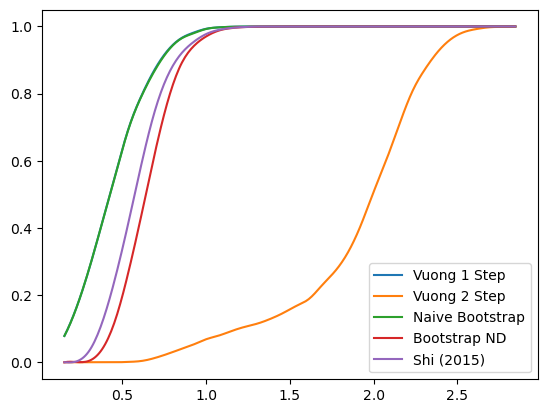

0.00044721359549995795 3.465724215775732


In [12]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)